In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.
File descriptions

    train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
    test.csv contains the test data.
    sample_submission.csv is submission file showing the correct format.

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from catboost import CatBoostClassifier
from catboost import Pool

from sklearn.model_selection import StratifiedKFold
import itertools
import math
import os

In [217]:
trainDir = '/tmp/porto/catboost/'

In [2]:
train = pd.read_csv('./data/train.csv',index_col='id')
test = pd.read_csv('./data/test.csv',index_col='id')

In [ ]:
for cName in train.columns.drop('target'):
    train.hist(bins=50,by = 'target',column = cName)
    plt.title(cName)

Категориальные фичи

In [ ]:
train.hist(bins=50,by = 'target',column = 'ps_ind_11_bin')

In [ ]:
sns.factorplot(x="ps_ind_03", col="target", data=train, kind="count", size=4, aspect=.7);

In [ ]:
sns.violinplot(x="ps_ind_03", hue="target", data=train, palette="muted", split=True)

Классы несбалансированы

Посмотреть на корреляцию данных и целевой переменной

In [ ]:
train.hist(by='target')

In [ ]:
ax = sns.violinplot(x="day", y="total_bill", hue="smoker",
...                     data=tips, palette="muted", split=True)

# CatBoost

In [ ]:
trainPool = Pool(train.drop('target',axis = 1),train.target)
testPool  = Pool(test)

# specify the training parameters 
model = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.05, loss_function='Logloss',thread_count=6)
#train the model
model.fit(trainPool,verbose=True, plot=True)

In [ ]:
# make the prediction using the resulting model
preds = model.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

score 0.274

## Балансировка классов

In [ ]:
# specify the training parameters 
model2 = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.05, loss_function='Logloss',thread_count=6,class_weights=[0.2, 0.8])
#train the model
model2.fit(trainPool,verbose=True, plot=True)

In [ ]:
# make the prediction using the resulting model
preds = model2.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

In [ ]:
model2.save_model('model2.cbm')

score 0.270

# Investigate some ideas from kaggle's forum

# column ps_car_15
Column "ps_car_15" contains below unique values, which are square roots of integer 0 ~ 14. Is it devised deliberately? It looks non-sense.

In [5]:
def modCat15(df):
    return df.assign(ps_car_15_mod = np.power(df.ps_car_15,2).astype(int))

In [ ]:
trainPool = Pool(train.drop('target',axis = 1),train.target)
testPool  = Pool(test)

# specify the training parameters 
model = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.05, loss_function='Logloss',thread_count=6)
#train the model
model.fit(trainPool,verbose=True, plot=True)

Скор 0.271, что соевсем не улучшило предыдущий результат. В тоже время последняя загрузка давала 0.270. Возможно, дело в скорости обучения. Поставлю дефолтное значение. 
<ul> Идеи, что можно проверить и поделать
<li> Задавать параметр "категориальные значения" для категориальных.
<li> Подбор гиперпарамеров
<li> Сделать оценку целевой метрики Джини
<li> Feature engineering
<li> Перевести one-hot-endoded в категориальные переменные, поставить их как категории
</ul> 

In [6]:
X_train = modCat15(train.drop('target',axis = 1))
y_train = train.target

In [ ]:
trainPool = Pool(X_train,y_train,
                 feature_names=X_train.columns.tolist())

In [ ]:
X_test = modCat15(test)
testPool = Pool(X_test,feature_names=X_train.columns.tolist())

In [ ]:
# specify the training parameters 
model = CatBoostClassifier(iterations=1000, depth=10, learning_rate=0.03, loss_function='Logloss',thread_count=6)
#train the model
model.fit(trainPool,verbose=True, plot=True)

# make the prediction using the resulting model
preds = model.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

Скор 0.274, как и был. То есть квадрат категории ps_car_15 ничего не даёт

In [245]:
# Распарсим имена фич и все с суффиксом cat запишем в категориальные, получим их номера и будем 

def getCatFeatures(featureList):
    '''
    featureList is list of features name (df.columns.tolist())
    '''
    catFeatures = []
    for featureInd, featureName in enumerate(featureList):
        if featureName[-3:] == 'cat':
            catFeatures.append(featureInd)
            
    return catFeatures      

In [ ]:
catFeatures = getCatFeatures(X_train.columns.tolist())
catFeatures 

In [ ]:
y_train = train.target
trainPool = Pool(X_train,y_train, feature_names=X_train.columns.tolist(),cat_features= catFeatures)

In [ ]:
testPool = Pool(X_test, feature_names=X_train.columns.tolist(), cat_features= catFeatures)

# specify the training parameters 
model = CatBoostClassifier(iterations=3000, depth=10, learning_rate=0.03, loss_function='Logloss',thread_count=6)
#train the model
model.fit(trainPool,verbose=True, plot=True)

# make the prediction using the resulting model
preds = model.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

Улучшил скор на 0,002. Возможно, сыграла свою роль случайность сида в random генераторе.

Переход на 3000 итераций не дал улучшений.

In [ ]:
coeffs = model.get_feature_importance(trainPool, cat_features= catFeatures, thread_count=4, fstr_type='FeatureImportance')

In [ ]:
inds = np.argsort(np.array(coeffs))

plt.figure(figsize = [15,20])

plt.barh(range(len(coeffs)),np.array(coeffs)[inds], tick_label = np.array(X_train.columns.tolist())[inds],
        color="r", align="center")
plt.ylim([-1, X_train.shape[1]])

Виден резкий скачок в значимости параметров для последний 12 категорий

ps_calc_15,16,17,18,19,20_bin

ps_ind_10,11,12,13_bin

ps_ind_14

that is, you won't find a row where more than one of [ps_ind_06,ps_ind_07,ps_ind_08,ps_ind_09] is True. 

Может быть ps_calc_15_30- тоже one-hot-encoding?
Совсем нет ((

In [ ]:
np.unique(X_train.ps_ind_06_bin+X_train.ps_ind_07_bin+X_train.ps_ind_08_bin+X_train.ps_ind_09_bin)

In [3]:
def invOneHot(df):
    tmp = df.assign(ps_ind_69_cat = 0*df.ps_ind_06_bin+df.ps_ind_07_bin+2*df.ps_ind_08_bin+3*df.ps_ind_09_bin)
    tmp.drop(['ps_ind_06_bin','ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin'],inplace=True,axis = 1)
    return tmp

In [7]:
X_train2 = invOneHot(X_train)

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,...,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_15_mod,ps_ind_69_cat
id,,,,,,,,,,,,,,,,,,,,,
7,2,2,5,1,0,0,0,0,0,0,...,5,8,0,1,1,0,0,1,13,1
9,1,1,7,0,0,0,0,0,0,0,...,1,9,0,1,1,0,1,0,6,2
13,5,4,9,1,0,0,0,0,0,0,...,7,7,0,1,1,0,1,0,11,2
16,0,1,2,0,0,0,0,0,0,0,...,4,9,0,0,0,0,0,0,4,0
17,0,2,0,1,0,0,0,0,0,0,...,1,3,0,0,0,1,1,0,4,0


In [12]:
X_train2 = invOneHot(X_train)
tp = Pool(X_train2,y_train,feature_names=X_train2.columns.tolist())

In [35]:
model5 = CatBoostClassifier(verbose=True,iterations=500)

In [36]:
model5.fit(tp)

Borders for float features generated
0:	learn 0.6484665849	total: 512ms	remaining: 4m 15s
1:	learn 0.6075430241	total: 1.01s	remaining: 4m 10s
2:	learn 0.5701063869	total: 1.48s	remaining: 4m 5s
3:	learn 0.53569801	total: 1.92s	remaining: 3m 57s
4:	learn 0.5043244463	total: 2.38s	remaining: 3m 55s
5:	learn 0.4755537023	total: 2.81s	remaining: 3m 51s
6:	learn 0.449189969	total: 3.22s	remaining: 3m 46s
7:	learn 0.4252023207	total: 3.68s	remaining: 3m 46s
8:	learn 0.4032925531	total: 4.16s	remaining: 3m 47s
9:	learn 0.3831429331	total: 4.61s	remaining: 3m 46s
10:	learn 0.3647294409	total: 5.33s	remaining: 3m 57s
11:	learn 0.3478762585	total: 5.94s	remaining: 4m 1s
12:	learn 0.332580569	total: 6.36s	remaining: 3m 58s
13:	learn 0.3184402244	total: 6.85s	remaining: 3m 57s
14:	learn 0.3054687919	total: 7.33s	remaining: 3m 57s
15:	learn 0.2936794975	total: 7.8s	remaining: 3m 56s
16:	learn 0.2827595843	total: 8.23s	remaining: 3m 53s
17:	learn 0.2728101417	total: 8.65s	remaining: 3m 51s
18:	lear

152:	learn 0.1523411978	total: 1m 18s	remaining: 2m 57s
153:	learn 0.1523305053	total: 1m 18s	remaining: 2m 56s
154:	learn 0.1523177655	total: 1m 19s	remaining: 2m 55s
155:	learn 0.152303176	total: 1m 20s	remaining: 2m 57s
156:	learn 0.1522891779	total: 1m 21s	remaining: 2m 58s
157:	learn 0.1522781048	total: 1m 22s	remaining: 2m 57s
158:	learn 0.1522725865	total: 1m 22s	remaining: 2m 56s
159:	learn 0.1522636741	total: 1m 22s	remaining: 2m 56s
160:	learn 0.1522528641	total: 1m 23s	remaining: 2m 56s
161:	learn 0.1522441462	total: 1m 25s	remaining: 2m 58s
162:	learn 0.1522379531	total: 1m 27s	remaining: 3m
163:	learn 0.1522337874	total: 1m 29s	remaining: 3m 2s
164:	learn 0.1522245759	total: 1m 29s	remaining: 3m 1s
165:	learn 0.1522120319	total: 1m 29s	remaining: 3m
166:	learn 0.1522022791	total: 1m 30s	remaining: 3m
167:	learn 0.1521926901	total: 1m 31s	remaining: 3m
168:	learn 0.15218465	total: 1m 31s	remaining: 2m 59s
169:	learn 0.1521766903	total: 1m 32s	remaining: 2m 58s
170:	learn 0.

300:	learn 0.1514137501	total: 3m 7s	remaining: 2m 4s
301:	learn 0.1514104719	total: 3m 8s	remaining: 2m 3s
302:	learn 0.1514060034	total: 3m 8s	remaining: 2m 2s
303:	learn 0.1514030667	total: 3m 9s	remaining: 2m 1s
304:	learn 0.1513979672	total: 3m 9s	remaining: 2m 1s
305:	learn 0.1513957844	total: 3m 11s	remaining: 2m 1s
306:	learn 0.1513926879	total: 3m 11s	remaining: 2m
307:	learn 0.1513861244	total: 3m 12s	remaining: 1m 59s
308:	learn 0.151380506	total: 3m 12s	remaining: 1m 59s
309:	learn 0.1513745587	total: 3m 13s	remaining: 1m 58s
310:	learn 0.1513703364	total: 3m 14s	remaining: 1m 57s
311:	learn 0.1513658336	total: 3m 14s	remaining: 1m 57s
312:	learn 0.1513634095	total: 3m 15s	remaining: 1m 56s
313:	learn 0.1513605376	total: 3m 15s	remaining: 1m 55s
314:	learn 0.1513582782	total: 3m 15s	remaining: 1m 55s
315:	learn 0.1513529748	total: 3m 16s	remaining: 1m 54s
316:	learn 0.1513480813	total: 3m 16s	remaining: 1m 53s
317:	learn 0.1513454186	total: 3m 17s	remaining: 1m 52s
318:	lea

449:	learn 0.1508622922	total: 4m 19s	remaining: 28.8s
450:	learn 0.1508573844	total: 4m 19s	remaining: 28.2s
451:	learn 0.1508525001	total: 4m 20s	remaining: 27.6s
452:	learn 0.1508487602	total: 4m 20s	remaining: 27.1s
453:	learn 0.1508445863	total: 4m 21s	remaining: 26.5s
454:	learn 0.1508391434	total: 4m 21s	remaining: 25.9s
455:	learn 0.1508360688	total: 4m 22s	remaining: 25.3s
456:	learn 0.1508320357	total: 4m 22s	remaining: 24.7s
457:	learn 0.1508274665	total: 4m 23s	remaining: 24.1s
458:	learn 0.1508234867	total: 4m 23s	remaining: 23.5s
459:	learn 0.1508196576	total: 4m 23s	remaining: 22.9s
460:	learn 0.1508163214	total: 4m 24s	remaining: 22.4s
461:	learn 0.1508115704	total: 4m 24s	remaining: 21.8s
462:	learn 0.1508068551	total: 4m 25s	remaining: 21.2s
463:	learn 0.1508022678	total: 4m 25s	remaining: 20.6s
464:	learn 0.1507991653	total: 4m 26s	remaining: 20s
465:	learn 0.1507972372	total: 4m 26s	remaining: 19.5s
466:	learn 0.1507931899	total: 4m 27s	remaining: 18.9s
467:	learn 0

In [22]:
def plotFeatureImportance(cfs,df_col_name):
    inds = np.argsort(np.array(cfs))
    
    kArr = np.array(df_col_name)[inds]
    vArr = np.array(cfs)[inds]
    
    res = {k:v for (k,v) in zip(kArr,vArr)}
    
    plt.figure(figsize = [15,20])
    plt.barh(range(len(cfs)), vArr, tick_label = kArr, color="r", align="center")
    plt.ylim([-1, X_train.shape[1]])
    
    return res

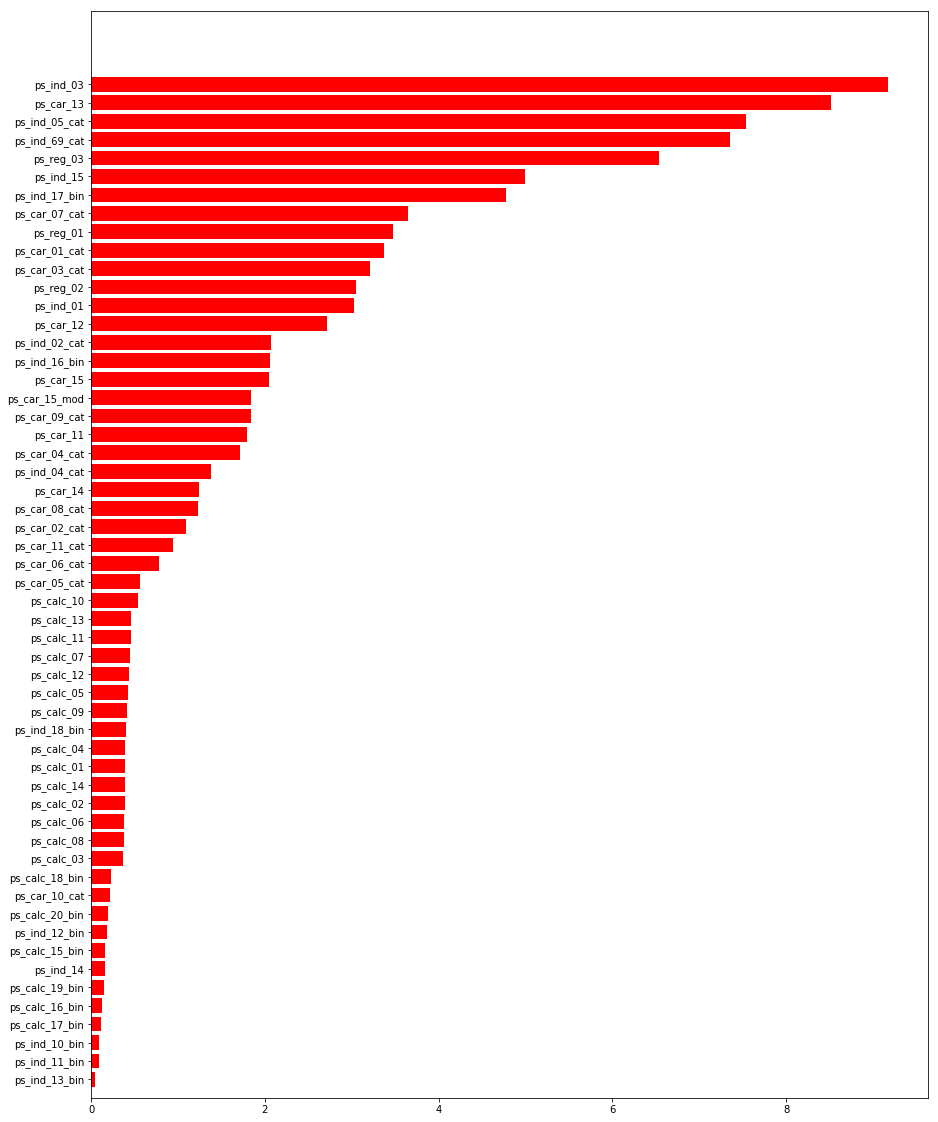

In [37]:
coeffs2 = model5.get_feature_importance(tp)
cDict = plotFeatureImportance(coeffs2,X_train2.columns.tolist())

In [38]:
cDict.get('ps_ind_69_cat')

7.3520621444403762

In [94]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)
 
def test_gini():
    def fequ(a,b):
        return abs( a -b) < 1e-6

    def T(a, p, g, n):
        assert( fequ(gini(a,p), g) )
        assert( fequ(gini_normalized(a,p), n) )
     
    T([1, 2, 3], [10, 20, 30], 0.111111, 1)
    T([1, 2, 3], [30, 20, 10], -0.111111, -1)
    T([1, 2, 3], [0, 0, 0], -0.111111, -1)
    T([3, 2, 1], [0, 0, 0], 0.111111, 1)
    T([1, 2, 4, 3], [0, 0, 0, 0], -0.1, -0.8)
    T([2, 1, 4, 3], [0, 0, 2, 1], 0.125, 1)
    T([0, 20, 40, 0, 10], [40, 40, 10, 5, 5], 0, 0)
    T([40, 0, 20, 0, 10], [1000000, 40, 40, 5, 5], 0.171428, 0.6)
    T([40, 20, 10, 0, 0], [40, 20, 10, 0, 0], 0.285714, 1)
    T([1, 1, 0, 1], [0.86, 0.26, 0.52, 0.32], -0.041666, -0.333333)

In [43]:
X_test2 = invOneHot(modCat15(test))
tp2 = Pool(X_test2, feature_names=X_test2.columns.tolist())

# make the prediction using the resulting model
preds = model5.predict_proba(tp2)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

In [51]:
## pipeline

# prepare data
X_train = invOneHot(modCat15(train.drop('target',axis = 1)))
y_train = train.target
X_test = invOneHot(modCat15(test))

In [206]:
fullPool = Pool(X_train, y_train, feature_names=X_train.columns.tolist())

In [209]:
testPool = Pool(X_test, feature_names=X_train.columns.tolist())

In [225]:
tModel = CatBoostClassifier(verbose=True, iterations=200, thread_count=4, random_seed=42, eval_metric= GiniMetric(),
                                   depth=14, learning_rate=0.03, l2_leaf_reg= 3, bagging_temperature=1)

In [226]:
tModel.fit(fullPool,verbose=True)

Borders for float features generated
0:	learn 0.1562063467	total: 8.06s	remaining: 26m 44s
1:	learn 0.1793790157	total: 9.12s	remaining: 15m 2s
2:	learn 0.1793076484	total: 9.82s	remaining: 10m 45s
3:	learn 0.2191870035	total: 10.9s	remaining: 8m 52s
4:	learn 0.22808223	total: 12.1s	remaining: 7m 52s
5:	learn 0.2295418276	total: 13.4s	remaining: 7m 11s
6:	learn 0.2459253877	total: 21.2s	remaining: 9m 43s
7:	learn 0.2592813615	total: 29.1s	remaining: 11m 38s
8:	learn 0.2665079126	total: 33s	remaining: 11m 40s
9:	learn 0.2667396396	total: 33.8s	remaining: 10m 41s
10:	learn 0.2684079786	total: 35s	remaining: 10m 1s
11:	learn 0.2766424293	total: 42.9s	remaining: 11m 12s
12:	learn 0.2789818905	total: 43.9s	remaining: 10m 31s
13:	learn 0.2804050652	total: 46.3s	remaining: 10m 15s
14:	learn 0.2838674233	total: 47.7s	remaining: 9m 48s
15:	learn 0.2852044663	total: 49.2s	remaining: 9m 26s
16:	learn 0.2892131905	total: 57.3s	remaining: 10m 16s
17:	learn 0.2912930732	total: 58.5s	remaining: 9m 51

149:	learn 0.3230867265	total: 7m 49s	remaining: 2m 36s
150:	learn 0.3251435542	total: 7m 56s	remaining: 2m 34s
151:	learn 0.326053098	total: 8m 4s	remaining: 2m 32s
152:	learn 0.3260143786	total: 8m 5s	remaining: 2m 29s
153:	learn 0.3285405043	total: 8m 13s	remaining: 2m 27s
154:	learn 0.3296245674	total: 8m 20s	remaining: 2m 25s
155:	learn 0.3306439013	total: 8m 28s	remaining: 2m 23s
156:	learn 0.3306416173	total: 8m 29s	remaining: 2m 19s
157:	learn 0.331033936	total: 8m 30s	remaining: 2m 15s
158:	learn 0.3332706801	total: 8m 32s	remaining: 2m 12s
159:	learn 0.3331595318	total: 8m 32s	remaining: 2m 8s
160:	learn 0.3332700701	total: 8m 33s	remaining: 2m 4s
161:	learn 0.3334420149	total: 8m 35s	remaining: 2m
162:	learn 0.3367401322	total: 8m 43s	remaining: 1m 58s
163:	learn 0.337002777	total: 8m 51s	remaining: 1m 56s
164:	learn 0.3376999942	total: 8m 59s	remaining: 1m 54s
165:	learn 0.3376605412	total: 9m	remaining: 1m 50s
166:	learn 0.3382549339	total: 9m 8s	remaining: 1m 48s
167:	lea

In [227]:
# make the prediction using the resulting model
preds = tModel.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(preds,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

In [312]:
# prepare params
depth = [10] # depth of trees
rate  = [0.07, 0.1, 0.01, 0.03]; # learning rate
l2    = [1, 3, 5, 10]; # l2_leaf_reg
T = [1]; # bagging_temperature
pr = itertools.product(depth, rate, l2, T)

In [246]:
catFeatures = getCatFeatures(X_train)

In [313]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best = 0
pr = itertools.product(depth, rate, l2, T)

for params in pr:
    print params
    
    giniList = list()
    modelList = list()

    dirName = '/tmp/porto/catboost/'+str(params[0])+'_'+str(params[1])+'_'+str(params[2])+'_'+str(params[3])
    os.mkdir(dirName)
    
    ind = 0;
    
    for train_index, val_index in skf.split(X_train, y_train):
        ind = ind +1   
            
        model = CatBoostClassifier(verbose=True, iterations=1000, thread_count=4, random_seed=42,
                                   depth=params[0], learning_rate=params[1],
                                   l2_leaf_reg=params[2], bagging_temperature=params[3],
                                   eval_metric= GiniMetric(), train_dir = dirName+'/'+str(ind),
                                   od_type = 'Iter', od_wait = 20)
        
        trainPool = Pool(X_train.iloc[train_index], y_train.iloc[train_index],
                         feature_names=X_train.columns.tolist(), cat_features= catFeatures)
        valPool   = Pool(X_train.iloc[val_index],   y_train.iloc[val_index], 
                         feature_names=X_train.columns.tolist(), cat_features= catFeatures) 

        model.fit(trainPool, eval_set=valPool, use_best_model = True)
        modelList.append(model)
        
        c = model.predict(valPool,prediction_type='Probability')[:,1]
        g = gini_normalized(y_train.iloc[val_index], c)
        giniList.append(g)

    print giniList
    meanGini = np.array(giniList).mean()
    print 'Gini',meanGini
    
    if meanGini>best:
        best = meanGini
        
        bestList = modelList
        bestParams = params
        #bestModel.save_model('bestModel3.cbm')
        print 'Rewrite best model'

(10, 0.07, 1, 1)
Borders for float features generated
0:	learn 0.05415180668	test 0.04222790496	bestTest 0.04222790496		total: 1.41s	remaining: 23m 26s
1:	learn 0.114195394	test 0.1056244298	bestTest 0.1056244298		total: 2.79s	remaining: 23m 10s
2:	learn 0.1440206674	test 0.1245645254	bestTest 0.1245645254		total: 5.81s	remaining: 32m 10s
3:	learn 0.1485224082	test 0.1242866636	bestTest 0.1245645254		total: 10.1s	remaining: 41m 59s
4:	learn 0.1638139315	test 0.1352472278	bestTest 0.1352472278		total: 14.3s	remaining: 47m 34s
5:	learn 0.1637794465	test 0.1351943245	bestTest 0.1352472278		total: 15.3s	remaining: 42m 19s
6:	learn 0.1769427625	test 0.1567801671	bestTest 0.1567801671		total: 18.4s	remaining: 43m 26s
7:	learn 0.1769427625	test 0.1567801671	bestTest 0.1567801671		total: 18.9s	remaining: 38m 59s
8:	learn 0.1950105679	test 0.1760316587	bestTest 0.1760316587		total: 19.8s	remaining: 36m 20s
9:	learn 0.1949987729	test 0.1760316587	bestTest 0.1760316587		total: 20.8s	remaining: 34

85:	learn 0.2845175885	test 0.2432758738	bestTest 0.2432758738		total: 3m 35s	remaining: 38m 6s
86:	learn 0.2846720295	test 0.2434922569	bestTest 0.2434922569		total: 3m 36s	remaining: 37m 53s
87:	learn 0.2860633691	test 0.2437817884	bestTest 0.2437817884		total: 3m 40s	remaining: 38m 1s
88:	learn 0.286276781	test 0.2440013099	bestTest 0.2440013099		total: 3m 44s	remaining: 38m 17s
89:	learn 0.2869960194	test 0.2439815792	bestTest 0.2440013099		total: 3m 47s	remaining: 38m 21s
90:	learn 0.2871784034	test 0.2442058827	bestTest 0.2442058827		total: 3m 49s	remaining: 38m 14s
91:	learn 0.2879027345	test 0.2449104708	bestTest 0.2449104708		total: 3m 53s	remaining: 38m 23s
92:	learn 0.2887223282	test 0.2455252018	bestTest 0.2455252018		total: 3m 56s	remaining: 38m 26s
93:	learn 0.2889613245	test 0.2458092119	bestTest 0.2458092119		total: 4m	remaining: 38m 41s
94:	learn 0.2894678252	test 0.2464080899	bestTest 0.2464080899		total: 4m 3s	remaining: 38m 43s
95:	learn 0.2897015989	test 0.24654084

170:	learn 0.3122660393	test 0.2538567239	bestTest 0.2538567239		total: 8m 20s	remaining: 40m 27s
171:	learn 0.3126352575	test 0.2540383431	bestTest 0.2540383431		total: 8m 24s	remaining: 40m 29s
172:	learn 0.3131302199	test 0.2539228238	bestTest 0.2540383431		total: 8m 28s	remaining: 40m 31s
173:	learn 0.3132838969	test 0.2539265048	bestTest 0.2540383431		total: 8m 31s	remaining: 40m 29s
174:	learn 0.3141226859	test 0.2539716524	bestTest 0.2540383431		total: 8m 35s	remaining: 40m 30s
175:	learn 0.3148095932	test 0.2537991551	bestTest 0.2540383431		total: 8m 39s	remaining: 40m 31s
176:	learn 0.3148677434	test 0.2538783031	bestTest 0.2540383431		total: 8m 42s	remaining: 40m 30s
177:	learn 0.3149443301	test 0.2538556791	bestTest 0.2540383431		total: 8m 47s	remaining: 40m 37s
178:	learn 0.3155694554	test 0.2541475412	bestTest 0.2541475412		total: 8m 51s	remaining: 40m 36s
179:	learn 0.3158842271	test 0.2540854115	bestTest 0.2541475412		total: 8m 55s	remaining: 40m 38s
180:	learn 0.3163073

254:	learn 0.3429353692	test 0.2575772414	bestTest 0.2576145208		total: 13m 57s	remaining: 40m 46s
255:	learn 0.3429571349	test 0.2575863673	bestTest 0.2576145208		total: 14m 1s	remaining: 40m 46s
256:	learn 0.3431257233	test 0.2575884931	bestTest 0.2576145208		total: 14m 5s	remaining: 40m 45s
257:	learn 0.3432463972	test 0.2576091521	bestTest 0.2576145208		total: 14m 10s	remaining: 40m 44s
258:	learn 0.3439299383	test 0.2575498715	bestTest 0.2576145208		total: 14m 13s	remaining: 40m 41s
259:	learn 0.3439748476	test 0.2575094898	bestTest 0.2576145208		total: 14m 18s	remaining: 40m 42s
260:	learn 0.3443346454	test 0.2575618466	bestTest 0.2576145208		total: 14m 21s	remaining: 40m 38s
261:	learn 0.3444047388	test 0.2575484811	bestTest 0.2576145208		total: 14m 25s	remaining: 40m 38s
262:	learn 0.344578871	test 0.2575224132	bestTest 0.2576145208		total: 14m 29s	remaining: 40m 36s
263:	learn 0.344642384	test 0.2575368235	bestTest 0.2576145208		total: 14m 33s	remaining: 40m 36s
264:	learn 0.3

43:	learn 0.2515077546	test 0.2500961944	bestTest 0.2500961944		total: 1m 42s	remaining: 36m 57s
44:	learn 0.2527548498	test 0.2509727815	bestTest 0.2509727815		total: 1m 45s	remaining: 37m 14s
45:	learn 0.252769684	test 0.251066392	bestTest 0.251066392		total: 1m 47s	remaining: 37m 3s
46:	learn 0.2538112415	test 0.2516272231	bestTest 0.2516272231		total: 1m 49s	remaining: 37m 5s
47:	learn 0.2543820494	test 0.252397855	bestTest 0.252397855		total: 1m 52s	remaining: 37m 5s
48:	learn 0.2555569665	test 0.2532736987	bestTest 0.2532736987		total: 1m 54s	remaining: 37m 4s
49:	learn 0.2558342121	test 0.2535667062	bestTest 0.2535667062		total: 1m 56s	remaining: 36m 53s
50:	learn 0.2567177123	test 0.254383643	bestTest 0.254383643		total: 1m 59s	remaining: 37m 4s
51:	learn 0.257170246	test 0.2548272952	bestTest 0.2548272952		total: 2m 1s	remaining: 36m 48s
52:	learn 0.2575550425	test 0.2552518878	bestTest 0.2552518878		total: 2m 3s	remaining: 36m 47s
53:	learn 0.2580533049	test 0.2559314288	best

129:	learn 0.2903855984	test 0.2755190421	bestTest 0.2755190421		total: 5m 54s	remaining: 39m 33s
130:	learn 0.2909534254	test 0.2755589456	bestTest 0.2755589456		total: 5m 59s	remaining: 39m 43s
131:	learn 0.2911666032	test 0.2757111415	bestTest 0.2757111415		total: 6m 3s	remaining: 39m 49s
132:	learn 0.2914283306	test 0.2756893252	bestTest 0.2757111415		total: 6m 7s	remaining: 39m 53s
133:	learn 0.2916536414	test 0.275711692	bestTest 0.275711692		total: 6m 9s	remaining: 39m 44s
134:	learn 0.2919129276	test 0.275814099	bestTest 0.275814099		total: 6m 12s	remaining: 39m 48s
135:	learn 0.2919353362	test 0.2757901609	bestTest 0.275814099		total: 6m 14s	remaining: 39m 39s
136:	learn 0.292451493	test 0.2760099677	bestTest 0.2760099677		total: 6m 17s	remaining: 39m 38s
137:	learn 0.293296602	test 0.2766093802	bestTest 0.2766093802		total: 6m 20s	remaining: 39m 39s
138:	learn 0.2936679958	test 0.2764802183	bestTest 0.2766093802		total: 6m 24s	remaining: 39m 42s
139:	learn 0.293974385	test 0.

214:	learn 0.318203223	test 0.2811540558	bestTest 0.2811540558		total: 10m 52s	remaining: 39m 44s
215:	learn 0.3187474049	test 0.2812401075	bestTest 0.2812401075		total: 10m 56s	remaining: 39m 43s
216:	learn 0.3193972559	test 0.2812203165	bestTest 0.2812401075		total: 10m 59s	remaining: 39m 40s
217:	learn 0.3194805978	test 0.2812460991	bestTest 0.2812460991		total: 11m 3s	remaining: 39m 39s
218:	learn 0.3200981707	test 0.2815102659	bestTest 0.2815102659		total: 11m 6s	remaining: 39m 37s
219:	learn 0.3204871319	test 0.2814335973	bestTest 0.2815102659		total: 11m 10s	remaining: 39m 38s
220:	learn 0.3212150078	test 0.2815541316	bestTest 0.2815541316		total: 11m 13s	remaining: 39m 35s
221:	learn 0.3213562441	test 0.2814873565	bestTest 0.2815541316		total: 11m 17s	remaining: 39m 33s
222:	learn 0.3216899656	test 0.281650764	bestTest 0.281650764		total: 11m 21s	remaining: 39m 35s
223:	learn 0.3217530903	test 0.2816592028	bestTest 0.2816592028		total: 11m 26s	remaining: 39m 38s
224:	learn 0.32

7:	learn 0.1864561601	test 0.1701427856	bestTest 0.1701427856		total: 22s	remaining: 45m 33s
8:	learn 0.1845847998	test 0.1676356922	bestTest 0.1701427856		total: 23.4s	remaining: 42m 54s
9:	learn 0.1845614045	test 0.1676421218	bestTest 0.1701427856		total: 24s	remaining: 39m 40s
10:	learn 0.1848855723	test 0.1686363701	bestTest 0.1701427856		total: 26s	remaining: 38m 54s
11:	learn 0.186467311	test 0.1712962862	bestTest 0.1712962862		total: 28.9s	remaining: 39m 40s
12:	learn 0.1865438965	test 0.1720687826	bestTest 0.1720687826		total: 30.7s	remaining: 38m 48s
13:	learn 0.1870565273	test 0.1724518643	bestTest 0.1724518643		total: 31.7s	remaining: 37m 12s
14:	learn 0.191131724	test 0.174920758	bestTest 0.174920758		total: 33.9s	remaining: 37m 7s
15:	learn 0.191131724	test 0.174920758	bestTest 0.174920758		total: 34.5s	remaining: 35m 20s
16:	learn 0.1935518203	test 0.1790072545	bestTest 0.1790072545		total: 38.6s	remaining: 37m 12s
17:	learn 0.1988358609	test 0.1857902313	bestTest 0.18579

93:	learn 0.2791723953	test 0.2644918394	bestTest 0.2644918394		total: 3m 53s	remaining: 37m 27s
94:	learn 0.2801957795	test 0.2645156208	bestTest 0.2645156208		total: 3m 56s	remaining: 37m 35s
95:	learn 0.2802716993	test 0.2645858036	bestTest 0.2645858036		total: 3m 58s	remaining: 37m 21s
96:	learn 0.2810071623	test 0.2649940047	bestTest 0.2649940047		total: 4m 1s	remaining: 37m 25s
97:	learn 0.2815006527	test 0.2652998231	bestTest 0.2652998231		total: 4m 5s	remaining: 37m 35s
98:	learn 0.2822178086	test 0.2654762062	bestTest 0.2654762062		total: 4m 8s	remaining: 37m 44s
99:	learn 0.2824954694	test 0.265744717	bestTest 0.265744717		total: 4m 9s	remaining: 37m 28s
100:	learn 0.282486005	test 0.2657818639	bestTest 0.2657818639		total: 4m 14s	remaining: 37m 41s
101:	learn 0.2831126452	test 0.266061747	bestTest 0.266061747		total: 4m 17s	remaining: 37m 48s
102:	learn 0.2831674596	test 0.2660746543	bestTest 0.2660746543		total: 4m 21s	remaining: 37m 58s
103:	learn 0.2832371059	test 0.26622

178:	learn 0.3084143695	test 0.2736128401	bestTest 0.2736128401		total: 8m 29s	remaining: 38m 58s
179:	learn 0.309041724	test 0.2739156486	bestTest 0.2739156486		total: 8m 33s	remaining: 38m 57s
180:	learn 0.309414166	test 0.2739416401	bestTest 0.2739416401		total: 8m 37s	remaining: 38m 59s
181:	learn 0.3097310457	test 0.2740279209	bestTest 0.2740279209		total: 8m 40s	remaining: 38m 59s
182:	learn 0.3101283576	test 0.2741152023	bestTest 0.2741152023		total: 8m 44s	remaining: 38m 59s
183:	learn 0.3103711453	test 0.2741885717	bestTest 0.2741885717		total: 8m 48s	remaining: 39m 2s
184:	learn 0.3108013234	test 0.2741835406	bestTest 0.2741885717		total: 8m 51s	remaining: 39m 2s
185:	learn 0.3109249171	test 0.2742896566	bestTest 0.2742896566		total: 8m 56s	remaining: 39m 6s
186:	learn 0.3116939818	test 0.2742065142	bestTest 0.2742896566		total: 8m 59s	remaining: 39m 5s
187:	learn 0.3119926253	test 0.2743182641	bestTest 0.2743182641		total: 9m 3s	remaining: 39m 6s
188:	learn 0.312256171	test 

262:	learn 0.3369372515	test 0.2763961718	bestTest 0.2765130934		total: 14m 5s	remaining: 39m 30s
263:	learn 0.3369170646	test 0.276425792	bestTest 0.2765130934		total: 14m 10s	remaining: 39m 32s
264:	learn 0.3373661849	test 0.2764131177	bestTest 0.2765130934		total: 14m 16s	remaining: 39m 34s
265:	learn 0.3379801231	test 0.276083301	bestTest 0.2765130934		total: 14m 19s	remaining: 39m 32s
266:	learn 0.3379931956	test 0.2760929091	bestTest 0.2765130934		total: 14m 24s	remaining: 39m 32s
267:	learn 0.338208607	test 0.2761855391	bestTest 0.2765130934		total: 14m 28s	remaining: 39m 30s
268:	learn 0.3386124081	test 0.2761652177	bestTest 0.2765130934		total: 14m 31s	remaining: 39m 27s
269:	learn 0.3389748047	test 0.2761190654	bestTest 0.2765130934		total: 14m 36s	remaining: 39m 28s
270:	learn 0.3391068305	test 0.2761687258	bestTest 0.2765130934		total: 14m 40s	remaining: 39m 27s
271:	learn 0.3391165857	test 0.2761608576	bestTest 0.2765130934		total: 14m 44s	remaining: 39m 26s
272:	learn 0.3

64:	learn 0.2658272029	test 0.264122065	bestTest 0.264122065		total: 2m 33s	remaining: 36m 42s
65:	learn 0.2660217627	test 0.2644191096	bestTest 0.2644191096		total: 2m 35s	remaining: 36m 36s
66:	learn 0.2670442886	test 0.265098749	bestTest 0.265098749		total: 2m 38s	remaining: 36m 46s
67:	learn 0.2674379086	test 0.2654443895	bestTest 0.2654443895		total: 2m 40s	remaining: 36m 36s
68:	learn 0.2679697712	test 0.2657615628	bestTest 0.2657615628		total: 2m 44s	remaining: 36m 55s
69:	learn 0.2685603432	test 0.265965623	bestTest 0.265965623		total: 2m 47s	remaining: 37m 5s
70:	learn 0.2687773757	test 0.2661703382	bestTest 0.2661703382		total: 2m 48s	remaining: 36m 43s
71:	learn 0.2692810996	test 0.2663682098	bestTest 0.2663682098		total: 2m 52s	remaining: 37m
72:	learn 0.2704805009	test 0.266572696	bestTest 0.266572696		total: 2m 55s	remaining: 37m 6s
73:	learn 0.2711339674	test 0.2669126824	bestTest 0.2669126824		total: 2m 59s	remaining: 37m 21s
74:	learn 0.2716922136	test 0.2672540352	bes

149:	learn 0.3034343011	test 0.2779414882	bestTest 0.2779414882		total: 6m 55s	remaining: 39m 16s
150:	learn 0.3035890982	test 0.2779596478	bestTest 0.2779596478		total: 6m 57s	remaining: 39m 8s
151:	learn 0.303698046	test 0.2780648968	bestTest 0.2780648968		total: 7m 2s	remaining: 39m 16s
152:	learn 0.3038139363	test 0.2780049968	bestTest 0.2780648968		total: 7m 3s	remaining: 39m 7s
153:	learn 0.3041051232	test 0.2780781458	bestTest 0.2780781458		total: 7m 7s	remaining: 39m 7s
154:	learn 0.3043721006	test 0.2781222008	bestTest 0.2781222008		total: 7m 11s	remaining: 39m 11s
155:	learn 0.306146258	test 0.278451502	bestTest 0.278451502		total: 7m 15s	remaining: 39m 13s
156:	learn 0.3062755618	test 0.2785155169	bestTest 0.2785155169		total: 7m 19s	remaining: 39m 18s
157:	learn 0.3064023331	test 0.2785322299	bestTest 0.2785322299		total: 7m 22s	remaining: 39m 20s
158:	learn 0.3069019188	test 0.2788281935	bestTest 0.2788281935		total: 7m 26s	remaining: 39m 21s
159:	learn 0.3070053167	test 0

233:	learn 0.3377161446	test 0.2817873113	bestTest 0.2818535485		total: 12m 8s	remaining: 39m 45s
234:	learn 0.3378956312	test 0.2817751432	bestTest 0.2818535485		total: 12m 12s	remaining: 39m 44s
235:	learn 0.3379679604	test 0.2817493122	bestTest 0.2818535485		total: 12m 16s	remaining: 39m 44s
236:	learn 0.3384037984	test 0.2819327775	bestTest 0.2819327775		total: 12m 19s	remaining: 39m 41s
237:	learn 0.3385118359	test 0.2819710538	bestTest 0.2819710538		total: 12m 24s	remaining: 39m 42s
238:	learn 0.3387998179	test 0.2818704021	bestTest 0.2819710538		total: 12m 28s	remaining: 39m 41s
239:	learn 0.3388325119	test 0.281836088	bestTest 0.2819710538		total: 12m 32s	remaining: 39m 42s
240:	learn 0.3388982655	test 0.2818883689	bestTest 0.2819710538		total: 12m 37s	remaining: 39m 45s
241:	learn 0.339053592	test 0.2818933117	bestTest 0.2819710538		total: 12m 41s	remaining: 39m 44s
242:	learn 0.3394874776	test 0.2818473037	bestTest 0.2819710538		total: 12m 45s	remaining: 39m 43s
243:	learn 0.

317:	learn 0.3572155	test 0.2829792871	bestTest 0.2831053038		total: 18m 1s	remaining: 38m 39s
318:	learn 0.357497902	test 0.2828885652	bestTest 0.2831053038		total: 18m 5s	remaining: 38m 36s
319:	learn 0.3575966582	test 0.2828439637	bestTest 0.2831053038		total: 18m 9s	remaining: 38m 36s
320:	learn 0.357629566	test 0.2827985625	bestTest 0.2831053038		total: 18m 14s	remaining: 38m 34s
321:	learn 0.3577132071	test 0.2827937081	bestTest 0.2831053038		total: 18m 18s	remaining: 38m 33s
322:	learn 0.3578840344	test 0.2826957407	bestTest 0.2831053038		total: 18m 23s	remaining: 38m 32s
323:	learn 0.3579367824	test 0.2826793492	bestTest 0.2831053038		total: 18m 28s	remaining: 38m 32s
324:	learn 0.3580243678	test 0.2826093788	bestTest 0.2831053038		total: 18m 31s	remaining: 38m 28s
325:	learn 0.3580507522	test 0.2826208477	bestTest 0.2831053038		total: 18m 36s	remaining: 38m 27s
326:	learn 0.3582344751	test 0.2823922223	bestTest 0.2831053038		total: 18m 39s	remaining: 38m 24s
327:	learn 0.35830

69:	learn 0.266912646	test 0.2696189574	bestTest 0.2696189574		total: 2m 34s	remaining: 34m 15s
70:	learn 0.2681946499	test 0.2703364638	bestTest 0.2703364638		total: 2m 37s	remaining: 34m 25s
71:	learn 0.2692385221	test 0.2703541293	bestTest 0.2703541293		total: 2m 41s	remaining: 34m 38s
72:	learn 0.2696928114	test 0.2707948851	bestTest 0.2707948851		total: 2m 43s	remaining: 34m 40s
73:	learn 0.2705648227	test 0.271323928	bestTest 0.271323928		total: 2m 45s	remaining: 34m 35s
74:	learn 0.2717522207	test 0.271266864	bestTest 0.271323928		total: 2m 50s	remaining: 34m 58s
75:	learn 0.2720675309	test 0.2714168816	bestTest 0.2714168816		total: 2m 54s	remaining: 35m 17s
76:	learn 0.2724970978	test 0.2716422798	bestTest 0.2716422798		total: 2m 57s	remaining: 35m 29s
77:	learn 0.2728680417	test 0.2715070658	bestTest 0.2716422798		total: 3m 1s	remaining: 35m 44s
78:	learn 0.2734465215	test 0.2721400795	bestTest 0.2721400795		total: 3m 2s	remaining: 35m 25s
79:	learn 0.2736193597	test 0.2722847

154:	learn 0.3034679463	test 0.2813088789	bestTest 0.2813396518		total: 7m 5s	remaining: 38m 42s
155:	learn 0.3038799046	test 0.2812953575	bestTest 0.2813396518		total: 7m 8s	remaining: 38m 40s
156:	learn 0.3039423366	test 0.2812693115	bestTest 0.2813396518		total: 7m 13s	remaining: 38m 47s
157:	learn 0.3040325946	test 0.2813027613	bestTest 0.2813396518		total: 7m 16s	remaining: 38m 47s
158:	learn 0.3040840471	test 0.2813371476	bestTest 0.2813396518		total: 7m 17s	remaining: 38m 33s
159:	learn 0.3040840471	test 0.2813371476	bestTest 0.2813396518		total: 7m 17s	remaining: 38m 19s
160:	learn 0.3042709224	test 0.2814392977	bestTest 0.2814392977		total: 7m 22s	remaining: 38m 24s
161:	learn 0.3045661223	test 0.2815785593	bestTest 0.2815785593		total: 7m 25s	remaining: 38m 26s
162:	learn 0.3051743886	test 0.2814799262	bestTest 0.2815785593		total: 7m 28s	remaining: 38m 24s
163:	learn 0.3065805683	test 0.2813694639	bestTest 0.2815785593		total: 7m 32s	remaining: 38m 24s
164:	learn 0.306780450

39:	learn 0.2546321264	test 0.2254291423	bestTest 0.2254291423		total: 1m 34s	remaining: 37m 56s
40:	learn 0.2566152646	test 0.2269729176	bestTest 0.2269729176		total: 1m 38s	remaining: 38m 12s
41:	learn 0.2569137763	test 0.2272501043	bestTest 0.2272501043		total: 1m 40s	remaining: 38m 16s
42:	learn 0.2569990527	test 0.2273910605	bestTest 0.2273910605		total: 1m 41s	remaining: 37m 41s
43:	learn 0.2571958104	test 0.2280776821	bestTest 0.2280776821		total: 1m 43s	remaining: 37m 37s
44:	learn 0.2577687244	test 0.2288411611	bestTest 0.2288411611		total: 1m 46s	remaining: 37m 30s
45:	learn 0.2590228955	test 0.2290932725	bestTest 0.2290932725		total: 1m 49s	remaining: 38m
46:	learn 0.2596655282	test 0.2294871398	bestTest 0.2294871398		total: 1m 54s	remaining: 38m 38s
47:	learn 0.2597566165	test 0.2295861752	bestTest 0.2295861752		total: 1m 55s	remaining: 38m 7s
48:	learn 0.2605307995	test 0.2298139788	bestTest 0.2298139788		total: 1m 56s	remaining: 37m 39s
49:	learn 0.2602995106	test 0.22958

124:	learn 0.2984687348	test 0.2507927456	bestTest 0.2507927456		total: 5m 46s	remaining: 40m 24s
125:	learn 0.2987165322	test 0.2509216423	bestTest 0.2509216423		total: 5m 50s	remaining: 40m 31s
126:	learn 0.2989829892	test 0.2512279027	bestTest 0.2512279027		total: 5m 52s	remaining: 40m 20s
127:	learn 0.2989851262	test 0.2512280755	bestTest 0.2512280755		total: 5m 52s	remaining: 40m 3s
128:	learn 0.2992267982	test 0.2512061427	bestTest 0.2512280755		total: 5m 56s	remaining: 40m 9s
129:	learn 0.2996082597	test 0.2514442255	bestTest 0.2514442255		total: 6m 1s	remaining: 40m 16s
130:	learn 0.30043911	test 0.2517713981	bestTest 0.2517713981		total: 6m 4s	remaining: 40m 16s
131:	learn 0.3014115301	test 0.2523307825	bestTest 0.2523307825		total: 6m 7s	remaining: 40m 19s
132:	learn 0.3015895666	test 0.252409155	bestTest 0.252409155		total: 6m 11s	remaining: 40m 23s
133:	learn 0.3016513669	test 0.2525669365	bestTest 0.2525669365		total: 6m 14s	remaining: 40m 17s
134:	learn 0.301770588	test 0

208:	learn 0.3293188639	test 0.2567648655	bestTest 0.2568576763		total: 10m 37s	remaining: 40m 14s
209:	learn 0.3296465174	test 0.2569479193	bestTest 0.2569479193		total: 10m 41s	remaining: 40m 12s
210:	learn 0.3297259134	test 0.2568972101	bestTest 0.2569479193		total: 10m 45s	remaining: 40m 14s
211:	learn 0.3301429233	test 0.2569904027	bestTest 0.2569904027		total: 10m 48s	remaining: 40m 10s
212:	learn 0.33041859	test 0.2570447245	bestTest 0.2570447245		total: 10m 52s	remaining: 40m 12s
213:	learn 0.3312150795	test 0.2570919898	bestTest 0.2570919898		total: 10m 56s	remaining: 40m 10s
214:	learn 0.332030997	test 0.2571245717	bestTest 0.2571245717		total: 10m 59s	remaining: 40m 7s
215:	learn 0.3321774274	test 0.2571201714	bestTest 0.2571245717		total: 11m 2s	remaining: 40m 5s
216:	learn 0.3323504809	test 0.257117025	bestTest 0.2571245717		total: 11m 6s	remaining: 40m 6s
217:	learn 0.3324519249	test 0.2571039046	bestTest 0.2571245717		total: 11m 11s	remaining: 40m 9s
218:	learn 0.3326355

292:	learn 0.353459688	test 0.2590498092	bestTest 0.2590652523		total: 16m 8s	remaining: 38m 57s
293:	learn 0.354468771	test 0.2590210088	bestTest 0.2590652523		total: 16m 12s	remaining: 38m 54s
294:	learn 0.3546060023	test 0.2589390841	bestTest 0.2590652523		total: 16m 17s	remaining: 38m 55s
295:	learn 0.354873897	test 0.258955371	bestTest 0.2590652523		total: 16m 20s	remaining: 38m 52s
296:	learn 0.3549370099	test 0.2589642759	bestTest 0.2590652523		total: 16m 24s	remaining: 38m 51s
297:	learn 0.3550316027	test 0.2589595502	bestTest 0.2590652523		total: 16m 30s	remaining: 38m 52s
298:	learn 0.3550252617	test 0.2589471331	bestTest 0.2590652523		total: 16m 34s	remaining: 38m 52s
299:	learn 0.3552919897	test 0.25900082	bestTest 0.2590652523		total: 16m 38s	remaining: 38m 49s
300:	learn 0.3557076157	test 0.258948865	bestTest 0.2590652523		total: 16m 42s	remaining: 38m 47s
301:	learn 0.3565309759	test 0.2590423148	bestTest 0.2590652523		total: 16m 45s	remaining: 38m 42s
302:	learn 0.35660

2:	learn 0.140572585	test 0.1380250542	bestTest 0.1380250542		total: 5.5s	remaining: 30m 27s
3:	learn 0.1449659201	test 0.1412509812	bestTest 0.1412509812		total: 9.81s	remaining: 40m 42s
4:	learn 0.1582345218	test 0.1579932416	bestTest 0.1579932416		total: 13.7s	remaining: 45m 27s
5:	learn 0.1698996211	test 0.1748733841	bestTest 0.1748733841		total: 15.8s	remaining: 43m 33s
6:	learn 0.1798146562	test 0.1814916957	bestTest 0.1814916957		total: 18s	remaining: 42m 35s
7:	learn 0.1841286568	test 0.187107706	bestTest 0.187107706		total: 22.1s	remaining: 45m 36s
8:	learn 0.1998701054	test 0.2003124786	bestTest 0.2003124786		total: 25.5s	remaining: 46m 50s
9:	learn 0.1998698934	test 0.2003124786	bestTest 0.2003124786		total: 26.2s	remaining: 43m 18s
10:	learn 0.2000672213	test 0.2008623754	bestTest 0.2008623754		total: 28.2s	remaining: 42m 15s
11:	learn 0.2079083964	test 0.2061952677	bestTest 0.2061952677		total: 32.3s	remaining: 44m 16s
12:	learn 0.21478538	test 0.2139057056	bestTest 0.2139

88:	learn 0.2839210612	test 0.2735023038	bestTest 0.2735023038		total: 3m 55s	remaining: 40m 6s
89:	learn 0.2839519843	test 0.2735869088	bestTest 0.2735869088		total: 3m 56s	remaining: 39m 46s
90:	learn 0.2840415796	test 0.2735680903	bestTest 0.2735869088		total: 3m 57s	remaining: 39m 31s
91:	learn 0.2840285127	test 0.27359933	bestTest 0.27359933		total: 3m 59s	remaining: 39m 24s
92:	learn 0.2840505147	test 0.2736754761	bestTest 0.2736754761		total: 4m 1s	remaining: 39m 15s
93:	learn 0.2842168037	test 0.2738823997	bestTest 0.2738823997		total: 4m 3s	remaining: 39m 9s
94:	learn 0.2842277095	test 0.2739074991	bestTest 0.2739074991		total: 4m 8s	remaining: 39m 28s
95:	learn 0.2842577096	test 0.2739517788	bestTest 0.2739517788		total: 4m 9s	remaining: 39m 8s
96:	learn 0.2846336278	test 0.2741345352	bestTest 0.2741345352		total: 4m 12s	remaining: 39m 10s
97:	learn 0.2845888368	test 0.2740793293	bestTest 0.2741345352		total: 4m 14s	remaining: 39m 5s
98:	learn 0.284774383	test 0.2741936631	be

173:	learn 0.3074370363	test 0.2819927527	bestTest 0.2819927527		total: 8m	remaining: 38m
174:	learn 0.3075069612	test 0.2820218023	bestTest 0.2820218023		total: 8m 3s	remaining: 38m
175:	learn 0.3075396279	test 0.2819981616	bestTest 0.2820218023		total: 8m 8s	remaining: 38m 6s
176:	learn 0.307652902	test 0.2820453064	bestTest 0.2820453064		total: 8m 13s	remaining: 38m 14s
177:	learn 0.3084099163	test 0.282303779	bestTest 0.282303779		total: 8m 16s	remaining: 38m 14s
178:	learn 0.3084847224	test 0.2824181891	bestTest 0.2824181891		total: 8m 17s	remaining: 38m 2s
179:	learn 0.3090543662	test 0.2823273152	bestTest 0.2824181891		total: 8m 21s	remaining: 38m 3s
180:	learn 0.309357263	test 0.2826984259	bestTest 0.2826984259		total: 8m 23s	remaining: 37m 59s
181:	learn 0.3097984614	test 0.2827942103	bestTest 0.2827942103		total: 8m 27s	remaining: 38m 1s
182:	learn 0.310071908	test 0.2828853495	bestTest 0.2828853495		total: 8m 31s	remaining: 38m 5s
183:	learn 0.3102045514	test 0.2829638022	be

257:	learn 0.3446065526	test 0.2855006765	bestTest 0.2856700836		total: 13m 19s	remaining: 38m 19s
258:	learn 0.3446631518	test 0.2854633167	bestTest 0.2856700836		total: 13m 23s	remaining: 38m 20s
259:	learn 0.3447134465	test 0.2854644218	bestTest 0.2856700836		total: 13m 27s	remaining: 38m 19s
260:	learn 0.3451909679	test 0.2855010061	bestTest 0.2856700836		total: 13m 31s	remaining: 38m 16s
261:	learn 0.3454406495	test 0.2855944478	bestTest 0.2856700836		total: 13m 34s	remaining: 38m 14s
262:	learn 0.3455055301	test 0.2856193141	bestTest 0.2856700836		total: 13m 38s	remaining: 38m 13s
263:	learn 0.3456393031	test 0.2855884241	bestTest 0.2856700836		total: 13m 43s	remaining: 38m 16s
264:	learn 0.3460471618	test 0.2856486972	bestTest 0.2856700836		total: 13m 47s	remaining: 38m 15s
265:	learn 0.3463145246	test 0.285860435	bestTest 0.285860435		total: 13m 51s	remaining: 38m 15s
266:	learn 0.3466995123	test 0.2859932979	bestTest 0.2859932979		total: 13m 55s	remaining: 38m 15s
267:	learn 0

38:	learn 0.2481173219	test 0.2432473266	bestTest 0.2432473266		total: 1m 31s	remaining: 37m 36s
39:	learn 0.2481298154	test 0.2432015199	bestTest 0.2432473266		total: 1m 34s	remaining: 37m 55s
40:	learn 0.2485784583	test 0.2436723049	bestTest 0.2436723049		total: 1m 36s	remaining: 37m 41s
41:	learn 0.2485494536	test 0.2434550257	bestTest 0.2436723049		total: 1m 39s	remaining: 37m 58s
42:	learn 0.2497653896	test 0.2443786411	bestTest 0.2443786411		total: 1m 41s	remaining: 37m 41s
43:	learn 0.2516570256	test 0.2460876805	bestTest 0.2460876805		total: 1m 43s	remaining: 37m 38s
44:	learn 0.2519612237	test 0.2460035054	bestTest 0.2460876805		total: 1m 46s	remaining: 37m 50s
45:	learn 0.2535695122	test 0.2476743169	bestTest 0.2476743169		total: 1m 49s	remaining: 37m 54s
46:	learn 0.2539035171	test 0.2480650216	bestTest 0.2480650216		total: 1m 50s	remaining: 37m 27s
47:	learn 0.2547667706	test 0.2488769273	bestTest 0.2488769273		total: 1m 52s	remaining: 37m 17s
48:	learn 0.2548371943	test 0.

123:	learn 0.2899045904	test 0.2698695941	bestTest 0.2698695941		total: 5m 31s	remaining: 38m 59s
124:	learn 0.289971505	test 0.2699460376	bestTest 0.2699460376		total: 5m 33s	remaining: 38m 53s
125:	learn 0.2899847287	test 0.2699464716	bestTest 0.2699464716		total: 5m 33s	remaining: 38m 36s
126:	learn 0.290266377	test 0.2699710245	bestTest 0.2699710245		total: 5m 37s	remaining: 38m 39s
127:	learn 0.2903682294	test 0.2701114784	bestTest 0.2701114784		total: 5m 40s	remaining: 38m 36s
128:	learn 0.2904011627	test 0.2701112011	bestTest 0.2701114784		total: 5m 44s	remaining: 38m 45s
129:	learn 0.2910868324	test 0.2705265512	bestTest 0.2705265512		total: 5m 48s	remaining: 38m 49s
130:	learn 0.2915464999	test 0.2706283232	bestTest 0.2706283232		total: 5m 51s	remaining: 38m 51s
131:	learn 0.2917409463	test 0.2706191973	bestTest 0.2706283232		total: 5m 55s	remaining: 38m 59s
132:	learn 0.2919422095	test 0.2709321645	bestTest 0.2709321645		total: 5m 57s	remaining: 38m 48s
133:	learn 0.291967786

208:	learn 0.3180069694	test 0.2767277647	bestTest 0.2767277647		total: 10m 20s	remaining: 39m 8s
209:	learn 0.3183138657	test 0.2766677888	bestTest 0.2767277647		total: 10m 23s	remaining: 39m 7s
210:	learn 0.3191920991	test 0.2767038225	bestTest 0.2767277647		total: 10m 27s	remaining: 39m 5s
211:	learn 0.3194626602	test 0.2767158941	bestTest 0.2767277647		total: 10m 30s	remaining: 39m 4s
212:	learn 0.3196860895	test 0.2768269287	bestTest 0.2768269287		total: 10m 34s	remaining: 39m 5s
213:	learn 0.3202622765	test 0.277030979	bestTest 0.277030979		total: 10m 38s	remaining: 39m 5s
214:	learn 0.3206211216	test 0.2771870287	bestTest 0.2771870287		total: 10m 42s	remaining: 39m 4s
215:	learn 0.321017856	test 0.2771453249	bestTest 0.2771870287		total: 10m 45s	remaining: 39m 2s
216:	learn 0.3213333521	test 0.2772145753	bestTest 0.2772145753		total: 10m 49s	remaining: 39m 2s
217:	learn 0.3217719368	test 0.2772803378	bestTest 0.2772803378		total: 10m 53s	remaining: 39m 3s
218:	learn 0.3223982916

21:	learn 0.220122802	test 0.2246153712	bestTest 0.2246153712		total: 42.4s	remaining: 31m 24s
22:	learn 0.220122802	test 0.2246153712	bestTest 0.2246153712		total: 42.9s	remaining: 30m 22s
23:	learn 0.2198270601	test 0.2251757531	bestTest 0.2251757531		total: 44.2s	remaining: 29m 57s
24:	learn 0.2228979329	test 0.2278335064	bestTest 0.2278335064		total: 46s	remaining: 29m 53s
25:	learn 0.2235850423	test 0.2292615097	bestTest 0.2292615097		total: 47.3s	remaining: 29m 33s
26:	learn 0.2255145107	test 0.2304310743	bestTest 0.2304310743		total: 51.2s	remaining: 30m 46s
27:	learn 0.2255145107	test 0.2304310743	bestTest 0.2304310743		total: 51.7s	remaining: 29m 56s
28:	learn 0.2275127527	test 0.2324040686	bestTest 0.2324040686		total: 53.8s	remaining: 30m
29:	learn 0.2290915184	test 0.2343676636	bestTest 0.2343676636		total: 55.4s	remaining: 29m 52s
30:	learn 0.2338119509	test 0.2389777198	bestTest 0.2389777198		total: 56.8s	remaining: 29m 35s
31:	learn 0.2366841128	test 0.2409921088	bestTes

107:	learn 0.291760304	test 0.2747857927	bestTest 0.2747857927		total: 4m 38s	remaining: 38m 16s
108:	learn 0.2917663805	test 0.2747439238	bestTest 0.2747857927		total: 4m 40s	remaining: 38m 13s
109:	learn 0.2928296206	test 0.27455947	bestTest 0.2747857927		total: 4m 44s	remaining: 38m 20s
110:	learn 0.2928790159	test 0.2745176533	bestTest 0.2747857927		total: 4m 47s	remaining: 38m 20s
111:	learn 0.2930989499	test 0.274616766	bestTest 0.2747857927		total: 4m 50s	remaining: 38m 26s
112:	learn 0.2933164644	test 0.274871797	bestTest 0.274871797		total: 4m 52s	remaining: 38m 16s
113:	learn 0.2942182461	test 0.2753425499	bestTest 0.2753425499		total: 4m 55s	remaining: 38m 16s
114:	learn 0.2944683267	test 0.2754519379	bestTest 0.2754519379		total: 4m 57s	remaining: 38m 12s
115:	learn 0.2944947739	test 0.2754539914	bestTest 0.2754539914		total: 4m 58s	remaining: 37m 55s
116:	learn 0.2948767171	test 0.2756658555	bestTest 0.2756658555		total: 5m 2s	remaining: 38m 3s
117:	learn 0.2952966744	test

192:	learn 0.3224479452	test 0.2814125888	bestTest 0.2814125888		total: 9m 23s	remaining: 39m 16s
193:	learn 0.3224910668	test 0.2814368003	bestTest 0.2814368003		total: 9m 27s	remaining: 39m 18s
194:	learn 0.3228683849	test 0.2814333324	bestTest 0.2814368003		total: 9m 32s	remaining: 39m 23s
195:	learn 0.3239070643	test 0.2816578789	bestTest 0.2816578789		total: 9m 36s	remaining: 39m 22s
196:	learn 0.3241441291	test 0.2817010056	bestTest 0.2817010056		total: 9m 39s	remaining: 39m 23s
197:	learn 0.3246518816	test 0.2816316139	bestTest 0.2817010056		total: 9m 43s	remaining: 39m 24s
198:	learn 0.3252958197	test 0.2816616604	bestTest 0.2817010056		total: 9m 47s	remaining: 39m 24s
199:	learn 0.3264187322	test 0.2816728881	bestTest 0.2817010056		total: 9m 50s	remaining: 39m 23s
200:	learn 0.3265600542	test 0.2816373966	bestTest 0.2817010056		total: 9m 55s	remaining: 39m 27s
201:	learn 0.3274580063	test 0.2814789104	bestTest 0.2817010056		total: 9m 59s	remaining: 39m 27s
202:	learn 0.3281009

276:	learn 0.3547581059	test 0.2830920828	bestTest 0.2830920828		total: 14m 47s	remaining: 38m 35s
277:	learn 0.3549563217	test 0.2830683535	bestTest 0.2830920828		total: 14m 51s	remaining: 38m 34s
278:	learn 0.3552819619	test 0.2831377613	bestTest 0.2831377613		total: 14m 55s	remaining: 38m 33s
279:	learn 0.3556489225	test 0.2831883946	bestTest 0.2831883946		total: 14m 58s	remaining: 38m 30s
280:	learn 0.3556375028	test 0.2831562224	bestTest 0.2831883946		total: 15m 2s	remaining: 38m 28s
281:	learn 0.356055939	test 0.2831976974	bestTest 0.2831976974		total: 15m 6s	remaining: 38m 27s
282:	learn 0.3561533176	test 0.2831762466	bestTest 0.2831976974		total: 15m 10s	remaining: 38m 27s
283:	learn 0.3562565882	test 0.2832207878	bestTest 0.2832207878		total: 15m 14s	remaining: 38m 25s
284:	learn 0.3562881469	test 0.2832059595	bestTest 0.2832207878		total: 15m 19s	remaining: 38m 25s
285:	learn 0.3570246148	test 0.2832029818	bestTest 0.2832207878		total: 15m 22s	remaining: 38m 23s
286:	learn 0.

40:	learn 0.2478239228	test 0.2547731356	bestTest 0.2547731356		total: 1m 26s	remaining: 33m 40s
41:	learn 0.2493448233	test 0.255835703	bestTest 0.255835703		total: 1m 30s	remaining: 34m 15s
42:	learn 0.2507790426	test 0.256708814	bestTest 0.256708814		total: 1m 32s	remaining: 34m 19s
43:	learn 0.2515080494	test 0.2573597022	bestTest 0.2573597022		total: 1m 34s	remaining: 34m 3s
44:	learn 0.2525499571	test 0.2582262214	bestTest 0.2582262214		total: 1m 36s	remaining: 34m
45:	learn 0.2535229844	test 0.2591137019	bestTest 0.2591137019		total: 1m 38s	remaining: 34m 9s
46:	learn 0.2557763367	test 0.2615929093	bestTest 0.2615929093		total: 1m 41s	remaining: 34m 14s
47:	learn 0.2559612322	test 0.2617265356	bestTest 0.2617265356		total: 1m 43s	remaining: 34m 11s
48:	learn 0.2560384328	test 0.2616835316	bestTest 0.2617265356		total: 1m 45s	remaining: 34m 8s
49:	learn 0.2577047601	test 0.2626214159	bestTest 0.2626214159		total: 1m 48s	remaining: 34m 24s
50:	learn 0.2588925859	test 0.2630594184	

125:	learn 0.2928438013	test 0.27766825	bestTest 0.27766825		total: 5m 23s	remaining: 37m 20s
126:	learn 0.2934453369	test 0.2778045613	bestTest 0.2778045613		total: 5m 26s	remaining: 37m 25s
127:	learn 0.2937138988	test 0.2777855052	bestTest 0.2778045613		total: 5m 29s	remaining: 37m 27s
128:	learn 0.2948538209	test 0.2777889458	bestTest 0.2778045613		total: 5m 33s	remaining: 37m 28s
129:	learn 0.2949376099	test 0.2777744075	bestTest 0.2778045613		total: 5m 34s	remaining: 37m 17s
130:	learn 0.2949438034	test 0.2777499612	bestTest 0.2778045613		total: 5m 35s	remaining: 37m 4s
131:	learn 0.2951167494	test 0.2776957028	bestTest 0.2778045613		total: 5m 37s	remaining: 36m 57s
132:	learn 0.2951984477	test 0.2777069894	bestTest 0.2778045613		total: 5m 41s	remaining: 37m 8s
133:	learn 0.2956916074	test 0.27813922	bestTest 0.27813922		total: 5m 45s	remaining: 37m 14s
134:	learn 0.2962259263	test 0.2787050046	bestTest 0.2787050046		total: 5m 48s	remaining: 37m 14s
135:	learn 0.2968247245	test 0

210:	learn 0.3227749199	test 0.2810939674	bestTest 0.2811294752		total: 10m 17s	remaining: 38m 29s
211:	learn 0.3229520388	test 0.2810927656	bestTest 0.2811294752		total: 10m 21s	remaining: 38m 30s
212:	learn 0.3237748158	test 0.2810520326	bestTest 0.2811294752		total: 10m 25s	remaining: 38m 30s
213:	learn 0.3237940598	test 0.2810826808	bestTest 0.2811294752		total: 10m 30s	remaining: 38m 33s
214:	learn 0.3244804837	test 0.2812966035	bestTest 0.2812966035		total: 10m 34s	remaining: 38m 35s
215:	learn 0.3251584954	test 0.2813266408	bestTest 0.2813266408		total: 10m 38s	remaining: 38m 36s
216:	learn 0.3258174414	test 0.2811630857	bestTest 0.2813266408		total: 10m 40s	remaining: 38m 32s
217:	learn 0.326040137	test 0.2812047593	bestTest 0.2813266408		total: 10m 45s	remaining: 38m 33s
218:	learn 0.3265507434	test 0.281177809	bestTest 0.2813266408		total: 10m 48s	remaining: 38m 31s
219:	learn 0.3265819028	test 0.2811824715	bestTest 0.2813266408		total: 10m 52s	remaining: 38m 33s
220:	learn 0

55:	learn 0.2649189851	test 0.2331028513	bestTest 0.2334520732		total: 2m 8s	remaining: 36m 7s
56:	learn 0.2658815095	test 0.2340115139	bestTest 0.2340115139		total: 2m 10s	remaining: 36m 5s
57:	learn 0.2671412265	test 0.234721732	bestTest 0.234721732		total: 2m 14s	remaining: 36m 20s
58:	learn 0.2680907728	test 0.2347396785	bestTest 0.2347396785		total: 2m 17s	remaining: 36m 30s
59:	learn 0.2690266787	test 0.2354366557	bestTest 0.2354366557		total: 2m 19s	remaining: 36m 21s
60:	learn 0.2707882074	test 0.236982597	bestTest 0.236982597		total: 2m 22s	remaining: 36m 29s
61:	learn 0.2708476768	test 0.2367360311	bestTest 0.236982597		total: 2m 23s	remaining: 36m 16s
62:	learn 0.2708936231	test 0.23666838	bestTest 0.236982597		total: 2m 25s	remaining: 36m
63:	learn 0.2716116022	test 0.2370074352	bestTest 0.2370074352		total: 2m 28s	remaining: 36m 6s
64:	learn 0.2716889785	test 0.236826463	bestTest 0.2370074352		total: 2m 31s	remaining: 36m 23s
65:	learn 0.2729072326	test 0.2377686197	bestTe

140:	learn 0.3037096251	test 0.2540935811	bestTest 0.2540935811		total: 6m 15s	remaining: 38m 6s
141:	learn 0.3042260541	test 0.2544327689	bestTest 0.2544327689		total: 6m 18s	remaining: 38m 7s
142:	learn 0.3044581721	test 0.2543963736	bestTest 0.2544327689		total: 6m 23s	remaining: 38m 16s
143:	learn 0.3046373492	test 0.2544709083	bestTest 0.2544709083		total: 6m 25s	remaining: 38m 11s
144:	learn 0.3052478797	test 0.2543591142	bestTest 0.2544709083		total: 6m 29s	remaining: 38m 14s
145:	learn 0.3052555728	test 0.2544032009	bestTest 0.2544709083		total: 6m 30s	remaining: 38m 4s
146:	learn 0.3052476861	test 0.254397338	bestTest 0.2544709083		total: 6m 32s	remaining: 37m 58s
147:	learn 0.3056867297	test 0.2545030602	bestTest 0.2545030602		total: 6m 36s	remaining: 38m 3s
148:	learn 0.305926048	test 0.2545988366	bestTest 0.2545988366		total: 6m 40s	remaining: 38m 5s
149:	learn 0.3062682794	test 0.2545151839	bestTest 0.2545988366		total: 6m 44s	remaining: 38m 10s
150:	learn 0.3066683725	tes

224:	learn 0.3391066811	test 0.2597499972	bestTest 0.2597499972		total: 11m 24s	remaining: 39m 17s
225:	learn 0.3400215962	test 0.2598256973	bestTest 0.2598256973		total: 11m 27s	remaining: 39m 14s
226:	learn 0.3401356618	test 0.2597601077	bestTest 0.2598256973		total: 11m 31s	remaining: 39m 15s
227:	learn 0.3409897539	test 0.2596955709	bestTest 0.2598256973		total: 11m 34s	remaining: 39m 11s
228:	learn 0.3413703667	test 0.2598131637	bestTest 0.2598256973		total: 11m 38s	remaining: 39m 10s
229:	learn 0.342729874	test 0.2599372584	bestTest 0.2599372584		total: 11m 40s	remaining: 39m 5s
230:	learn 0.3432835318	test 0.2603232293	bestTest 0.2603232293		total: 11m 43s	remaining: 39m 2s
231:	learn 0.343328692	test 0.2603551963	bestTest 0.2603551963		total: 11m 47s	remaining: 39m 3s
232:	learn 0.343587415	test 0.2604164299	bestTest 0.2604164299		total: 11m 51s	remaining: 39m 3s
233:	learn 0.3439945516	test 0.2604044026	bestTest 0.2604164299		total: 11m 54s	remaining: 38m 59s
234:	learn 0.3444

308:	learn 0.3724917318	test 0.2617607118	bestTest 0.2618771151		total: 16m 32s	remaining: 36m 58s
309:	learn 0.3730113826	test 0.2619030785	bestTest 0.2619030785		total: 16m 35s	remaining: 36m 55s
310:	learn 0.3734815716	test 0.2620163434	bestTest 0.2620163434		total: 16m 39s	remaining: 36m 54s
311:	learn 0.3739907523	test 0.2619298577	bestTest 0.2620163434		total: 16m 42s	remaining: 36m 50s
312:	learn 0.3741311587	test 0.2619649872	bestTest 0.2620163434		total: 16m 47s	remaining: 36m 51s
313:	learn 0.3752661964	test 0.2616249957	bestTest 0.2620163434		total: 16m 50s	remaining: 36m 48s
314:	learn 0.3752192687	test 0.2616130649	bestTest 0.2620163434		total: 16m 55s	remaining: 36m 48s
315:	learn 0.3753607091	test 0.2616625966	bestTest 0.2620163434		total: 16m 59s	remaining: 36m 46s
316:	learn 0.3758544875	test 0.2615282468	bestTest 0.2620163434		total: 17m 3s	remaining: 36m 45s
317:	learn 0.3760679639	test 0.2615039953	bestTest 0.2620163434		total: 17m 7s	remaining: 36m 44s
318:	learn 0

60:	learn 0.2645915107	test 0.2597683416	bestTest 0.2597683416		total: 2m 17s	remaining: 35m 11s
61:	learn 0.2648468489	test 0.2601726046	bestTest 0.2601726046		total: 2m 18s	remaining: 34m 56s
62:	learn 0.2651115151	test 0.2602256526	bestTest 0.2602256526		total: 2m 19s	remaining: 34m 38s
63:	learn 0.2654291597	test 0.2602444149	bestTest 0.2602444149		total: 2m 23s	remaining: 34m 53s
64:	learn 0.2658746322	test 0.26060128	bestTest 0.26060128		total: 2m 26s	remaining: 35m 8s
65:	learn 0.2661637705	test 0.2610494731	bestTest 0.2610494731		total: 2m 28s	remaining: 34m 56s
66:	learn 0.2672619052	test 0.2620222908	bestTest 0.2620222908		total: 2m 31s	remaining: 35m 5s
67:	learn 0.2674094737	test 0.261965594	bestTest 0.2620222908		total: 2m 32s	remaining: 34m 51s
68:	learn 0.2682941614	test 0.2626211527	bestTest 0.2626211527		total: 2m 35s	remaining: 35m 4s
69:	learn 0.2691755518	test 0.2627343252	bestTest 0.2627343252		total: 2m 38s	remaining: 35m 11s
70:	learn 0.2696785894	test 0.26276155

145:	learn 0.3005716289	test 0.2761572169	bestTest 0.2761572169		total: 6m 31s	remaining: 38m 11s
146:	learn 0.3010314893	test 0.2761860615	bestTest 0.2761860615		total: 6m 34s	remaining: 38m 11s
147:	learn 0.3013263939	test 0.2763624768	bestTest 0.2763624768		total: 6m 38s	remaining: 38m 14s
148:	learn 0.301895535	test 0.2763274879	bestTest 0.2763624768		total: 6m 42s	remaining: 38m 18s
149:	learn 0.303203689	test 0.2766004512	bestTest 0.2766004512		total: 6m 45s	remaining: 38m 16s
150:	learn 0.3038014714	test 0.2765480542	bestTest 0.2766004512		total: 6m 48s	remaining: 38m 18s
151:	learn 0.3038459457	test 0.2765928482	bestTest 0.2766004512		total: 6m 51s	remaining: 38m 17s
152:	learn 0.3039703306	test 0.2767086487	bestTest 0.2767086487		total: 6m 54s	remaining: 38m 15s
153:	learn 0.3042821265	test 0.2768310918	bestTest 0.2768310918		total: 6m 57s	remaining: 38m 15s
154:	learn 0.3046485961	test 0.2768357251	bestTest 0.2768357251		total: 7m 2s	remaining: 38m 22s
155:	learn 0.3047556573

230:	learn 0.3375327314	test 0.2808134414	bestTest 0.2808134414		total: 11m 24s	remaining: 37m 57s
231:	learn 0.3376771524	test 0.2807958606	bestTest 0.2808134414		total: 11m 27s	remaining: 37m 56s
232:	learn 0.3378311961	test 0.2808036283	bestTest 0.2808134414		total: 11m 32s	remaining: 37m 59s
233:	learn 0.3382941303	test 0.2807548881	bestTest 0.2808134414		total: 11m 35s	remaining: 37m 57s
234:	learn 0.338407841	test 0.2807240985	bestTest 0.2808134414		total: 11m 39s	remaining: 37m 58s
235:	learn 0.3384390602	test 0.2807494391	bestTest 0.2808134414		total: 11m 44s	remaining: 38m 1s
236:	learn 0.3388893291	test 0.2806847134	bestTest 0.2808134414		total: 11m 48s	remaining: 38m 2s
237:	learn 0.3394399834	test 0.2806305122	bestTest 0.2808134414		total: 11m 52s	remaining: 38m
238:	learn 0.3396147001	test 0.2805573598	bestTest 0.2808134414		total: 11m 56s	remaining: 38m 1s
239:	learn 0.3396947482	test 0.2805645086	bestTest 0.2808134414		total: 12m	remaining: 38m 2s
240:	learn 0.3399713603

62:	learn 0.2644388957	test 0.2586908706	bestTest 0.2586908706		total: 2m 21s	remaining: 35m
63:	learn 0.2649491825	test 0.2591006752	bestTest 0.2591006752		total: 2m 22s	remaining: 34m 46s
64:	learn 0.2661845315	test 0.2599493781	bestTest 0.2599493781		total: 2m 25s	remaining: 35m
65:	learn 0.2669388469	test 0.2606149991	bestTest 0.2606149991		total: 2m 30s	remaining: 35m 22s
66:	learn 0.2672204008	test 0.2608042936	bestTest 0.2608042936		total: 2m 31s	remaining: 35m 7s
67:	learn 0.267336113	test 0.2607966062	bestTest 0.2608042936		total: 2m 32s	remaining: 34m 52s
68:	learn 0.2688177347	test 0.2618931971	bestTest 0.2618931971		total: 2m 36s	remaining: 35m 15s
69:	learn 0.269206014	test 0.2619050516	bestTest 0.2619050516		total: 2m 40s	remaining: 35m 32s
70:	learn 0.270499645	test 0.2626862963	bestTest 0.2626862963		total: 2m 43s	remaining: 35m 35s
71:	learn 0.2706626909	test 0.2627533527	bestTest 0.2627533527		total: 2m 44s	remaining: 35m 23s
72:	learn 0.2716297643	test 0.2628890527	b

147:	learn 0.2966807499	test 0.2754805933	bestTest 0.2754805933		total: 6m 28s	remaining: 37m 18s
148:	learn 0.2977234769	test 0.2758071832	bestTest 0.2758071832		total: 6m 32s	remaining: 37m 20s
149:	learn 0.2978185379	test 0.2758375307	bestTest 0.2758375307		total: 6m 36s	remaining: 37m 27s
150:	learn 0.297877069	test 0.2758487905	bestTest 0.2758487905		total: 6m 39s	remaining: 37m 25s
151:	learn 0.298192388	test 0.2758552482	bestTest 0.2758552482		total: 6m 43s	remaining: 37m 29s
152:	learn 0.2984201045	test 0.275876084	bestTest 0.275876084		total: 6m 45s	remaining: 37m 26s
153:	learn 0.2984311316	test 0.2758817943	bestTest 0.2758817943		total: 6m 48s	remaining: 37m 22s
154:	learn 0.2984760499	test 0.2758817943	bestTest 0.2758817943		total: 6m 48s	remaining: 37m 9s
155:	learn 0.298806136	test 0.2762436102	bestTest 0.2762436102		total: 6m 51s	remaining: 37m 7s
156:	learn 0.2991817766	test 0.2763615847	bestTest 0.2763615847		total: 6m 56s	remaining: 37m 15s
157:	learn 0.2996579656	tes

231:	learn 0.3300644185	test 0.2802127591	bestTest 0.2802127591		total: 11m 26s	remaining: 37m 52s
232:	learn 0.3301130692	test 0.2802317705	bestTest 0.2802317705		total: 11m 30s	remaining: 37m 51s
233:	learn 0.3304624801	test 0.2802596748	bestTest 0.2802596748		total: 11m 33s	remaining: 37m 51s
234:	learn 0.3312550284	test 0.2803695079	bestTest 0.2803695079		total: 11m 37s	remaining: 37m 49s
235:	learn 0.332004826	test 0.2803971148	bestTest 0.2803971148		total: 11m 40s	remaining: 37m 46s
236:	learn 0.3327071054	test 0.2805967891	bestTest 0.2805967891		total: 11m 43s	remaining: 37m 45s
237:	learn 0.3329358798	test 0.2805665018	bestTest 0.2805967891		total: 11m 47s	remaining: 37m 45s
238:	learn 0.33298286	test 0.2806064214	bestTest 0.2806064214		total: 11m 52s	remaining: 37m 47s
239:	learn 0.3334201012	test 0.2806302429	bestTest 0.2806302429		total: 11m 55s	remaining: 37m 46s
240:	learn 0.3340901413	test 0.2808204979	bestTest 0.2808204979		total: 11m 59s	remaining: 37m 45s
241:	learn 0.

315:	learn 0.3639436472	test 0.283167941	bestTest 0.2833295241		total: 16m 44s	remaining: 36m 14s
316:	learn 0.3645507639	test 0.2832198799	bestTest 0.2833295241		total: 16m 47s	remaining: 36m 11s
317:	learn 0.3646168634	test 0.2832016721	bestTest 0.2833295241		total: 16m 52s	remaining: 36m 11s
318:	learn 0.3648809323	test 0.2833056503	bestTest 0.2833295241		total: 16m 56s	remaining: 36m 8s
319:	learn 0.3650009311	test 0.2833168136	bestTest 0.2833295241		total: 16m 59s	remaining: 36m 6s
320:	learn 0.3657223836	test 0.2833671371	bestTest 0.2833671371		total: 17m 2s	remaining: 36m 3s
321:	learn 0.3658928108	test 0.2834285836	bestTest 0.2834285836		total: 17m 7s	remaining: 36m 2s
322:	learn 0.3664828446	test 0.283515001	bestTest 0.283515001		total: 17m 10s	remaining: 35m 59s
323:	learn 0.3666217987	test 0.2835750251	bestTest 0.2835750251		total: 17m 14s	remaining: 35m 59s
324:	learn 0.3672159288	test 0.2836315771	bestTest 0.2836315771		total: 17m 19s	remaining: 35m 58s
325:	learn 0.367545

399:	learn 0.3888066161	test 0.2840098326	bestTest 0.2841878071		total: 22m 11s	remaining: 33m 16s
400:	learn 0.3893620702	test 0.2840126616	bestTest 0.2841878071		total: 22m 15s	remaining: 33m 14s
401:	learn 0.3896076603	test 0.2839978174	bestTest 0.2841878071		total: 22m 19s	remaining: 33m 12s
402:	learn 0.3901238597	test 0.2839854324	bestTest 0.2841878071		total: 22m 22s	remaining: 33m 9s
403:	learn 0.3917683928	test 0.284248458	bestTest 0.284248458		total: 22m 25s	remaining: 33m 5s
404:	learn 0.3919107603	test 0.284269997	bestTest 0.284269997		total: 22m 29s	remaining: 33m 2s
405:	learn 0.3919697922	test 0.2842740316	bestTest 0.2842740316		total: 22m 33s	remaining: 33m
406:	learn 0.3922951224	test 0.2844409713	bestTest 0.2844409713		total: 22m 37s	remaining: 32m 57s
407:	learn 0.3925118343	test 0.2844190866	bestTest 0.2844409713		total: 22m 40s	remaining: 32m 53s
408:	learn 0.3931055234	test 0.2845114675	bestTest 0.2845114675		total: 22m 44s	remaining: 32m 51s
409:	learn 0.39343707

32:	learn 0.2418145175	test 0.2429923447	bestTest 0.2429923447		total: 1m 3s	remaining: 31m 5s
33:	learn 0.2440453572	test 0.2448617457	bestTest 0.2448617457		total: 1m 6s	remaining: 31m 22s
34:	learn 0.2435499927	test 0.2445535457	bestTest 0.2448617457		total: 1m 6s	remaining: 30m 46s
35:	learn 0.2446965685	test 0.2462306969	bestTest 0.2462306969		total: 1m 8s	remaining: 30m 32s
36:	learn 0.2446559907	test 0.2463957012	bestTest 0.2463957012		total: 1m 9s	remaining: 29m 59s
37:	learn 0.2452125204	test 0.2472086347	bestTest 0.2472086347		total: 1m 12s	remaining: 30m 40s
38:	learn 0.2457343045	test 0.2477588336	bestTest 0.2477588336		total: 1m 14s	remaining: 30m 29s
39:	learn 0.2461113576	test 0.2484021577	bestTest 0.2484021577		total: 1m 15s	remaining: 30m 23s
40:	learn 0.2474621855	test 0.2497966827	bestTest 0.2497966827		total: 1m 17s	remaining: 30m 7s
41:	learn 0.2489386756	test 0.2510256973	bestTest 0.2510256973		total: 1m 21s	remaining: 30m 54s
42:	learn 0.2487716943	test 0.2507842

117:	learn 0.2959409942	test 0.2761836853	bestTest 0.2761836853		total: 4m 56s	remaining: 36m 53s
118:	learn 0.2959185185	test 0.2762055059	bestTest 0.2762055059		total: 4m 58s	remaining: 36m 46s
119:	learn 0.2959062107	test 0.2761937557	bestTest 0.2762055059		total: 4m 59s	remaining: 36m 38s
120:	learn 0.2966508411	test 0.2762470091	bestTest 0.2762470091		total: 5m 2s	remaining: 36m 38s
121:	learn 0.2967300935	test 0.27628107	bestTest 0.27628107		total: 5m 7s	remaining: 36m 52s
122:	learn 0.2967350838	test 0.2762824926	bestTest 0.2762824926		total: 5m 8s	remaining: 36m 37s
123:	learn 0.2977571397	test 0.2763841087	bestTest 0.2763841087		total: 5m 11s	remaining: 36m 39s
124:	learn 0.2977747844	test 0.2764343522	bestTest 0.2764343522		total: 5m 12s	remaining: 36m 25s
125:	learn 0.2977552755	test 0.2764300203	bestTest 0.2764343522		total: 5m 12s	remaining: 36m 10s
126:	learn 0.2982075606	test 0.2763457681	bestTest 0.2764343522		total: 5m 16s	remaining: 36m 15s
127:	learn 0.2985767567	tes

202:	learn 0.3258883279	test 0.2807735686	bestTest 0.2807735686		total: 9m 32s	remaining: 37m 27s
203:	learn 0.3260534303	test 0.2807973823	bestTest 0.2807973823		total: 9m 36s	remaining: 37m 30s
204:	learn 0.3261202528	test 0.2807935607	bestTest 0.2807973823		total: 9m 40s	remaining: 37m 32s
205:	learn 0.3268115103	test 0.2809414983	bestTest 0.2809414983		total: 9m 44s	remaining: 37m 33s
206:	learn 0.3271416256	test 0.2810587224	bestTest 0.2810587224		total: 9m 48s	remaining: 37m 36s
207:	learn 0.3282556688	test 0.2810886844	bestTest 0.2810886844		total: 9m 51s	remaining: 37m 33s
208:	learn 0.3286242866	test 0.281066016	bestTest 0.2810886844		total: 9m 55s	remaining: 37m 32s
209:	learn 0.3296864263	test 0.2810310228	bestTest 0.2810886844		total: 9m 58s	remaining: 37m 32s
210:	learn 0.3303650607	test 0.2813677582	bestTest 0.2813677582		total: 10m 2s	remaining: 37m 31s
211:	learn 0.3306907637	test 0.2813856286	bestTest 0.2813856286		total: 10m 5s	remaining: 37m 32s
212:	learn 0.33138103

286:	learn 0.3559295299	test 0.2835502699	bestTest 0.2835615498		total: 14m 59s	remaining: 37m 13s
287:	learn 0.3566133435	test 0.2838790688	bestTest 0.2838790688		total: 15m 2s	remaining: 37m 10s
288:	learn 0.3567586139	test 0.2839174456	bestTest 0.2839174456		total: 15m 6s	remaining: 37m 9s
289:	learn 0.3568160867	test 0.2839213235	bestTest 0.2839213235		total: 15m 11s	remaining: 37m 10s
290:	learn 0.3572381618	test 0.2839126676	bestTest 0.2839213235		total: 15m 13s	remaining: 37m 6s
291:	learn 0.357619414	test 0.283863481	bestTest 0.2839213235		total: 15m 17s	remaining: 37m 5s
292:	learn 0.3580319851	test 0.2838793782	bestTest 0.2839213235		total: 15m 20s	remaining: 37m 2s
293:	learn 0.3583734469	test 0.2838200649	bestTest 0.2839213235		total: 15m 24s	remaining: 36m 59s
294:	learn 0.3585615404	test 0.2838314534	bestTest 0.2839213235		total: 15m 28s	remaining: 36m 58s
295:	learn 0.3586708134	test 0.2838306617	bestTest 0.2839213235		total: 15m 32s	remaining: 36m 58s
296:	learn 0.35883

19:	learn 0.2136482162	test 0.226266813	bestTest 0.2311977669		total: 43.2s	remaining: 35m 14s
20:	learn 0.2139887523	test 0.2267974556	bestTest 0.2311977669		total: 45.6s	remaining: 35m 26s
21:	learn 0.2171394273	test 0.2292523172	bestTest 0.2311977669		total: 46.4s	remaining: 34m 20s
22:	learn 0.2203968982	test 0.2345335453	bestTest 0.2345335453		total: 48.5s	remaining: 34m 21s
23:	learn 0.2207917408	test 0.234553739	bestTest 0.234553739		total: 51.2s	remaining: 34m 42s
24:	learn 0.2251342074	test 0.238775161	bestTest 0.238775161		total: 52.5s	remaining: 34m 7s
25:	learn 0.2242687086	test 0.2378994012	bestTest 0.238775161		total: 54.1s	remaining: 33m 48s
26:	learn 0.2263876933	test 0.2396892261	bestTest 0.2396892261		total: 54.9s	remaining: 32m 58s
27:	learn 0.2278998357	test 0.2398104163	bestTest 0.2398104163		total: 56.6s	remaining: 32m 45s
28:	learn 0.2278998357	test 0.2398104163	bestTest 0.2398104163		total: 57.1s	remaining: 31m 52s
29:	learn 0.2285650407	test 0.2402982036	bestTe

105:	learn 0.2911718472	test 0.2795940728	bestTest 0.2795940728		total: 4m 39s	remaining: 39m 13s
106:	learn 0.2911838836	test 0.2796082453	bestTest 0.2796082453		total: 4m 41s	remaining: 39m 6s
107:	learn 0.2912296632	test 0.2795980922	bestTest 0.2796082453		total: 4m 46s	remaining: 39m 23s
108:	learn 0.2916217597	test 0.2797914354	bestTest 0.2797914354		total: 4m 47s	remaining: 39m 13s
109:	learn 0.2919522168	test 0.2799345958	bestTest 0.2799345958		total: 4m 51s	remaining: 39m 20s
110:	learn 0.2920657142	test 0.2798425345	bestTest 0.2799345958		total: 4m 54s	remaining: 39m 21s
111:	learn 0.2925352369	test 0.2802150403	bestTest 0.2802150403		total: 4m 58s	remaining: 39m 24s
112:	learn 0.2926665837	test 0.2802926838	bestTest 0.2802926838		total: 5m	remaining: 39m 15s
113:	learn 0.2927382161	test 0.2802177453	bestTest 0.2802926838		total: 5m 1s	remaining: 39m 6s
114:	learn 0.2936525021	test 0.280353096	bestTest 0.280353096		total: 5m 5s	remaining: 39m 7s
115:	learn 0.2940074544	test 0.

22:	learn 0.2366340591	test 0.2084827873	bestTest 0.2084827873		total: 46.4s	remaining: 32m 51s
23:	learn 0.2389656725	test 0.2117906712	bestTest 0.2117906712		total: 48s	remaining: 32m 33s
24:	learn 0.2385952563	test 0.2114715718	bestTest 0.2117906712		total: 48.8s	remaining: 31m 41s
25:	learn 0.2399683567	test 0.2138308735	bestTest 0.2138308735		total: 51.7s	remaining: 32m 16s
26:	learn 0.2424447903	test 0.2145483369	bestTest 0.2145483369		total: 53.2s	remaining: 31m 58s
27:	learn 0.2431265096	test 0.2160565286	bestTest 0.2160565286		total: 56.6s	remaining: 32m 46s
28:	learn 0.2427420635	test 0.2156385544	bestTest 0.2160565286		total: 59.8s	remaining: 33m 22s
29:	learn 0.2450161209	test 0.2175356988	bestTest 0.2175356988		total: 1m 3s	remaining: 34m 14s
30:	learn 0.2485467462	test 0.2206684775	bestTest 0.2206684775		total: 1m 5s	remaining: 34m 9s
31:	learn 0.2494209913	test 0.2224720274	bestTest 0.2224720274		total: 1m 8s	remaining: 34m 27s
32:	learn 0.249768432	test 0.2227427806	bes

108:	learn 0.293586071	test 0.2499659233	bestTest 0.2499659233		total: 4m 27s	remaining: 36m 24s
109:	learn 0.2938490782	test 0.2500788828	bestTest 0.2500788828		total: 4m 30s	remaining: 36m 28s
110:	learn 0.294279728	test 0.2503037368	bestTest 0.2503037368		total: 4m 33s	remaining: 36m 30s
111:	learn 0.294511309	test 0.2503779621	bestTest 0.2503779621		total: 4m 37s	remaining: 36m 37s
112:	learn 0.2954365763	test 0.2509829925	bestTest 0.2509829925		total: 4m 40s	remaining: 36m 39s
113:	learn 0.2961140318	test 0.2513665684	bestTest 0.2513665684		total: 4m 43s	remaining: 36m 45s
114:	learn 0.2961480629	test 0.2513573782	bestTest 0.2513665684		total: 4m 45s	remaining: 36m 36s
115:	learn 0.2963509085	test 0.251383012	bestTest 0.251383012		total: 4m 49s	remaining: 36m 45s
116:	learn 0.2965175792	test 0.2513843823	bestTest 0.2513843823		total: 4m 51s	remaining: 36m 38s
117:	learn 0.2973476439	test 0.2515975225	bestTest 0.2515975225		total: 4m 54s	remaining: 36m 43s
118:	learn 0.2974903849	t

193:	learn 0.3239888113	test 0.2592071086	bestTest 0.2592767368		total: 9m 11s	remaining: 38m 9s
194:	learn 0.3246265178	test 0.2594380908	bestTest 0.2594380908		total: 9m 14s	remaining: 38m 10s
195:	learn 0.3247821413	test 0.2594263488	bestTest 0.2594380908		total: 9m 19s	remaining: 38m 13s
196:	learn 0.3257115143	test 0.2596631538	bestTest 0.2596631538		total: 9m 22s	remaining: 38m 12s
197:	learn 0.3259268054	test 0.2598842747	bestTest 0.2598842747		total: 9m 26s	remaining: 38m 14s
198:	learn 0.326182279	test 0.2600030127	bestTest 0.2600030127		total: 9m 30s	remaining: 38m 17s
199:	learn 0.3271187458	test 0.2602816782	bestTest 0.2602816782		total: 9m 33s	remaining: 38m 14s
200:	learn 0.3275027036	test 0.260384479	bestTest 0.260384479		total: 9m 36s	remaining: 38m 13s
201:	learn 0.3288151959	test 0.2610076286	bestTest 0.2610076286		total: 9m 39s	remaining: 38m 10s
202:	learn 0.3287818698	test 0.260972053	bestTest 0.2610076286		total: 9m 43s	remaining: 38m 11s
203:	learn 0.3293289499	t

277:	learn 0.3640818177	test 0.2634167555	bestTest 0.2635061747		total: 14m 19s	remaining: 37m 11s
278:	learn 0.3643879838	test 0.26346646	bestTest 0.2635061747		total: 14m 22s	remaining: 37m 9s
279:	learn 0.3652670588	test 0.2635402996	bestTest 0.2635402996		total: 14m 25s	remaining: 37m 5s
280:	learn 0.3655835496	test 0.2634944809	bestTest 0.2635402996		total: 14m 28s	remaining: 37m 3s
281:	learn 0.3663676043	test 0.2635534601	bestTest 0.2635534601		total: 14m 32s	remaining: 37m
282:	learn 0.3670603711	test 0.2635930904	bestTest 0.2635930904		total: 14m 35s	remaining: 36m 57s
283:	learn 0.3679394728	test 0.2635235225	bestTest 0.2635930904		total: 14m 38s	remaining: 36m 53s
284:	learn 0.3681978635	test 0.263668023	bestTest 0.263668023		total: 14m 42s	remaining: 36m 53s
285:	learn 0.368419242	test 0.2636543843	bestTest 0.263668023		total: 14m 46s	remaining: 36m 52s
286:	learn 0.3687110426	test 0.2638195277	bestTest 0.2638195277		total: 14m 50s	remaining: 36m 52s
287:	learn 0.3688055337

361:	learn 0.4065932094	test 0.2649204826	bestTest 0.2650250395		total: 19m 18s	remaining: 34m 1s
362:	learn 0.4070144701	test 0.2649064782	bestTest 0.2650250395		total: 19m 21s	remaining: 33m 58s
363:	learn 0.4076258421	test 0.2649047061	bestTest 0.2650250395		total: 19m 25s	remaining: 33m 55s
364:	learn 0.4080075083	test 0.2648058475	bestTest 0.2650250395		total: 19m 28s	remaining: 33m 52s
365:	learn 0.4084670303	test 0.2648837015	bestTest 0.2650250395		total: 19m 31s	remaining: 33m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2650250395
bestIteration = 344

Shrink model to first 345 iterations.
Borders for float features generated
0:	learn 0.05226717935	test 0.05663589883	bestTest 0.05663589883		total: 1.23s	remaining: 20m 27s
1:	learn 0.1115804795	test 0.1163990509	bestTest 0.1163990509		total: 2.47s	remaining: 20m 31s
2:	learn 0.1405076813	test 0.1379740597	bestTest 0.1379740597		total: 5.25s	remaining: 29m 5s
3:	learn 0.1445877632	test 0.1414408222	best

79:	learn 0.2788379914	test 0.2700252941	bestTest 0.2700252941		total: 3m 26s	remaining: 39m 38s
80:	learn 0.2805247026	test 0.2700546812	bestTest 0.2700546812		total: 3m 30s	remaining: 39m 43s
81:	learn 0.2808775231	test 0.270032009	bestTest 0.2700546812		total: 3m 32s	remaining: 39m 44s
82:	learn 0.2813709474	test 0.2705901075	bestTest 0.2705901075		total: 3m 34s	remaining: 39m 30s
83:	learn 0.2819053489	test 0.2710633879	bestTest 0.2710633879		total: 3m 38s	remaining: 39m 43s
84:	learn 0.2820172876	test 0.2712869521	bestTest 0.2712869521		total: 3m 40s	remaining: 39m 38s
85:	learn 0.2821655297	test 0.2713096042	bestTest 0.2713096042		total: 3m 44s	remaining: 39m 44s
86:	learn 0.2825664555	test 0.2712142658	bestTest 0.2713096042		total: 3m 48s	remaining: 39m 54s
87:	learn 0.2826619274	test 0.2712593933	bestTest 0.2713096042		total: 3m 49s	remaining: 39m 35s
88:	learn 0.2832240832	test 0.2718437968	bestTest 0.2718437968		total: 3m 50s	remaining: 39m 21s
89:	learn 0.2832463415	test 0.2

164:	learn 0.3067416324	test 0.2800573845	bestTest 0.2800573845		total: 7m 34s	remaining: 38m 18s
165:	learn 0.3069305725	test 0.2801581037	bestTest 0.2801581037		total: 7m 35s	remaining: 38m 8s
166:	learn 0.3070480979	test 0.2801090742	bestTest 0.2801581037		total: 7m 37s	remaining: 38m 2s
167:	learn 0.3079319822	test 0.2801933136	bestTest 0.2801933136		total: 7m 41s	remaining: 38m 7s
168:	learn 0.307976155	test 0.2802007358	bestTest 0.2802007358		total: 7m 44s	remaining: 38m 3s
169:	learn 0.308723987	test 0.2805820131	bestTest 0.2805820131		total: 7m 48s	remaining: 38m 5s
170:	learn 0.308771408	test 0.2806160336	bestTest 0.2806160336		total: 7m 52s	remaining: 38m 9s
171:	learn 0.3094928009	test 0.280661567	bestTest 0.280661567		total: 7m 55s	remaining: 38m 9s
172:	learn 0.3100661904	test 0.2805422342	bestTest 0.280661567		total: 7m 58s	remaining: 38m 8s
173:	learn 0.3105822313	test 0.2807812775	bestTest 0.2807812775		total: 8m 2s	remaining: 38m 9s
174:	learn 0.3105847764	test 0.28076

249:	learn 0.3502533073	test 0.2838222419	bestTest 0.2838222419		total: 12m 37s	remaining: 37m 52s
250:	learn 0.3508073988	test 0.2837325535	bestTest 0.2838222419		total: 12m 40s	remaining: 37m 49s
251:	learn 0.3510913818	test 0.283701354	bestTest 0.2838222419		total: 12m 44s	remaining: 37m 48s
252:	learn 0.3515328771	test 0.2837825836	bestTest 0.2838222419		total: 12m 47s	remaining: 37m 47s
253:	learn 0.3523787002	test 0.2838526016	bestTest 0.2838526016		total: 12m 50s	remaining: 37m 44s
254:	learn 0.352776213	test 0.283937713	bestTest 0.283937713		total: 12m 54s	remaining: 37m 43s
255:	learn 0.35337627	test 0.2839607509	bestTest 0.2839607509		total: 12m 58s	remaining: 37m 41s
256:	learn 0.353630603	test 0.2840953097	bestTest 0.2840953097		total: 13m 2s	remaining: 37m 42s
257:	learn 0.3539537485	test 0.2840528022	bestTest 0.2840953097		total: 13m 6s	remaining: 37m 41s
258:	learn 0.3548226527	test 0.2840838008	bestTest 0.2840953097		total: 13m 9s	remaining: 37m 39s
259:	learn 0.3554549

32:	learn 0.2428908511	test 0.2362714869	bestTest 0.2362714869		total: 1m 13s	remaining: 35m 54s
33:	learn 0.243459514	test 0.2376752825	bestTest 0.2376752825		total: 1m 16s	remaining: 36m 7s
34:	learn 0.2437361945	test 0.2378989028	bestTest 0.2378989028		total: 1m 18s	remaining: 35m 52s
35:	learn 0.2451122657	test 0.2397012312	bestTest 0.2397012312		total: 1m 19s	remaining: 35m 25s
36:	learn 0.2461526114	test 0.2405950295	bestTest 0.2405950295		total: 1m 22s	remaining: 35m 41s
37:	learn 0.2476271639	test 0.2424730861	bestTest 0.2424730861		total: 1m 25s	remaining: 36m 16s
38:	learn 0.2480226779	test 0.243688857	bestTest 0.243688857		total: 1m 27s	remaining: 36m 6s
39:	learn 0.248096902	test 0.2436610371	bestTest 0.243688857		total: 1m 31s	remaining: 36m 30s
40:	learn 0.2486708516	test 0.2440935581	bestTest 0.2440935581		total: 1m 32s	remaining: 35m 52s
41:	learn 0.2495337387	test 0.2450567917	bestTest 0.2450567917		total: 1m 36s	remaining: 36m 31s
42:	learn 0.2500428833	test 0.2454948

118:	learn 0.2929726799	test 0.2719441905	bestTest 0.2719441905		total: 5m 7s	remaining: 37m 58s
119:	learn 0.2936146176	test 0.2721310337	bestTest 0.2721310337		total: 5m 10s	remaining: 38m
120:	learn 0.2936032895	test 0.2721317771	bestTest 0.2721317771		total: 5m 14s	remaining: 38m 3s
121:	learn 0.2937315588	test 0.2721107846	bestTest 0.2721317771		total: 5m 16s	remaining: 37m 58s
122:	learn 0.2943557076	test 0.2721188457	bestTest 0.2721317771		total: 5m 20s	remaining: 38m 1s
123:	learn 0.2943844965	test 0.2721617429	bestTest 0.2721617429		total: 5m 22s	remaining: 37m 58s
124:	learn 0.2943599391	test 0.2721548111	bestTest 0.2721617429		total: 5m 26s	remaining: 38m 4s
125:	learn 0.294362987	test 0.2721277868	bestTest 0.2721617429		total: 5m 28s	remaining: 37m 58s
126:	learn 0.2947976821	test 0.2724714833	bestTest 0.2724714833		total: 5m 33s	remaining: 38m 10s
127:	learn 0.2949314385	test 0.272490547	bestTest 0.272490547		total: 5m 37s	remaining: 38m 19s
128:	learn 0.2950125223	test 0.

203:	learn 0.3220037637	test 0.2782570011	bestTest 0.2782570011		total: 9m 49s	remaining: 38m 19s
204:	learn 0.32270752	test 0.2782051386	bestTest 0.2782570011		total: 9m 52s	remaining: 38m 19s
205:	learn 0.3243406598	test 0.2782127416	bestTest 0.2782570011		total: 9m 56s	remaining: 38m 18s
206:	learn 0.3253393637	test 0.2780523038	bestTest 0.2782570011		total: 10m	remaining: 38m 19s
207:	learn 0.3259231147	test 0.2780122596	bestTest 0.2782570011		total: 10m 4s	remaining: 38m 22s
208:	learn 0.3263080923	test 0.278057564	bestTest 0.2782570011		total: 10m 7s	remaining: 38m 20s
209:	learn 0.3267455181	test 0.2780854402	bestTest 0.2782570011		total: 10m 11s	remaining: 38m 20s
210:	learn 0.3268879964	test 0.2780394246	bestTest 0.2782570011		total: 10m 15s	remaining: 38m 23s
211:	learn 0.3277363154	test 0.2781169893	bestTest 0.2782570011		total: 10m 19s	remaining: 38m 21s
212:	learn 0.3280465095	test 0.2780295592	bestTest 0.2782570011		total: 10m 23s	remaining: 38m 23s
213:	learn 0.328356474

37:	learn 0.2424224366	test 0.2439225424	bestTest 0.2439225424		total: 1m 13s	remaining: 30m 57s
38:	learn 0.2427248264	test 0.2442428663	bestTest 0.2442428663		total: 1m 15s	remaining: 30m 56s
39:	learn 0.2438570611	test 0.2457381275	bestTest 0.2457381275		total: 1m 17s	remaining: 30m 52s
40:	learn 0.2448401538	test 0.2464713819	bestTest 0.2464713819		total: 1m 19s	remaining: 30m 54s
41:	learn 0.2457710391	test 0.2468945797	bestTest 0.2468945797		total: 1m 22s	remaining: 31m 26s
42:	learn 0.2463784988	test 0.248130711	bestTest 0.248130711		total: 1m 26s	remaining: 32m 13s
43:	learn 0.2465082868	test 0.248321703	bestTest 0.248321703		total: 1m 29s	remaining: 32m 30s
44:	learn 0.2470536156	test 0.2487340106	bestTest 0.2487340106		total: 1m 31s	remaining: 32m 19s
45:	learn 0.247290383	test 0.2490489095	bestTest 0.2490489095		total: 1m 34s	remaining: 32m 29s
46:	learn 0.247619374	test 0.2491921093	bestTest 0.2491921093		total: 1m 35s	remaining: 32m 17s
47:	learn 0.2481841672	test 0.249602

123:	learn 0.2932488502	test 0.2760509015	bestTest 0.2760509015		total: 5m 13s	remaining: 36m 55s
124:	learn 0.2933832887	test 0.2761286839	bestTest 0.2761286839		total: 5m 15s	remaining: 36m 48s
125:	learn 0.2935522618	test 0.2763352195	bestTest 0.2763352195		total: 5m 17s	remaining: 36m 44s
126:	learn 0.2936313303	test 0.2764041692	bestTest 0.2764041692		total: 5m 19s	remaining: 36m 34s
127:	learn 0.2945774139	test 0.2764620519	bestTest 0.2764620519		total: 5m 22s	remaining: 36m 39s
128:	learn 0.296285014	test 0.2767200244	bestTest 0.2767200244		total: 5m 25s	remaining: 36m 38s
129:	learn 0.2967757078	test 0.2769305464	bestTest 0.2769305464		total: 5m 29s	remaining: 36m 44s
130:	learn 0.2970819498	test 0.2769530581	bestTest 0.2769530581		total: 5m 33s	remaining: 36m 50s
131:	learn 0.2976033086	test 0.2773442284	bestTest 0.2773442284		total: 5m 37s	remaining: 36m 56s
132:	learn 0.2977058712	test 0.2774083357	bestTest 0.2774083357		total: 5m 41s	remaining: 37m 3s
133:	learn 0.298092373

208:	learn 0.3263893372	test 0.2810548003	bestTest 0.2812284082		total: 10m	remaining: 37m 54s
209:	learn 0.3264397491	test 0.2810135945	bestTest 0.2812284082		total: 10m 6s	remaining: 38m
210:	learn 0.3269787694	test 0.2813173741	bestTest 0.2813173741		total: 10m 10s	remaining: 38m 2s
211:	learn 0.3272626234	test 0.2814554784	bestTest 0.2814554784		total: 10m 14s	remaining: 38m 4s
212:	learn 0.3277758785	test 0.2814346344	bestTest 0.2814554784		total: 10m 18s	remaining: 38m 4s
213:	learn 0.32847861	test 0.2814363945	bestTest 0.2814554784		total: 10m 21s	remaining: 38m 3s
214:	learn 0.328484879	test 0.2814301778	bestTest 0.2814554784		total: 10m 26s	remaining: 38m 8s
215:	learn 0.3287501356	test 0.2813344206	bestTest 0.2814554784		total: 10m 30s	remaining: 38m 10s
216:	learn 0.3293850245	test 0.2814473289	bestTest 0.2814554784		total: 10m 34s	remaining: 38m 7s
217:	learn 0.3306684196	test 0.2813202353	bestTest 0.2814554784		total: 10m 36s	remaining: 38m 3s
218:	learn 0.3312164208	test 

17:	learn 0.2161226046	test 0.2311335322	bestTest 0.2311335322		total: 36.1s	remaining: 32m 48s
18:	learn 0.2161226046	test 0.2311335322	bestTest 0.2311335322		total: 36.6s	remaining: 31m 29s
19:	learn 0.2202279336	test 0.2330530203	bestTest 0.2330530203		total: 37.8s	remaining: 30m 50s
20:	learn 0.2242968672	test 0.2352201301	bestTest 0.2352201301		total: 40.6s	remaining: 31m 34s
21:	learn 0.2279295617	test 0.239066253	bestTest 0.239066253		total: 42.6s	remaining: 31m 35s
22:	learn 0.2330833965	test 0.2436815642	bestTest 0.2436815642		total: 44.2s	remaining: 31m 15s
23:	learn 0.2344423978	test 0.2430273197	bestTest 0.2436815642		total: 48.9s	remaining: 33m 9s
24:	learn 0.2364239901	test 0.2447982815	bestTest 0.2447982815		total: 53.3s	remaining: 34m 37s
25:	learn 0.2369526207	test 0.2443389397	bestTest 0.2447982815		total: 54.4s	remaining: 33m 58s
26:	learn 0.2381858687	test 0.2456000474	bestTest 0.2456000474		total: 58s	remaining: 34m 49s
27:	learn 0.2384697074	test 0.2454410424	best

103:	learn 0.288215414	test 0.2781203688	bestTest 0.2781203688		total: 4m 28s	remaining: 38m 34s
104:	learn 0.2890757631	test 0.2783529819	bestTest 0.2783529819		total: 4m 31s	remaining: 38m 37s
105:	learn 0.2891963643	test 0.278486978	bestTest 0.278486978		total: 4m 35s	remaining: 38m 39s
106:	learn 0.2895245788	test 0.2785959933	bestTest 0.2785959933		total: 4m 38s	remaining: 38m 41s
107:	learn 0.2898518609	test 0.2785714385	bestTest 0.2785959933		total: 4m 42s	remaining: 38m 51s
108:	learn 0.2899261416	test 0.2785550995	bestTest 0.2785959933		total: 4m 43s	remaining: 38m 38s
109:	learn 0.2908695732	test 0.2786092132	bestTest 0.2786092132		total: 4m 47s	remaining: 38m 42s
110:	learn 0.2912282974	test 0.2787406892	bestTest 0.2787406892		total: 4m 49s	remaining: 38m 40s
111:	learn 0.2911942595	test 0.278724937	bestTest 0.2787406892		total: 4m 50s	remaining: 38m 25s
112:	learn 0.2912979401	test 0.2786770293	bestTest 0.2787406892		total: 4m 51s	remaining: 38m 10s
113:	learn 0.2916296537	

188:	learn 0.312971702	test 0.2822014079	bestTest 0.2823129916		total: 8m 57s	remaining: 38m 25s
189:	learn 0.315106964	test 0.2824567831	bestTest 0.2824567831		total: 9m	remaining: 38m 22s
190:	learn 0.3154802409	test 0.2824597896	bestTest 0.2824597896		total: 9m 4s	remaining: 38m 24s
191:	learn 0.3158093664	test 0.2824901726	bestTest 0.2824901726		total: 9m 7s	remaining: 38m 25s
192:	learn 0.3158916663	test 0.2824594439	bestTest 0.2824901726		total: 9m 12s	remaining: 38m 30s
193:	learn 0.3163193292	test 0.2824075047	bestTest 0.2824901726		total: 9m 17s	remaining: 38m 34s
194:	learn 0.3167628316	test 0.2826213872	bestTest 0.2826213872		total: 9m 21s	remaining: 38m 37s
195:	learn 0.3176603123	test 0.2826690899	bestTest 0.2826690899		total: 9m 24s	remaining: 38m 36s
196:	learn 0.3176622249	test 0.2826631371	bestTest 0.2826690899		total: 9m 29s	remaining: 38m 39s
197:	learn 0.318064184	test 0.2827422197	bestTest 0.2827422197		total: 9m 32s	remaining: 38m 39s
198:	learn 0.3186361058	test 

272:	learn 0.355786888	test 0.2844987677	bestTest 0.2847118463		total: 14m 5s	remaining: 37m 31s
273:	learn 0.3560284705	test 0.2844827381	bestTest 0.2847118463		total: 14m 9s	remaining: 37m 30s
274:	learn 0.3561899587	test 0.2843978033	bestTest 0.2847118463		total: 14m 13s	remaining: 37m 29s
275:	learn 0.3563456955	test 0.2843968869	bestTest 0.2847118463		total: 14m 17s	remaining: 37m 29s
276:	learn 0.3564851403	test 0.2843529383	bestTest 0.2847118463		total: 14m 20s	remaining: 37m 26s
277:	learn 0.3567382903	test 0.2842305745	bestTest 0.2847118463		total: 14m 24s	remaining: 37m 25s
278:	learn 0.3567498681	test 0.2842136366	bestTest 0.2847118463		total: 14m 29s	remaining: 37m 26s
279:	learn 0.3576307647	test 0.2841805204	bestTest 0.2847118463		total: 14m 33s	remaining: 37m 26s
280:	learn 0.3577266963	test 0.284142818	bestTest 0.2847118463		total: 14m 37s	remaining: 37m 25s
281:	learn 0.3578452774	test 0.2841475208	bestTest 0.2847118463		total: 14m 41s	remaining: 37m 25s
282:	learn 0.3

65:	learn 0.2838141231	test 0.2410341609	bestTest 0.2410341609		total: 2m 44s	remaining: 38m 47s
66:	learn 0.2840972149	test 0.241174434	bestTest 0.241174434		total: 2m 48s	remaining: 39m 13s
67:	learn 0.2846373109	test 0.2415607063	bestTest 0.2415607063		total: 2m 51s	remaining: 39m 11s
68:	learn 0.2848655031	test 0.2417249376	bestTest 0.2417249376		total: 2m 55s	remaining: 39m 31s
69:	learn 0.2863097755	test 0.2416044033	bestTest 0.2417249376		total: 2m 59s	remaining: 39m 45s
70:	learn 0.2868879573	test 0.2421332593	bestTest 0.2421332593		total: 3m 3s	remaining: 39m 56s
71:	learn 0.2873551041	test 0.2421687907	bestTest 0.2421687907		total: 3m 7s	remaining: 40m 17s
72:	learn 0.2880732005	test 0.242813821	bestTest 0.242813821		total: 3m 10s	remaining: 40m 23s
73:	learn 0.2884945258	test 0.2428650405	bestTest 0.2428650405		total: 3m 15s	remaining: 40m 44s
74:	learn 0.2890880727	test 0.2429230995	bestTest 0.2429230995		total: 3m 19s	remaining: 40m 55s
75:	learn 0.2896904351	test 0.243291

150:	learn 0.3294904521	test 0.2546765138	bestTest 0.2546765138		total: 7m 33s	remaining: 42m 28s
151:	learn 0.3304395078	test 0.2545680028	bestTest 0.2546765138		total: 7m 36s	remaining: 42m 28s
152:	learn 0.3305132718	test 0.2546357102	bestTest 0.2546765138		total: 7m 40s	remaining: 42m 31s
153:	learn 0.3308950493	test 0.2544547018	bestTest 0.2546765138		total: 7m 43s	remaining: 42m 27s
154:	learn 0.3309862008	test 0.2545211514	bestTest 0.2546765138		total: 7m 48s	remaining: 42m 32s
155:	learn 0.3312463394	test 0.2545648282	bestTest 0.2546765138		total: 7m 51s	remaining: 42m 32s
156:	learn 0.3316032422	test 0.2546510166	bestTest 0.2546765138		total: 7m 55s	remaining: 42m 32s
157:	learn 0.3319523924	test 0.2547440323	bestTest 0.2547440323		total: 7m 59s	remaining: 42m 35s
158:	learn 0.3327482172	test 0.2548604638	bestTest 0.2548604638		total: 8m 2s	remaining: 42m 31s
159:	learn 0.3329027647	test 0.2548554085	bestTest 0.2548604638		total: 8m 7s	remaining: 42m 36s
160:	learn 0.333279894

42:	learn 0.2624832966	test 0.2608503654	bestTest 0.2608503654		total: 1m 50s	remaining: 40m 49s
43:	learn 0.2644560114	test 0.2628693983	bestTest 0.2628693983		total: 1m 52s	remaining: 40m 42s
44:	learn 0.2667412709	test 0.2637070665	bestTest 0.2637070665		total: 1m 55s	remaining: 41m 1s
45:	learn 0.2680339558	test 0.264716151	bestTest 0.264716151		total: 1m 58s	remaining: 41m 2s
46:	learn 0.2689358341	test 0.2653237009	bestTest 0.2653237009		total: 2m 2s	remaining: 41m 15s
47:	learn 0.2702837667	test 0.2659638126	bestTest 0.2659638126		total: 2m 5s	remaining: 41m 26s
48:	learn 0.2713636185	test 0.2669434496	bestTest 0.2669434496		total: 2m 6s	remaining: 41m 3s
49:	learn 0.2715775256	test 0.2672250125	bestTest 0.2672250125		total: 2m 8s	remaining: 40m 49s
50:	learn 0.2723146049	test 0.2681303076	bestTest 0.2681303076		total: 2m 10s	remaining: 40m 37s
51:	learn 0.2728305628	test 0.2688763866	bestTest 0.2688763866		total: 2m 12s	remaining: 40m 17s
52:	learn 0.273445965	test 0.2689655245

127:	learn 0.3109237984	test 0.277939501	bestTest 0.277939501		total: 6m 27s	remaining: 43m 56s
128:	learn 0.3119875228	test 0.2778131199	bestTest 0.277939501		total: 6m 31s	remaining: 44m 2s
129:	learn 0.311985846	test 0.2777594892	bestTest 0.277939501		total: 6m 35s	remaining: 44m 4s
130:	learn 0.3132249029	test 0.2780855487	bestTest 0.2780855487		total: 6m 38s	remaining: 44m 3s
131:	learn 0.3135979291	test 0.2780210601	bestTest 0.2780855487		total: 6m 42s	remaining: 44m 4s
132:	learn 0.3135992611	test 0.2780090529	bestTest 0.2780855487		total: 6m 43s	remaining: 43m 48s
133:	learn 0.3138011718	test 0.278057347	bestTest 0.2780855487		total: 6m 47s	remaining: 43m 52s
134:	learn 0.3140606883	test 0.2781860709	bestTest 0.2781860709		total: 6m 52s	remaining: 44m 1s
135:	learn 0.3152775576	test 0.2785083812	bestTest 0.2785083812		total: 6m 55s	remaining: 44m
136:	learn 0.3163188612	test 0.2787363495	bestTest 0.2787363495		total: 6m 58s	remaining: 43m 56s
137:	learn 0.3170735717	test 0.2790

211:	learn 0.3472842363	test 0.2806766403	bestTest 0.2809065174		total: 11m 59s	remaining: 44m 34s
212:	learn 0.3475862913	test 0.2808134253	bestTest 0.2809065174		total: 12m 3s	remaining: 44m 33s
213:	learn 0.3479871306	test 0.2810563866	bestTest 0.2810563866		total: 12m 7s	remaining: 44m 32s
214:	learn 0.3485698046	test 0.2809699893	bestTest 0.2810563866		total: 12m 11s	remaining: 44m 29s
215:	learn 0.3486229033	test 0.2809416349	bestTest 0.2810563866		total: 12m 16s	remaining: 44m 32s
216:	learn 0.3486409104	test 0.280958826	bestTest 0.2810563866		total: 12m 20s	remaining: 44m 31s
217:	learn 0.3486770157	test 0.2809702867	bestTest 0.2810563866		total: 12m 24s	remaining: 44m 30s
218:	learn 0.3490021834	test 0.2809989907	bestTest 0.2810563866		total: 12m 28s	remaining: 44m 30s
219:	learn 0.3490404108	test 0.2810053961	bestTest 0.2810563866		total: 12m 33s	remaining: 44m 32s
220:	learn 0.3495438231	test 0.2812421368	bestTest 0.2812421368		total: 12m 37s	remaining: 44m 30s
221:	learn 0.

1:	learn 0.1148771382	test 0.1027695893	bestTest 0.1027695893		total: 2.71s	remaining: 22m 33s
2:	learn 0.1414990931	test 0.1352571052	bestTest 0.1352571052		total: 5.58s	remaining: 30m 52s
3:	learn 0.1456584611	test 0.1352621966	bestTest 0.1352621966		total: 10.1s	remaining: 41m 51s
4:	learn 0.1715907479	test 0.158029428	bestTest 0.158029428		total: 12.8s	remaining: 42m 35s
5:	learn 0.1862077361	test 0.1734339607	bestTest 0.1734339607		total: 17s	remaining: 46m 48s
6:	learn 0.1881240071	test 0.1739711993	bestTest 0.1739711993		total: 18.4s	remaining: 43m 25s
7:	learn 0.1881240071	test 0.1739711993	bestTest 0.1739711993		total: 18.9s	remaining: 39m 2s
8:	learn 0.195491464	test 0.1837680439	bestTest 0.1837680439		total: 19.9s	remaining: 36m 29s
9:	learn 0.195491464	test 0.1837680439	bestTest 0.1837680439		total: 20.4s	remaining: 33m 38s
10:	learn 0.1954894094	test 0.1837680439	bestTest 0.1837680439		total: 21.1s	remaining: 31m 41s
11:	learn 0.2086755674	test 0.1931887428	bestTest 0.1931

87:	learn 0.2936352392	test 0.2704721892	bestTest 0.2704721892		total: 3m 53s	remaining: 40m 23s
88:	learn 0.2942552886	test 0.2704777106	bestTest 0.2704777106		total: 3m 58s	remaining: 40m 38s
89:	learn 0.2944949683	test 0.2707218292	bestTest 0.2707218292		total: 4m 1s	remaining: 40m 44s
90:	learn 0.2946947627	test 0.270792454	bestTest 0.270792454		total: 4m 5s	remaining: 40m 49s
91:	learn 0.2950845638	test 0.2709269646	bestTest 0.2709269646		total: 4m 9s	remaining: 40m 58s
92:	learn 0.2954294634	test 0.271075576	bestTest 0.271075576		total: 4m 13s	remaining: 41m 10s
93:	learn 0.2955593219	test 0.2711457346	bestTest 0.2711457346		total: 4m 14s	remaining: 40m 55s
94:	learn 0.2958643411	test 0.2714405504	bestTest 0.2714405504		total: 4m 17s	remaining: 40m 49s
95:	learn 0.2958643411	test 0.2714405504	bestTest 0.2714405504		total: 4m 17s	remaining: 40m 26s
96:	learn 0.2960454042	test 0.2714145267	bestTest 0.2714405504		total: 4m 22s	remaining: 40m 43s
97:	learn 0.2963637503	test 0.2717594

32:	learn 0.251391419	test 0.2532510784	bestTest 0.2532510784		total: 1m 5s	remaining: 32m 8s
33:	learn 0.2533254607	test 0.2549524613	bestTest 0.2549524613		total: 1m 6s	remaining: 31m 40s
34:	learn 0.2540350832	test 0.2555837097	bestTest 0.2555837097		total: 1m 9s	remaining: 32m 5s
35:	learn 0.2558737509	test 0.2567083312	bestTest 0.2567083312		total: 1m 13s	remaining: 32m 36s
36:	learn 0.2566868334	test 0.2566360341	bestTest 0.2567083312		total: 1m 17s	remaining: 33m 34s
37:	learn 0.2607283903	test 0.2596589739	bestTest 0.2596589739		total: 1m 20s	remaining: 34m
38:	learn 0.2607825375	test 0.2597282772	bestTest 0.2597282772		total: 1m 22s	remaining: 33m 45s
39:	learn 0.2611427954	test 0.2600089544	bestTest 0.2600089544		total: 1m 22s	remaining: 33m 10s
40:	learn 0.2619362259	test 0.2600839037	bestTest 0.2600839037		total: 1m 26s	remaining: 33m 52s
41:	learn 0.2636388202	test 0.2617309603	bestTest 0.2617309603		total: 1m 28s	remaining: 33m 34s
42:	learn 0.264535699	test 0.2624105635	

117:	learn 0.3144650441	test 0.278548742	bestTest 0.2785662346		total: 5m 26s	remaining: 40m 39s
118:	learn 0.3154872925	test 0.2782996423	bestTest 0.2785662346		total: 5m 30s	remaining: 40m 47s
119:	learn 0.3161932912	test 0.2782925778	bestTest 0.2785662346		total: 5m 35s	remaining: 40m 57s
120:	learn 0.3162819281	test 0.2782926621	bestTest 0.2785662346		total: 5m 36s	remaining: 40m 46s
121:	learn 0.3175882889	test 0.2779984747	bestTest 0.2785662346		total: 5m 39s	remaining: 40m 44s
122:	learn 0.3179360028	test 0.2780430722	bestTest 0.2785662346		total: 5m 42s	remaining: 40m 45s
123:	learn 0.3181581929	test 0.2781126086	bestTest 0.2785662346		total: 5m 46s	remaining: 40m 49s
124:	learn 0.3181720087	test 0.2781564466	bestTest 0.2785662346		total: 5m 47s	remaining: 40m 32s
125:	learn 0.3196166748	test 0.2785701366	bestTest 0.2785701366		total: 5m 50s	remaining: 40m 30s
126:	learn 0.3202798465	test 0.2789087326	bestTest 0.2789087326		total: 5m 54s	remaining: 40m 38s
127:	learn 0.32121823

25:	learn 0.234688049	test 0.2435589511	bestTest 0.2435589511		total: 44.6s	remaining: 27m 50s
26:	learn 0.2364851465	test 0.2455986045	bestTest 0.2455986045		total: 45.9s	remaining: 27m 35s
27:	learn 0.2371995368	test 0.2464586081	bestTest 0.2464586081		total: 46.7s	remaining: 27m 1s
28:	learn 0.2399804772	test 0.2487788546	bestTest 0.2487788546		total: 50.8s	remaining: 28m 19s
29:	learn 0.241910224	test 0.2508822764	bestTest 0.2508822764		total: 52.7s	remaining: 28m 22s
30:	learn 0.2449367709	test 0.2527911773	bestTest 0.2527911773		total: 55.6s	remaining: 28m 58s
31:	learn 0.2459889102	test 0.2532577741	bestTest 0.2532577741		total: 58.1s	remaining: 29m 16s
32:	learn 0.2468298269	test 0.2535224744	bestTest 0.2535224744		total: 1m	remaining: 29m 26s
33:	learn 0.2506218276	test 0.2568270579	bestTest 0.2568270579		total: 1m 3s	remaining: 29m 54s
34:	learn 0.2537495179	test 0.2599225863	bestTest 0.2599225863		total: 1m 6s	remaining: 30m 31s
35:	learn 0.2548375523	test 0.2610593485	bestT

111:	learn 0.3019726677	test 0.2801407771	bestTest 0.2801495314		total: 5m 1s	remaining: 39m 47s
112:	learn 0.3022447852	test 0.2803190996	bestTest 0.2803190996		total: 5m 4s	remaining: 39m 51s
113:	learn 0.3034073359	test 0.2802920728	bestTest 0.2803190996		total: 5m 8s	remaining: 39m 54s
114:	learn 0.3034908931	test 0.2802850107	bestTest 0.2803190996		total: 5m 12s	remaining: 40m 7s
115:	learn 0.3034794597	test 0.2803055661	bestTest 0.2803190996		total: 5m 13s	remaining: 39m 50s
116:	learn 0.3042334337	test 0.2804927234	bestTest 0.2804927234		total: 5m 16s	remaining: 39m 51s
117:	learn 0.3042682265	test 0.2804611024	bestTest 0.2804927234		total: 5m 18s	remaining: 39m 42s
118:	learn 0.3042515415	test 0.2803933949	bestTest 0.2804927234		total: 5m 20s	remaining: 39m 35s
119:	learn 0.3045986156	test 0.2803426093	bestTest 0.2804927234		total: 5m 25s	remaining: 39m 43s
120:	learn 0.3053055343	test 0.2805590401	bestTest 0.2805590401		total: 5m 27s	remaining: 39m 40s
121:	learn 0.3054610425	

35:	learn 0.2617187724	test 0.2291302505	bestTest 0.2291302505		total: 1m 17s	remaining: 34m 26s
36:	learn 0.2635713737	test 0.2306116309	bestTest 0.2306116309		total: 1m 20s	remaining: 35m 3s
37:	learn 0.2642883468	test 0.2311502117	bestTest 0.2311502117		total: 1m 22s	remaining: 34m 46s
38:	learn 0.2648067304	test 0.2321240501	bestTest 0.2321240501		total: 1m 23s	remaining: 34m 27s
39:	learn 0.2654659697	test 0.2327490282	bestTest 0.2327490282		total: 1m 25s	remaining: 34m 7s
40:	learn 0.2661060362	test 0.2333281755	bestTest 0.2333281755		total: 1m 26s	remaining: 33m 44s
41:	learn 0.2666427761	test 0.2335206084	bestTest 0.2335206084		total: 1m 29s	remaining: 33m 54s
42:	learn 0.2670902995	test 0.2339708268	bestTest 0.2339708268		total: 1m 30s	remaining: 33m 43s
43:	learn 0.2680176739	test 0.2346532089	bestTest 0.2346532089		total: 1m 32s	remaining: 33m 30s
44:	learn 0.2687664346	test 0.2350406988	bestTest 0.2350406988		total: 1m 36s	remaining: 34m 12s
45:	learn 0.2699313586	test 0.23

120:	learn 0.3086447821	test 0.2545371168	bestTest 0.2545371168		total: 5m 29s	remaining: 39m 50s
121:	learn 0.3096362643	test 0.2549424608	bestTest 0.2549424608		total: 5m 32s	remaining: 39m 56s
122:	learn 0.3098595988	test 0.2550161397	bestTest 0.2550161397		total: 5m 37s	remaining: 40m 5s
123:	learn 0.3110636944	test 0.2551999489	bestTest 0.2551999489		total: 5m 40s	remaining: 40m 8s
124:	learn 0.3115635534	test 0.2553561473	bestTest 0.2553561473		total: 5m 44s	remaining: 40m 11s
125:	learn 0.3122999161	test 0.255477863	bestTest 0.255477863		total: 5m 47s	remaining: 40m 13s
126:	learn 0.3130800684	test 0.2557719755	bestTest 0.2557719755		total: 5m 51s	remaining: 40m 19s
127:	learn 0.3136259462	test 0.2558470688	bestTest 0.2558470688		total: 5m 55s	remaining: 40m 21s
128:	learn 0.3143998675	test 0.2560810288	bestTest 0.2560810288		total: 5m 58s	remaining: 40m 22s
129:	learn 0.3152195259	test 0.2559071974	bestTest 0.2560810288		total: 6m 2s	remaining: 40m 28s
130:	learn 0.316029782	te

205:	learn 0.3508899305	test 0.2592611732	bestTest 0.2593240745		total: 10m 58s	remaining: 42m 19s
206:	learn 0.3509841119	test 0.2592474421	bestTest 0.2593240745		total: 11m 4s	remaining: 42m 23s
207:	learn 0.3510806656	test 0.2592926219	bestTest 0.2593240745		total: 11m 8s	remaining: 42m 26s
208:	learn 0.3545751809	test 0.2591440788	bestTest 0.2593240745		total: 11m 11s	remaining: 42m 20s
209:	learn 0.355636717	test 0.259681454	bestTest 0.259681454		total: 11m 14s	remaining: 42m 17s
210:	learn 0.3565599645	test 0.2594609841	bestTest 0.259681454		total: 11m 17s	remaining: 42m 15s
211:	learn 0.3588413114	test 0.2593511711	bestTest 0.259681454		total: 11m 21s	remaining: 42m 12s
212:	learn 0.3602778447	test 0.2591187021	bestTest 0.259681454		total: 11m 24s	remaining: 42m 10s
213:	learn 0.3604608868	test 0.2591679164	bestTest 0.259681454		total: 11m 28s	remaining: 42m 8s
214:	learn 0.3607195007	test 0.259213064	bestTest 0.259681454		total: 11m 32s	remaining: 42m 7s
215:	learn 0.3608078912

289:	learn 0.3912238141	test 0.2630215822	bestTest 0.2631623053		total: 16m 26s	remaining: 40m 14s
290:	learn 0.3911827729	test 0.2630440817	bestTest 0.2631623053		total: 16m 31s	remaining: 40m 15s
291:	learn 0.3923059857	test 0.263008707	bestTest 0.2631623053		total: 16m 34s	remaining: 40m 11s
292:	learn 0.3930165608	test 0.2628100735	bestTest 0.2631623053		total: 16m 38s	remaining: 40m 8s
293:	learn 0.3931800258	test 0.2628835997	bestTest 0.2631623053		total: 16m 41s	remaining: 40m 5s
294:	learn 0.3933647487	test 0.2629541762	bestTest 0.2631623053		total: 16m 45s	remaining: 40m 3s
295:	learn 0.3934447279	test 0.2628021692	bestTest 0.2631623053		total: 16m 50s	remaining: 40m 3s
296:	learn 0.3946248457	test 0.26293455	bestTest 0.2631623053		total: 16m 53s	remaining: 39m 59s
297:	learn 0.3948209848	test 0.2628872163	bestTest 0.2631623053		total: 16m 57s	remaining: 39m 56s
298:	learn 0.3949254841	test 0.262894538	bestTest 0.2631623053		total: 17m 2s	remaining: 39m 56s
299:	learn 0.394973

64:	learn 0.2805034174	test 0.2700733712	bestTest 0.2700797606		total: 2m 50s	remaining: 40m 45s
65:	learn 0.2809807163	test 0.2704328965	bestTest 0.2704328965		total: 2m 52s	remaining: 40m 35s
66:	learn 0.2826682107	test 0.2710326064	bestTest 0.2710326064		total: 2m 55s	remaining: 40m 44s
67:	learn 0.2827251422	test 0.2710512722	bestTest 0.2710512722		total: 3m	remaining: 41m 9s
68:	learn 0.2839145531	test 0.2712132853	bestTest 0.2712132853		total: 3m 2s	remaining: 41m 8s
69:	learn 0.2853442802	test 0.2721319941	bestTest 0.2721319941		total: 3m 5s	remaining: 41m 8s
70:	learn 0.2868258403	test 0.2728697508	bestTest 0.2728697508		total: 3m 9s	remaining: 41m 20s
71:	learn 0.287148219	test 0.2729031846	bestTest 0.2729031846		total: 3m 13s	remaining: 41m 38s
72:	learn 0.2873282186	test 0.2730611229	bestTest 0.2730611229		total: 3m 18s	remaining: 41m 59s
73:	learn 0.2879479879	test 0.2732238352	bestTest 0.2732238352		total: 3m 22s	remaining: 42m 9s
74:	learn 0.2882726839	test 0.2734232683	b

149:	learn 0.3311340998	test 0.2827098464	bestTest 0.2828398442		total: 7m 42s	remaining: 43m 39s
150:	learn 0.3314507083	test 0.2828088497	bestTest 0.2828398442		total: 7m 46s	remaining: 43m 43s
151:	learn 0.3320703627	test 0.2828709392	bestTest 0.2828709392		total: 7m 49s	remaining: 43m 40s
152:	learn 0.3323657026	test 0.2827738608	bestTest 0.2828709392		total: 7m 53s	remaining: 43m 42s
153:	learn 0.3324968111	test 0.2828797356	bestTest 0.2828797356		total: 7m 57s	remaining: 43m 44s
154:	learn 0.3329763336	test 0.2830865025	bestTest 0.2830865025		total: 8m 1s	remaining: 43m 47s
155:	learn 0.3342361227	test 0.2829721727	bestTest 0.2830865025		total: 8m 4s	remaining: 43m 43s
156:	learn 0.3347999775	test 0.2829380237	bestTest 0.2830865025		total: 8m 8s	remaining: 43m 44s
157:	learn 0.3349331544	test 0.2828705695	bestTest 0.2830865025		total: 8m 13s	remaining: 43m 50s
158:	learn 0.3351332177	test 0.282864365	bestTest 0.2830865025		total: 8m 16s	remaining: 43m 47s
159:	learn 0.3360187064	

34:	learn 0.2533093997	test 0.2478453474	bestTest 0.2478453474		total: 1m 25s	remaining: 39m 17s
35:	learn 0.2537035597	test 0.2481806534	bestTest 0.2481806534		total: 1m 27s	remaining: 39m 15s
36:	learn 0.2546567019	test 0.2494412867	bestTest 0.2494412867		total: 1m 30s	remaining: 39m 16s
37:	learn 0.2555590957	test 0.2502279	bestTest 0.2502279		total: 1m 32s	remaining: 38m 55s
38:	learn 0.2573889121	test 0.2515331585	bestTest 0.2515331585		total: 1m 35s	remaining: 39m 21s
39:	learn 0.2574010991	test 0.2515061182	bestTest 0.2515331585		total: 1m 36s	remaining: 38m 37s
40:	learn 0.2591177388	test 0.2526045294	bestTest 0.2526045294		total: 1m 40s	remaining: 39m 4s
41:	learn 0.2610328768	test 0.2536267262	bestTest 0.2536267262		total: 1m 43s	remaining: 39m 28s
42:	learn 0.2639478181	test 0.2559454854	bestTest 0.2559454854		total: 1m 46s	remaining: 39m 33s
43:	learn 0.2652037595	test 0.2568927978	bestTest 0.2568927978		total: 1m 49s	remaining: 39m 42s
44:	learn 0.2660274195	test 0.2566066

119:	learn 0.3072958548	test 0.2740949652	bestTest 0.2741119433		total: 5m 26s	remaining: 39m 53s
120:	learn 0.3075108659	test 0.2742160259	bestTest 0.2742160259		total: 5m 30s	remaining: 39m 58s
121:	learn 0.3081239172	test 0.2743858067	bestTest 0.2743858067		total: 5m 33s	remaining: 40m 2s
122:	learn 0.3083378316	test 0.274516986	bestTest 0.274516986		total: 5m 35s	remaining: 39m 49s
123:	learn 0.3087260061	test 0.2747596539	bestTest 0.2747596539		total: 5m 39s	remaining: 39m 59s
124:	learn 0.3089108697	test 0.2748768047	bestTest 0.2748768047		total: 5m 43s	remaining: 40m 6s
125:	learn 0.3097440501	test 0.2747961578	bestTest 0.2748768047		total: 5m 47s	remaining: 40m 7s
126:	learn 0.3100393104	test 0.2749491775	bestTest 0.2749491775		total: 5m 51s	remaining: 40m 12s
127:	learn 0.3107409221	test 0.2752050823	bestTest 0.2752050823		total: 5m 54s	remaining: 40m 16s
128:	learn 0.3108539635	test 0.2752679836	bestTest 0.2752679836		total: 5m 56s	remaining: 40m 6s
129:	learn 0.3114402357	te

14:	learn 0.2043162658	test 0.2061113966	bestTest 0.2061113966		total: 23.3s	remaining: 25m 32s
15:	learn 0.2151618764	test 0.218413517	bestTest 0.218413517		total: 24.2s	remaining: 24m 49s
16:	learn 0.228052303	test 0.2302954133	bestTest 0.2302954133		total: 26.6s	remaining: 25m 36s
17:	learn 0.2340497378	test 0.234381648	bestTest 0.234381648		total: 29.4s	remaining: 26m 45s
18:	learn 0.237175817	test 0.2380092296	bestTest 0.2380092296		total: 31.3s	remaining: 26m 56s
19:	learn 0.2372463111	test 0.2374934934	bestTest 0.2380092296		total: 32.4s	remaining: 26m 25s
20:	learn 0.2388308718	test 0.2391546148	bestTest 0.2391546148		total: 34.2s	remaining: 26m 34s
21:	learn 0.2411818128	test 0.2418264369	bestTest 0.2418264369		total: 36.2s	remaining: 26m 48s
22:	learn 0.2427744413	test 0.2430291824	bestTest 0.2430291824		total: 40.6s	remaining: 28m 45s
23:	learn 0.2448329174	test 0.2452513889	bestTest 0.2452513889		total: 44s	remaining: 29m 51s
24:	learn 0.2457463737	test 0.2473386135	bestTes

100:	learn 0.3001184188	test 0.2776886834	bestTest 0.2776886834		total: 4m 26s	remaining: 39m 29s
101:	learn 0.3004386658	test 0.2776134769	bestTest 0.2776886834		total: 4m 28s	remaining: 39m 22s
102:	learn 0.3007864843	test 0.2777091617	bestTest 0.2777091617		total: 4m 32s	remaining: 39m 30s
103:	learn 0.3009619346	test 0.277861138	bestTest 0.277861138		total: 4m 35s	remaining: 39m 31s
104:	learn 0.3011863012	test 0.2781107319	bestTest 0.2781107319		total: 4m 38s	remaining: 39m 35s
105:	learn 0.3033130262	test 0.2781010955	bestTest 0.2781107319		total: 4m 42s	remaining: 39m 38s
106:	learn 0.3039851478	test 0.2780097909	bestTest 0.2781107319		total: 4m 45s	remaining: 39m 44s
107:	learn 0.3042167527	test 0.2780389412	bestTest 0.2781107319		total: 4m 50s	remaining: 39m 55s
108:	learn 0.3047233244	test 0.2783185414	bestTest 0.2783185414		total: 4m 53s	remaining: 40m 2s
109:	learn 0.3046819816	test 0.2783222465	bestTest 0.2783222465		total: 4m 55s	remaining: 39m 53s
110:	learn 0.305410132	

2:	learn 0.1067227376	test 0.1020380749	bestTest 0.1020380749		total: 5.74s	remaining: 31m 46s
3:	learn 0.1067227376	test 0.1020380749	bestTest 0.1020380749		total: 6.18s	remaining: 25m 39s
4:	learn 0.1323751763	test 0.1452986484	bestTest 0.1452986484		total: 6.84s	remaining: 22m 40s
5:	learn 0.131784175	test 0.1465005176	bestTest 0.1465005176		total: 8.06s	remaining: 22m 15s
6:	learn 0.1518800844	test 0.1701680079	bestTest 0.1701680079		total: 12.5s	remaining: 29m 31s
7:	learn 0.1518800844	test 0.1701680079	bestTest 0.1701680079		total: 13s	remaining: 26m 46s
8:	learn 0.1519016225	test 0.1702032704	bestTest 0.1702032704		total: 13.7s	remaining: 25m 5s
9:	learn 0.1724830924	test 0.1834878891	bestTest 0.1834878891		total: 17.9s	remaining: 29m 32s
10:	learn 0.1845598579	test 0.1946517863	bestTest 0.1946517863		total: 18.8s	remaining: 28m 9s
11:	learn 0.1850500788	test 0.1967635886	bestTest 0.1967635886		total: 20.4s	remaining: 27m 57s
12:	learn 0.1931005576	test 0.2051263695	bestTest 0.2

88:	learn 0.296477444	test 0.2794733931	bestTest 0.2794733931		total: 3m 53s	remaining: 39m 54s
89:	learn 0.2975159967	test 0.2793727664	bestTest 0.2794733931		total: 3m 57s	remaining: 39m 58s
90:	learn 0.2980545992	test 0.2796912709	bestTest 0.2796912709		total: 3m 59s	remaining: 39m 52s
91:	learn 0.2981585163	test 0.2797209464	bestTest 0.2797209464		total: 4m	remaining: 39m 35s
92:	learn 0.2988079556	test 0.2796945347	bestTest 0.2797209464		total: 4m 4s	remaining: 39m 48s
93:	learn 0.2988902191	test 0.2797434312	bestTest 0.2797434312		total: 4m 6s	remaining: 39m 33s
94:	learn 0.2988902191	test 0.2797434312	bestTest 0.2797434312		total: 4m 6s	remaining: 39m 10s
95:	learn 0.2993961955	test 0.2798024728	bestTest 0.2798024728		total: 4m 10s	remaining: 39m 20s
96:	learn 0.2995000714	test 0.2796745219	bestTest 0.2798024728		total: 4m 14s	remaining: 39m 33s
97:	learn 0.2996030811	test 0.2797044024	bestTest 0.2798024728		total: 4m 19s	remaining: 39m 52s
98:	learn 0.2997205335	test 0.27967147

30:	learn 0.2532241977	test 0.2221307299	bestTest 0.2221307299		total: 1m 8s	remaining: 35m 49s
31:	learn 0.2545192368	test 0.2232789261	bestTest 0.2232789261		total: 1m 10s	remaining: 35m 40s
32:	learn 0.2550476866	test 0.2240007938	bestTest 0.2240007938		total: 1m 13s	remaining: 35m 47s
33:	learn 0.2558238892	test 0.2256210729	bestTest 0.2256210729		total: 1m 14s	remaining: 35m 23s
34:	learn 0.2568541484	test 0.2266212243	bestTest 0.2266212243		total: 1m 17s	remaining: 35m 43s
35:	learn 0.259018009	test 0.2290707087	bestTest 0.2290707087		total: 1m 19s	remaining: 35m 29s
36:	learn 0.2607229713	test 0.2310047026	bestTest 0.2310047026		total: 1m 20s	remaining: 35m 4s
37:	learn 0.2619864051	test 0.2316968334	bestTest 0.2316968334		total: 1m 24s	remaining: 35m 29s
38:	learn 0.2632065075	test 0.2327677583	bestTest 0.2327677583		total: 1m 25s	remaining: 35m 12s
39:	learn 0.2640808812	test 0.2330308642	bestTest 0.2330308642		total: 1m 29s	remaining: 35m 45s
40:	learn 0.2654718594	test 0.234

115:	learn 0.3069663587	test 0.2561527747	bestTest 0.2561527747		total: 5m 6s	remaining: 38m 52s
116:	learn 0.3082553974	test 0.2561247297	bestTest 0.2561527747		total: 5m 9s	remaining: 38m 55s
117:	learn 0.3092524433	test 0.2559727388	bestTest 0.2561527747		total: 5m 13s	remaining: 39m 2s
118:	learn 0.3095659656	test 0.2560819249	bestTest 0.2561527747		total: 5m 18s	remaining: 39m 15s
119:	learn 0.3095669168	test 0.2560702351	bestTest 0.2561527747		total: 5m 18s	remaining: 38m 58s
120:	learn 0.3104507536	test 0.2566611043	bestTest 0.2566611043		total: 5m 23s	remaining: 39m 6s
121:	learn 0.3113732875	test 0.2562514324	bestTest 0.2566611043		total: 5m 26s	remaining: 39m 11s
122:	learn 0.3115427613	test 0.2563801523	bestTest 0.2566611043		total: 5m 31s	remaining: 39m 20s
123:	learn 0.3124480108	test 0.256842394	bestTest 0.256842394		total: 5m 34s	remaining: 39m 22s
124:	learn 0.3127955922	test 0.2568812568	bestTest 0.2568812568		total: 5m 38s	remaining: 39m 28s
125:	learn 0.3134256412	te

200:	learn 0.3599883435	test 0.2637539903	bestTest 0.2638482598		total: 10m 17s	remaining: 40m 55s
201:	learn 0.3604170412	test 0.2640098027	bestTest 0.2640098027		total: 10m 21s	remaining: 40m 55s
202:	learn 0.3608708222	test 0.264081838	bestTest 0.264081838		total: 10m 25s	remaining: 40m 55s
203:	learn 0.3609711789	test 0.2642617976	bestTest 0.2642617976		total: 10m 29s	remaining: 40m 54s
204:	learn 0.3612007925	test 0.2642662661	bestTest 0.2642662661		total: 10m 33s	remaining: 40m 57s
205:	learn 0.3612447905	test 0.2643019582	bestTest 0.2643019582		total: 10m 37s	remaining: 40m 58s
206:	learn 0.3615746707	test 0.2643384139	bestTest 0.2643384139		total: 10m 41s	remaining: 40m 59s
207:	learn 0.3619432808	test 0.2643080261	bestTest 0.2643384139		total: 10m 46s	remaining: 41m 1s
208:	learn 0.3625201962	test 0.2645396955	bestTest 0.2645396955		total: 10m 50s	remaining: 41m 1s
209:	learn 0.3629466225	test 0.2645825406	bestTest 0.2645825406		total: 10m 54s	remaining: 41m 1s
210:	learn 0.36

50:	learn 0.2684465509	test 0.2643216166	bestTest 0.2643216166		total: 1m 57s	remaining: 36m 21s
51:	learn 0.2690178604	test 0.2643591492	bestTest 0.2643591492		total: 2m	remaining: 36m 34s
52:	learn 0.2691355973	test 0.2644450282	bestTest 0.2644450282		total: 2m 4s	remaining: 36m 56s
53:	learn 0.2698634705	test 0.2648988793	bestTest 0.2648988793		total: 2m 6s	remaining: 36m 58s
54:	learn 0.2698211086	test 0.2648311197	bestTest 0.2648988793		total: 2m 7s	remaining: 36m 27s
55:	learn 0.2698413084	test 0.2648293114	bestTest 0.2648988793		total: 2m 8s	remaining: 35m 58s
56:	learn 0.270015337	test 0.2651821058	bestTest 0.2651821058		total: 2m 10s	remaining: 35m 59s
57:	learn 0.2700956709	test 0.2650544547	bestTest 0.2651821058		total: 2m 13s	remaining: 36m 5s
58:	learn 0.2709344321	test 0.2658899851	bestTest 0.2658899851		total: 2m 17s	remaining: 36m 30s
59:	learn 0.2743210495	test 0.2664373703	bestTest 0.2664373703		total: 2m 20s	remaining: 36m 47s
60:	learn 0.2746758183	test 0.2666039082

135:	learn 0.3230899646	test 0.2804549729	bestTest 0.2808095073		total: 6m 33s	remaining: 41m 41s
136:	learn 0.3232989056	test 0.2805270805	bestTest 0.2808095073		total: 6m 37s	remaining: 41m 42s
137:	learn 0.3241920706	test 0.2807268713	bestTest 0.2808095073		total: 6m 40s	remaining: 41m 42s
138:	learn 0.324971558	test 0.2808682294	bestTest 0.2808682294		total: 6m 44s	remaining: 41m 44s
139:	learn 0.3252087939	test 0.280871621	bestTest 0.280871621		total: 6m 48s	remaining: 41m 51s
140:	learn 0.3252634928	test 0.2808423102	bestTest 0.280871621		total: 6m 54s	remaining: 42m 2s
141:	learn 0.3269978697	test 0.2811158601	bestTest 0.2811158601		total: 6m 57s	remaining: 41m 59s
142:	learn 0.3272826993	test 0.2810930914	bestTest 0.2811158601		total: 7m	remaining: 41m 59s
143:	learn 0.3286116189	test 0.2810120106	bestTest 0.2811158601		total: 7m 3s	remaining: 41m 57s
144:	learn 0.3298696563	test 0.2812571499	bestTest 0.2812571499		total: 7m 6s	remaining: 41m 56s
145:	learn 0.3300643315	test 0.

219:	learn 0.3674001488	test 0.2839971463	bestTest 0.2839971463		total: 11m 59s	remaining: 42m 29s
220:	learn 0.3684584811	test 0.2838745987	bestTest 0.2839971463		total: 12m 2s	remaining: 42m 28s
221:	learn 0.3688196626	test 0.2838057782	bestTest 0.2839971463		total: 12m 6s	remaining: 42m 25s
222:	learn 0.3694525468	test 0.2838809801	bestTest 0.2839971463		total: 12m 10s	remaining: 42m 25s
223:	learn 0.3698674795	test 0.2837551615	bestTest 0.2839971463		total: 12m 13s	remaining: 42m 21s
224:	learn 0.3698943297	test 0.2837403413	bestTest 0.2839971463		total: 12m 17s	remaining: 42m 21s
225:	learn 0.3711881187	test 0.2836346593	bestTest 0.2839971463		total: 12m 20s	remaining: 42m 17s
226:	learn 0.3718112651	test 0.2834790959	bestTest 0.2839971463		total: 12m 24s	remaining: 42m 13s
227:	learn 0.3719596963	test 0.2834126865	bestTest 0.2839971463		total: 12m 27s	remaining: 42m 12s
228:	learn 0.3723481039	test 0.2834931606	bestTest 0.2839971463		total: 12m 31s	remaining: 42m 8s
229:	learn 0.

62:	learn 0.2773136336	test 0.266135036	bestTest 0.266135036		total: 2m 37s	remaining: 39m 4s
63:	learn 0.2774300607	test 0.2661099004	bestTest 0.266135036		total: 2m 41s	remaining: 39m 28s
64:	learn 0.2774733768	test 0.2662137058	bestTest 0.2662137058		total: 2m 43s	remaining: 39m 12s
65:	learn 0.2775678634	test 0.2661760607	bestTest 0.2662137058		total: 2m 45s	remaining: 38m 59s
66:	learn 0.2786943854	test 0.2665224657	bestTest 0.2665224657		total: 2m 48s	remaining: 39m 9s
67:	learn 0.2799778267	test 0.267002899	bestTest 0.267002899		total: 2m 52s	remaining: 39m 25s
68:	learn 0.280534281	test 0.267503698	bestTest 0.267503698		total: 2m 56s	remaining: 39m 44s
69:	learn 0.281617878	test 0.267828343	bestTest 0.267828343		total: 2m 59s	remaining: 39m 41s
70:	learn 0.2819024974	test 0.2679948125	bestTest 0.2679948125		total: 3m 3s	remaining: 39m 59s
71:	learn 0.2823629299	test 0.2683960818	bestTest 0.2683960818		total: 3m 5s	remaining: 39m 46s
72:	learn 0.2826701796	test 0.2683908699	best

147:	learn 0.3190830813	test 0.2771833317	bestTest 0.2773709424		total: 7m 18s	remaining: 42m 6s
148:	learn 0.3193219698	test 0.2773412338	bestTest 0.2773709424		total: 7m 23s	remaining: 42m 10s
149:	learn 0.3209377532	test 0.2777985127	bestTest 0.2777985127		total: 7m 26s	remaining: 42m 8s
150:	learn 0.3223023292	test 0.2778630294	bestTest 0.2778630294		total: 7m 29s	remaining: 42m 6s
151:	learn 0.3236949877	test 0.2784521867	bestTest 0.2784521867		total: 7m 32s	remaining: 42m 6s
152:	learn 0.3239468239	test 0.2783588415	bestTest 0.2784521867		total: 7m 37s	remaining: 42m 10s
153:	learn 0.3249512697	test 0.2786719011	bestTest 0.2786719011		total: 7m 40s	remaining: 42m 10s
154:	learn 0.3253929391	test 0.2787462952	bestTest 0.2787462952		total: 7m 45s	remaining: 42m 15s
155:	learn 0.3254744361	test 0.2788156703	bestTest 0.2788156703		total: 7m 50s	remaining: 42m 25s
156:	learn 0.3270427772	test 0.2789049167	bestTest 0.2789049167		total: 7m 54s	remaining: 42m 27s
157:	learn 0.3273148559	

31:	learn 0.2493756717	test 0.2510753058	bestTest 0.2512946203		total: 1m 6s	remaining: 33m 23s
32:	learn 0.2531898866	test 0.254120476	bestTest 0.254120476		total: 1m 9s	remaining: 34m 2s
33:	learn 0.2549740861	test 0.2556360388	bestTest 0.2556360388		total: 1m 11s	remaining: 33m 59s
34:	learn 0.2559232711	test 0.2564235954	bestTest 0.2564235954		total: 1m 14s	remaining: 34m 27s
35:	learn 0.25609237	test 0.2566899224	bestTest 0.2566899224		total: 1m 16s	remaining: 34m 20s
36:	learn 0.2565612878	test 0.2573528488	bestTest 0.2573528488		total: 1m 18s	remaining: 34m 13s
37:	learn 0.2571544409	test 0.2579548464	bestTest 0.2579548464		total: 1m 23s	remaining: 35m 13s
38:	learn 0.2586654834	test 0.2593383246	bestTest 0.2593383246		total: 1m 27s	remaining: 36m
39:	learn 0.258964064	test 0.2595691883	bestTest 0.2595691883		total: 1m 31s	remaining: 36m 43s
40:	learn 0.2603112796	test 0.2605510159	bestTest 0.2605510159		total: 1m 35s	remaining: 37m 7s
41:	learn 0.2623515496	test 0.2620409003	be

117:	learn 0.3064682861	test 0.2787370014	bestTest 0.2787370014		total: 5m 30s	remaining: 41m 10s
118:	learn 0.3072069592	test 0.2787606343	bestTest 0.2787606343		total: 5m 35s	remaining: 41m 20s
119:	learn 0.3073318068	test 0.2786310372	bestTest 0.2787606343		total: 5m 37s	remaining: 41m 16s
120:	learn 0.3081264735	test 0.278550912	bestTest 0.2787606343		total: 5m 41s	remaining: 41m 20s
121:	learn 0.3089634345	test 0.2786026343	bestTest 0.2787606343		total: 5m 45s	remaining: 41m 25s
122:	learn 0.3102942271	test 0.2783174001	bestTest 0.2787606343		total: 5m 48s	remaining: 41m 23s
123:	learn 0.310814569	test 0.2785692927	bestTest 0.2787606343		total: 5m 52s	remaining: 41m 30s
124:	learn 0.3114988103	test 0.2785759514	bestTest 0.2787606343		total: 5m 56s	remaining: 41m 38s
125:	learn 0.3127432459	test 0.2788233392	bestTest 0.2788233392		total: 6m	remaining: 41m 40s
126:	learn 0.313372209	test 0.2788225114	bestTest 0.2788233392		total: 6m 4s	remaining: 41m 44s
127:	learn 0.3137218582	test

11:	learn 0.2096286352	test 0.2230725229	bestTest 0.2230725229		total: 21.2s	remaining: 29m 8s
12:	learn 0.2184795724	test 0.2287053476	bestTest 0.2287053476		total: 24.8s	remaining: 31m 26s
13:	learn 0.2184631757	test 0.2286822519	bestTest 0.2287053476		total: 28.5s	remaining: 33m 29s
14:	learn 0.2231200925	test 0.2323775693	bestTest 0.2323775693		total: 32.8s	remaining: 35m 51s
15:	learn 0.2253568754	test 0.2348738834	bestTest 0.2348738834		total: 36.5s	remaining: 37m 27s
16:	learn 0.2253568754	test 0.2348738834	bestTest 0.2348738834		total: 37.1s	remaining: 35m 43s
17:	learn 0.2320379224	test 0.240214969	bestTest 0.240214969		total: 38.9s	remaining: 35m 24s
18:	learn 0.2330240577	test 0.2423190741	bestTest 0.2423190741		total: 40.6s	remaining: 34m 58s
19:	learn 0.2332719201	test 0.2442397841	bestTest 0.2442397841		total: 42.7s	remaining: 34m 54s
20:	learn 0.2364218683	test 0.2455340643	bestTest 0.2455340643		total: 44.6s	remaining: 34m 39s
21:	learn 0.2386274996	test 0.2470774453	be

97:	learn 0.2917325243	test 0.2805842822	bestTest 0.2805842822		total: 4m 14s	remaining: 39m 5s
98:	learn 0.2920861493	test 0.2806260522	bestTest 0.2806260522		total: 4m 19s	remaining: 39m 17s
99:	learn 0.2942729956	test 0.2805370377	bestTest 0.2806260522		total: 4m 22s	remaining: 39m 20s
100:	learn 0.2943896034	test 0.2806719301	bestTest 0.2806719301		total: 4m 24s	remaining: 39m 11s
101:	learn 0.2944726133	test 0.2807237769	bestTest 0.2807237769		total: 4m 24s	remaining: 38m 52s
102:	learn 0.2953461814	test 0.2807397783	bestTest 0.2807397783		total: 4m 28s	remaining: 39m
103:	learn 0.2957224006	test 0.2807811785	bestTest 0.2807811785		total: 4m 32s	remaining: 39m 9s
104:	learn 0.2960010615	test 0.2806894107	bestTest 0.2807811785		total: 4m 36s	remaining: 39m 19s
105:	learn 0.2960010615	test 0.2806894107	bestTest 0.2807811785		total: 4m 37s	remaining: 38m 58s
106:	learn 0.2963811404	test 0.2808121242	bestTest 0.2808121242		total: 4m 40s	remaining: 39m 4s
107:	learn 0.2963771548	test 0

182:	learn 0.344517086	test 0.2829550852	bestTest 0.2834788867		total: 9m 15s	remaining: 41m 19s
183:	learn 0.3460475351	test 0.2828651261	bestTest 0.2834788867		total: 9m 18s	remaining: 41m 15s
184:	learn 0.3465110635	test 0.2828349803	bestTest 0.2834788867		total: 9m 21s	remaining: 41m 13s
185:	learn 0.347808206	test 0.2826050683	bestTest 0.2834788867		total: 9m 25s	remaining: 41m 13s
186:	learn 0.348373147	test 0.2826789416	bestTest 0.2834788867		total: 9m 28s	remaining: 41m 13s
187:	learn 0.3498768877	test 0.2827462592	bestTest 0.2834788867		total: 9m 31s	remaining: 41m 8s
188:	learn 0.3500735915	test 0.2827409937	bestTest 0.2834788867		total: 9m 35s	remaining: 41m 7s
189:	learn 0.3506132335	test 0.2826654765	bestTest 0.2834788867		total: 9m 38s	remaining: 41m 7s
190:	learn 0.3510314961	test 0.2826076045	bestTest 0.2834788867		total: 9m 42s	remaining: 41m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2834788867
bestIteration = 169

Shrink model to first 170

74:	learn 0.2942278161	test 0.2508605735	bestTest 0.2509663761		total: 3m 17s	remaining: 40m 41s
75:	learn 0.2942521957	test 0.2507657052	bestTest 0.2509663761		total: 3m 19s	remaining: 40m 22s
76:	learn 0.294569503	test 0.2508167962	bestTest 0.2509663761		total: 3m 23s	remaining: 40m 43s
77:	learn 0.2946645974	test 0.2509740152	bestTest 0.2509740152		total: 3m 24s	remaining: 40m 20s
78:	learn 0.2949281906	test 0.2510269988	bestTest 0.2510269988		total: 3m 27s	remaining: 40m 21s
79:	learn 0.295287042	test 0.2513172898	bestTest 0.2513172898		total: 3m 29s	remaining: 40m 7s
80:	learn 0.2956337497	test 0.2518373856	bestTest 0.2518373856		total: 3m 30s	remaining: 39m 49s
81:	learn 0.2959838624	test 0.2522970514	bestTest 0.2522970514		total: 3m 32s	remaining: 39m 35s
82:	learn 0.2968011078	test 0.2526392692	bestTest 0.2526392692		total: 3m 36s	remaining: 39m 46s
83:	learn 0.2974963175	test 0.2530538597	bestTest 0.2530538597		total: 3m 39s	remaining: 39m 55s
84:	learn 0.2977739956	test 0.253

159:	learn 0.3419860859	test 0.2600516524	bestTest 0.2600516524		total: 8m 9s	remaining: 42m 48s
160:	learn 0.3425875472	test 0.2602179813	bestTest 0.2602179813		total: 8m 12s	remaining: 42m 47s
161:	learn 0.3431111248	test 0.2598316165	bestTest 0.2602179813		total: 8m 16s	remaining: 42m 46s
162:	learn 0.3445283109	test 0.2597694707	bestTest 0.2602179813		total: 8m 19s	remaining: 42m 43s
163:	learn 0.3450756663	test 0.2598028804	bestTest 0.2602179813		total: 8m 22s	remaining: 42m 40s
164:	learn 0.3453759972	test 0.2597747068	bestTest 0.2602179813		total: 8m 26s	remaining: 42m 42s
165:	learn 0.3460266565	test 0.2601231251	bestTest 0.2602179813		total: 8m 30s	remaining: 42m 44s
166:	learn 0.3462854245	test 0.2604272959	bestTest 0.2604272959		total: 8m 33s	remaining: 42m 43s
167:	learn 0.3474264508	test 0.2604943523	bestTest 0.2604943523		total: 8m 37s	remaining: 42m 41s
168:	learn 0.3478920678	test 0.2605548183	bestTest 0.2605548183		total: 8m 40s	remaining: 42m 38s
169:	learn 0.34894905

243:	learn 0.3966879215	test 0.2625558163	bestTest 0.263058283		total: 13m 7s	remaining: 40m 41s
244:	learn 0.3972715386	test 0.2628244959	bestTest 0.263058283		total: 13m 11s	remaining: 40m 39s
245:	learn 0.3977143307	test 0.2629879998	bestTest 0.263058283		total: 13m 14s	remaining: 40m 36s
246:	learn 0.3981959813	test 0.2630626269	bestTest 0.2630626269		total: 13m 18s	remaining: 40m 34s
247:	learn 0.3986257141	test 0.2631435672	bestTest 0.2631435672		total: 13m 22s	remaining: 40m 31s
248:	learn 0.3988284413	test 0.2631820843	bestTest 0.2631820843		total: 13m 26s	remaining: 40m 33s
249:	learn 0.3993249023	test 0.2633561528	bestTest 0.2633561528		total: 13m 30s	remaining: 40m 32s
250:	learn 0.3994259497	test 0.2632887066	bestTest 0.2633561528		total: 13m 34s	remaining: 40m 31s
251:	learn 0.399909833	test 0.2632617989	bestTest 0.2633561528		total: 13m 38s	remaining: 40m 28s
252:	learn 0.4002699106	test 0.2633736573	bestTest 0.2633736573		total: 13m 41s	remaining: 40m 26s
253:	learn 0.40

27:	learn 0.2457851702	test 0.2421157186	bestTest 0.2421157186		total: 1m 3s	remaining: 36m 44s
28:	learn 0.2466530115	test 0.2434540974	bestTest 0.2434540974		total: 1m 6s	remaining: 37m 17s
29:	learn 0.2489219003	test 0.2457862744	bestTest 0.2457862744		total: 1m 11s	remaining: 38m 17s
30:	learn 0.2497184918	test 0.2468317743	bestTest 0.2468317743		total: 1m 12s	remaining: 37m 59s
31:	learn 0.2511198956	test 0.2489622638	bestTest 0.2489622638		total: 1m 14s	remaining: 37m 29s
32:	learn 0.251593713	test 0.2496361789	bestTest 0.2496361789		total: 1m 17s	remaining: 37m 50s
33:	learn 0.253739458	test 0.252121267	bestTest 0.252121267		total: 1m 19s	remaining: 37m 43s
34:	learn 0.2566271783	test 0.2533376448	bestTest 0.2533376448		total: 1m 22s	remaining: 38m 3s
35:	learn 0.2571762919	test 0.2539928659	bestTest 0.2539928659		total: 1m 25s	remaining: 37m 59s
36:	learn 0.25837797	test 0.2547036788	bestTest 0.2547036788		total: 1m 28s	remaining: 38m 31s
37:	learn 0.2596014132	test 0.255200969

112:	learn 0.3049270576	test 0.2802274506	bestTest 0.2802274506		total: 5m 19s	remaining: 41m 44s
113:	learn 0.3049772538	test 0.2804178181	bestTest 0.2804178181		total: 5m 20s	remaining: 41m 31s
114:	learn 0.3051292783	test 0.2804909745	bestTest 0.2804909745		total: 5m 22s	remaining: 41m 23s
115:	learn 0.3067906793	test 0.2805980107	bestTest 0.2805980107		total: 5m 25s	remaining: 41m 21s
116:	learn 0.3071450098	test 0.2806777012	bestTest 0.2806777012		total: 5m 30s	remaining: 41m 32s
117:	learn 0.3074116043	test 0.2807056537	bestTest 0.2807056537		total: 5m 33s	remaining: 41m 32s
118:	learn 0.309424421	test 0.2809154626	bestTest 0.2809154626		total: 5m 36s	remaining: 41m 32s
119:	learn 0.309427913	test 0.2809230012	bestTest 0.2809230012		total: 5m 37s	remaining: 41m 17s
120:	learn 0.3102004855	test 0.2810026676	bestTest 0.2810026676		total: 5m 41s	remaining: 41m 21s
121:	learn 0.3107802828	test 0.28119367	bestTest 0.28119367		total: 5m 46s	remaining: 41m 31s
122:	learn 0.3115227917	te

197:	learn 0.360565862	test 0.2840096598	bestTest 0.2841254563		total: 10m 36s	remaining: 42m 57s
198:	learn 0.3610105208	test 0.2838580305	bestTest 0.2841254563		total: 10m 40s	remaining: 42m 58s
199:	learn 0.3611344152	test 0.2838396379	bestTest 0.2841254563		total: 10m 44s	remaining: 42m 59s
200:	learn 0.3621873849	test 0.2838460032	bestTest 0.2841254563		total: 10m 48s	remaining: 42m 57s
201:	learn 0.3630276036	test 0.2840231177	bestTest 0.2841254563		total: 10m 51s	remaining: 42m 54s
202:	learn 0.363273053	test 0.2839981308	bestTest 0.2841254563		total: 10m 55s	remaining: 42m 53s
203:	learn 0.3644830902	test 0.2841354181	bestTest 0.2841354181		total: 10m 59s	remaining: 42m 51s
204:	learn 0.3648949755	test 0.284356977	bestTest 0.284356977		total: 11m 2s	remaining: 42m 48s
205:	learn 0.3659401736	test 0.2844681161	bestTest 0.2844681161		total: 11m 5s	remaining: 42m 45s
206:	learn 0.3659584013	test 0.2844691448	bestTest 0.2844691448		total: 11m 9s	remaining: 42m 45s
207:	learn 0.3684

52:	learn 0.2684956622	test 0.2608327404	bestTest 0.2608331864		total: 2m 10s	remaining: 38m 45s
53:	learn 0.2692592845	test 0.2611222558	bestTest 0.2611222558		total: 2m 12s	remaining: 38m 47s
54:	learn 0.2698270761	test 0.2614340215	bestTest 0.2614340215		total: 2m 13s	remaining: 38m 21s
55:	learn 0.2700878421	test 0.2616004107	bestTest 0.2616004107		total: 2m 15s	remaining: 38m 9s
56:	learn 0.2702821098	test 0.2618499824	bestTest 0.2618499824		total: 2m 17s	remaining: 37m 46s
57:	learn 0.2718378978	test 0.2631132477	bestTest 0.2631132477		total: 2m 20s	remaining: 38m 4s
58:	learn 0.2730810659	test 0.2638927886	bestTest 0.2638927886		total: 2m 24s	remaining: 38m 25s
59:	learn 0.2737767752	test 0.2644650482	bestTest 0.2644650482		total: 2m 28s	remaining: 38m 47s
60:	learn 0.2741227443	test 0.2645966655	bestTest 0.2645966655		total: 2m 32s	remaining: 38m 59s
61:	learn 0.2756526925	test 0.2649049432	bestTest 0.2649049432		total: 2m 34s	remaining: 39m 3s
62:	learn 0.2759011443	test 0.265

137:	learn 0.3117553063	test 0.2759218425	bestTest 0.2759218425		total: 6m 39s	remaining: 41m 35s
138:	learn 0.3125053887	test 0.2758570485	bestTest 0.2759218425		total: 6m 43s	remaining: 41m 37s
139:	learn 0.3129643534	test 0.2761084044	bestTest 0.2761084044		total: 6m 47s	remaining: 41m 44s
140:	learn 0.3133297993	test 0.276113745	bestTest 0.276113745		total: 6m 51s	remaining: 41m 48s
141:	learn 0.3134954176	test 0.276281412	bestTest 0.276281412		total: 6m 56s	remaining: 41m 54s
142:	learn 0.314140944	test 0.276145511	bestTest 0.276281412		total: 6m 59s	remaining: 41m 56s
143:	learn 0.3150005167	test 0.2762406124	bestTest 0.276281412		total: 7m 3s	remaining: 41m 55s
144:	learn 0.316514516	test 0.2760753765	bestTest 0.276281412		total: 7m 6s	remaining: 41m 57s
145:	learn 0.3172005768	test 0.2763725391	bestTest 0.2763725391		total: 7m 10s	remaining: 41m 57s
146:	learn 0.318191355	test 0.2768718633	bestTest 0.2768718633		total: 7m 13s	remaining: 41m 58s
147:	learn 0.3192579118	test 0.27

221:	learn 0.3717023666	test 0.2785399664	bestTest 0.278867356		total: 11m 47s	remaining: 41m 20s
222:	learn 0.3717399168	test 0.2785766712	bestTest 0.278867356		total: 11m 53s	remaining: 41m 24s
223:	learn 0.37254209	test 0.2787870306	bestTest 0.278867356		total: 11m 56s	remaining: 41m 22s
224:	learn 0.3732623484	test 0.2788905506	bestTest 0.2788905506		total: 11m 59s	remaining: 41m 18s
225:	learn 0.3737695148	test 0.2788168557	bestTest 0.2788905506		total: 12m 3s	remaining: 41m 16s
226:	learn 0.3743906422	test 0.2788244627	bestTest 0.2788905506		total: 12m 7s	remaining: 41m 16s
227:	learn 0.374863317	test 0.2790395277	bestTest 0.2790395277		total: 12m 10s	remaining: 41m 13s
228:	learn 0.3753161183	test 0.2790116395	bestTest 0.2790395277		total: 12m 13s	remaining: 41m 10s
229:	learn 0.3760118785	test 0.279175055	bestTest 0.279175055		total: 12m 17s	remaining: 41m 8s
230:	learn 0.3761838794	test 0.2791686736	bestTest 0.279175055		total: 12m 21s	remaining: 41m 7s
231:	learn 0.377004078	

54:	learn 0.2804528778	test 0.2707186298	bestTest 0.2707186298		total: 2m 8s	remaining: 36m 43s
55:	learn 0.2806863828	test 0.2709580087	bestTest 0.2709580087		total: 2m 10s	remaining: 36m 36s
56:	learn 0.2815753043	test 0.2709039115	bestTest 0.2709580087		total: 2m 14s	remaining: 36m 59s
57:	learn 0.2815662976	test 0.2709524672	bestTest 0.2709580087		total: 2m 15s	remaining: 36m 42s
58:	learn 0.2815088679	test 0.270980219	bestTest 0.270980219		total: 2m 18s	remaining: 36m 43s
59:	learn 0.2817297435	test 0.2710837199	bestTest 0.2710837199		total: 2m 21s	remaining: 36m 57s
60:	learn 0.2822954504	test 0.2716950525	bestTest 0.2716950525		total: 2m 25s	remaining: 37m 19s
61:	learn 0.2838740393	test 0.2728172148	bestTest 0.2728172148		total: 2m 29s	remaining: 37m 34s
62:	learn 0.2838843157	test 0.2727455044	bestTest 0.2728172148		total: 2m 30s	remaining: 37m 23s
63:	learn 0.2838093749	test 0.2725771889	bestTest 0.2728172148		total: 2m 32s	remaining: 37m 8s
64:	learn 0.2838557846	test 0.2726

139:	learn 0.3203327994	test 0.2812433008	bestTest 0.2812433008		total: 6m 35s	remaining: 40m 29s
140:	learn 0.3207971652	test 0.2810602575	bestTest 0.2812433008		total: 6m 39s	remaining: 40m 34s
141:	learn 0.3212433941	test 0.2810614429	bestTest 0.2812433008		total: 6m 42s	remaining: 40m 32s
142:	learn 0.3226899	test 0.2813678587	bestTest 0.2813678587		total: 6m 45s	remaining: 40m 31s
143:	learn 0.3227192522	test 0.2813528375	bestTest 0.2813678587		total: 6m 49s	remaining: 40m 37s
144:	learn 0.3230034488	test 0.2814348554	bestTest 0.2814348554		total: 6m 54s	remaining: 40m 43s
145:	learn 0.3237628066	test 0.2818090233	bestTest 0.2818090233		total: 6m 57s	remaining: 40m 43s
146:	learn 0.3240527384	test 0.2819046358	bestTest 0.2819046358		total: 7m 2s	remaining: 40m 51s
147:	learn 0.32579103	test 0.2819248128	bestTest 0.2819248128		total: 7m 5s	remaining: 40m 49s
148:	learn 0.3263140583	test 0.2820232101	bestTest 0.2820232101		total: 7m 9s	remaining: 40m 50s
149:	learn 0.3265300839	test

41:	learn 0.2641281922	test 0.2682879155	bestTest 0.2682879155		total: 1m 32s	remaining: 35m 10s
42:	learn 0.2647924099	test 0.2688825958	bestTest 0.2688825958		total: 1m 36s	remaining: 35m 39s
43:	learn 0.2670370903	test 0.2700405044	bestTest 0.2700405044		total: 1m 39s	remaining: 36m 6s
44:	learn 0.2684600537	test 0.2709477083	bestTest 0.2709477083		total: 1m 42s	remaining: 36m 22s
45:	learn 0.2697366147	test 0.2711760045	bestTest 0.2711760045		total: 1m 46s	remaining: 36m 50s
46:	learn 0.271235466	test 0.2723952939	bestTest 0.2723952939		total: 1m 48s	remaining: 36m 36s
47:	learn 0.2715328098	test 0.2728139308	bestTest 0.2728139308		total: 1m 49s	remaining: 36m 7s
48:	learn 0.2731903983	test 0.2729118283	bestTest 0.2729118283		total: 1m 52s	remaining: 36m 28s
49:	learn 0.2734233546	test 0.2731013289	bestTest 0.2731013289		total: 1m 54s	remaining: 36m 21s
50:	learn 0.2741511891	test 0.2735303399	bestTest 0.2735303399		total: 1m 58s	remaining: 36m 41s
51:	learn 0.2744974401	test 0.273

126:	learn 0.3167740259	test 0.2822451354	bestTest 0.2829884546		total: 5m 52s	remaining: 40m 20s
127:	learn 0.3167943085	test 0.2822521372	bestTest 0.2829884546		total: 5m 54s	remaining: 40m 16s
128:	learn 0.3176168727	test 0.2822021917	bestTest 0.2829884546		total: 5m 58s	remaining: 40m 17s
129:	learn 0.3178656179	test 0.2823588011	bestTest 0.2829884546		total: 6m 1s	remaining: 40m 21s
130:	learn 0.3185038817	test 0.2825362997	bestTest 0.2829884546		total: 6m 5s	remaining: 40m 21s
131:	learn 0.3189700487	test 0.2827680767	bestTest 0.2829884546		total: 6m 8s	remaining: 40m 24s
132:	learn 0.3195462794	test 0.2827985119	bestTest 0.2829884546		total: 6m 13s	remaining: 40m 31s
133:	learn 0.3200843301	test 0.2828389234	bestTest 0.2829884546		total: 6m 17s	remaining: 40m 36s
134:	learn 0.321148821	test 0.2829471308	bestTest 0.2829884546		total: 6m 20s	remaining: 40m 36s
135:	learn 0.3215945299	test 0.2828794916	bestTest 0.2829884546		total: 6m 23s	remaining: 40m 37s
136:	learn 0.3222384288	

12:	learn 0.1937195844	test 0.1736296968	bestTest 0.1736296968		total: 28.2s	remaining: 35m 43s
13:	learn 0.1937195844	test 0.1736296968	bestTest 0.1736296968		total: 28.7s	remaining: 33m 44s
14:	learn 0.1987933182	test 0.1810911658	bestTest 0.1810911658		total: 32.4s	remaining: 35m 27s
15:	learn 0.1987486924	test 0.1819792618	bestTest 0.1819792618		total: 33.4s	remaining: 34m 16s
16:	learn 0.2040701278	test 0.1864673251	bestTest 0.1864673251		total: 36.2s	remaining: 34m 55s
17:	learn 0.2040560856	test 0.1864673251	bestTest 0.1864673251		total: 37s	remaining: 33m 37s
18:	learn 0.20405187	test 0.1864673251	bestTest 0.1864673251		total: 37.7s	remaining: 32m 28s
19:	learn 0.2040498642	test 0.1864673251	bestTest 0.1864673251		total: 38.4s	remaining: 31m 23s
20:	learn 0.2040498642	test 0.1864673251	bestTest 0.1864673251		total: 38.9s	remaining: 30m 15s
21:	learn 0.2040498642	test 0.1864673251	bestTest 0.1864673251		total: 39.4s	remaining: 29m 13s
22:	learn 0.2040498642	test 0.1864673251	bes

98:	learn 0.2355814455	test 0.211840645	bestTest 0.2123997241		total: 2m 57s	remaining: 26m 55s
99:	learn 0.2349309088	test 0.2115332635	bestTest 0.2123997241		total: 2m 58s	remaining: 26m 49s
100:	learn 0.2346338097	test 0.2114703903	bestTest 0.2123997241		total: 3m 1s	remaining: 26m 53s
101:	learn 0.2342047973	test 0.2117530341	bestTest 0.2123997241		total: 3m 5s	remaining: 27m 11s
102:	learn 0.2346586261	test 0.2124340057	bestTest 0.2124340057		total: 3m 8s	remaining: 27m 19s
103:	learn 0.2346586261	test 0.2124340057	bestTest 0.2124340057		total: 3m 8s	remaining: 27m 6s
104:	learn 0.2346257878	test 0.212437767	bestTest 0.212437767		total: 3m 10s	remaining: 27m 2s
105:	learn 0.2345949742	test 0.2125764849	bestTest 0.2125764849		total: 3m 11s	remaining: 26m 58s
106:	learn 0.2351862696	test 0.213060555	bestTest 0.213060555		total: 3m 13s	remaining: 26m 54s
107:	learn 0.2352154574	test 0.2130675632	bestTest 0.2130675632		total: 3m 14s	remaining: 26m 49s
108:	learn 0.2352154277	test 0.21

183:	learn 0.2433255866	test 0.2192060764	bestTest 0.2193996706		total: 5m 52s	remaining: 26m 1s
184:	learn 0.2435889216	test 0.2194977738	bestTest 0.2194977738		total: 5m 53s	remaining: 25m 58s
185:	learn 0.2433873718	test 0.2193974122	bestTest 0.2194977738		total: 5m 55s	remaining: 25m 54s
186:	learn 0.2436579184	test 0.219541969	bestTest 0.219541969		total: 5m 56s	remaining: 25m 49s
187:	learn 0.2436961328	test 0.2196417599	bestTest 0.2196417599		total: 5m 57s	remaining: 25m 42s
188:	learn 0.2435728982	test 0.2194460479	bestTest 0.2196417599		total: 5m 57s	remaining: 25m 36s
189:	learn 0.2438210459	test 0.2194682339	bestTest 0.2196417599		total: 6m 1s	remaining: 25m 42s
190:	learn 0.2438210459	test 0.2194682339	bestTest 0.2196417599		total: 6m 2s	remaining: 25m 34s
191:	learn 0.2439827111	test 0.2196877313	bestTest 0.2196877313		total: 6m 4s	remaining: 25m 33s
192:	learn 0.2441679207	test 0.2198230657	bestTest 0.2198230657		total: 6m 7s	remaining: 25m 37s
193:	learn 0.244324076	test

268:	learn 0.2529897955	test 0.223959741	bestTest 0.223959741		total: 9m 6s	remaining: 24m 44s
269:	learn 0.2531125514	test 0.2239091121	bestTest 0.223959741		total: 9m 8s	remaining: 24m 42s
270:	learn 0.2531507815	test 0.2239038921	bestTest 0.223959741		total: 9m 9s	remaining: 24m 39s
271:	learn 0.2533801083	test 0.224082606	bestTest 0.224082606		total: 9m 13s	remaining: 24m 40s
272:	learn 0.2533941201	test 0.22415002	bestTest 0.22415002		total: 9m 16s	remaining: 24m 42s
273:	learn 0.2535328087	test 0.2242748742	bestTest 0.2242748742		total: 9m 20s	remaining: 24m 45s
274:	learn 0.2535328087	test 0.2242748742	bestTest 0.2242748742		total: 9m 21s	remaining: 24m 39s
275:	learn 0.2537138072	test 0.2243803753	bestTest 0.2243803753		total: 9m 24s	remaining: 24m 39s
276:	learn 0.2537200523	test 0.2243396038	bestTest 0.2243803753		total: 9m 25s	remaining: 24m 37s
277:	learn 0.2536744277	test 0.2243130216	bestTest 0.2243803753		total: 9m 27s	remaining: 24m 35s
278:	learn 0.2539370991	test 0.22

352:	learn 0.2623143831	test 0.2307876444	bestTest 0.2307876444		total: 12m 19s	remaining: 22m 36s
353:	learn 0.2626760732	test 0.2311479292	bestTest 0.2311479292		total: 12m 22s	remaining: 22m 34s
354:	learn 0.26280305	test 0.2311896129	bestTest 0.2311896129		total: 12m 25s	remaining: 22m 33s
355:	learn 0.2628161086	test 0.2312021425	bestTest 0.2312021425		total: 12m 26s	remaining: 22m 30s
356:	learn 0.2629261758	test 0.2312610092	bestTest 0.2312610092		total: 12m 29s	remaining: 22m 30s
357:	learn 0.2629271094	test 0.2312663257	bestTest 0.2312663257		total: 12m 30s	remaining: 22m 26s
358:	learn 0.2629507438	test 0.2313035609	bestTest 0.2313035609		total: 12m 33s	remaining: 22m 25s
359:	learn 0.2631661703	test 0.2314207076	bestTest 0.2314207076		total: 12m 36s	remaining: 22m 25s
360:	learn 0.2633107149	test 0.2315430221	bestTest 0.2315430221		total: 12m 40s	remaining: 22m 26s
361:	learn 0.2633364827	test 0.2314873581	bestTest 0.2315430221		total: 12m 43s	remaining: 22m 25s
362:	learn 0

436:	learn 0.2708563273	test 0.2364847556	bestTest 0.2364847556		total: 15m 58s	remaining: 20m 35s
437:	learn 0.2708866715	test 0.2365030196	bestTest 0.2365030196		total: 16m 2s	remaining: 20m 35s
438:	learn 0.2709675602	test 0.2365430637	bestTest 0.2365430637		total: 16m 4s	remaining: 20m 32s
439:	learn 0.2709634797	test 0.2365561801	bestTest 0.2365561801		total: 16m 5s	remaining: 20m 28s
440:	learn 0.2709939934	test 0.2365992542	bestTest 0.2365992542		total: 16m 7s	remaining: 20m 26s
441:	learn 0.2710255937	test 0.2366262624	bestTest 0.2366262624		total: 16m 9s	remaining: 20m 23s
442:	learn 0.2710712731	test 0.23661532	bestTest 0.2366262624		total: 16m 13s	remaining: 20m 23s
443:	learn 0.2710678099	test 0.2366118802	bestTest 0.2366262624		total: 16m 14s	remaining: 20m 20s
444:	learn 0.2711223752	test 0.2366432846	bestTest 0.2366432846		total: 16m 18s	remaining: 20m 19s
445:	learn 0.271363129	test 0.2368661254	bestTest 0.2368661254		total: 16m 21s	remaining: 20m 19s
446:	learn 0.27147

520:	learn 0.2778640032	test 0.2411519747	bestTest 0.2411519747		total: 20m 1s	remaining: 18m 24s
521:	learn 0.2778716916	test 0.2411312554	bestTest 0.2411519747		total: 20m 2s	remaining: 18m 20s
522:	learn 0.2780057222	test 0.241270777	bestTest 0.241270777		total: 20m 5s	remaining: 18m 19s
523:	learn 0.2781266985	test 0.24137797	bestTest 0.24137797		total: 20m 8s	remaining: 18m 17s
524:	learn 0.2781836175	test 0.2414021813	bestTest 0.2414021813		total: 20m 11s	remaining: 18m 16s
525:	learn 0.2782489241	test 0.2413922999	bestTest 0.2414021813		total: 20m 15s	remaining: 18m 15s
526:	learn 0.2782882353	test 0.2413931397	bestTest 0.2414021813		total: 20m 20s	remaining: 18m 15s
527:	learn 0.2783422295	test 0.241387554	bestTest 0.2414021813		total: 20m 24s	remaining: 18m 14s
528:	learn 0.2784314666	test 0.241378854	bestTest 0.2414021813		total: 20m 28s	remaining: 18m 13s
529:	learn 0.2784223036	test 0.2413637606	bestTest 0.2414021813		total: 20m 28s	remaining: 18m 9s
530:	learn 0.2784425211

604:	learn 0.2832659265	test 0.2439242355	bestTest 0.2439242355		total: 23m 59s	remaining: 15m 39s
605:	learn 0.2833072094	test 0.2439580952	bestTest 0.2439580952		total: 24m 3s	remaining: 15m 38s
606:	learn 0.2833736636	test 0.2439736467	bestTest 0.2439736467		total: 24m 6s	remaining: 15m 36s
607:	learn 0.2834198179	test 0.243991541	bestTest 0.243991541		total: 24m 9s	remaining: 15m 34s
608:	learn 0.2834276253	test 0.2439949647	bestTest 0.2439949647		total: 24m 11s	remaining: 15m 31s
609:	learn 0.2835251699	test 0.2440465861	bestTest 0.2440465861		total: 24m 14s	remaining: 15m 29s
610:	learn 0.2835629075	test 0.2440298371	bestTest 0.2440465861		total: 24m 17s	remaining: 15m 28s
611:	learn 0.2835731217	test 0.2440400762	bestTest 0.2440465861		total: 24m 19s	remaining: 15m 25s
612:	learn 0.2836849669	test 0.2440445688	bestTest 0.2440465861		total: 24m 23s	remaining: 15m 23s
613:	learn 0.283693359	test 0.2440472532	bestTest 0.2440472532		total: 24m 25s	remaining: 15m 21s
614:	learn 0.283

688:	learn 0.2878035729	test 0.2461522574	bestTest 0.2461522574		total: 28m 4s	remaining: 12m 40s
689:	learn 0.287807677	test 0.2461537523	bestTest 0.2461537523		total: 28m 7s	remaining: 12m 38s
690:	learn 0.2879155153	test 0.2461696253	bestTest 0.2461696253		total: 28m 11s	remaining: 12m 36s
691:	learn 0.2879544852	test 0.2461596514	bestTest 0.2461696253		total: 28m 14s	remaining: 12m 34s
692:	learn 0.2879701565	test 0.2461708188	bestTest 0.2461708188		total: 28m 19s	remaining: 12m 33s
693:	learn 0.288053471	test 0.2462027014	bestTest 0.2462027014		total: 28m 22s	remaining: 12m 30s
694:	learn 0.2880849256	test 0.2462232559	bestTest 0.2462232559		total: 28m 26s	remaining: 12m 28s
695:	learn 0.2881609261	test 0.2463112365	bestTest 0.2463112365		total: 28m 28s	remaining: 12m 26s
696:	learn 0.2882335877	test 0.246372655	bestTest 0.246372655		total: 28m 31s	remaining: 12m 24s
697:	learn 0.2882741427	test 0.2463896853	bestTest 0.2463896853		total: 28m 35s	remaining: 12m 22s
698:	learn 0.288

772:	learn 0.2927430872	test 0.2480073725	bestTest 0.2480073725		total: 32m 37s	remaining: 9m 34s
773:	learn 0.2927852901	test 0.2480174147	bestTest 0.2480174147		total: 32m 41s	remaining: 9m 32s
774:	learn 0.2927837577	test 0.2480182184	bestTest 0.2480182184		total: 32m 42s	remaining: 9m 29s
775:	learn 0.2927827731	test 0.2480189015	bestTest 0.2480189015		total: 32m 45s	remaining: 9m 27s
776:	learn 0.2928715448	test 0.2480056767	bestTest 0.2480189015		total: 32m 49s	remaining: 9m 25s
777:	learn 0.2929128403	test 0.2479962012	bestTest 0.2480189015		total: 32m 53s	remaining: 9m 23s
778:	learn 0.2929710581	test 0.2480182345	bestTest 0.2480189015		total: 32m 58s	remaining: 9m 21s
779:	learn 0.2930522819	test 0.2480534886	bestTest 0.2480534886		total: 33m 2s	remaining: 9m 19s
780:	learn 0.2931081369	test 0.2480630727	bestTest 0.2480630727		total: 33m 6s	remaining: 9m 16s
781:	learn 0.293124086	test 0.2480729742	bestTest 0.2480729742		total: 33m 7s	remaining: 9m 13s
782:	learn 0.2932220347	

857:	learn 0.2973561312	test 0.2496698899	bestTest 0.2496698899		total: 37m 10s	remaining: 6m 9s
858:	learn 0.2974907885	test 0.2497018288	bestTest 0.2497018288		total: 37m 14s	remaining: 6m 6s
859:	learn 0.2975135501	test 0.249709267	bestTest 0.249709267		total: 37m 15s	remaining: 6m 3s
860:	learn 0.2975334526	test 0.2497222547	bestTest 0.2497222547		total: 37m 17s	remaining: 6m 1s
861:	learn 0.2975886807	test 0.2497545553	bestTest 0.2497545553		total: 37m 22s	remaining: 5m 59s
862:	learn 0.2976182051	test 0.2497735908	bestTest 0.2497735908		total: 37m 25s	remaining: 5m 56s
863:	learn 0.2977306724	test 0.2498133778	bestTest 0.2498133778		total: 37m 29s	remaining: 5m 54s
864:	learn 0.2977707115	test 0.24982168	bestTest 0.24982168		total: 37m 32s	remaining: 5m 51s
865:	learn 0.2977902699	test 0.2498475268	bestTest 0.2498475268		total: 37m 37s	remaining: 5m 49s
866:	learn 0.2979813914	test 0.2499264538	bestTest 0.2499264538		total: 37m 41s	remaining: 5m 46s
867:	learn 0.2980729735	test 0

942:	learn 0.3012039872	test 0.2511027673	bestTest 0.2511153853		total: 41m 38s	remaining: 2m 31s
943:	learn 0.3012047223	test 0.2511042903	bestTest 0.2511153853		total: 41m 41s	remaining: 2m 28s
944:	learn 0.3012320831	test 0.2511282645	bestTest 0.2511282645		total: 41m 45s	remaining: 2m 25s
945:	learn 0.3013458809	test 0.2511258494	bestTest 0.2511282645		total: 41m 49s	remaining: 2m 23s
946:	learn 0.3015779279	test 0.2510893134	bestTest 0.2511282645		total: 41m 53s	remaining: 2m 20s
947:	learn 0.3017180464	test 0.2511419193	bestTest 0.2511419193		total: 41m 57s	remaining: 2m 18s
948:	learn 0.3017180358	test 0.2511431048	bestTest 0.2511431048		total: 42m 1s	remaining: 2m 15s
949:	learn 0.3017244151	test 0.2511625382	bestTest 0.2511625382		total: 42m 3s	remaining: 2m 12s
950:	learn 0.3017415163	test 0.2511898718	bestTest 0.2511898718		total: 42m 5s	remaining: 2m 10s
951:	learn 0.3017474512	test 0.2511960201	bestTest 0.2511960201		total: 42m 7s	remaining: 2m 7s
952:	learn 0.3017949993	t

26:	learn 0.2180550484	test 0.2193217443	bestTest 0.2193217443		total: 56.2s	remaining: 33m 45s
27:	learn 0.2180418345	test 0.2193267272	bestTest 0.2193267272		total: 57.6s	remaining: 33m 20s
28:	learn 0.2202297008	test 0.2187480139	bestTest 0.2193267272		total: 1m 1s	remaining: 34m 9s
29:	learn 0.2202687227	test 0.2187204672	bestTest 0.2193267272		total: 1m 2s	remaining: 33m 52s
30:	learn 0.2186754738	test 0.2162853006	bestTest 0.2193267272		total: 1m 5s	remaining: 34m 5s
31:	learn 0.217355996	test 0.2146575069	bestTest 0.2193267272		total: 1m 7s	remaining: 33m 49s
32:	learn 0.2180379851	test 0.2142031655	bestTest 0.2193267272		total: 1m 9s	remaining: 33m 45s
33:	learn 0.2189971796	test 0.2149292727	bestTest 0.2193267272		total: 1m 10s	remaining: 33m 11s
34:	learn 0.2189259913	test 0.2146597894	bestTest 0.2193267272		total: 1m 11s	remaining: 33m 2s
35:	learn 0.2188887836	test 0.2146589576	bestTest 0.2193267272		total: 1m 13s	remaining: 32m 41s
36:	learn 0.2205136059	test 0.2165768293	

112:	learn 0.2326235315	test 0.2292404292	bestTest 0.230118021		total: 3m 57s	remaining: 31m
113:	learn 0.2327711887	test 0.2293517491	bestTest 0.230118021		total: 3m 58s	remaining: 30m 56s
114:	learn 0.2327723862	test 0.2293528703	bestTest 0.230118021		total: 3m 59s	remaining: 30m 45s
115:	learn 0.232509322	test 0.2289506848	bestTest 0.230118021		total: 4m 2s	remaining: 30m 48s
116:	learn 0.2324304944	test 0.2290210885	bestTest 0.230118021		total: 4m 3s	remaining: 30m 41s
117:	learn 0.2328766732	test 0.2295511943	bestTest 0.230118021		total: 4m 6s	remaining: 30m 40s
118:	learn 0.2333839177	test 0.2299161165	bestTest 0.230118021		total: 4m 8s	remaining: 30m 36s
119:	learn 0.2338038859	test 0.2300363695	bestTest 0.230118021		total: 4m 12s	remaining: 30m 48s
120:	learn 0.2336765643	test 0.2298326527	bestTest 0.230118021		total: 4m 13s	remaining: 30m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.230118021
bestIteration = 100

Shrink model to first 101 iterations.

75:	learn 0.2216281506	test 0.208571017	bestTest 0.2094608169		total: 2m 15s	remaining: 27m 31s
76:	learn 0.2220435719	test 0.2095685323	bestTest 0.2095685323		total: 2m 17s	remaining: 27m 27s
77:	learn 0.2235456409	test 0.2107873452	bestTest 0.2107873452		total: 2m 20s	remaining: 27m 40s
78:	learn 0.2232979648	test 0.2106513358	bestTest 0.2107873452		total: 2m 22s	remaining: 27m 42s
79:	learn 0.2238063549	test 0.2113545456	bestTest 0.2113545456		total: 2m 25s	remaining: 27m 57s
80:	learn 0.2234601165	test 0.2110090849	bestTest 0.2113545456		total: 2m 27s	remaining: 27m 54s
81:	learn 0.2231145001	test 0.2106131843	bestTest 0.2113545456		total: 2m 31s	remaining: 28m 20s
82:	learn 0.2247445568	test 0.2121180045	bestTest 0.2121180045		total: 2m 33s	remaining: 28m 14s
83:	learn 0.2247445568	test 0.2121180045	bestTest 0.2121180045		total: 2m 33s	remaining: 27m 58s
84:	learn 0.2247408771	test 0.2121221476	bestTest 0.2121221476		total: 2m 34s	remaining: 27m 47s
85:	learn 0.2247024616	test 0.2

160:	learn 0.2362032046	test 0.2276783778	bestTest 0.2276783778		total: 5m 4s	remaining: 26m 28s
161:	learn 0.2360353775	test 0.2275402908	bestTest 0.2276783778		total: 5m 6s	remaining: 26m 25s
162:	learn 0.2359835944	test 0.2274727683	bestTest 0.2276783778		total: 5m 8s	remaining: 26m 24s
163:	learn 0.2359842038	test 0.2274746449	bestTest 0.2276783778		total: 5m 9s	remaining: 26m 17s
164:	learn 0.2363063682	test 0.2278748895	bestTest 0.2278748895		total: 5m 10s	remaining: 26m 10s
165:	learn 0.2363063682	test 0.2278748895	bestTest 0.2278748895		total: 5m 10s	remaining: 26m 1s
166:	learn 0.2363368605	test 0.2279731655	bestTest 0.2279731655		total: 5m 12s	remaining: 25m 57s
167:	learn 0.2365781767	test 0.2282413266	bestTest 0.2282413266		total: 5m 13s	remaining: 25m 54s
168:	learn 0.2365781767	test 0.2282413266	bestTest 0.2282413266		total: 5m 14s	remaining: 25m 46s
169:	learn 0.236933042	test 0.2285879527	bestTest 0.2285879527		total: 5m 15s	remaining: 25m 42s
170:	learn 0.2371453396	te

245:	learn 0.2461073331	test 0.2414923158	bestTest 0.2414923158		total: 8m 4s	remaining: 24m 44s
246:	learn 0.2460973381	test 0.2415117773	bestTest 0.2415117773		total: 8m 6s	remaining: 24m 42s
247:	learn 0.246391298	test 0.2418555301	bestTest 0.2418555301		total: 8m 10s	remaining: 24m 47s
248:	learn 0.2464449739	test 0.2418957149	bestTest 0.2418957149		total: 8m 13s	remaining: 24m 48s
249:	learn 0.2464314293	test 0.2418963981	bestTest 0.2418963981		total: 8m 15s	remaining: 24m 46s
250:	learn 0.2465140034	test 0.2420384433	bestTest 0.2420384433		total: 8m 18s	remaining: 24m 46s
251:	learn 0.2468235407	test 0.2423668535	bestTest 0.2423668535		total: 8m 19s	remaining: 24m 43s
252:	learn 0.2468178783	test 0.2423608821	bestTest 0.2423668535		total: 8m 21s	remaining: 24m 39s
253:	learn 0.2468188739	test 0.2424391781	bestTest 0.2424391781		total: 8m 23s	remaining: 24m 38s
254:	learn 0.2469313368	test 0.2426502608	bestTest 0.2426502608		total: 8m 27s	remaining: 24m 41s
255:	learn 0.2470538864

329:	learn 0.2544795802	test 0.2507745379	bestTest 0.2507745379		total: 11m 24s	remaining: 23m 9s
330:	learn 0.2548932865	test 0.2511435388	bestTest 0.2511435388		total: 11m 26s	remaining: 23m 8s
331:	learn 0.2549306019	test 0.251192287	bestTest 0.251192287		total: 11m 29s	remaining: 23m 6s
332:	learn 0.2549838147	test 0.2512462752	bestTest 0.2512462752		total: 11m 31s	remaining: 23m 4s
333:	learn 0.2550594519	test 0.2513196044	bestTest 0.2513196044		total: 11m 32s	remaining: 23m 1s
334:	learn 0.2552383524	test 0.2513456241	bestTest 0.2513456241		total: 11m 34s	remaining: 22m 58s
335:	learn 0.2553185456	test 0.2513894175	bestTest 0.2513894175		total: 11m 38s	remaining: 22m 59s
336:	learn 0.25554088	test 0.2516148944	bestTest 0.2516148944		total: 11m 41s	remaining: 23m
337:	learn 0.2555472743	test 0.2516079103	bestTest 0.2516148944		total: 11m 44s	remaining: 22m 59s
338:	learn 0.2554956216	test 0.2516213159	bestTest 0.2516213159		total: 11m 45s	remaining: 22m 56s
339:	learn 0.2556960776

413:	learn 0.2636865281	test 0.2576235624	bestTest 0.2576235624		total: 15m 1s	remaining: 21m 15s
414:	learn 0.2638144691	test 0.2576938898	bestTest 0.2576938898		total: 15m 4s	remaining: 21m 15s
415:	learn 0.2638298229	test 0.2576784347	bestTest 0.2576938898		total: 15m 8s	remaining: 21m 14s
416:	learn 0.2639239413	test 0.2577782899	bestTest 0.2577782899		total: 15m 12s	remaining: 21m 15s
417:	learn 0.2639713811	test 0.257817442	bestTest 0.257817442		total: 15m 16s	remaining: 21m 15s
418:	learn 0.2641338294	test 0.25796705	bestTest 0.25796705		total: 15m 18s	remaining: 21m 13s
419:	learn 0.2642088714	test 0.2580202185	bestTest 0.2580202185		total: 15m 20s	remaining: 21m 11s
420:	learn 0.2645091167	test 0.2582304854	bestTest 0.2582304854		total: 15m 23s	remaining: 21m 9s
421:	learn 0.2647390106	test 0.2583901316	bestTest 0.2583901316		total: 15m 25s	remaining: 21m 8s
422:	learn 0.264733359	test 0.2583755526	bestTest 0.2583901316		total: 15m 27s	remaining: 21m 5s
423:	learn 0.2648906347

497:	learn 0.2700817786	test 0.2616690624	bestTest 0.2616857752		total: 18m 56s	remaining: 19m 5s
498:	learn 0.2702625898	test 0.2617979029	bestTest 0.2617979029		total: 18m 58s	remaining: 19m 3s
499:	learn 0.2703957398	test 0.2618278205	bestTest 0.2618278205		total: 19m 2s	remaining: 19m 2s
500:	learn 0.2704212901	test 0.2618786743	bestTest 0.2618786743		total: 19m 6s	remaining: 19m 1s
501:	learn 0.2704703819	test 0.2619142981	bestTest 0.2619142981		total: 19m 10s	remaining: 19m 1s
502:	learn 0.2705126939	test 0.2619552505	bestTest 0.2619552505		total: 19m 14s	remaining: 19m
503:	learn 0.2706503069	test 0.2620873299	bestTest 0.2620873299		total: 19m 16s	remaining: 18m 57s
504:	learn 0.2706706379	test 0.2620926142	bestTest 0.2620926142		total: 19m 19s	remaining: 18m 56s
505:	learn 0.2707061713	test 0.2620689373	bestTest 0.2620926142		total: 19m 23s	remaining: 18m 56s
506:	learn 0.2708311691	test 0.2621437815	bestTest 0.2621437815		total: 19m 28s	remaining: 18m 55s
507:	learn 0.27099241

581:	learn 0.2751622408	test 0.264725936	bestTest 0.264725936		total: 23m 14s	remaining: 16m 41s
582:	learn 0.275244697	test 0.2647865708	bestTest 0.2647865708		total: 23m 17s	remaining: 16m 39s
583:	learn 0.2753377613	test 0.2648464944	bestTest 0.2648464944		total: 23m 20s	remaining: 16m 37s
584:	learn 0.2753539899	test 0.2648508223	bestTest 0.2648508223		total: 23m 25s	remaining: 16m 36s
585:	learn 0.2754114843	test 0.2648771996	bestTest 0.2648771996		total: 23m 27s	remaining: 16m 34s
586:	learn 0.2756313502	test 0.2650184532	bestTest 0.2650184532		total: 23m 31s	remaining: 16m 32s
587:	learn 0.2756636269	test 0.2650300907	bestTest 0.2650300907		total: 23m 34s	remaining: 16m 31s
588:	learn 0.2756897778	test 0.2650748927	bestTest 0.2650748927		total: 23m 35s	remaining: 16m 28s
589:	learn 0.2757010709	test 0.2650787866	bestTest 0.2650787866		total: 23m 38s	remaining: 16m 25s
590:	learn 0.2757254664	test 0.2650866789	bestTest 0.2650866789		total: 23m 40s	remaining: 16m 22s
591:	learn 0.

665:	learn 0.2804439761	test 0.2673115625	bestTest 0.2673115625		total: 27m 39s	remaining: 13m 52s
666:	learn 0.2805368831	test 0.2673902965	bestTest 0.2673902965		total: 27m 44s	remaining: 13m 50s
667:	learn 0.2806076743	test 0.2674212951	bestTest 0.2674212951		total: 27m 47s	remaining: 13m 48s
668:	learn 0.2807715879	test 0.2675211825	bestTest 0.2675211825		total: 27m 51s	remaining: 13m 47s
669:	learn 0.2808538579	test 0.2675640315	bestTest 0.2675640315		total: 27m 53s	remaining: 13m 44s
670:	learn 0.2808501599	test 0.267560218	bestTest 0.2675640315		total: 27m 54s	remaining: 13m 41s
671:	learn 0.2808671254	test 0.2675919238	bestTest 0.2675919238		total: 27m 57s	remaining: 13m 38s
672:	learn 0.2809694804	test 0.2676535391	bestTest 0.2676535391		total: 28m	remaining: 13m 36s
673:	learn 0.2810022705	test 0.2676930488	bestTest 0.2676930488		total: 28m 5s	remaining: 13m 35s
674:	learn 0.281001454	test 0.2676920241	bestTest 0.2676930488		total: 28m 7s	remaining: 13m 32s
675:	learn 0.28105

749:	learn 0.2847970546	test 0.2693483812	bestTest 0.2693485821		total: 31m 46s	remaining: 10m 35s
750:	learn 0.2848553604	test 0.2693660062	bestTest 0.2693660062		total: 31m 50s	remaining: 10m 33s
751:	learn 0.2849718204	test 0.2693768521	bestTest 0.2693768521		total: 31m 53s	remaining: 10m 31s
752:	learn 0.2850184067	test 0.2694015015	bestTest 0.2694015015		total: 31m 55s	remaining: 10m 28s
753:	learn 0.2850192524	test 0.2694008263	bestTest 0.2694015015		total: 31m 58s	remaining: 10m 25s
754:	learn 0.2850420017	test 0.2694283449	bestTest 0.2694283449		total: 31m 59s	remaining: 10m 23s
755:	learn 0.2850986869	test 0.2694440973	bestTest 0.2694440973		total: 32m 3s	remaining: 10m 20s
756:	learn 0.2851429029	test 0.2694453833	bestTest 0.2694453833		total: 32m 7s	remaining: 10m 18s
757:	learn 0.2852116194	test 0.2694504586	bestTest 0.2694504586		total: 32m 12s	remaining: 10m 16s
758:	learn 0.2852314935	test 0.2694818469	bestTest 0.2694818469		total: 32m 14s	remaining: 10m 14s
759:	learn 0

834:	learn 0.2889526088	test 0.2706478691	bestTest 0.2706570192		total: 36m 18s	remaining: 7m 10s
835:	learn 0.2890386687	test 0.2706269851	bestTest 0.2706570192		total: 36m 22s	remaining: 7m 8s
836:	learn 0.2890437983	test 0.2706185864	bestTest 0.2706570192		total: 36m 23s	remaining: 7m 5s
837:	learn 0.2890615634	test 0.2706194143	bestTest 0.2706570192		total: 36m 28s	remaining: 7m 3s
838:	learn 0.2890838583	test 0.2706251526	bestTest 0.2706570192		total: 36m 31s	remaining: 7m
839:	learn 0.2890837156	test 0.2706251165	bestTest 0.2706570192		total: 36m 33s	remaining: 6m 57s
840:	learn 0.2890988516	test 0.2706263381	bestTest 0.2706570192		total: 36m 35s	remaining: 6m 55s
841:	learn 0.2890999558	test 0.2706344876	bestTest 0.2706570192		total: 36m 37s	remaining: 6m 52s
842:	learn 0.2891241968	test 0.2706413029	bestTest 0.2706570192		total: 36m 39s	remaining: 6m 49s
843:	learn 0.2891923082	test 0.2706788958	bestTest 0.2706788958		total: 36m 43s	remaining: 6m 47s
844:	learn 0.2891943542	tes

919:	learn 0.2924270332	test 0.2715763188	bestTest 0.2715763188		total: 40m 30s	remaining: 3m 31s
920:	learn 0.2925166712	test 0.2716130718	bestTest 0.2716130718		total: 40m 35s	remaining: 3m 28s
921:	learn 0.2925594642	test 0.271641599	bestTest 0.271641599		total: 40m 39s	remaining: 3m 26s
922:	learn 0.2925692035	test 0.2716414342	bestTest 0.271641599		total: 40m 41s	remaining: 3m 23s
923:	learn 0.2925697134	test 0.2716379622	bestTest 0.271641599		total: 40m 44s	remaining: 3m 21s
924:	learn 0.292581752	test 0.2716505119	bestTest 0.2716505119		total: 40m 48s	remaining: 3m 18s
925:	learn 0.2925771069	test 0.2716497685	bestTest 0.2716505119		total: 40m 49s	remaining: 3m 15s
926:	learn 0.2926090043	test 0.2716683781	bestTest 0.2716683781		total: 40m 51s	remaining: 3m 13s
927:	learn 0.2926762733	test 0.2717015225	bestTest 0.2717015225		total: 40m 55s	remaining: 3m 10s
928:	learn 0.2927250551	test 0.2717354867	bestTest 0.2717354867		total: 40m 59s	remaining: 3m 7s
929:	learn 0.292723524	tes

3:	learn 0.1066013322	test 0.112829762	bestTest 0.112829762		total: 6.71s	remaining: 27m 51s
4:	learn 0.1356381749	test 0.1343167042	bestTest 0.1343167042		total: 7.39s	remaining: 24m 31s
5:	learn 0.1368280687	test 0.132972511	bestTest 0.1343167042		total: 8.61s	remaining: 23m 45s
6:	learn 0.1394096065	test 0.1375283615	bestTest 0.1375283615		total: 9.59s	remaining: 22m 40s
7:	learn 0.1518402704	test 0.1475440314	bestTest 0.1475440314		total: 10.5s	remaining: 21m 47s
8:	learn 0.1518402704	test 0.1475440314	bestTest 0.1475440314		total: 11s	remaining: 20m 12s
9:	learn 0.170948443	test 0.1690242506	bestTest 0.1690242506		total: 14.6s	remaining: 24m 3s
10:	learn 0.170948443	test 0.1690242506	bestTest 0.1690242506		total: 15.1s	remaining: 22m 33s
11:	learn 0.1709574038	test 0.1690242506	bestTest 0.1690242506		total: 15.8s	remaining: 21m 38s
12:	learn 0.1709899132	test 0.168932753	bestTest 0.1690242506		total: 16.5s	remaining: 20m 49s
13:	learn 0.1709899132	test 0.168932753	bestTest 0.16902

42:	learn 0.2190959251	test 0.2340466101	bestTest 0.2351668886		total: 1m 27s	remaining: 32m 28s
43:	learn 0.2191048828	test 0.2341956871	bestTest 0.2351668886		total: 1m 29s	remaining: 32m 14s
44:	learn 0.2185380376	test 0.2330461591	bestTest 0.2351668886		total: 1m 31s	remaining: 32m 20s
45:	learn 0.2192715579	test 0.2334485976	bestTest 0.2351668886		total: 1m 35s	remaining: 32m 59s
46:	learn 0.2189590253	test 0.2330806781	bestTest 0.2351668886		total: 1m 37s	remaining: 32m 52s
47:	learn 0.2207151336	test 0.2349501041	bestTest 0.2351668886		total: 1m 39s	remaining: 32m 50s
48:	learn 0.221339928	test 0.2352669848	bestTest 0.2352669848		total: 1m 40s	remaining: 32m 29s
49:	learn 0.2213704027	test 0.2352669848	bestTest 0.2352669848		total: 1m 41s	remaining: 32m 2s
50:	learn 0.2215718523	test 0.2354008683	bestTest 0.2354008683		total: 1m 44s	remaining: 32m 28s
51:	learn 0.2215718523	test 0.2354008683	bestTest 0.2354008683		total: 1m 45s	remaining: 31m 58s
52:	learn 0.2225354037	test 0.23

50:	learn 0.2311219747	test 0.2102524695	bestTest 0.210637026		total: 1m 52s	remaining: 34m 48s
51:	learn 0.231093868	test 0.2102078162	bestTest 0.210637026		total: 1m 54s	remaining: 34m 54s
52:	learn 0.2315841323	test 0.2103953184	bestTest 0.210637026		total: 1m 58s	remaining: 35m 26s
53:	learn 0.2314679882	test 0.2103614185	bestTest 0.210637026		total: 2m	remaining: 35m 9s
54:	learn 0.2344515068	test 0.2114946258	bestTest 0.2114946258		total: 2m 4s	remaining: 35m 31s
55:	learn 0.2345917637	test 0.2120708557	bestTest 0.2120708557		total: 2m 4s	remaining: 35m 2s
56:	learn 0.2353939912	test 0.2121507551	bestTest 0.2121507551		total: 2m 5s	remaining: 34m 43s
57:	learn 0.2351364012	test 0.2111583835	bestTest 0.2121507551		total: 2m 9s	remaining: 34m 57s
58:	learn 0.2351507056	test 0.2111534167	bestTest 0.2121507551		total: 2m 10s	remaining: 34m 35s
59:	learn 0.2346016814	test 0.2104234317	bestTest 0.2121507551		total: 2m 11s	remaining: 34m 15s
60:	learn 0.2348019651	test 0.2107571504	best

32:	learn 0.2176445578	test 0.2143098843	bestTest 0.2194244446		total: 1m 8s	remaining: 33m 24s
33:	learn 0.2186137757	test 0.2150283483	bestTest 0.2194244446		total: 1m 9s	remaining: 32m 50s
34:	learn 0.2185492952	test 0.2147564419	bestTest 0.2194244446		total: 1m 11s	remaining: 32m 42s
35:	learn 0.2185134135	test 0.2147554935	bestTest 0.2194244446		total: 1m 12s	remaining: 32m 22s
36:	learn 0.2201389393	test 0.2166660958	bestTest 0.2194244446		total: 1m 15s	remaining: 32m 57s
37:	learn 0.2201480634	test 0.2166670281	bestTest 0.2194244446		total: 1m 16s	remaining: 32m 21s
38:	learn 0.2201752295	test 0.2166559371	bestTest 0.2194244446		total: 1m 17s	remaining: 31m 47s
39:	learn 0.2205058129	test 0.2170922355	bestTest 0.2194244446		total: 1m 19s	remaining: 31m 38s
40:	learn 0.2207764162	test 0.2181144322	bestTest 0.2194244446		total: 1m 21s	remaining: 31m 47s
41:	learn 0.2207754964	test 0.2181144322	bestTest 0.2194244446		total: 1m 22s	remaining: 31m 17s
42:	learn 0.220725515	test 0.218

117:	learn 0.2335766853	test 0.2329087306	bestTest 0.2330126083		total: 4m 13s	remaining: 31m 37s
118:	learn 0.2334047081	test 0.2328963336	bestTest 0.2330126083		total: 4m 17s	remaining: 31m 49s
119:	learn 0.2340758416	test 0.2335381772	bestTest 0.2335381772		total: 4m 22s	remaining: 32m 2s
120:	learn 0.2340073509	test 0.2333715429	bestTest 0.2335381772		total: 4m 26s	remaining: 32m 12s
121:	learn 0.2340080426	test 0.2333656197	bestTest 0.2335381772		total: 4m 27s	remaining: 32m 7s
122:	learn 0.2340080426	test 0.2333656197	bestTest 0.2335381772		total: 4m 28s	remaining: 31m 53s
123:	learn 0.2340079949	test 0.2333640967	bestTest 0.2335381772		total: 4m 29s	remaining: 31m 43s
124:	learn 0.2340079949	test 0.2333640967	bestTest 0.2335381772		total: 4m 29s	remaining: 31m 29s
125:	learn 0.234111759	test 0.2337246588	bestTest 0.2337246588		total: 4m 34s	remaining: 31m 44s
126:	learn 0.234666972	test 0.2344405831	bestTest 0.2344405831		total: 4m 36s	remaining: 31m 40s
127:	learn 0.2342741658	

202:	learn 0.2404241835	test 0.2405104525	bestTest 0.2405873019		total: 7m 6s	remaining: 27m 53s
203:	learn 0.2404030952	test 0.2405232474	bestTest 0.2405873019		total: 7m 7s	remaining: 27m 46s
204:	learn 0.2409883751	test 0.2410348199	bestTest 0.2410348199		total: 7m 10s	remaining: 27m 51s
205:	learn 0.2410714415	test 0.2410871004	bestTest 0.2410871004		total: 7m 12s	remaining: 27m 46s
206:	learn 0.2411970315	test 0.2412050146	bestTest 0.2412050146		total: 7m 16s	remaining: 27m 52s
207:	learn 0.2413087878	test 0.2414084461	bestTest 0.2414084461		total: 7m 17s	remaining: 27m 46s
208:	learn 0.2413087878	test 0.2414084461	bestTest 0.2414084461		total: 7m 18s	remaining: 27m 38s
209:	learn 0.2413709606	test 0.2415270315	bestTest 0.2415270315		total: 7m 19s	remaining: 27m 34s
210:	learn 0.2415769782	test 0.2418756828	bestTest 0.2418756828		total: 7m 20s	remaining: 27m 26s
211:	learn 0.2416909466	test 0.241932054	bestTest 0.241932054		total: 7m 22s	remaining: 27m 23s
212:	learn 0.2416716783	

287:	learn 0.2497127909	test 0.2498949168	bestTest 0.2498949168		total: 10m 14s	remaining: 25m 18s
288:	learn 0.2500087414	test 0.2500843037	bestTest 0.2500843037		total: 10m 16s	remaining: 25m 16s
289:	learn 0.2500721567	test 0.2502106367	bestTest 0.2502106367		total: 10m 20s	remaining: 25m 17s
290:	learn 0.2503039706	test 0.2504584965	bestTest 0.2504584965		total: 10m 21s	remaining: 25m 14s
291:	learn 0.2502828536	test 0.2504492138	bestTest 0.2504584965		total: 10m 25s	remaining: 25m 17s
292:	learn 0.2504055658	test 0.2505859546	bestTest 0.2505859546		total: 10m 28s	remaining: 25m 17s
293:	learn 0.2504712351	test 0.2506568044	bestTest 0.2506568044		total: 10m 30s	remaining: 25m 14s
294:	learn 0.2505280511	test 0.2507085504	bestTest 0.2507085504		total: 10m 33s	remaining: 25m 13s
295:	learn 0.2507254968	test 0.2508315601	bestTest 0.2508315601		total: 10m 35s	remaining: 25m 10s
296:	learn 0.2507399808	test 0.2508222091	bestTest 0.2508315601		total: 10m 36s	remaining: 25m 5s
297:	learn 

371:	learn 0.2598722687	test 0.2587081661	bestTest 0.2587081661		total: 13m 58s	remaining: 23m 35s
372:	learn 0.2599139899	test 0.2587302075	bestTest 0.2587302075		total: 14m 2s	remaining: 23m 36s
373:	learn 0.2599900014	test 0.2588036854	bestTest 0.2588036854		total: 14m 4s	remaining: 23m 32s
374:	learn 0.2600792285	test 0.2588465867	bestTest 0.2588465867		total: 14m 7s	remaining: 23m 31s
375:	learn 0.260129815	test 0.2589353951	bestTest 0.2589353951		total: 14m 10s	remaining: 23m 31s
376:	learn 0.2601821305	test 0.2589598315	bestTest 0.2589598315		total: 14m 12s	remaining: 23m 28s
377:	learn 0.2603852049	test 0.2591752863	bestTest 0.2591752863		total: 14m 14s	remaining: 23m 26s
378:	learn 0.2605348496	test 0.2592880207	bestTest 0.2592880207		total: 14m 18s	remaining: 23m 25s
379:	learn 0.2605993818	test 0.2592898692	bestTest 0.2592898692		total: 14m 21s	remaining: 23m 26s
380:	learn 0.2606394149	test 0.2593564956	bestTest 0.2593564956		total: 14m 23s	remaining: 23m 22s
381:	learn 0.2

455:	learn 0.2690752127	test 0.2661800912	bestTest 0.2661800912		total: 17m 46s	remaining: 21m 11s
456:	learn 0.2691902458	test 0.2662378408	bestTest 0.2662378408		total: 17m 49s	remaining: 21m 10s
457:	learn 0.2692490511	test 0.2662827593	bestTest 0.2662827593		total: 17m 53s	remaining: 21m 10s
458:	learn 0.2693040089	test 0.266357491	bestTest 0.266357491		total: 17m 54s	remaining: 21m 6s
459:	learn 0.2695151745	test 0.2665477258	bestTest 0.2665477258		total: 17m 58s	remaining: 21m 5s
460:	learn 0.2697427652	test 0.2667290557	bestTest 0.2667290557		total: 18m 1s	remaining: 21m 4s
461:	learn 0.2698071593	test 0.2667637513	bestTest 0.2667637513		total: 18m 3s	remaining: 21m 1s
462:	learn 0.2698548219	test 0.2667686578	bestTest 0.2667686578		total: 18m 7s	remaining: 21m 1s
463:	learn 0.2699516153	test 0.2668368956	bestTest 0.2668368956		total: 18m 10s	remaining: 20m 59s
464:	learn 0.2700226983	test 0.2669134316	bestTest 0.2669134316		total: 18m 11s	remaining: 20m 55s
465:	learn 0.2700897

539:	learn 0.2753844983	test 0.2698501446	bestTest 0.2698501446		total: 21m 43s	remaining: 18m 29s
540:	learn 0.2757752247	test 0.2700153725	bestTest 0.2700153725		total: 21m 46s	remaining: 18m 28s
541:	learn 0.2758371478	test 0.2700146973	bestTest 0.2700153725		total: 21m 49s	remaining: 18m 26s
542:	learn 0.2758500037	test 0.270025286	bestTest 0.270025286		total: 21m 50s	remaining: 18m 23s
543:	learn 0.2758865398	test 0.2700754166	bestTest 0.2700754166		total: 21m 53s	remaining: 18m 21s
544:	learn 0.2759170854	test 0.2700872349	bestTest 0.2700872349		total: 21m 58s	remaining: 18m 20s
545:	learn 0.2760527926	test 0.2701761639	bestTest 0.2701761639		total: 22m	remaining: 18m 18s
546:	learn 0.276074775	test 0.2701965617	bestTest 0.2701965617		total: 22m 1s	remaining: 18m 14s
547:	learn 0.276160002	test 0.2702600537	bestTest 0.2702600537		total: 22m 4s	remaining: 18m 12s
548:	learn 0.2762079389	test 0.2702820749	bestTest 0.2702820749		total: 22m 8s	remaining: 18m 11s
549:	learn 0.27629402

623:	learn 0.2811950344	test 0.272554039	bestTest 0.272554039		total: 25m 55s	remaining: 15m 37s
624:	learn 0.2812315493	test 0.2725591826	bestTest 0.2725591826		total: 25m 58s	remaining: 15m 34s
625:	learn 0.2812922276	test 0.2725571212	bestTest 0.2725591826		total: 26m	remaining: 15m 32s
626:	learn 0.2814194522	test 0.2726141193	bestTest 0.2726141193		total: 26m 4s	remaining: 15m 30s
627:	learn 0.2815585927	test 0.2726814248	bestTest 0.2726814248		total: 26m 8s	remaining: 15m 29s
628:	learn 0.2816012769	test 0.2727161967	bestTest 0.2727161967		total: 26m 11s	remaining: 15m 27s
629:	learn 0.2816119777	test 0.2727199339	bestTest 0.2727199339		total: 26m 14s	remaining: 15m 24s
630:	learn 0.28174304	test 0.2727550313	bestTest 0.2727550313		total: 26m 17s	remaining: 15m 22s
631:	learn 0.2818500424	test 0.2728236026	bestTest 0.2728236026		total: 26m 21s	remaining: 15m 20s
632:	learn 0.2819755943	test 0.2728442174	bestTest 0.2728442174		total: 26m 24s	remaining: 15m 18s
633:	learn 0.2820770

707:	learn 0.2859589907	test 0.2747649342	bestTest 0.2747725733		total: 30m 12s	remaining: 12m 27s
708:	learn 0.2860382928	test 0.2748192641	bestTest 0.2748192641		total: 30m 16s	remaining: 12m 25s
709:	learn 0.2861251599	test 0.2748548557	bestTest 0.2748548557		total: 30m 19s	remaining: 12m 23s
710:	learn 0.2861462981	test 0.2748627239	bestTest 0.2748627239		total: 30m 21s	remaining: 12m 20s
711:	learn 0.2861622387	test 0.2748693062	bestTest 0.2748693062		total: 30m 23s	remaining: 12m 17s
712:	learn 0.2861598533	test 0.2748674496	bestTest 0.2748693062		total: 30m 27s	remaining: 12m 15s
713:	learn 0.2861983341	test 0.2748626877	bestTest 0.2748693062		total: 30m 31s	remaining: 12m 13s
714:	learn 0.2862878162	test 0.2748816309	bestTest 0.2748816309		total: 30m 34s	remaining: 12m 11s
715:	learn 0.2863121347	test 0.2749065575	bestTest 0.2749065575		total: 30m 35s	remaining: 12m 8s
716:	learn 0.2863116658	test 0.2749073411	bestTest 0.2749073411		total: 30m 37s	remaining: 12m 5s
717:	learn 0

791:	learn 0.2902663331	test 0.2763439235	bestTest 0.2763446428		total: 34m 25s	remaining: 9m 2s
792:	learn 0.2902792091	test 0.2763480304	bestTest 0.2763480304		total: 34m 29s	remaining: 9m
793:	learn 0.2903369097	test 0.2763741746	bestTest 0.2763741746		total: 34m 33s	remaining: 8m 57s
794:	learn 0.2904432516	test 0.2764423361	bestTest 0.2764423361		total: 34m 36s	remaining: 8m 55s
795:	learn 0.2904997255	test 0.2764757095	bestTest 0.2764757095		total: 34m 39s	remaining: 8m 53s
796:	learn 0.2905464874	test 0.2764730131	bestTest 0.2764757095		total: 34m 43s	remaining: 8m 50s
797:	learn 0.2906131363	test 0.2765055829	bestTest 0.2765055829		total: 34m 45s	remaining: 8m 47s
798:	learn 0.2906133234	test 0.2765129608	bestTest 0.2765129608		total: 34m 46s	remaining: 8m 44s
799:	learn 0.2906406048	test 0.2765157095	bestTest 0.2765157095		total: 34m 48s	remaining: 8m 42s
800:	learn 0.2906700289	test 0.276522344	bestTest 0.276522344		total: 34m 52s	remaining: 8m 39s
801:	learn 0.290713285	test

876:	learn 0.2942712465	test 0.2780536661	bestTest 0.2780536661		total: 38m 42s	remaining: 5m 25s
877:	learn 0.2943207904	test 0.2780809435	bestTest 0.2780809435		total: 38m 46s	remaining: 5m 23s
878:	learn 0.2943215532	test 0.2780829889	bestTest 0.2780829889		total: 38m 47s	remaining: 5m 20s
879:	learn 0.29440757	test 0.2781413453	bestTest 0.2781413453		total: 38m 51s	remaining: 5m 17s
880:	learn 0.2944371225	test 0.2781582631	bestTest 0.2781582631		total: 38m 56s	remaining: 5m 15s
881:	learn 0.2944552045	test 0.2781724764	bestTest 0.2781724764		total: 38m 58s	remaining: 5m 12s
882:	learn 0.2944866717	test 0.2782130671	bestTest 0.2782130671		total: 39m	remaining: 5m 10s
883:	learn 0.2945921078	test 0.2782501617	bestTest 0.2782501617		total: 39m 3s	remaining: 5m 7s
884:	learn 0.2946021293	test 0.2782559121	bestTest 0.2782559121		total: 39m 8s	remaining: 5m 5s
885:	learn 0.2946709826	test 0.2782899808	bestTest 0.2782899808		total: 39m 12s	remaining: 5m 2s
886:	learn 0.2946836919	test 0.

961:	learn 0.2979700033	test 0.2791041208	bestTest 0.2791063872		total: 42m 56s	remaining: 1m 41s
962:	learn 0.2979694224	test 0.2791066323	bestTest 0.2791066323		total: 42m 57s	remaining: 1m 39s
963:	learn 0.2979652788	test 0.2791062023	bestTest 0.2791066323		total: 42m 57s	remaining: 1m 36s
964:	learn 0.2980676763	test 0.2791292523	bestTest 0.2791292523		total: 43m	remaining: 1m 33s
965:	learn 0.2981232153	test 0.2791555734	bestTest 0.2791555734		total: 43m 4s	remaining: 1m 30s
966:	learn 0.2981237596	test 0.279152005	bestTest 0.2791555734		total: 43m 5s	remaining: 1m 28s
967:	learn 0.2981613538	test 0.2791810184	bestTest 0.2791810184		total: 43m 9s	remaining: 1m 25s
968:	learn 0.2982387558	test 0.2791674761	bestTest 0.2791810184		total: 43m 12s	remaining: 1m 22s
969:	learn 0.2982900664	test 0.2791758064	bestTest 0.2791810184		total: 43m 16s	remaining: 1m 20s
970:	learn 0.2983469222	test 0.2791902046	bestTest 0.2791902046		total: 43m 20s	remaining: 1m 17s
971:	learn 0.298349938	test 

46:	learn 0.2186398199	test 0.2054070871	bestTest 0.2075812012		total: 1m 26s	remaining: 29m 18s
47:	learn 0.2186106587	test 0.20498847	bestTest 0.2075812012		total: 1m 28s	remaining: 29m 10s
48:	learn 0.2180681803	test 0.2047790429	bestTest 0.2075812012		total: 1m 29s	remaining: 28m 59s
49:	learn 0.218869602	test 0.2048984641	bestTest 0.2075812012		total: 1m 33s	remaining: 29m 44s
50:	learn 0.2188688693	test 0.2049081567	bestTest 0.2075812012		total: 1m 34s	remaining: 29m 21s
51:	learn 0.219576583	test 0.2047938992	bestTest 0.2075812012		total: 1m 39s	remaining: 30m 14s
52:	learn 0.2208810772	test 0.2066274914	bestTest 0.2075812012		total: 1m 40s	remaining: 30m
53:	learn 0.2208886038	test 0.2064679698	bestTest 0.2075812012		total: 1m 45s	remaining: 30m 40s
54:	learn 0.2204558377	test 0.2062543956	bestTest 0.2075812012		total: 1m 46s	remaining: 30m 22s
55:	learn 0.2204558377	test 0.2062543956	bestTest 0.2075812012		total: 1m 46s	remaining: 29m 56s
56:	learn 0.2214960929	test 0.20774823

131:	learn 0.2310352754	test 0.2229134092	bestTest 0.2229134092		total: 4m 22s	remaining: 28m 47s
132:	learn 0.230603852	test 0.2223559657	bestTest 0.2229134092		total: 4m 24s	remaining: 28m 43s
133:	learn 0.229946284	test 0.2216818898	bestTest 0.2229134092		total: 4m 26s	remaining: 28m 40s
134:	learn 0.2299998396	test 0.2215451329	bestTest 0.2229134092		total: 4m 30s	remaining: 28m 52s
135:	learn 0.2299998396	test 0.2215451329	bestTest 0.2229134092		total: 4m 30s	remaining: 28m 41s
136:	learn 0.2300002322	test 0.2215465274	bestTest 0.2229134092		total: 4m 31s	remaining: 28m 30s
137:	learn 0.2296372938	test 0.221101107	bestTest 0.2229134092		total: 4m 33s	remaining: 28m 29s
138:	learn 0.2296890789	test 0.2211721859	bestTest 0.2229134092		total: 4m 34s	remaining: 28m 22s
139:	learn 0.2296890789	test 0.2211721859	bestTest 0.2229134092		total: 4m 35s	remaining: 28m 11s
140:	learn 0.2303001565	test 0.2218714737	bestTest 0.2229134092		total: 4m 36s	remaining: 28m 3s
141:	learn 0.2305595569	

216:	learn 0.2432613407	test 0.2376490699	bestTest 0.2376490699		total: 7m 34s	remaining: 27m 21s
217:	learn 0.2431784841	test 0.2375998757	bestTest 0.2376490699		total: 7m 38s	remaining: 27m 26s
218:	learn 0.2433554759	test 0.2377822865	bestTest 0.2377822865		total: 7m 40s	remaining: 27m 22s
219:	learn 0.2438821861	test 0.2381210926	bestTest 0.2381210926		total: 7m 44s	remaining: 27m 25s
220:	learn 0.2441757967	test 0.2384609596	bestTest 0.2384609596		total: 7m 46s	remaining: 27m 25s
221:	learn 0.2442704099	test 0.2386248532	bestTest 0.2386248532		total: 7m 49s	remaining: 27m 26s
222:	learn 0.2444571989	test 0.2387934365	bestTest 0.2387934365		total: 7m 53s	remaining: 27m 30s
223:	learn 0.2446243448	test 0.2390910049	bestTest 0.2390910049		total: 7m 55s	remaining: 27m 26s
224:	learn 0.2446910625	test 0.2392564578	bestTest 0.2392564578		total: 7m 57s	remaining: 27m 23s
225:	learn 0.2446487629	test 0.2393065803	bestTest 0.2393065803		total: 7m 59s	remaining: 27m 21s
226:	learn 0.2447227

301:	learn 0.2526853668	test 0.2486138817	bestTest 0.2486138817		total: 10m 36s	remaining: 24m 31s
302:	learn 0.2528020106	test 0.2487417979	bestTest 0.2487417979		total: 10m 40s	remaining: 24m 33s
303:	learn 0.2529328727	test 0.2488391054	bestTest 0.2488391054		total: 10m 42s	remaining: 24m 30s
304:	learn 0.2529371675	test 0.2488125633	bestTest 0.2488391054		total: 10m 45s	remaining: 24m 31s
305:	learn 0.2530462451	test 0.2489401822	bestTest 0.2489401822		total: 10m 46s	remaining: 24m 27s
306:	learn 0.2532543271	test 0.2491019501	bestTest 0.2491019501		total: 10m 50s	remaining: 24m 29s
307:	learn 0.2535179823	test 0.2493355645	bestTest 0.2493355645		total: 10m 52s	remaining: 24m 27s
308:	learn 0.2535681016	test 0.2494064746	bestTest 0.2494064746		total: 10m 54s	remaining: 24m 24s
309:	learn 0.253998356	test 0.2497836651	bestTest 0.2497836651		total: 10m 58s	remaining: 24m 25s
310:	learn 0.2540485974	test 0.2498546235	bestTest 0.2498546235		total: 11m	remaining: 24m 22s
311:	learn 0.25

385:	learn 0.2615098354	test 0.2555903523	bestTest 0.2555903523		total: 14m 22s	remaining: 22m 51s
386:	learn 0.2618451363	test 0.2558284753	bestTest 0.2558284753		total: 14m 25s	remaining: 22m 51s
387:	learn 0.2619067165	test 0.2558396427	bestTest 0.2558396427		total: 14m 28s	remaining: 22m 50s
388:	learn 0.2621600112	test 0.2559871852	bestTest 0.2559871852		total: 14m 32s	remaining: 22m 49s
389:	learn 0.2623163465	test 0.2560272655	bestTest 0.2560272655		total: 14m 35s	remaining: 22m 49s
390:	learn 0.2624194568	test 0.2561136628	bestTest 0.2561136628		total: 14m 36s	remaining: 22m 45s
391:	learn 0.2624613342	test 0.2561365481	bestTest 0.2561365481		total: 14m 38s	remaining: 22m 42s
392:	learn 0.2624552403	test 0.2561282097	bestTest 0.2561365481		total: 14m 39s	remaining: 22m 39s
393:	learn 0.2624935275	test 0.2561698693	bestTest 0.2561698693		total: 14m 43s	remaining: 22m 38s
394:	learn 0.2624726128	test 0.2561612537	bestTest 0.2561698693		total: 14m 45s	remaining: 22m 36s
395:	learn

469:	learn 0.2695311816	test 0.2610636503	bestTest 0.2610636503		total: 17m 51s	remaining: 20m 8s
470:	learn 0.2696840159	test 0.2611533749	bestTest 0.2611533749		total: 17m 55s	remaining: 20m 7s
471:	learn 0.2697189743	test 0.2611961476	bestTest 0.2611961476		total: 17m 56s	remaining: 20m 4s
472:	learn 0.2699351779	test 0.2613260851	bestTest 0.2613260851		total: 17m 59s	remaining: 20m 3s
473:	learn 0.2700410227	test 0.2614401577	bestTest 0.2614401577		total: 18m 1s	remaining: 19m 59s
474:	learn 0.2700615089	test 0.2614396273	bestTest 0.2614401577		total: 18m 5s	remaining: 19m 59s
475:	learn 0.270265593	test 0.2615874953	bestTest 0.2615874953		total: 18m 8s	remaining: 19m 58s
476:	learn 0.2703838971	test 0.2616922369	bestTest 0.2616922369		total: 18m 9s	remaining: 19m 54s
477:	learn 0.2705629654	test 0.261783806	bestTest 0.261783806		total: 18m 12s	remaining: 19m 52s
478:	learn 0.2706235349	test 0.2618161146	bestTest 0.2618161146		total: 18m 15s	remaining: 19m 51s
479:	learn 0.27070617

553:	learn 0.2761105683	test 0.2649444971	bestTest 0.2649444971		total: 21m 59s	remaining: 17m 41s
554:	learn 0.2761535863	test 0.2649572879	bestTest 0.2649572879		total: 22m 2s	remaining: 17m 40s
555:	learn 0.2762714908	test 0.2650204423	bestTest 0.2650204423		total: 22m 6s	remaining: 17m 39s
556:	learn 0.2762862702	test 0.2650537435	bestTest 0.2650537435		total: 22m 9s	remaining: 17m 37s
557:	learn 0.2763740209	test 0.2650997752	bestTest 0.2650997752		total: 22m 12s	remaining: 17m 35s
558:	learn 0.2764697751	test 0.2651939281	bestTest 0.2651939281		total: 22m 14s	remaining: 17m 32s
559:	learn 0.2765313443	test 0.2652377376	bestTest 0.2652377376		total: 22m 16s	remaining: 17m 30s
560:	learn 0.2765247699	test 0.2652373317	bestTest 0.2652377376		total: 22m 18s	remaining: 17m 27s
561:	learn 0.276549524	test 0.2652729877	bestTest 0.2652729877		total: 22m 19s	remaining: 17m 24s
562:	learn 0.2766542413	test 0.2652796905	bestTest 0.2652796905		total: 22m 22s	remaining: 17m 22s
563:	learn 0.2

637:	learn 0.2813003964	test 0.2672333267	bestTest 0.267236654		total: 26m 14s	remaining: 14m 53s
638:	learn 0.2813333949	test 0.2672468408	bestTest 0.2672468408		total: 26m 18s	remaining: 14m 51s
639:	learn 0.2813611837	test 0.2672489907	bestTest 0.2672489907		total: 26m 22s	remaining: 14m 49s
640:	learn 0.281363613	test 0.2672527359	bestTest 0.2672527359		total: 26m 23s	remaining: 14m 46s
641:	learn 0.2813983439	test 0.2672798285	bestTest 0.2672798285		total: 26m 24s	remaining: 14m 43s
642:	learn 0.2814944	test 0.267364522	bestTest 0.267364522		total: 26m 29s	remaining: 14m 42s
643:	learn 0.2814971594	test 0.2673743191	bestTest 0.2673743191		total: 26m 30s	remaining: 14m 39s
644:	learn 0.2814930608	test 0.267368207	bestTest 0.2673743191		total: 26m 33s	remaining: 14m 36s
645:	learn 0.2815317714	test 0.2673825369	bestTest 0.2673825369		total: 26m 36s	remaining: 14m 34s
646:	learn 0.2815974405	test 0.267399973	bestTest 0.267399973		total: 26m 39s	remaining: 14m 32s
647:	learn 0.2816765

721:	learn 0.2855069179	test 0.2691426471	bestTest 0.2691426471		total: 30m 29s	remaining: 11m 44s
722:	learn 0.2855053832	test 0.26913416	bestTest 0.2691426471		total: 30m 32s	remaining: 11m 42s
723:	learn 0.2856566344	test 0.2692042745	bestTest 0.2692042745		total: 30m 36s	remaining: 11m 39s
724:	learn 0.2857475076	test 0.2692344251	bestTest 0.2692344251		total: 30m 40s	remaining: 11m 38s
725:	learn 0.2857855557	test 0.2692466453	bestTest 0.2692466453		total: 30m 42s	remaining: 11m 35s
726:	learn 0.2858156271	test 0.2692710696	bestTest 0.2692710696		total: 30m 46s	remaining: 11m 33s
727:	learn 0.2858364052	test 0.2692727172	bestTest 0.2692727172		total: 30m 50s	remaining: 11m 31s
728:	learn 0.2859260622	test 0.2692714393	bestTest 0.2692727172		total: 30m 54s	remaining: 11m 29s
729:	learn 0.2859272347	test 0.2692716362	bestTest 0.2692727172		total: 30m 55s	remaining: 11m 26s
730:	learn 0.2859638622	test 0.2693042663	bestTest 0.2693042663		total: 30m 56s	remaining: 11m 23s
731:	learn 0

805:	learn 0.2903554963	test 0.2708232918	bestTest 0.2708241397		total: 34m 53s	remaining: 8m 23s
806:	learn 0.2904197513	test 0.270870296	bestTest 0.270870296		total: 34m 57s	remaining: 8m 21s
807:	learn 0.290482192	test 0.2708293919	bestTest 0.270870296		total: 35m 1s	remaining: 8m 19s
808:	learn 0.29048219	test 0.2708293879	bestTest 0.270870296		total: 35m 2s	remaining: 8m 16s
809:	learn 0.2904991591	test 0.2708448871	bestTest 0.270870296		total: 35m 4s	remaining: 8m 13s
810:	learn 0.2906298218	test 0.2709110032	bestTest 0.2709110032		total: 35m 7s	remaining: 8m 11s
811:	learn 0.290708079	test 0.2709381199	bestTest 0.2709381199		total: 35m 11s	remaining: 8m 8s
812:	learn 0.2907109645	test 0.2709370429	bestTest 0.2709381199		total: 35m 15s	remaining: 8m 6s
813:	learn 0.2907260987	test 0.2709342059	bestTest 0.2709381199		total: 35m 19s	remaining: 8m 4s
814:	learn 0.2908014331	test 0.2709846257	bestTest 0.2709846257		total: 35m 23s	remaining: 8m 1s
815:	learn 0.2908617597	test 0.271001

890:	learn 0.2938387926	test 0.2722926288	bestTest 0.2722926288		total: 39m 17s	remaining: 4m 48s
891:	learn 0.2938761469	test 0.2723146983	bestTest 0.2723146983		total: 39m 19s	remaining: 4m 45s
892:	learn 0.293901907	test 0.2723210998	bestTest 0.2723210998		total: 39m 22s	remaining: 4m 43s
893:	learn 0.2939746836	test 0.2723642341	bestTest 0.2723642341		total: 39m 26s	remaining: 4m 40s
894:	learn 0.2940147805	test 0.2723924278	bestTest 0.2723924278		total: 39m 30s	remaining: 4m 38s
895:	learn 0.2940555635	test 0.2724391547	bestTest 0.2724391547		total: 39m 32s	remaining: 4m 35s
896:	learn 0.2940596812	test 0.2724417506	bestTest 0.2724417506		total: 39m 37s	remaining: 4m 32s
897:	learn 0.2941468716	test 0.2724781219	bestTest 0.2724781219		total: 39m 41s	remaining: 4m 30s
898:	learn 0.2941502209	test 0.2724913628	bestTest 0.2724913628		total: 39m 45s	remaining: 4m 27s
899:	learn 0.2942278683	test 0.2725087909	bestTest 0.2725087909		total: 39m 49s	remaining: 4m 25s
900:	learn 0.29426777

975:	learn 0.2971530337	test 0.2732854385	bestTest 0.2732854385		total: 43m 37s	remaining: 1m 4s
976:	learn 0.2972281472	test 0.2733211386	bestTest 0.2733211386		total: 43m 41s	remaining: 1m 1s
977:	learn 0.2972844624	test 0.2733467364	bestTest 0.2733467364		total: 43m 45s	remaining: 59.1s
978:	learn 0.2972845551	test 0.2733478776	bestTest 0.2733478776		total: 43m 47s	remaining: 56.4s
979:	learn 0.2973635086	test 0.2733503731	bestTest 0.2733503731		total: 43m 50s	remaining: 53.7s
980:	learn 0.2974946304	test 0.2733956453	bestTest 0.2733956453		total: 43m 54s	remaining: 51s
981:	learn 0.297551462	test 0.2733835296	bestTest 0.2733956453		total: 43m 58s	remaining: 48.4s
982:	learn 0.2975640441	test 0.273366226	bestTest 0.2733956453		total: 44m	remaining: 45.7s
983:	learn 0.2975737145	test 0.2733700516	bestTest 0.2733956453		total: 44m 2s	remaining: 43s
984:	learn 0.297624906	test 0.2733704735	bestTest 0.2733956453		total: 44m 6s	remaining: 40.3s
985:	learn 0.2976653749	test 0.2734180604	b

13:	learn 0.1826314679	test 0.2039180973	bestTest 0.2039507513		total: 22.4s	remaining: 26m 19s
14:	learn 0.1785619318	test 0.2001609891	bestTest 0.2039507513		total: 24.7s	remaining: 27m 3s
15:	learn 0.1821392116	test 0.2030956755	bestTest 0.2039507513		total: 26.1s	remaining: 26m 43s
16:	learn 0.1829034319	test 0.2047060806	bestTest 0.2047060806		total: 28.4s	remaining: 27m 19s
17:	learn 0.1884783905	test 0.2099211528	bestTest 0.2099211528		total: 32.5s	remaining: 29m 32s
18:	learn 0.1884783905	test 0.2099211528	bestTest 0.2099211528		total: 33s	remaining: 28m 22s
19:	learn 0.1859760717	test 0.207122227	bestTest 0.2099211528		total: 35s	remaining: 28m 37s
20:	learn 0.1866359898	test 0.2068335186	bestTest 0.2099211528		total: 35.8s	remaining: 27m 47s
21:	learn 0.1963197158	test 0.2147095411	bestTest 0.2147095411		total: 38.8s	remaining: 28m 43s
22:	learn 0.1975495865	test 0.2146375569	bestTest 0.2147095411		total: 43.7s	remaining: 30m 55s
23:	learn 0.2037591106	test 0.2204408501	bestT

21:	learn 0.1979642665	test 0.1789463344	bestTest 0.1789463344		total: 47.7s	remaining: 35m 21s
22:	learn 0.2053831289	test 0.1864490852	bestTest 0.1864490852		total: 51s	remaining: 36m 8s
23:	learn 0.2069965154	test 0.187006372	bestTest 0.187006372		total: 51.8s	remaining: 35m 5s
24:	learn 0.2069965154	test 0.187006372	bestTest 0.187006372		total: 52.3s	remaining: 33m 58s
25:	learn 0.2111553132	test 0.1891201847	bestTest 0.1891201847		total: 57s	remaining: 35m 34s
26:	learn 0.2122891589	test 0.1898127536	bestTest 0.1898127536		total: 1m	remaining: 36m 26s
27:	learn 0.2122503837	test 0.1905669861	bestTest 0.1905669861		total: 1m 1s	remaining: 35m 40s
28:	learn 0.2105603369	test 0.1882736076	bestTest 0.1905669861		total: 1m 4s	remaining: 35m 57s
29:	learn 0.2162098593	test 0.1916573443	bestTest 0.1916573443		total: 1m 5s	remaining: 35m 30s
30:	learn 0.2162053239	test 0.1916309228	bestTest 0.1916573443		total: 1m 7s	remaining: 35m 14s
31:	learn 0.218952868	test 0.1952399355	bestTest 0.19

107:	learn 0.2335082499	test 0.2120607573	bestTest 0.2137493908		total: 3m 28s	remaining: 28m 43s
108:	learn 0.2331843426	test 0.2121083401	bestTest 0.2137493908		total: 3m 29s	remaining: 28m 36s
109:	learn 0.2329970987	test 0.2122396077	bestTest 0.2137493908		total: 3m 30s	remaining: 28m 24s
110:	learn 0.2328427238	test 0.2124062903	bestTest 0.2137493908		total: 3m 33s	remaining: 28m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2137493908
bestIteration = 89

Shrink model to first 90 iterations.
Borders for float features generated
0:	learn 0.05226717935	test 0.05663589883	bestTest 0.05663589883		total: 1.22s	remaining: 20m 14s
1:	learn 0.1115861294	test 0.1163837164	bestTest 0.1163837164		total: 2.46s	remaining: 20m 29s
2:	learn 0.1403625933	test 0.1376878836	bestTest 0.1376878836		total: 5.34s	remaining: 29m 36s
3:	learn 0.1441097078	test 0.1404147436	bestTest 0.1404147436		total: 9.52s	remaining: 39m 31s
4:	learn 0.1568487513	test 0.1572077132	bestTest 0.1

39:	learn 0.2137975611	test 0.1990549556	bestTest 0.2006557492		total: 1m 27s	remaining: 35m 8s
40:	learn 0.2136551678	test 0.1987991874	bestTest 0.2006557492		total: 1m 28s	remaining: 34m 37s
41:	learn 0.2138554592	test 0.1994800425	bestTest 0.2006557492		total: 1m 33s	remaining: 35m 23s
42:	learn 0.2138554592	test 0.1994800425	bestTest 0.2006557492		total: 1m 33s	remaining: 34m 43s
43:	learn 0.2141267834	test 0.1993052627	bestTest 0.2006557492		total: 1m 37s	remaining: 35m 26s
44:	learn 0.216801096	test 0.2023150116	bestTest 0.2023150116		total: 1m 38s	remaining: 34m 52s
45:	learn 0.2161841362	test 0.2021588414	bestTest 0.2023150116		total: 1m 39s	remaining: 34m 24s
46:	learn 0.2161841362	test 0.2021588414	bestTest 0.2023150116		total: 1m 40s	remaining: 33m 49s
47:	learn 0.2166970611	test 0.2034842004	bestTest 0.2034842004		total: 1m 43s	remaining: 34m 17s
48:	learn 0.2171208243	test 0.2043442474	bestTest 0.2043442474		total: 1m 44s	remaining: 33m 52s
49:	learn 0.2204448457	test 0.20

124:	learn 0.2337387277	test 0.2263341964	bestTest 0.2264386045		total: 4m 7s	remaining: 28m 53s
125:	learn 0.2337931466	test 0.2263786689	bestTest 0.2264386045		total: 4m 11s	remaining: 29m 7s
126:	learn 0.2337502095	test 0.2264227355	bestTest 0.2264386045		total: 4m 15s	remaining: 29m 16s
127:	learn 0.2340280084	test 0.2268200788	bestTest 0.2268200788		total: 4m 17s	remaining: 29m 14s
128:	learn 0.2343206497	test 0.2275745443	bestTest 0.2275745443		total: 4m 19s	remaining: 29m 8s
129:	learn 0.2343227897	test 0.2275745443	bestTest 0.2275745443		total: 4m 20s	remaining: 29m
130:	learn 0.2347768425	test 0.2277235375	bestTest 0.2277235375		total: 4m 22s	remaining: 29m
131:	learn 0.2350238509	test 0.2280571477	bestTest 0.2280571477		total: 4m 23s	remaining: 28m 49s
132:	learn 0.2348174266	test 0.2277992256	bestTest 0.2280571477		total: 4m 23s	remaining: 28m 39s
133:	learn 0.2347061232	test 0.2275984824	bestTest 0.2280571477		total: 4m 24s	remaining: 28m 31s
134:	learn 0.2347187651	test 0.

209:	learn 0.2434057457	test 0.238376467	bestTest 0.238376467		total: 7m 9s	remaining: 26m 57s
210:	learn 0.2436078393	test 0.2385765913	bestTest 0.2385765913		total: 7m 14s	remaining: 27m 2s
211:	learn 0.2435938845	test 0.2385008269	bestTest 0.2385765913		total: 7m 16s	remaining: 27m 2s
212:	learn 0.2438324855	test 0.2387971858	bestTest 0.2387971858		total: 7m 18s	remaining: 26m 59s
213:	learn 0.2437275791	test 0.2387105433	bestTest 0.2387971858		total: 7m 19s	remaining: 26m 55s
214:	learn 0.2437275791	test 0.2387105433	bestTest 0.2387971858		total: 7m 20s	remaining: 26m 48s
215:	learn 0.2436014156	test 0.2385779737	bestTest 0.2387971858		total: 7m 22s	remaining: 26m 44s
216:	learn 0.2436256016	test 0.2386665249	bestTest 0.2387971858		total: 7m 24s	remaining: 26m 43s
217:	learn 0.243618986	test 0.2386457815	bestTest 0.2387971858		total: 7m 26s	remaining: 26m 41s
218:	learn 0.2437672972	test 0.2388978647	bestTest 0.2388978647		total: 7m 27s	remaining: 26m 34s
219:	learn 0.243651341	tes

294:	learn 0.2509465934	test 0.2476204693	bestTest 0.2476204693		total: 10m 10s	remaining: 24m 18s
295:	learn 0.2508922311	test 0.2475741804	bestTest 0.2476204693		total: 10m 11s	remaining: 24m 14s
296:	learn 0.251009269	test 0.2476652834	bestTest 0.2476652834		total: 10m 13s	remaining: 24m 12s
297:	learn 0.2510805414	test 0.2476640497	bestTest 0.2476652834		total: 10m 17s	remaining: 24m 15s
298:	learn 0.2512086266	test 0.2478209352	bestTest 0.2478209352		total: 10m 18s	remaining: 24m 10s
299:	learn 0.2513546896	test 0.2479423375	bestTest 0.2479423375		total: 10m 22s	remaining: 24m 12s
300:	learn 0.2513809035	test 0.2479870792	bestTest 0.2479870792		total: 10m 24s	remaining: 24m 9s
301:	learn 0.251465659	test 0.2481036071	bestTest 0.2481036071		total: 10m 25s	remaining: 24m 6s
302:	learn 0.2514419879	test 0.248097057	bestTest 0.2481036071		total: 10m 28s	remaining: 24m 6s
303:	learn 0.2515604211	test 0.248194915	bestTest 0.248194915		total: 10m 30s	remaining: 24m 4s
304:	learn 0.251604

378:	learn 0.2602380393	test 0.2552911323	bestTest 0.2552911323		total: 13m 30s	remaining: 22m 8s
379:	learn 0.260348805	test 0.255387845	bestTest 0.255387845		total: 13m 33s	remaining: 22m 7s
380:	learn 0.2604937633	test 0.2554734025	bestTest 0.2554734025		total: 13m 34s	remaining: 22m 3s
381:	learn 0.2605144364	test 0.2554909632	bestTest 0.2554909632		total: 13m 36s	remaining: 22m
382:	learn 0.2605003202	test 0.2555049556	bestTest 0.2555049556		total: 13m 37s	remaining: 21m 56s
383:	learn 0.2605348265	test 0.2554991127	bestTest 0.2555049556		total: 13m 41s	remaining: 21m 57s
384:	learn 0.260953406	test 0.2557198076	bestTest 0.2557198076		total: 13m 44s	remaining: 21m 56s
385:	learn 0.2611316022	test 0.2558108382	bestTest 0.2558108382		total: 13m 48s	remaining: 21m 57s
386:	learn 0.2611225475	test 0.2557810091	bestTest 0.2558108382		total: 13m 49s	remaining: 21m 53s
387:	learn 0.2611804516	test 0.2558067555	bestTest 0.2558108382		total: 13m 53s	remaining: 21m 54s
388:	learn 0.26126752

462:	learn 0.2684274641	test 0.2608196442	bestTest 0.2608196442		total: 17m 12s	remaining: 19m 57s
463:	learn 0.2684770171	test 0.2608326038	bestTest 0.2608326038		total: 17m 15s	remaining: 19m 56s
464:	learn 0.2684724666	test 0.2608288987	bestTest 0.2608326038		total: 17m 17s	remaining: 19m 54s
465:	learn 0.2685809186	test 0.2608404237	bestTest 0.2608404237		total: 17m 21s	remaining: 19m 53s
466:	learn 0.2685781989	test 0.2608397446	bestTest 0.2608404237		total: 17m 23s	remaining: 19m 50s
467:	learn 0.2687852724	test 0.2609249685	bestTest 0.2609249685		total: 17m 26s	remaining: 19m 49s
468:	learn 0.268869557	test 0.2610195716	bestTest 0.2610195716		total: 17m 29s	remaining: 19m 48s
469:	learn 0.2691212163	test 0.2611917273	bestTest 0.2611917273		total: 17m 33s	remaining: 19m 47s
470:	learn 0.2691873156	test 0.2612378474	bestTest 0.2612378474		total: 17m 34s	remaining: 19m 44s
471:	learn 0.2693782984	test 0.2614249518	bestTest 0.2614249518		total: 17m 38s	remaining: 19m 43s
472:	learn 

546:	learn 0.2746559613	test 0.2642693965	bestTest 0.2642693965		total: 20m 53s	remaining: 17m 18s
547:	learn 0.2746556092	test 0.2642693121	bestTest 0.2642693965		total: 20m 55s	remaining: 17m 15s
548:	learn 0.2747680891	test 0.2643489584	bestTest 0.2643489584		total: 20m 58s	remaining: 17m 13s
549:	learn 0.2748114648	test 0.2643746646	bestTest 0.2643746646		total: 21m	remaining: 17m 11s
550:	learn 0.274809743	test 0.2643842085	bestTest 0.2643842085		total: 21m 1s	remaining: 17m 8s
551:	learn 0.2748502689	test 0.264401062	bestTest 0.264401062		total: 21m 5s	remaining: 17m 6s
552:	learn 0.2748590769	test 0.264402364	bestTest 0.264402364		total: 21m 8s	remaining: 17m 5s
553:	learn 0.2749727926	test 0.2644938326	bestTest 0.2644938326		total: 21m 11s	remaining: 17m 3s
554:	learn 0.2749717595	test 0.2644941219	bestTest 0.2644941219		total: 21m 11s	remaining: 16m 59s
555:	learn 0.275004089	test 0.2645267118	bestTest 0.2645267118		total: 21m 12s	remaining: 16m 56s
556:	learn 0.2750873658	tes

630:	learn 0.279534795	test 0.2666875569	bestTest 0.2666946575		total: 24m 43s	remaining: 14m 27s
631:	learn 0.2796384225	test 0.2667314628	bestTest 0.2667314628		total: 24m 47s	remaining: 14m 26s
632:	learn 0.2796383755	test 0.2667403356	bestTest 0.2667403356		total: 24m 49s	remaining: 14m 23s
633:	learn 0.2796911271	test 0.2667733514	bestTest 0.2667733514		total: 24m 50s	remaining: 14m 20s
634:	learn 0.2796971298	test 0.2667798855	bestTest 0.2667798855		total: 24m 52s	remaining: 14m 17s
635:	learn 0.2797092013	test 0.266793275	bestTest 0.266793275		total: 24m 54s	remaining: 14m 15s
636:	learn 0.2797220761	test 0.2667976793	bestTest 0.2667976793		total: 24m 58s	remaining: 14m 13s
637:	learn 0.2797340004	test 0.2668061824	bestTest 0.2668061824		total: 25m	remaining: 14m 11s
638:	learn 0.2798636536	test 0.2669114063	bestTest 0.2669114063		total: 25m 4s	remaining: 14m 9s
639:	learn 0.2799896126	test 0.2669623485	bestTest 0.2669623485		total: 25m 7s	remaining: 14m 8s
640:	learn 0.28010263

714:	learn 0.2847673801	test 0.2686824588	bestTest 0.2686896438		total: 28m 43s	remaining: 11m 27s
715:	learn 0.2848241655	test 0.2687068711	bestTest 0.2687068711		total: 28m 46s	remaining: 11m 24s
716:	learn 0.2848217769	test 0.2687051833	bestTest 0.2687068711		total: 28m 47s	remaining: 11m 21s
717:	learn 0.2848335967	test 0.2687360091	bestTest 0.2687360091		total: 28m 49s	remaining: 11m 19s
718:	learn 0.2849583117	test 0.2688193724	bestTest 0.2688193724		total: 28m 52s	remaining: 11m 17s
719:	learn 0.2850421903	test 0.2688384321	bestTest 0.2688384321		total: 28m 56s	remaining: 11m 15s
720:	learn 0.2850545132	test 0.2688373632	bestTest 0.2688384321		total: 28m 57s	remaining: 11m 12s
721:	learn 0.2851290328	test 0.2689193361	bestTest 0.2689193361		total: 29m 1s	remaining: 11m 10s
722:	learn 0.2851630066	test 0.2689222214	bestTest 0.2689222214		total: 29m 6s	remaining: 11m 9s
723:	learn 0.2851584097	test 0.268929097	bestTest 0.268929097		total: 29m 10s	remaining: 11m 7s
724:	learn 0.285

798:	learn 0.2886078461	test 0.2704585425	bestTest 0.2704585425		total: 32m 51s	remaining: 8m 15s
799:	learn 0.2886564948	test 0.2704881305	bestTest 0.2704881305		total: 32m 55s	remaining: 8m 13s
800:	learn 0.2886789595	test 0.2705047108	bestTest 0.2705047108		total: 32m 56s	remaining: 8m 10s
801:	learn 0.2887162006	test 0.2705205195	bestTest 0.2705205195		total: 33m	remaining: 8m 8s
802:	learn 0.2887232741	test 0.2705259967	bestTest 0.2705259967		total: 33m 3s	remaining: 8m 6s
803:	learn 0.2888549311	test 0.2705668244	bestTest 0.2705668244		total: 33m 7s	remaining: 8m 4s
804:	learn 0.2889259554	test 0.2706034127	bestTest 0.2706034127		total: 33m 11s	remaining: 8m 2s
805:	learn 0.2889548764	test 0.2706226692	bestTest 0.2706226692		total: 33m 15s	remaining: 8m
806:	learn 0.2890016587	test 0.270635448	bestTest 0.270635448		total: 33m 16s	remaining: 7m 57s
807:	learn 0.2890437833	test 0.2706604912	bestTest 0.2706604912		total: 33m 20s	remaining: 7m 55s
808:	learn 0.2890727741	test 0.27069

883:	learn 0.2926362319	test 0.2722467539	bestTest 0.2722467539		total: 37m	remaining: 4m 51s
884:	learn 0.2926368536	test 0.2722551284	bestTest 0.2722551284		total: 37m 4s	remaining: 4m 49s
885:	learn 0.2927307841	test 0.2722872602	bestTest 0.2722872602		total: 37m 7s	remaining: 4m 46s
886:	learn 0.2928362081	test 0.2723780979	bestTest 0.2723780979		total: 37m 12s	remaining: 4m 44s
887:	learn 0.2929266202	test 0.272448353	bestTest 0.272448353		total: 37m 15s	remaining: 4m 41s
888:	learn 0.2929965908	test 0.2725078104	bestTest 0.2725078104		total: 37m 18s	remaining: 4m 39s
889:	learn 0.2930708758	test 0.2725437798	bestTest 0.2725437798		total: 37m 23s	remaining: 4m 37s
890:	learn 0.2931190418	test 0.2725755459	bestTest 0.2725755459		total: 37m 28s	remaining: 4m 35s
891:	learn 0.293118069	test 0.2725858975	bestTest 0.2725858975		total: 37m 33s	remaining: 4m 32s
892:	learn 0.2931660782	test 0.2725935527	bestTest 0.2725935527		total: 37m 36s	remaining: 4m 30s
893:	learn 0.2932050418	test 

968:	learn 0.2960683637	test 0.2736788838	bestTest 0.2736788838		total: 41m 29s	remaining: 1m 19s
969:	learn 0.2960651332	test 0.2736749979	bestTest 0.2736788838		total: 41m 30s	remaining: 1m 17s
970:	learn 0.2960814972	test 0.2736924663	bestTest 0.2736924663		total: 41m 31s	remaining: 1m 14s
971:	learn 0.2961006022	test 0.2736843891	bestTest 0.2736924663		total: 41m 33s	remaining: 1m 11s
972:	learn 0.2961257959	test 0.2737080499	bestTest 0.2737080499		total: 41m 36s	remaining: 1m 9s
973:	learn 0.296224373	test 0.2737321246	bestTest 0.2737321246		total: 41m 40s	remaining: 1m 6s
974:	learn 0.2962368688	test 0.2737237059	bestTest 0.2737321246		total: 41m 44s	remaining: 1m 4s
975:	learn 0.2962455053	test 0.2737265068	bestTest 0.2737321246		total: 41m 45s	remaining: 1m 1s
976:	learn 0.2962447726	test 0.2737268323	bestTest 0.2737321246		total: 41m 47s	remaining: 59s
977:	learn 0.296285681	test 0.2737504208	bestTest 0.2737504208		total: 41m 51s	remaining: 56.5s
978:	learn 0.2962881096	test 0

6:	learn 0.1343398324	test 0.1515220617	bestTest 0.1515220617		total: 9.29s	remaining: 21m 58s
7:	learn 0.1476853761	test 0.1644161756	bestTest 0.1644161756		total: 10.2s	remaining: 21m 8s
8:	learn 0.1570562899	test 0.1757263161	bestTest 0.1757263161		total: 12.8s	remaining: 23m 25s
9:	learn 0.1570562899	test 0.1757263161	bestTest 0.1757263161		total: 13.2s	remaining: 21m 50s
10:	learn 0.1738007422	test 0.1948561789	bestTest 0.1948561789		total: 17s	remaining: 25m 29s
11:	learn 0.1824428428	test 0.2037301081	bestTest 0.2037301081		total: 18.9s	remaining: 25m 53s
12:	learn 0.1824428428	test 0.2037301081	bestTest 0.2037301081		total: 19.3s	remaining: 24m 29s
13:	learn 0.1825285727	test 0.2037204654	bestTest 0.2037301081		total: 22.9s	remaining: 26m 53s
14:	learn 0.1784419236	test 0.199968904	bestTest 0.2037301081		total: 25.2s	remaining: 27m 33s
15:	learn 0.1820259138	test 0.2029109862	bestTest 0.2037301081		total: 26.6s	remaining: 27m 16s
16:	learn 0.1827805324	test 0.204536625	bestTest

16:	learn 0.2026495959	test 0.1814549105	bestTest 0.1863730435		total: 32s	remaining: 30m 50s
17:	learn 0.2013287811	test 0.1798899337	bestTest 0.1863730435		total: 34.2s	remaining: 31m 6s
18:	learn 0.2040043739	test 0.1825479089	bestTest 0.1863730435		total: 36.2s	remaining: 31m 8s
19:	learn 0.2028718878	test 0.1799336748	bestTest 0.1863730435		total: 38.6s	remaining: 31m 29s
20:	learn 0.2044563483	test 0.181717478	bestTest 0.1863730435		total: 39.9s	remaining: 30m 57s
21:	learn 0.204504518	test 0.1830681694	bestTest 0.1863730435		total: 41.1s	remaining: 30m 28s
22:	learn 0.2074777587	test 0.1859839823	bestTest 0.1863730435		total: 43.8s	remaining: 30m 59s
23:	learn 0.2113640026	test 0.1922788906	bestTest 0.1922788906		total: 45.9s	remaining: 31m 7s
24:	learn 0.2113640026	test 0.1922788906	bestTest 0.1922788906		total: 46.5s	remaining: 30m 11s
25:	learn 0.2113640026	test 0.1922788906	bestTest 0.1922788906		total: 47s	remaining: 29m 19s
26:	learn 0.2181183994	test 0.1968583019	bestTest

38:	learn 0.2166186492	test 0.216637657	bestTest 0.2171975116		total: 1m 22s	remaining: 33m 40s
39:	learn 0.2165032838	test 0.216395206	bestTest 0.2171975116		total: 1m 25s	remaining: 34m 20s
40:	learn 0.2167720396	test 0.216585035	bestTest 0.2171975116		total: 1m 27s	remaining: 33m 58s
41:	learn 0.2171201504	test 0.2167841065	bestTest 0.2171975116		total: 1m 29s	remaining: 34m 3s
42:	learn 0.2175005957	test 0.2177246236	bestTest 0.2177246236		total: 1m 30s	remaining: 33m 43s
43:	learn 0.2173639247	test 0.2177952162	bestTest 0.2177952162		total: 1m 31s	remaining: 33m 18s
44:	learn 0.2173639247	test 0.2177952162	bestTest 0.2177952162		total: 1m 32s	remaining: 32m 42s
45:	learn 0.2172852717	test 0.2177580373	bestTest 0.2177952162		total: 1m 35s	remaining: 32m 54s
46:	learn 0.2164282561	test 0.2169600395	bestTest 0.2177952162		total: 1m 38s	remaining: 33m 8s
47:	learn 0.2156231749	test 0.2158121327	bestTest 0.2177952162		total: 1m 39s	remaining: 32m 55s
48:	learn 0.2156231749	test 0.21581

123:	learn 0.2278545894	test 0.2266657129	bestTest 0.2266657129		total: 3m 59s	remaining: 28m 11s
124:	learn 0.2282893139	test 0.227269831	bestTest 0.227269831		total: 4m	remaining: 28m 2s
125:	learn 0.2285269976	test 0.2275921613	bestTest 0.2275921613		total: 4m 1s	remaining: 27m 54s
126:	learn 0.2298794003	test 0.2287975003	bestTest 0.2287975003		total: 4m 2s	remaining: 27m 50s
127:	learn 0.2300813957	test 0.2288757803	bestTest 0.2288757803		total: 4m 7s	remaining: 28m 3s
128:	learn 0.2304851963	test 0.2293906159	bestTest 0.2293906159		total: 4m 8s	remaining: 28m
129:	learn 0.2304842491	test 0.2294026432	bestTest 0.2294026432		total: 4m 9s	remaining: 27m 52s
130:	learn 0.230461153	test 0.2292855969	bestTest 0.2294026432		total: 4m 13s	remaining: 28m 4s
131:	learn 0.2301658669	test 0.2290701341	bestTest 0.2294026432		total: 4m 15s	remaining: 27m 58s
132:	learn 0.2307901917	test 0.2295682688	bestTest 0.2295682688		total: 4m 19s	remaining: 28m 9s
133:	learn 0.2309448821	test 0.229685608

208:	learn 0.2428916541	test 0.2421479669	bestTest 0.2421479669		total: 7m 8s	remaining: 27m
209:	learn 0.2428596284	test 0.2421182342	bestTest 0.2421479669		total: 7m 10s	remaining: 26m 57s
210:	learn 0.2429218883	test 0.2421607216	bestTest 0.2421607216		total: 7m 11s	remaining: 26m 52s
211:	learn 0.2429204875	test 0.2420796689	bestTest 0.2421607216		total: 7m 15s	remaining: 26m 57s
212:	learn 0.2431338478	test 0.2424322784	bestTest 0.2424322784		total: 7m 16s	remaining: 26m 53s
213:	learn 0.2429489207	test 0.2422313062	bestTest 0.2424322784		total: 7m 18s	remaining: 26m 50s
214:	learn 0.2430870173	test 0.2423351839	bestTest 0.2424322784		total: 7m 22s	remaining: 26m 56s
215:	learn 0.2431298522	test 0.2423452944	bestTest 0.2424322784		total: 7m 24s	remaining: 26m 53s
216:	learn 0.2433483392	test 0.2425206649	bestTest 0.2425206649		total: 7m 27s	remaining: 26m 53s
217:	learn 0.243554178	test 0.2428243173	bestTest 0.2428243173		total: 7m 28s	remaining: 26m 48s
218:	learn 0.2436296447	te

293:	learn 0.2511610074	test 0.2510753733	bestTest 0.2510753733		total: 10m 24s	remaining: 24m 58s
294:	learn 0.2513538408	test 0.2513063073	bestTest 0.2513063073		total: 10m 27s	remaining: 25m
295:	learn 0.2513433399	test 0.2512687225	bestTest 0.2513063073		total: 10m 29s	remaining: 24m 56s
296:	learn 0.2515409418	test 0.2514765622	bestTest 0.2514765622		total: 10m 31s	remaining: 24m 55s
297:	learn 0.2517440062	test 0.2516385391	bestTest 0.2516385391		total: 10m 34s	remaining: 24m 55s
298:	learn 0.2518735225	test 0.2517230558	bestTest 0.2517230558		total: 10m 38s	remaining: 24m 57s
299:	learn 0.2521968554	test 0.2520642127	bestTest 0.2520642127		total: 10m 41s	remaining: 24m 55s
300:	learn 0.2525035394	test 0.2523031635	bestTest 0.2523031635		total: 10m 44s	remaining: 24m 57s
301:	learn 0.2525470592	test 0.2523483312	bestTest 0.2523483312		total: 10m 47s	remaining: 24m 56s
302:	learn 0.252673993	test 0.2524766252	bestTest 0.2524766252		total: 10m 49s	remaining: 24m 53s
303:	learn 0.25

377:	learn 0.2620371767	test 0.2603524999	bestTest 0.2603524999		total: 14m 15s	remaining: 23m 27s
378:	learn 0.2622415881	test 0.2605209626	bestTest 0.2605209626		total: 14m 18s	remaining: 23m 26s
379:	learn 0.2623414219	test 0.2605962368	bestTest 0.2605962368		total: 14m 21s	remaining: 23m 25s
380:	learn 0.2626578076	test 0.260904193	bestTest 0.260904193		total: 14m 24s	remaining: 23m 25s
381:	learn 0.2627561344	test 0.2609723585	bestTest 0.2609723585		total: 14m 27s	remaining: 23m 23s
382:	learn 0.2628557421	test 0.2610258525	bestTest 0.2610258525		total: 14m 30s	remaining: 23m 22s
383:	learn 0.2628737653	test 0.2610272107	bestTest 0.2610272107		total: 14m 34s	remaining: 23m 22s
384:	learn 0.2629286275	test 0.2611195473	bestTest 0.2611195473		total: 14m 35s	remaining: 23m 19s
385:	learn 0.2631219509	test 0.2613409294	bestTest 0.2613409294		total: 14m 37s	remaining: 23m 16s
386:	learn 0.2632137631	test 0.261453266	bestTest 0.261453266		total: 14m 41s	remaining: 23m 16s
387:	learn 0.2

461:	learn 0.2700582136	test 0.2665648285	bestTest 0.2665648285		total: 18m 2s	remaining: 21m 1s
462:	learn 0.270159364	test 0.2666548625	bestTest 0.2666548625		total: 18m 6s	remaining: 21m
463:	learn 0.2702157487	test 0.2667020596	bestTest 0.2667020596		total: 18m 10s	remaining: 20m 59s
464:	learn 0.2703064118	test 0.2667801668	bestTest 0.2667801668		total: 18m 12s	remaining: 20m 57s
465:	learn 0.2703890948	test 0.2668407212	bestTest 0.2668407212		total: 18m 15s	remaining: 20m 54s
466:	learn 0.2705164647	test 0.2669279664	bestTest 0.2669279664		total: 18m 19s	remaining: 20m 54s
467:	learn 0.2705780208	test 0.266958318	bestTest 0.266958318		total: 18m 22s	remaining: 20m 53s
468:	learn 0.2707262077	test 0.2670117919	bestTest 0.2670117919		total: 18m 25s	remaining: 20m 51s
469:	learn 0.2707379981	test 0.2670370963	bestTest 0.2670370963		total: 18m 26s	remaining: 20m 48s
470:	learn 0.270758045	test 0.2670673996	bestTest 0.2670673996		total: 18m 27s	remaining: 20m 44s
471:	learn 0.27081997

545:	learn 0.2770423993	test 0.2705271339	bestTest 0.2705271339		total: 22m 5s	remaining: 18m 22s
546:	learn 0.277229445	test 0.2705378592	bestTest 0.2705378592		total: 22m 9s	remaining: 18m 20s
547:	learn 0.2773219667	test 0.2705502201	bestTest 0.2705502201		total: 22m 12s	remaining: 18m 19s
548:	learn 0.2774090241	test 0.2705609414	bestTest 0.2705609414		total: 22m 16s	remaining: 18m 17s
549:	learn 0.2774846144	test 0.2706265631	bestTest 0.2706265631		total: 22m 19s	remaining: 18m 15s
550:	learn 0.2774972965	test 0.2706505213	bestTest 0.2706505213		total: 22m 20s	remaining: 18m 12s
551:	learn 0.2775482748	test 0.2706881343	bestTest 0.2706881343		total: 22m 24s	remaining: 18m 11s
552:	learn 0.2775677795	test 0.2707157935	bestTest 0.2707157935		total: 22m 27s	remaining: 18m 8s
553:	learn 0.2777470532	test 0.2707642242	bestTest 0.2707642242		total: 22m 30s	remaining: 18m 7s
554:	learn 0.2778122568	test 0.2708148691	bestTest 0.2708148691		total: 22m 35s	remaining: 18m 6s
555:	learn 0.277

629:	learn 0.2829915207	test 0.2734279297	bestTest 0.273438647		total: 25m 59s	remaining: 15m 15s
630:	learn 0.283007148	test 0.2734315946	bestTest 0.273438647		total: 26m 1s	remaining: 15m 13s
631:	learn 0.2830369052	test 0.2734745682	bestTest 0.2734745682		total: 26m 5s	remaining: 15m 11s
632:	learn 0.2830613715	test 0.2734867522	bestTest 0.2734867522		total: 26m 7s	remaining: 15m 8s
633:	learn 0.2830588713	test 0.273495605	bestTest 0.273495605		total: 26m 9s	remaining: 15m 6s
634:	learn 0.2830791174	test 0.2735013474	bestTest 0.2735013474		total: 26m 14s	remaining: 15m 5s
635:	learn 0.28313306	test 0.2735594465	bestTest 0.2735594465		total: 26m 16s	remaining: 15m 2s
636:	learn 0.2832994093	test 0.2735615804	bestTest 0.2735615804		total: 26m 20s	remaining: 15m
637:	learn 0.2832993869	test 0.2735615804	bestTest 0.2735615804		total: 26m 20s	remaining: 14m 57s
638:	learn 0.2833771918	test 0.2735865994	bestTest 0.2735865994		total: 26m 23s	remaining: 14m 54s
639:	learn 0.2833939494	test 

713:	learn 0.286892339	test 0.2752406981	bestTest 0.2752406981		total: 30m 11s	remaining: 12m 5s
714:	learn 0.2868952515	test 0.2752351204	bestTest 0.2752406981		total: 30m 16s	remaining: 12m 4s
715:	learn 0.2869057012	test 0.2752360246	bestTest 0.2752406981		total: 30m 17s	remaining: 12m 1s
716:	learn 0.2869740194	test 0.2753109652	bestTest 0.2753109652		total: 30m 22s	remaining: 11m 59s
717:	learn 0.2870397148	test 0.2753281442	bestTest 0.2753281442		total: 30m 26s	remaining: 11m 57s
718:	learn 0.2870972205	test 0.2753164585	bestTest 0.2753281442		total: 30m 30s	remaining: 11m 55s
719:	learn 0.2871329696	test 0.2753380458	bestTest 0.2753380458		total: 30m 34s	remaining: 11m 53s
720:	learn 0.2871499106	test 0.275334843	bestTest 0.2753380458		total: 30m 37s	remaining: 11m 51s
721:	learn 0.2873263639	test 0.2753784797	bestTest 0.2753784797		total: 30m 40s	remaining: 11m 48s
722:	learn 0.2873320577	test 0.2753909089	bestTest 0.2753909089		total: 30m 43s	remaining: 11m 46s
723:	learn 0.28

797:	learn 0.2911794151	test 0.2769027011	bestTest 0.2769059923		total: 34m 28s	remaining: 8m 43s
798:	learn 0.2913278948	test 0.2770042361	bestTest 0.2770042361		total: 34m 32s	remaining: 8m 41s
799:	learn 0.2913751862	test 0.2770504365	bestTest 0.2770504365		total: 34m 34s	remaining: 8m 38s
800:	learn 0.2913949468	test 0.277056858	bestTest 0.277056858		total: 34m 37s	remaining: 8m 36s
801:	learn 0.2914486124	test 0.2770943264	bestTest 0.2770943264		total: 34m 41s	remaining: 8m 33s
802:	learn 0.2914469462	test 0.2770814029	bestTest 0.2770943264		total: 34m 44s	remaining: 8m 31s
803:	learn 0.2914998324	test 0.2771055459	bestTest 0.2771055459		total: 34m 48s	remaining: 8m 29s
804:	learn 0.2915727982	test 0.2771379791	bestTest 0.2771379791		total: 34m 52s	remaining: 8m 26s
805:	learn 0.2915810883	test 0.2771653891	bestTest 0.2771653891		total: 34m 53s	remaining: 8m 23s
806:	learn 0.2916055807	test 0.277191453	bestTest 0.277191453		total: 34m 55s	remaining: 8m 21s
807:	learn 0.2916137686	

882:	learn 0.2952966357	test 0.2785140753	bestTest 0.2785140753		total: 38m 39s	remaining: 5m 7s
883:	learn 0.2953168715	test 0.2785120098	bestTest 0.2785140753		total: 38m 41s	remaining: 5m 4s
884:	learn 0.29531333	test 0.2785117567	bestTest 0.2785140753		total: 38m 42s	remaining: 5m 1s
885:	learn 0.2954556766	test 0.278541831	bestTest 0.278541831		total: 38m 45s	remaining: 4m 59s
886:	learn 0.2955068722	test 0.2785783228	bestTest 0.2785783228		total: 38m 50s	remaining: 4m 56s
887:	learn 0.2956087754	test 0.2785710413	bestTest 0.2785783228		total: 38m 53s	remaining: 4m 54s
888:	learn 0.2956807611	test 0.2785853993	bestTest 0.2785853993		total: 38m 57s	remaining: 4m 51s
889:	learn 0.2957101907	test 0.2785851743	bestTest 0.2785853993		total: 39m 1s	remaining: 4m 49s
890:	learn 0.2957156226	test 0.2785832052	bestTest 0.2785853993		total: 39m 3s	remaining: 4m 46s
891:	learn 0.2957701286	test 0.2785900929	bestTest 0.2785900929		total: 39m 7s	remaining: 4m 44s
892:	learn 0.295871975	test 0.

967:	learn 0.2994117376	test 0.2795605437	bestTest 0.2795605437		total: 43m 1s	remaining: 1m 25s
968:	learn 0.2994910698	test 0.2795754081	bestTest 0.2795754081		total: 43m 5s	remaining: 1m 22s
969:	learn 0.2994887822	test 0.2795758903	bestTest 0.2795758903		total: 43m 6s	remaining: 1m 19s
970:	learn 0.2995346092	test 0.2796264347	bestTest 0.2796264347		total: 43m 10s	remaining: 1m 17s
971:	learn 0.2995566017	test 0.2796453055	bestTest 0.2796453055		total: 43m 11s	remaining: 1m 14s
972:	learn 0.2996072091	test 0.2796836056	bestTest 0.2796836056		total: 43m 15s	remaining: 1m 12s
973:	learn 0.2996178117	test 0.2796895932	bestTest 0.2796895932		total: 43m 17s	remaining: 1m 9s
974:	learn 0.2997281379	test 0.2797329164	bestTest 0.2797329164		total: 43m 19s	remaining: 1m 6s
975:	learn 0.2997284282	test 0.2797327516	bestTest 0.2797329164		total: 43m 21s	remaining: 1m 3s
976:	learn 0.2998225378	test 0.2797516144	bestTest 0.2797516144		total: 43m 24s	remaining: 1m 1s
977:	learn 0.2998457028	tes

51:	learn 0.2180090035	test 0.2119222644	bestTest 0.2157313371		total: 1m 41s	remaining: 30m 52s
52:	learn 0.2183096213	test 0.2122207651	bestTest 0.2157313371		total: 1m 44s	remaining: 31m 3s
53:	learn 0.2183096213	test 0.2122207651	bestTest 0.2157313371		total: 1m 44s	remaining: 30m 36s
54:	learn 0.2183096213	test 0.2122207651	bestTest 0.2157313371		total: 1m 45s	remaining: 30m 10s
55:	learn 0.2183096213	test 0.2122207651	bestTest 0.2157313371		total: 1m 45s	remaining: 29m 44s
56:	learn 0.2185107242	test 0.2119569278	bestTest 0.2157313371		total: 1m 49s	remaining: 30m 9s
57:	learn 0.2190492063	test 0.2124892437	bestTest 0.2157313371		total: 1m 51s	remaining: 30m 9s
58:	learn 0.2193847355	test 0.2129233802	bestTest 0.2157313371		total: 1m 55s	remaining: 30m 49s
59:	learn 0.2202031835	test 0.2138961979	bestTest 0.2157313371		total: 1m 59s	remaining: 31m 7s
60:	learn 0.2205926536	test 0.2139272929	bestTest 0.2157313371		total: 2m 3s	remaining: 31m 38s
61:	learn 0.2204315372	test 0.21356

71:	learn 0.2247709139	test 0.2279759466	bestTest 0.2293148876		total: 2m 5s	remaining: 26m 54s
72:	learn 0.2239758264	test 0.2270217543	bestTest 0.2293148876		total: 2m 6s	remaining: 26m 43s
73:	learn 0.2240873652	test 0.227172758	bestTest 0.2293148876		total: 2m 8s	remaining: 26m 42s
74:	learn 0.2252575359	test 0.228213682	bestTest 0.2293148876		total: 2m 9s	remaining: 26m 38s
75:	learn 0.2254261689	test 0.2281145814	bestTest 0.2293148876		total: 2m 10s	remaining: 26m 28s
76:	learn 0.2256358087	test 0.2282308571	bestTest 0.2293148876		total: 2m 11s	remaining: 26m 21s
77:	learn 0.2256358087	test 0.2282308571	bestTest 0.2293148876		total: 2m 12s	remaining: 26m 5s
78:	learn 0.225635284	test 0.2282308491	bestTest 0.2293148876		total: 2m 13s	remaining: 26m
79:	learn 0.225537593	test 0.2283264777	bestTest 0.2293148876		total: 2m 14s	remaining: 25m 50s
80:	learn 0.2281690594	test 0.2308921506	bestTest 0.2308921506		total: 2m 16s	remaining: 25m 50s
81:	learn 0.2282170534	test 0.2310893472	be

156:	learn 0.2385740457	test 0.2414609208	bestTest 0.2414609208		total: 4m 56s	remaining: 26m 33s
157:	learn 0.2385739463	test 0.241408206	bestTest 0.2414609208		total: 4m 58s	remaining: 26m 30s
158:	learn 0.2384039521	test 0.241211797	bestTest 0.2414609208		total: 5m 3s	remaining: 26m 44s
159:	learn 0.2384039521	test 0.241211797	bestTest 0.2414609208		total: 5m 3s	remaining: 26m 35s
160:	learn 0.2384039521	test 0.241211797	bestTest 0.2414609208		total: 5m 4s	remaining: 26m 26s
161:	learn 0.2382155219	test 0.2409537843	bestTest 0.2414609208		total: 5m 7s	remaining: 26m 28s
162:	learn 0.2389894945	test 0.2416266163	bestTest 0.2416266163		total: 5m 10s	remaining: 26m 36s
163:	learn 0.2392521884	test 0.2417783473	bestTest 0.2417783473		total: 5m 11s	remaining: 26m 28s
164:	learn 0.239249255	test 0.2416901932	bestTest 0.2417783473		total: 5m 16s	remaining: 26m 40s
165:	learn 0.2393592795	test 0.2418087836	bestTest 0.2418087836		total: 5m 17s	remaining: 26m 36s
166:	learn 0.2393176943	test 

241:	learn 0.2472333996	test 0.2497768072	bestTest 0.2497768072		total: 7m 58s	remaining: 24m 58s
242:	learn 0.2472069825	test 0.249672149	bestTest 0.2497768072		total: 8m 2s	remaining: 25m 2s
243:	learn 0.2472040079	test 0.2496841201	bestTest 0.2497768072		total: 8m 4s	remaining: 25m
244:	learn 0.2471067747	test 0.249646113	bestTest 0.2497768072		total: 8m 6s	remaining: 24m 57s
245:	learn 0.2471239844	test 0.249721424	bestTest 0.2497768072		total: 8m 8s	remaining: 24m 57s
246:	learn 0.2471812961	test 0.2497614846	bestTest 0.2497768072		total: 8m 10s	remaining: 24m 54s
247:	learn 0.247340187	test 0.2499852596	bestTest 0.2499852596		total: 8m 12s	remaining: 24m 52s
248:	learn 0.247378929	test 0.2500357603	bestTest 0.2500357603		total: 8m 14s	remaining: 24m 51s
249:	learn 0.2473980515	test 0.2500081249	bestTest 0.2500357603		total: 8m 15s	remaining: 24m 46s
250:	learn 0.2474400128	test 0.2500691983	bestTest 0.2500691983		total: 8m 17s	remaining: 24m 43s
251:	learn 0.2477143519	test 0.250

326:	learn 0.2544391253	test 0.2569028716	bestTest 0.2569028716		total: 11m 7s	remaining: 22m 54s
327:	learn 0.2544451828	test 0.2569029399	bestTest 0.2569029399		total: 11m 9s	remaining: 22m 52s
328:	learn 0.2544809409	test 0.256949623	bestTest 0.256949623		total: 11m 11s	remaining: 22m 48s
329:	learn 0.2547803684	test 0.2571567653	bestTest 0.2571567653		total: 11m 14s	remaining: 22m 49s
330:	learn 0.2549285786	test 0.2573257358	bestTest 0.2573257358		total: 11m 18s	remaining: 22m 50s
331:	learn 0.2550262179	test 0.2574428072	bestTest 0.2574428072		total: 11m 19s	remaining: 22m 47s
332:	learn 0.2551198013	test 0.2575487433	bestTest 0.2575487433		total: 11m 21s	remaining: 22m 44s
333:	learn 0.2552386896	test 0.2576149765	bestTest 0.2576149765		total: 11m 24s	remaining: 22m 45s
334:	learn 0.2552615956	test 0.2576353343	bestTest 0.2576353343		total: 11m 25s	remaining: 22m 41s
335:	learn 0.2554615583	test 0.2577560786	bestTest 0.2577560786		total: 11m 28s	remaining: 22m 40s
336:	learn 0.2

410:	learn 0.2621598328	test 0.2631921606	bestTest 0.2631921606		total: 14m 15s	remaining: 20m 26s
411:	learn 0.2622521176	test 0.2632511243	bestTest 0.2632511243		total: 14m 19s	remaining: 20m 26s
412:	learn 0.2623118225	test 0.263319001	bestTest 0.263319001		total: 14m 23s	remaining: 20m 27s
413:	learn 0.2624203558	test 0.2633996325	bestTest 0.2633996325		total: 14m 25s	remaining: 20m 24s
414:	learn 0.262528488	test 0.2634313064	bestTest 0.2634313064		total: 14m 29s	remaining: 20m 25s
415:	learn 0.2629476295	test 0.263761327	bestTest 0.263761327		total: 14m 33s	remaining: 20m 26s
416:	learn 0.2629623119	test 0.2637705133	bestTest 0.2637705133		total: 14m 34s	remaining: 20m 22s
417:	learn 0.2630467829	test 0.2638273391	bestTest 0.2638273391		total: 14m 36s	remaining: 20m 20s
418:	learn 0.2630823043	test 0.2638066478	bestTest 0.2638273391		total: 14m 37s	remaining: 20m 17s
419:	learn 0.2632830344	test 0.2639943727	bestTest 0.2639943727		total: 14m 41s	remaining: 20m 17s
420:	learn 0.26

494:	learn 0.2720042333	test 0.2689935296	bestTest 0.2689935296		total: 18m 29s	remaining: 18m 51s
495:	learn 0.2720323646	test 0.2689848577	bestTest 0.2689935296		total: 18m 30s	remaining: 18m 48s
496:	learn 0.272081678	test 0.2689994529	bestTest 0.2689994529		total: 18m 33s	remaining: 18m 46s
497:	learn 0.272090147	test 0.2690056897	bestTest 0.2690056897		total: 18m 36s	remaining: 18m 45s
498:	learn 0.272343888	test 0.2691393897	bestTest 0.2691393897		total: 18m 39s	remaining: 18m 44s
499:	learn 0.272492337	test 0.2692227779	bestTest 0.2692227779		total: 18m 42s	remaining: 18m 42s
500:	learn 0.272606017	test 0.269317008	bestTest 0.269317008		total: 18m 45s	remaining: 18m 41s
501:	learn 0.272832005	test 0.2693753247	bestTest 0.2693753247		total: 18m 48s	remaining: 18m 39s
502:	learn 0.2729372568	test 0.2694114672	bestTest 0.2694114672		total: 18m 52s	remaining: 18m 38s
503:	learn 0.2731773414	test 0.269595909	bestTest 0.269595909		total: 18m 55s	remaining: 18m 37s
504:	learn 0.2734394

578:	learn 0.2790328551	test 0.2725103931	bestTest 0.2725103931		total: 22m 31s	remaining: 16m 22s
579:	learn 0.2791372644	test 0.2726244225	bestTest 0.2726244225		total: 22m 34s	remaining: 16m 21s
580:	learn 0.2791894844	test 0.2726970571	bestTest 0.2726970571		total: 22m 38s	remaining: 16m 19s
581:	learn 0.2792542685	test 0.2726774106	bestTest 0.2726970571		total: 22m 41s	remaining: 16m 17s
582:	learn 0.2792869575	test 0.2726855883	bestTest 0.2726970571		total: 22m 45s	remaining: 16m 16s
583:	learn 0.279358006	test 0.2727834552	bestTest 0.2727834552		total: 22m 46s	remaining: 16m 13s
584:	learn 0.2794664514	test 0.2728426078	bestTest 0.2728426078		total: 22m 50s	remaining: 16m 12s
585:	learn 0.279518483	test 0.272902138	bestTest 0.272902138		total: 22m 52s	remaining: 16m 9s
586:	learn 0.2795866937	test 0.2729534625	bestTest 0.2729534625		total: 22m 54s	remaining: 16m 7s
587:	learn 0.2797570985	test 0.2730449882	bestTest 0.2730449882		total: 22m 57s	remaining: 16m 5s
588:	learn 0.2797

662:	learn 0.2844169559	test 0.2751277	bestTest 0.2751277		total: 26m 36s	remaining: 13m 31s
663:	learn 0.2845448566	test 0.2751855867	bestTest 0.2751855867		total: 26m 39s	remaining: 13m 29s
664:	learn 0.2846005297	test 0.2752083516	bestTest 0.2752083516		total: 26m 42s	remaining: 13m 27s
665:	learn 0.2847945402	test 0.2752505741	bestTest 0.2752505741		total: 26m 46s	remaining: 13m 25s
666:	learn 0.2848037325	test 0.2752601744	bestTest 0.2752601744		total: 26m 48s	remaining: 13m 22s
667:	learn 0.2848166048	test 0.2752510684	bestTest 0.2752601744		total: 26m 51s	remaining: 13m 20s
668:	learn 0.2848426599	test 0.2752571324	bestTest 0.2752601744		total: 26m 53s	remaining: 13m 18s
669:	learn 0.284852143	test 0.2752689387	bestTest 0.2752689387		total: 26m 58s	remaining: 13m 17s
670:	learn 0.2849025137	test 0.2752756416	bestTest 0.2752756416		total: 27m 3s	remaining: 13m 15s
671:	learn 0.2849455836	test 0.2753046553	bestTest 0.2753046553		total: 27m 4s	remaining: 13m 13s
672:	learn 0.284997

746:	learn 0.2889594339	test 0.2767426688	bestTest 0.2767426688		total: 30m 32s	remaining: 10m 20s
747:	learn 0.2890844663	test 0.276810011	bestTest 0.276810011		total: 30m 36s	remaining: 10m 18s
748:	learn 0.2891134391	test 0.2768511405	bestTest 0.2768511405		total: 30m 39s	remaining: 10m 16s
749:	learn 0.2892145053	test 0.2768237222	bestTest 0.2768511405		total: 30m 42s	remaining: 10m 14s
750:	learn 0.2892742378	test 0.2768556212	bestTest 0.2768556212		total: 30m 45s	remaining: 10m 11s
751:	learn 0.2892678458	test 0.2768515544	bestTest 0.2768556212		total: 30m 47s	remaining: 10m 9s
752:	learn 0.2893153265	test 0.2768699231	bestTest 0.2768699231		total: 30m 51s	remaining: 10m 7s
753:	learn 0.2893873299	test 0.276912226	bestTest 0.276912226		total: 30m 54s	remaining: 10m 5s
754:	learn 0.2894267965	test 0.2769418183	bestTest 0.2769418183		total: 30m 58s	remaining: 10m 3s
755:	learn 0.28946941	test 0.2769729337	bestTest 0.2769729337		total: 31m 3s	remaining: 10m 1s
756:	learn 0.289474649

831:	learn 0.2934184886	test 0.2782850953	bestTest 0.2782850953		total: 34m 54s	remaining: 7m 2s
832:	learn 0.293455823	test 0.2782923688	bestTest 0.2782923688		total: 34m 58s	remaining: 7m
833:	learn 0.2934725598	test 0.2782755031	bestTest 0.2782923688		total: 35m 1s	remaining: 6m 58s
834:	learn 0.2934777534	test 0.2782805222	bestTest 0.2782923688		total: 35m 5s	remaining: 6m 56s
835:	learn 0.293635397	test 0.2783535547	bestTest 0.2783535547		total: 35m 7s	remaining: 6m 53s
836:	learn 0.2937135571	test 0.2784180358	bestTest 0.2784180358		total: 35m 11s	remaining: 6m 51s
837:	learn 0.2937171293	test 0.2784288938	bestTest 0.2784288938		total: 35m 12s	remaining: 6m 48s
838:	learn 0.2937230825	test 0.278430678	bestTest 0.278430678		total: 35m 16s	remaining: 6m 46s
839:	learn 0.2937684862	test 0.2784505416	bestTest 0.2784505416		total: 35m 19s	remaining: 6m 43s
840:	learn 0.2937697499	test 0.2784524182	bestTest 0.2784524182		total: 35m 20s	remaining: 6m 40s
841:	learn 0.2937870276	test 0.2

916:	learn 0.2976710319	test 0.2796857767	bestTest 0.2796857767		total: 39m 17s	remaining: 3m 33s
917:	learn 0.2976974015	test 0.2797045311	bestTest 0.2797045311		total: 39m 20s	remaining: 3m 30s
918:	learn 0.2978205172	test 0.2797502016	bestTest 0.2797502016		total: 39m 24s	remaining: 3m 28s
919:	learn 0.2978224949	test 0.2797501373	bestTest 0.2797502016		total: 39m 29s	remaining: 3m 26s
920:	learn 0.2979034766	test 0.2797742443	bestTest 0.2797742443		total: 39m 33s	remaining: 3m 23s
921:	learn 0.2979608607	test 0.2797876421	bestTest 0.2797876421		total: 39m 38s	remaining: 3m 21s
922:	learn 0.2980174423	test 0.2797846161	bestTest 0.2797876421		total: 39m 42s	remaining: 3m 18s
923:	learn 0.2980916138	test 0.2798146706	bestTest 0.2798146706		total: 39m 46s	remaining: 3m 16s
924:	learn 0.2981391831	test 0.2798399993	bestTest 0.2798399993		total: 39m 49s	remaining: 3m 13s
925:	learn 0.298166857	test 0.2798634031	bestTest 0.2798634031		total: 39m 52s	remaining: 3m 11s
926:	learn 0.29816862

Borders for float features generated
0:	learn 0.1065789174	test 0.1023900654	bestTest 0.1023900654		total: 4.45s	remaining: 1h 14m 10s
1:	learn 0.1064943144	test 0.1023927423	bestTest 0.1023927423		total: 5.38s	remaining: 44m 43s
2:	learn 0.1064943144	test 0.1023927423	bestTest 0.1023927423		total: 5.85s	remaining: 32m 25s
3:	learn 0.1064943144	test 0.1023927423	bestTest 0.1023927423		total: 6.3s	remaining: 26m 9s
4:	learn 0.132098969	test 0.1455373108	bestTest 0.1455373108		total: 7.04s	remaining: 23m 21s
5:	learn 0.1315465678	test 0.1464282681	bestTest 0.1464282681		total: 8.26s	remaining: 22m 47s
6:	learn 0.1342076387	test 0.1514897413	bestTest 0.1514897413		total: 9.33s	remaining: 22m 3s
7:	learn 0.1476158028	test 0.1643875933	bestTest 0.1643875933		total: 10.3s	remaining: 21m 17s
8:	learn 0.1617966194	test 0.1772884438	bestTest 0.1772884438		total: 12.1s	remaining: 22m 9s
9:	learn 0.1617966194	test 0.1772884438	bestTest 0.1772884438		total: 12.6s	remaining: 20m 43s
10:	learn 0.161

85:	learn 0.2195680571	test 0.2313255329	bestTest 0.2316562645		total: 2m 48s	remaining: 29m 46s
86:	learn 0.2195871248	test 0.2313234146	bestTest 0.2316562645		total: 2m 49s	remaining: 29m 36s
87:	learn 0.2195871248	test 0.2313234146	bestTest 0.2316562645		total: 2m 49s	remaining: 29m 19s
88:	learn 0.2190044586	test 0.2306905416	bestTest 0.2316562645		total: 2m 52s	remaining: 29m 22s
89:	learn 0.2190230662	test 0.2308420544	bestTest 0.2316562645		total: 2m 54s	remaining: 29m 21s
90:	learn 0.2201951776	test 0.2323012361	bestTest 0.2323012361		total: 2m 55s	remaining: 29m 15s
91:	learn 0.220198401	test 0.2323138451	bestTest 0.2323138451		total: 2m 56s	remaining: 29m 4s
92:	learn 0.2198701163	test 0.2318375494	bestTest 0.2323138451		total: 3m	remaining: 29m 19s
93:	learn 0.2197553385	test 0.2316534107	bestTest 0.2323138451		total: 3m 1s	remaining: 29m 11s
94:	learn 0.2200207998	test 0.2320659983	bestTest 0.2323138451		total: 3m 6s	remaining: 29m 32s
95:	learn 0.2200207998	test 0.23206599

170:	learn 0.2334808659	test 0.2431513034	bestTest 0.2434612626		total: 5m 59s	remaining: 29m
171:	learn 0.2332354802	test 0.2429019775	bestTest 0.2434612626		total: 6m 3s	remaining: 29m 7s
172:	learn 0.2334811359	test 0.2430691541	bestTest 0.2434612626		total: 6m 3s	remaining: 28m 58s
173:	learn 0.2337004799	test 0.2432659057	bestTest 0.2434612626		total: 6m 4s	remaining: 28m 51s
174:	learn 0.233700395	test 0.2432659057	bestTest 0.2434612626		total: 6m 5s	remaining: 28m 42s
175:	learn 0.2334907575	test 0.2429946135	bestTest 0.2434612626		total: 6m 7s	remaining: 28m 39s
176:	learn 0.2337307772	test 0.2431997256	bestTest 0.2434612626		total: 6m 9s	remaining: 28m 39s
177:	learn 0.233849722	test 0.243145628	bestTest 0.2434612626		total: 6m 13s	remaining: 28m 42s
178:	learn 0.2338410509	test 0.2431859952	bestTest 0.2434612626		total: 6m 14s	remaining: 28m 39s
179:	learn 0.233950677	test 0.2432447514	bestTest 0.2434612626		total: 6m 17s	remaining: 28m 37s
180:	learn 0.2338252105	test 0.2432

255:	learn 0.2450078223	test 0.2522972603	bestTest 0.2522972603		total: 9m 13s	remaining: 26m 49s
256:	learn 0.2450642218	test 0.2523885901	bestTest 0.2523885901		total: 9m 16s	remaining: 26m 48s
257:	learn 0.2452846497	test 0.2524679821	bestTest 0.2524679821		total: 9m 19s	remaining: 26m 47s
258:	learn 0.2455955876	test 0.2526856911	bestTest 0.2526856911		total: 9m 21s	remaining: 26m 47s
259:	learn 0.2457588228	test 0.2528282446	bestTest 0.2528282446		total: 9m 24s	remaining: 26m 47s
260:	learn 0.2459682245	test 0.2528277663	bestTest 0.2528282446		total: 9m 27s	remaining: 26m 48s
261:	learn 0.2461746364	test 0.2530313831	bestTest 0.2530313831		total: 9m 28s	remaining: 26m 42s
262:	learn 0.2463275781	test 0.2531166756	bestTest 0.2531166756		total: 9m 30s	remaining: 26m 39s
263:	learn 0.2464800395	test 0.2532834744	bestTest 0.2532834744		total: 9m 34s	remaining: 26m 41s
264:	learn 0.2465101104	test 0.2533339023	bestTest 0.2533339023		total: 9m 37s	remaining: 26m 42s
265:	learn 0.2466494

339:	learn 0.2569905923	test 0.2612975406	bestTest 0.2612975406		total: 12m 47s	remaining: 24m 50s
340:	learn 0.2571337884	test 0.2614320432	bestTest 0.2614320432		total: 12m 49s	remaining: 24m 46s
341:	learn 0.257187652	test 0.2614175732	bestTest 0.2614320432		total: 12m 51s	remaining: 24m 43s
342:	learn 0.2571746487	test 0.2613627762	bestTest 0.2614320432		total: 12m 52s	remaining: 24m 39s
343:	learn 0.2574543621	test 0.2616491211	bestTest 0.2616491211		total: 12m 55s	remaining: 24m 39s
344:	learn 0.2578829168	test 0.26192551	bestTest 0.26192551		total: 12m 58s	remaining: 24m 38s
345:	learn 0.2579201684	test 0.2619842501	bestTest 0.2619842501		total: 13m 1s	remaining: 24m 36s
346:	learn 0.2580315856	test 0.2619898853	bestTest 0.2619898853		total: 13m 4s	remaining: 24m 36s
347:	learn 0.2582084345	test 0.2620423833	bestTest 0.2620423833		total: 13m 6s	remaining: 24m 33s
348:	learn 0.2582269466	test 0.2620693256	bestTest 0.2620693256		total: 13m 8s	remaining: 24m 31s
349:	learn 0.258248

423:	learn 0.2665715326	test 0.2680087251	bestTest 0.2680087251		total: 16m 30s	remaining: 22m 26s
424:	learn 0.2666946629	test 0.2680834827	bestTest 0.2680834827		total: 16m 32s	remaining: 22m 23s
425:	learn 0.2667210978	test 0.2681032704	bestTest 0.2681032704		total: 16m 34s	remaining: 22m 19s
426:	learn 0.26676452	test 0.2681383882	bestTest 0.2681383882		total: 16m 36s	remaining: 22m 17s
427:	learn 0.2668293054	test 0.2682325477	bestTest 0.2682325477		total: 16m 38s	remaining: 22m 14s
428:	learn 0.266954804	test 0.268322145	bestTest 0.268322145		total: 16m 41s	remaining: 22m 12s
429:	learn 0.2671634266	test 0.2684303564	bestTest 0.2684303564		total: 16m 44s	remaining: 22m 11s
430:	learn 0.2672844836	test 0.2685191419	bestTest 0.2685191419		total: 16m 47s	remaining: 22m 10s
431:	learn 0.2675156381	test 0.2686073726	bestTest 0.2686073726		total: 16m 51s	remaining: 22m 9s
432:	learn 0.2675414471	test 0.2686095391	bestTest 0.2686095391		total: 16m 54s	remaining: 22m 8s
433:	learn 0.2675

507:	learn 0.274982879	test 0.2726292777	bestTest 0.2726292777		total: 20m 30s	remaining: 19m 51s
508:	learn 0.2749988382	test 0.2726567626	bestTest 0.2726567626		total: 20m 33s	remaining: 19m 49s
509:	learn 0.275158051	test 0.2727028776	bestTest 0.2727028776		total: 20m 37s	remaining: 19m 48s
510:	learn 0.2753288174	test 0.2727774383	bestTest 0.2727774383		total: 20m 40s	remaining: 19m 47s
511:	learn 0.2754423683	test 0.2727983796	bestTest 0.2727983796		total: 20m 44s	remaining: 19m 45s
512:	learn 0.2755465489	test 0.2728752594	bestTest 0.2728752594		total: 20m 47s	remaining: 19m 44s
513:	learn 0.2756695287	test 0.2729489157	bestTest 0.2729489157		total: 20m 49s	remaining: 19m 41s
514:	learn 0.2757729194	test 0.2730716774	bestTest 0.2730716774		total: 20m 52s	remaining: 19m 39s
515:	learn 0.2758097569	test 0.2730828274	bestTest 0.2730828274		total: 20m 56s	remaining: 19m 38s
516:	learn 0.2760361364	test 0.2731907534	bestTest 0.2731907534		total: 20m 59s	remaining: 19m 36s
517:	learn 0

591:	learn 0.2811994242	test 0.2755377694	bestTest 0.2755377694		total: 24m 24s	remaining: 16m 49s
592:	learn 0.2812924954	test 0.2755856369	bestTest 0.2755856369		total: 24m 28s	remaining: 16m 48s
593:	learn 0.2813755104	test 0.275634662	bestTest 0.275634662		total: 24m 31s	remaining: 16m 46s
594:	learn 0.2813708404	test 0.275633203	bestTest 0.275634662		total: 24m 33s	remaining: 16m 43s
595:	learn 0.2814021916	test 0.2756446785	bestTest 0.2756446785		total: 24m 38s	remaining: 16m 41s
596:	learn 0.2814165587	test 0.2756281545	bestTest 0.2756446785		total: 24m 40s	remaining: 16m 39s
597:	learn 0.2814539565	test 0.275643746	bestTest 0.2756446785		total: 24m 42s	remaining: 16m 36s
598:	learn 0.2814978053	test 0.2756541965	bestTest 0.2756541965		total: 24m 44s	remaining: 16m 33s
599:	learn 0.2815378234	test 0.2756586902	bestTest 0.2756586902		total: 24m 48s	remaining: 16m 32s
600:	learn 0.2815654251	test 0.2756768903	bestTest 0.2756768903		total: 24m 50s	remaining: 16m 29s
601:	learn 0.28

675:	learn 0.286274081	test 0.277379011	bestTest 0.277379011		total: 28m 19s	remaining: 13m 34s
676:	learn 0.2863135436	test 0.2773786774	bestTest 0.277379011		total: 28m 22s	remaining: 13m 32s
677:	learn 0.2863196627	test 0.27739451	bestTest 0.27739451		total: 28m 23s	remaining: 13m 29s
678:	learn 0.286434911	test 0.2774448455	bestTest 0.2774448455		total: 28m 27s	remaining: 13m 27s
679:	learn 0.2864886505	test 0.2774602319	bestTest 0.2774602319		total: 28m 31s	remaining: 13m 25s
680:	learn 0.2866656855	test 0.2775543391	bestTest 0.2775543391		total: 28m 34s	remaining: 13m 23s
681:	learn 0.2866737383	test 0.277545653	bestTest 0.2775543391		total: 28m 37s	remaining: 13m 21s
682:	learn 0.2867600489	test 0.2775703967	bestTest 0.2775703967		total: 28m 41s	remaining: 13m 19s
683:	learn 0.2867698633	test 0.277582025	bestTest 0.277582025		total: 28m 45s	remaining: 13m 17s
684:	learn 0.2867677656	test 0.277583058	bestTest 0.277583058		total: 28m 46s	remaining: 13m 13s
685:	learn 0.2868242643	

759:	learn 0.2907467167	test 0.2790242648	bestTest 0.2790242648		total: 32m 24s	remaining: 10m 14s
760:	learn 0.2908295521	test 0.2790594228	bestTest 0.2790594228		total: 32m 27s	remaining: 10m 11s
761:	learn 0.2908454919	test 0.2790414036	bestTest 0.2790594228		total: 32m 29s	remaining: 10m 8s
762:	learn 0.2908946988	test 0.2790769234	bestTest 0.2790769234		total: 32m 33s	remaining: 10m 6s
763:	learn 0.2909265456	test 0.2790853442	bestTest 0.2790853442		total: 32m 37s	remaining: 10m 4s
764:	learn 0.290926309	test 0.2790896932	bestTest 0.2790896932		total: 32m 40s	remaining: 10m 2s
765:	learn 0.2909225386	test 0.2790913934	bestTest 0.2790913934		total: 32m 41s	remaining: 9m 59s
766:	learn 0.2910362757	test 0.2791232676	bestTest 0.2791232676		total: 32m 46s	remaining: 9m 57s
767:	learn 0.291117536	test 0.2791139023	bestTest 0.2791232676		total: 32m 50s	remaining: 9m 55s
768:	learn 0.2912084749	test 0.2791287622	bestTest 0.2791287622		total: 32m 55s	remaining: 9m 53s
769:	learn 0.2912640

844:	learn 0.2950786061	test 0.2803112536	bestTest 0.280319598		total: 37m 5s	remaining: 6m 48s
845:	learn 0.295112442	test 0.2803275886	bestTest 0.2803275886		total: 37m 9s	remaining: 6m 45s
846:	learn 0.2951198893	test 0.2803299078	bestTest 0.2803299078		total: 37m 10s	remaining: 6m 42s
847:	learn 0.2952430768	test 0.2803441407	bestTest 0.2803441407		total: 37m 15s	remaining: 6m 40s
848:	learn 0.2953519548	test 0.28036964	bestTest 0.28036964		total: 37m 18s	remaining: 6m 38s
849:	learn 0.2953759931	test 0.2803881737	bestTest 0.2803881737		total: 37m 21s	remaining: 6m 35s
850:	learn 0.2954037403	test 0.280409947	bestTest 0.280409947		total: 37m 24s	remaining: 6m 32s
851:	learn 0.2954509927	test 0.2804134077	bestTest 0.2804134077		total: 37m 28s	remaining: 6m 30s
852:	learn 0.2954711052	test 0.2804123225	bestTest 0.2804134077		total: 37m 33s	remaining: 6m 28s
853:	learn 0.2955051704	test 0.2804390799	bestTest 0.2804390799		total: 37m 38s	remaining: 6m 26s
854:	learn 0.2955229964	test 0

929:	learn 0.2989274285	test 0.281292982	bestTest 0.281292982		total: 41m 42s	remaining: 3m 8s
930:	learn 0.2990350599	test 0.2813656013	bestTest 0.2813656013		total: 41m 46s	remaining: 3m 5s
931:	learn 0.299156512	test 0.2813511956	bestTest 0.2813656013		total: 41m 51s	remaining: 3m 3s
932:	learn 0.2991647215	test 0.281348386	bestTest 0.2813656013		total: 41m 54s	remaining: 3m
933:	learn 0.2992244764	test 0.2813638448	bestTest 0.2813656013		total: 41m 58s	remaining: 2m 57s
934:	learn 0.2992496199	test 0.2814020053	bestTest 0.2814020053		total: 42m 1s	remaining: 2m 55s
935:	learn 0.2993977373	test 0.2813962294	bestTest 0.2814020053		total: 42m 4s	remaining: 2m 52s
936:	learn 0.2994259127	test 0.2814163909	bestTest 0.2814163909		total: 42m 6s	remaining: 2m 49s
937:	learn 0.2996376609	test 0.2814668831	bestTest 0.2814668831		total: 42m 10s	remaining: 2m 47s
938:	learn 0.2998080441	test 0.2815155787	bestTest 0.2815155787		total: 42m 14s	remaining: 2m 44s
939:	learn 0.2998816947	test 0.281

12:	learn 0.1941634821	test 0.1741146148	bestTest 0.1741146148		total: 29.5s	remaining: 37m 21s
13:	learn 0.1941634821	test 0.1741146148	bestTest 0.1741146148		total: 30s	remaining: 35m 16s
14:	learn 0.1992485027	test 0.1815681874	bestTest 0.1815681874		total: 34s	remaining: 37m 10s
15:	learn 0.1992063058	test 0.182435512	bestTest 0.182435512		total: 35s	remaining: 35m 51s
16:	learn 0.2045916536	test 0.1870060183	bestTest 0.1870060183		total: 37.9s	remaining: 36m 29s
17:	learn 0.2045783775	test 0.1870060183	bestTest 0.1870060183		total: 38.6s	remaining: 35m 5s
18:	learn 0.2136276246	test 0.1936402993	bestTest 0.1936402993		total: 40.9s	remaining: 35m 12s
19:	learn 0.2148812284	test 0.1938894049	bestTest 0.1938894049		total: 44.7s	remaining: 36m 27s
20:	learn 0.214490017	test 0.1947263015	bestTest 0.1947263015		total: 46.9s	remaining: 36m 26s
21:	learn 0.2146918039	test 0.1949275229	bestTest 0.1949275229		total: 48.7s	remaining: 36m 5s
22:	learn 0.2142817845	test 0.1952921557	bestTest 0

98:	learn 0.2557973784	test 0.2247139252	bestTest 0.2247139252		total: 3m 37s	remaining: 32m 54s
99:	learn 0.2562687226	test 0.2251917385	bestTest 0.2251917385		total: 3m 39s	remaining: 32m 53s
100:	learn 0.256287538	test 0.2253769061	bestTest 0.2253769061		total: 3m 42s	remaining: 33m 1s
101:	learn 0.2564976989	test 0.2252451281	bestTest 0.2253769061		total: 3m 43s	remaining: 32m 48s
102:	learn 0.2563994367	test 0.2251062816	bestTest 0.2253769061		total: 3m 46s	remaining: 32m 49s
103:	learn 0.2569659529	test 0.225569343	bestTest 0.225569343		total: 3m 48s	remaining: 32m 45s
104:	learn 0.2573083443	test 0.2260082052	bestTest 0.2260082052		total: 3m 50s	remaining: 32m 47s
105:	learn 0.2577499582	test 0.2265887188	bestTest 0.2265887188		total: 3m 53s	remaining: 32m 50s
106:	learn 0.2583708465	test 0.2270867652	bestTest 0.2270867652		total: 3m 57s	remaining: 33m 2s
107:	learn 0.2589905923	test 0.2278258319	bestTest 0.2278258319		total: 4m	remaining: 33m 4s
108:	learn 0.2591515946	test 0.2

183:	learn 0.2773576143	test 0.2405798597	bestTest 0.2405798597		total: 7m 44s	remaining: 34m 20s
184:	learn 0.2776128304	test 0.24080043	bestTest 0.24080043		total: 7m 47s	remaining: 34m 18s
185:	learn 0.2776717309	test 0.2408842796	bestTest 0.2408842796		total: 7m 48s	remaining: 34m 10s
186:	learn 0.278105405	test 0.2411745666	bestTest 0.2411745666		total: 7m 51s	remaining: 34m 9s
187:	learn 0.2784200421	test 0.2414972827	bestTest 0.2414972827		total: 7m 54s	remaining: 34m 11s
188:	learn 0.2784189847	test 0.2415062157	bestTest 0.2415062157		total: 7m 56s	remaining: 34m 6s
189:	learn 0.2784166307	test 0.24150192	bestTest 0.2415062157		total: 7m 59s	remaining: 34m 3s
190:	learn 0.2785851425	test 0.2416710779	bestTest 0.2416710779		total: 8m 1s	remaining: 33m 57s
191:	learn 0.2787036563	test 0.241728297	bestTest 0.241728297		total: 8m 4s	remaining: 33m 57s
192:	learn 0.2788944829	test 0.2418482165	bestTest 0.2418482165		total: 8m 8s	remaining: 34m 3s
193:	learn 0.2789207905	test 0.24189

267:	learn 0.2928388716	test 0.2487850368	bestTest 0.2487850368		total: 12m 8s	remaining: 33m 9s
268:	learn 0.2929450878	test 0.2488154767	bestTest 0.2488154767		total: 12m 12s	remaining: 33m 11s
269:	learn 0.2930531773	test 0.2488282635	bestTest 0.2488282635		total: 12m 16s	remaining: 33m 11s
270:	learn 0.2931401818	test 0.2489624526	bestTest 0.2489624526		total: 12m 19s	remaining: 33m 8s
271:	learn 0.2933596307	test 0.2489994588	bestTest 0.2489994588		total: 12m 22s	remaining: 33m 8s
272:	learn 0.2935475046	test 0.2490900394	bestTest 0.2490900394		total: 12m 25s	remaining: 33m 4s
273:	learn 0.2935731988	test 0.2491081346	bestTest 0.2491081346		total: 12m 26s	remaining: 32m 59s
274:	learn 0.2936646467	test 0.2492114015	bestTest 0.2492114015		total: 12m 31s	remaining: 33m 1s
275:	learn 0.2948051205	test 0.2494320401	bestTest 0.2494320401		total: 12m 34s	remaining: 32m 59s
276:	learn 0.2950589952	test 0.2495455461	bestTest 0.2495455461		total: 12m 38s	remaining: 32m 59s
277:	learn 0.295

351:	learn 0.3061116364	test 0.2532531241	bestTest 0.2532673053		total: 16m 37s	remaining: 30m 36s
352:	learn 0.3061947211	test 0.2532740845	bestTest 0.2532740845		total: 16m 47s	remaining: 30m 46s
353:	learn 0.3062112954	test 0.253288105	bestTest 0.253288105		total: 16m 49s	remaining: 30m 42s
354:	learn 0.306371825	test 0.2533175444	bestTest 0.2533175444		total: 16m 53s	remaining: 30m 41s
355:	learn 0.3065497992	test 0.2534046288	bestTest 0.2534046288		total: 16m 57s	remaining: 30m 41s
356:	learn 0.3067809652	test 0.2534545986	bestTest 0.2534545986		total: 17m 2s	remaining: 30m 42s
357:	learn 0.3071354706	test 0.2534632745	bestTest 0.2534632745		total: 17m 7s	remaining: 30m 41s
358:	learn 0.3071452231	test 0.2534703511	bestTest 0.2534703511		total: 17m 9s	remaining: 30m 38s
359:	learn 0.3071455107	test 0.2534665174	bestTest 0.2534703511		total: 17m 10s	remaining: 30m 31s
360:	learn 0.3072703191	test 0.2534267706	bestTest 0.2534703511		total: 17m 14s	remaining: 30m 31s
361:	learn 0.307

435:	learn 0.3185780042	test 0.2565132846	bestTest 0.2565132846		total: 22m 4s	remaining: 28m 33s
436:	learn 0.3186345818	test 0.256524034	bestTest 0.256524034		total: 22m 9s	remaining: 28m 32s
437:	learn 0.318970689	test 0.2566459989	bestTest 0.2566459989		total: 22m 12s	remaining: 28m 30s
438:	learn 0.3191861242	test 0.2566276183	bestTest 0.2566459989		total: 22m 16s	remaining: 28m 28s
439:	learn 0.3192727291	test 0.256663644	bestTest 0.256663644		total: 22m 20s	remaining: 28m 26s
440:	learn 0.3194963088	test 0.2568770615	bestTest 0.2568770615		total: 22m 24s	remaining: 28m 23s
441:	learn 0.3196048208	test 0.2568913753	bestTest 0.2568913753		total: 22m 28s	remaining: 28m 22s
442:	learn 0.3198073325	test 0.256864339	bestTest 0.2568913753		total: 22m 31s	remaining: 28m 19s
443:	learn 0.3199169748	test 0.2568761653	bestTest 0.2568913753		total: 22m 36s	remaining: 28m 18s
444:	learn 0.3201392318	test 0.2570193558	bestTest 0.2570193558		total: 22m 39s	remaining: 28m 15s
445:	learn 0.32036

519:	learn 0.331601223	test 0.2592794292	bestTest 0.2592794292		total: 28m 3s	remaining: 25m 54s
520:	learn 0.3316990937	test 0.2592645648	bestTest 0.2592794292		total: 28m 9s	remaining: 25m 52s
521:	learn 0.3317555186	test 0.2592573919	bestTest 0.2592794292		total: 28m 13s	remaining: 25m 50s
522:	learn 0.3318259785	test 0.2592993207	bestTest 0.2592993207		total: 28m 18s	remaining: 25m 49s
523:	learn 0.3319235668	test 0.2592943136	bestTest 0.2592993207		total: 28m 22s	remaining: 25m 46s
524:	learn 0.3319532155	test 0.2593193568	bestTest 0.2593193568		total: 28m 27s	remaining: 25m 44s
525:	learn 0.3321314237	test 0.2593969456	bestTest 0.2593969456		total: 28m 32s	remaining: 25m 43s
526:	learn 0.3321820788	test 0.2594325775	bestTest 0.2594325775		total: 28m 36s	remaining: 25m 40s
527:	learn 0.3324284927	test 0.2595202326	bestTest 0.2595202326		total: 28m 41s	remaining: 25m 38s
528:	learn 0.3325285435	test 0.2595162141	bestTest 0.2595202326		total: 28m 46s	remaining: 25m 36s
529:	learn 0.

50:	learn 0.2362205939	test 0.2363381574	bestTest 0.2363381574		total: 1m 41s	remaining: 31m 30s
51:	learn 0.2372941207	test 0.2373494039	bestTest 0.2373494039		total: 1m 43s	remaining: 31m 29s
52:	learn 0.2373923307	test 0.237410099	bestTest 0.237410099		total: 1m 47s	remaining: 31m 53s
53:	learn 0.239006121	test 0.2394725596	bestTest 0.2394725596		total: 1m 49s	remaining: 31m 51s
54:	learn 0.239006121	test 0.2394725596	bestTest 0.2394725596		total: 1m 49s	remaining: 31m 23s
55:	learn 0.2384522563	test 0.2384532843	bestTest 0.2394725596		total: 1m 51s	remaining: 31m 24s
56:	learn 0.2386862561	test 0.2387073888	bestTest 0.2394725596		total: 1m 53s	remaining: 31m 10s
57:	learn 0.238966251	test 0.2389187367	bestTest 0.2394725596		total: 1m 54s	remaining: 30m 51s
58:	learn 0.2397851054	test 0.2391457929	bestTest 0.2394725596		total: 1m 58s	remaining: 31m 21s
59:	learn 0.239101872	test 0.2382624788	bestTest 0.2394725596		total: 1m 59s	remaining: 31m 9s
60:	learn 0.2386285632	test 0.2375557

135:	learn 0.2622518437	test 0.2598520947	bestTest 0.2598520947		total: 5m 7s	remaining: 32m 30s
136:	learn 0.2624188934	test 0.2600436797	bestTest 0.2600436797		total: 5m 11s	remaining: 32m 40s
137:	learn 0.2638237785	test 0.2603756946	bestTest 0.2603756946		total: 5m 14s	remaining: 32m 46s
138:	learn 0.2644412481	test 0.2610769635	bestTest 0.2610769635		total: 5m 16s	remaining: 32m 38s
139:	learn 0.2646025667	test 0.2612708672	bestTest 0.2612708672		total: 5m 17s	remaining: 32m 32s
140:	learn 0.265563619	test 0.262128451	bestTest 0.262128451		total: 5m 21s	remaining: 32m 37s
141:	learn 0.2656490346	test 0.2622534337	bestTest 0.2622534337		total: 5m 22s	remaining: 32m 31s
142:	learn 0.266276635	test 0.2625521032	bestTest 0.2625521032		total: 5m 26s	remaining: 32m 36s
143:	learn 0.2666929655	test 0.2628355909	bestTest 0.2628355909		total: 5m 29s	remaining: 32m 40s
144:	learn 0.2673493203	test 0.2632466532	bestTest 0.2632466532		total: 5m 33s	remaining: 32m 44s
145:	learn 0.2679509173	t

220:	learn 0.2830557181	test 0.27192581	bestTest 0.2719607587		total: 9m 27s	remaining: 33m 21s
221:	learn 0.2833103304	test 0.2720799428	bestTest 0.2720799428		total: 9m 32s	remaining: 33m 24s
222:	learn 0.2833631313	test 0.2721196654	bestTest 0.2721196654		total: 9m 33s	remaining: 33m 19s
223:	learn 0.2833464952	test 0.2721316445	bestTest 0.2721316445		total: 9m 35s	remaining: 33m 13s
224:	learn 0.2833409486	test 0.2721265812	bestTest 0.2721316445		total: 9m 36s	remaining: 33m 4s
225:	learn 0.2840189672	test 0.2724561287	bestTest 0.2724561287		total: 9m 39s	remaining: 33m 4s
226:	learn 0.2841797103	test 0.272521425	bestTest 0.272521425		total: 9m 42s	remaining: 33m 4s
227:	learn 0.2842528223	test 0.2725828073	bestTest 0.2725828073		total: 9m 45s	remaining: 33m 2s
228:	learn 0.2843093332	test 0.2725990781	bestTest 0.2725990781		total: 9m 49s	remaining: 33m 6s
229:	learn 0.2844076285	test 0.2726836108	bestTest 0.2726836108		total: 9m 51s	remaining: 33m 1s
230:	learn 0.2846650316	test 0

304:	learn 0.2955224784	test 0.2770196791	bestTest 0.2770196791		total: 13m 49s	remaining: 31m 30s
305:	learn 0.2955781501	test 0.2770676396	bestTest 0.2770676396		total: 13m 51s	remaining: 31m 24s
306:	learn 0.2958213088	test 0.2770661689	bestTest 0.2770676396		total: 13m 54s	remaining: 31m 23s
307:	learn 0.2960156455	test 0.2771671653	bestTest 0.2771671653		total: 13m 58s	remaining: 31m 23s
308:	learn 0.2961079688	test 0.2770887366	bestTest 0.2771671653		total: 14m 2s	remaining: 31m 24s
309:	learn 0.2962084204	test 0.2771493594	bestTest 0.2771671653		total: 14m 6s	remaining: 31m 24s
310:	learn 0.2962402779	test 0.2771411698	bestTest 0.2771671653		total: 14m 7s	remaining: 31m 18s
311:	learn 0.2963006711	test 0.2771546116	bestTest 0.2771671653		total: 14m 12s	remaining: 31m 19s
312:	learn 0.2963712568	test 0.2771605188	bestTest 0.2771671653		total: 14m 17s	remaining: 31m 21s
313:	learn 0.2964628602	test 0.2772097009	bestTest 0.2772097009		total: 14m 21s	remaining: 31m 22s
314:	learn 0.

388:	learn 0.3078892048	test 0.2804031506	bestTest 0.2804031506		total: 18m 27s	remaining: 29m
389:	learn 0.308246252	test 0.280419108	bestTest 0.280419108		total: 18m 31s	remaining: 28m 58s
390:	learn 0.3083844039	test 0.2804364558	bestTest 0.2804364558		total: 18m 34s	remaining: 28m 56s
391:	learn 0.3083874589	test 0.2804387342	bestTest 0.2804387342		total: 18m 36s	remaining: 28m 51s
392:	learn 0.3084173574	test 0.2804502311	bestTest 0.2804502311		total: 18m 37s	remaining: 28m 45s
393:	learn 0.3084439838	test 0.2803933013	bestTest 0.2804502311		total: 18m 41s	remaining: 28m 45s
394:	learn 0.3086756801	test 0.2803608923	bestTest 0.2804502311		total: 18m 45s	remaining: 28m 44s
395:	learn 0.3089691995	test 0.2804973317	bestTest 0.2804973317		total: 18m 49s	remaining: 28m 42s
396:	learn 0.3089931803	test 0.2805289531	bestTest 0.2805289531		total: 18m 53s	remaining: 28m 42s
397:	learn 0.3090986488	test 0.2805544906	bestTest 0.2805544906		total: 18m 57s	remaining: 28m 41s
398:	learn 0.3092

472:	learn 0.3209762378	test 0.2822221717	bestTest 0.2822692		total: 23m 48s	remaining: 26m 31s
473:	learn 0.3211699576	test 0.2823129813	bestTest 0.2823129813		total: 23m 51s	remaining: 26m 28s
474:	learn 0.3211835349	test 0.2823410223	bestTest 0.2823410223		total: 23m 55s	remaining: 26m 26s
475:	learn 0.3214065877	test 0.2823736805	bestTest 0.2823736805		total: 23m 59s	remaining: 26m 24s
476:	learn 0.3216543649	test 0.2824181449	bestTest 0.2824181449		total: 24m 2s	remaining: 26m 21s
477:	learn 0.3218320583	test 0.2824251893	bestTest 0.2824251893		total: 24m 6s	remaining: 26m 19s
478:	learn 0.3220265386	test 0.2823914381	bestTest 0.2824251893		total: 24m 9s	remaining: 26m 17s
479:	learn 0.3220619577	test 0.2824018379	bestTest 0.2824251893		total: 24m 14s	remaining: 26m 15s
480:	learn 0.322169206	test 0.2824054023	bestTest 0.2824251893		total: 24m 18s	remaining: 26m 13s
481:	learn 0.3223867044	test 0.2824288783	bestTest 0.2824288783		total: 24m 22s	remaining: 26m 11s
482:	learn 0.3227

22:	learn 0.2032530743	test 0.187504997	bestTest 0.1879654183		total: 42.5s	remaining: 30m 5s
23:	learn 0.205257396	test 0.1904963171	bestTest 0.1904963171		total: 44.1s	remaining: 29m 55s
24:	learn 0.2069360705	test 0.1932646117	bestTest 0.1932646117		total: 45.9s	remaining: 29m 49s
25:	learn 0.207173031	test 0.193181614	bestTest 0.1932646117		total: 47.2s	remaining: 29m 28s
26:	learn 0.207173031	test 0.193181614	bestTest 0.1932646117		total: 47.7s	remaining: 28m 40s
27:	learn 0.2061785403	test 0.192163291	bestTest 0.1932646117		total: 48.7s	remaining: 28m 11s
28:	learn 0.2094715083	test 0.1952992242	bestTest 0.1952992242		total: 53.2s	remaining: 29m 41s
29:	learn 0.2094715083	test 0.1952992242	bestTest 0.1952992242		total: 53.7s	remaining: 28m 57s
30:	learn 0.210001762	test 0.1965373017	bestTest 0.1965373017		total: 57s	remaining: 29m 40s
31:	learn 0.2103532232	test 0.1974799848	bestTest 0.1974799848		total: 1m	remaining: 30m 19s
32:	learn 0.2103264796	test 0.1974594584	bestTest 0.19

108:	learn 0.2521555921	test 0.2481539827	bestTest 0.2481539827		total: 4m 8s	remaining: 33m 49s
109:	learn 0.2528503328	test 0.2487489749	bestTest 0.2487489749		total: 4m 10s	remaining: 33m 46s
110:	learn 0.2535730384	test 0.249339382	bestTest 0.249339382		total: 4m 12s	remaining: 33m 38s
111:	learn 0.2541972125	test 0.2498383366	bestTest 0.2498383366		total: 4m 14s	remaining: 33m 35s
112:	learn 0.2542512594	test 0.2499393531	bestTest 0.2499393531		total: 4m 18s	remaining: 33m 52s
113:	learn 0.2546859841	test 0.2501758728	bestTest 0.2501758728		total: 4m 22s	remaining: 33m 59s
114:	learn 0.25529433	test 0.2508488838	bestTest 0.2508488838		total: 4m 23s	remaining: 33m 50s
115:	learn 0.2554842717	test 0.2510384073	bestTest 0.2510384073		total: 4m 25s	remaining: 33m 44s
116:	learn 0.2560280607	test 0.2516305142	bestTest 0.2516305142		total: 4m 28s	remaining: 33m 49s
117:	learn 0.2561369763	test 0.2517757381	bestTest 0.2517757381		total: 4m 29s	remaining: 33m 36s
118:	learn 0.256483875	te

193:	learn 0.2751214622	test 0.2642039073	bestTest 0.2642039073		total: 7m 54s	remaining: 32m 51s
194:	learn 0.2751750655	test 0.2641858443	bestTest 0.2642039073		total: 7m 58s	remaining: 32m 54s
195:	learn 0.2755068591	test 0.264241882	bestTest 0.264241882		total: 8m 1s	remaining: 32m 55s
196:	learn 0.2756639238	test 0.2643816568	bestTest 0.2643816568		total: 8m 4s	remaining: 32m 53s
197:	learn 0.2758357257	test 0.2644040799	bestTest 0.2644040799		total: 8m 7s	remaining: 32m 55s
198:	learn 0.2761984544	test 0.264482609	bestTest 0.264482609		total: 8m 11s	remaining: 32m 58s
199:	learn 0.2765892225	test 0.2648549734	bestTest 0.2648549734		total: 8m 14s	remaining: 32m 59s
200:	learn 0.2766745833	test 0.2647974971	bestTest 0.2648549734		total: 8m 19s	remaining: 33m 5s
201:	learn 0.2769322326	test 0.2647757209	bestTest 0.2648549734		total: 8m 23s	remaining: 33m 8s
202:	learn 0.2770199926	test 0.2648439467	bestTest 0.2648549734		total: 8m 27s	remaining: 33m 12s
203:	learn 0.277297053	test 0

277:	learn 0.2885517452	test 0.2696761404	bestTest 0.2696761404		total: 12m 27s	remaining: 32m 20s
278:	learn 0.2886697474	test 0.2697191944	bestTest 0.2697191944		total: 12m 31s	remaining: 32m 20s
279:	learn 0.2892425682	test 0.269901762	bestTest 0.269901762		total: 12m 34s	remaining: 32m 20s
280:	learn 0.2893883757	test 0.2699738214	bestTest 0.2699738214		total: 12m 36s	remaining: 32m 16s
281:	learn 0.2898141321	test 0.2699422643	bestTest 0.2699738214		total: 12m 40s	remaining: 32m 15s
282:	learn 0.2899411933	test 0.2699775184	bestTest 0.2699775184		total: 12m 44s	remaining: 32m 15s
283:	learn 0.2899432416	test 0.2699525717	bestTest 0.2699775184		total: 12m 45s	remaining: 32m 9s
284:	learn 0.2901259164	test 0.2700071908	bestTest 0.2700071908		total: 12m 49s	remaining: 32m 10s
285:	learn 0.2902006005	test 0.2700060295	bestTest 0.2700071908		total: 12m 53s	remaining: 32m 11s
286:	learn 0.2902757851	test 0.2700596882	bestTest 0.2700596882		total: 12m 56s	remaining: 32m 9s
287:	learn 0.2

361:	learn 0.3008594085	test 0.2732895293	bestTest 0.2732895293		total: 17m 10s	remaining: 30m 16s
362:	learn 0.3011558224	test 0.2734214077	bestTest 0.2734214077		total: 17m 14s	remaining: 30m 15s
363:	learn 0.3012591389	test 0.2735107908	bestTest 0.2735107908		total: 17m 18s	remaining: 30m 13s
364:	learn 0.3014540872	test 0.2735678211	bestTest 0.2735678211		total: 17m 21s	remaining: 30m 11s
365:	learn 0.3015570096	test 0.2735987553	bestTest 0.2735987553		total: 17m 25s	remaining: 30m 10s
366:	learn 0.3016976742	test 0.27360803	bestTest 0.27360803		total: 17m 29s	remaining: 30m 10s
367:	learn 0.3017779337	test 0.2736563883	bestTest 0.2736563883		total: 17m 33s	remaining: 30m 10s
368:	learn 0.3017863638	test 0.2736567058	bestTest 0.2736567058		total: 17m 37s	remaining: 30m 8s
369:	learn 0.3018592296	test 0.2736275638	bestTest 0.2736567058		total: 17m 40s	remaining: 30m 5s
370:	learn 0.301968585	test 0.2736579033	bestTest 0.2736579033		total: 17m 44s	remaining: 30m 4s
371:	learn 0.30219

445:	learn 0.3120868288	test 0.2757243784	bestTest 0.2757243784		total: 22m 26s	remaining: 27m 52s
446:	learn 0.3123457342	test 0.2756680313	bestTest 0.2757243784		total: 22m 30s	remaining: 27m 50s
447:	learn 0.3124341329	test 0.2756704906	bestTest 0.2757243784		total: 22m 34s	remaining: 27m 48s
448:	learn 0.3125081373	test 0.275665371	bestTest 0.2757243784		total: 22m 38s	remaining: 27m 47s
449:	learn 0.3126656689	test 0.2757609064	bestTest 0.2757609064		total: 22m 42s	remaining: 27m 45s
450:	learn 0.3129053552	test 0.2758017703	bestTest 0.2758017703		total: 22m 45s	remaining: 27m 42s
451:	learn 0.3130728018	test 0.2757635304	bestTest 0.2758017703		total: 22m 49s	remaining: 27m 40s
452:	learn 0.313080732	test 0.2757727649	bestTest 0.2758017703		total: 22m 52s	remaining: 27m 37s
453:	learn 0.3131130127	test 0.2757843622	bestTest 0.2758017703		total: 22m 57s	remaining: 27m 36s
454:	learn 0.3133614242	test 0.2757621923	bestTest 0.2758017703		total: 23m	remaining: 27m 33s
455:	learn 0.313

57:	learn 0.2322680051	test 0.2345031237	bestTest 0.2345031237		total: 1m 37s	remaining: 26m 17s
58:	learn 0.2315640125	test 0.2339593062	bestTest 0.2345031237		total: 1m 38s	remaining: 26m 4s
59:	learn 0.2325205767	test 0.2351995082	bestTest 0.2351995082		total: 1m 38s	remaining: 25m 50s
60:	learn 0.232668238	test 0.2351420435	bestTest 0.2351995082		total: 1m 40s	remaining: 25m 49s
61:	learn 0.232668238	test 0.2351420435	bestTest 0.2351995082		total: 1m 41s	remaining: 25m 30s
62:	learn 0.2329311916	test 0.2357246196	bestTest 0.2357246196		total: 1m 42s	remaining: 25m 25s
63:	learn 0.2332757022	test 0.236185266	bestTest 0.236185266		total: 1m 44s	remaining: 25m 23s
64:	learn 0.2344895694	test 0.2377398364	bestTest 0.2377398364		total: 1m 46s	remaining: 25m 31s
65:	learn 0.2355796535	test 0.2392073096	bestTest 0.2392073096		total: 1m 48s	remaining: 25m 28s
66:	learn 0.236602422	test 0.240161727	bestTest 0.240161727		total: 1m 51s	remaining: 25m 55s
67:	learn 0.2374557766	test 0.24111372

142:	learn 0.2619746524	test 0.2615650278	bestTest 0.2615650278		total: 4m 58s	remaining: 29m 48s
143:	learn 0.262504284	test 0.2618186724	bestTest 0.2618186724		total: 5m 1s	remaining: 29m 54s
144:	learn 0.2631595185	test 0.2622832771	bestTest 0.2622832771		total: 5m 4s	remaining: 29m 56s
145:	learn 0.2638495769	test 0.2626736878	bestTest 0.2626736878		total: 5m 7s	remaining: 29m 59s
146:	learn 0.2639835179	test 0.2627175057	bestTest 0.2627175057		total: 5m 10s	remaining: 29m 59s
147:	learn 0.2642383891	test 0.2628488549	bestTest 0.2628488549		total: 5m 14s	remaining: 30m 8s
148:	learn 0.2648336623	test 0.2631101829	bestTest 0.2631101829		total: 5m 17s	remaining: 30m 10s
149:	learn 0.2651722796	test 0.2634648249	bestTest 0.2634648249		total: 5m 20s	remaining: 30m 16s
150:	learn 0.2655541424	test 0.2637633844	bestTest 0.2637633844		total: 5m 21s	remaining: 30m 9s
151:	learn 0.2655612812	test 0.26371814	bestTest 0.2637633844		total: 5m 23s	remaining: 30m 7s
152:	learn 0.2656912044	test 

227:	learn 0.2825409988	test 0.2734098653	bestTest 0.2734098653		total: 9m 18s	remaining: 31m 32s
228:	learn 0.2827755815	test 0.2734145147	bestTest 0.2734145147		total: 9m 22s	remaining: 31m 34s
229:	learn 0.2829701242	test 0.2734798116	bestTest 0.2734798116		total: 9m 26s	remaining: 31m 36s
230:	learn 0.2835277935	test 0.2736598009	bestTest 0.2736598009		total: 9m 29s	remaining: 31m 36s
231:	learn 0.2839569327	test 0.2736918083	bestTest 0.2736918083		total: 9m 32s	remaining: 31m 36s
232:	learn 0.2840011708	test 0.2736904059	bestTest 0.2736918083		total: 9m 34s	remaining: 31m 29s
233:	learn 0.2841431547	test 0.2737741477	bestTest 0.2737741477		total: 9m 38s	remaining: 31m 34s
234:	learn 0.2842375469	test 0.2738632342	bestTest 0.2738632342		total: 9m 39s	remaining: 31m 27s
235:	learn 0.2842920736	test 0.2739124248	bestTest 0.2739124248		total: 9m 40s	remaining: 31m 20s
236:	learn 0.2844893265	test 0.2738997625	bestTest 0.2739124248		total: 9m 44s	remaining: 31m 21s
237:	learn 0.2851119

311:	learn 0.2990825711	test 0.2767375251	bestTest 0.2767461729		total: 13m 43s	remaining: 30m 15s
312:	learn 0.2993144759	test 0.2768082268	bestTest 0.2768082268		total: 13m 47s	remaining: 30m 16s
313:	learn 0.299547643	test 0.2768863588	bestTest 0.2768863588		total: 13m 51s	remaining: 30m 17s
314:	learn 0.2998850434	test 0.277042462	bestTest 0.277042462		total: 13m 54s	remaining: 30m 14s
315:	learn 0.2998805736	test 0.2770520864	bestTest 0.2770520864		total: 13m 55s	remaining: 30m 8s
316:	learn 0.3000669902	test 0.2772281737	bestTest 0.2772281737		total: 13m 57s	remaining: 30m 4s
317:	learn 0.3003122334	test 0.2772231867	bestTest 0.2772281737		total: 14m 1s	remaining: 30m 4s
318:	learn 0.3003250714	test 0.2772311433	bestTest 0.2772311433		total: 14m 2s	remaining: 29m 58s
319:	learn 0.3004200707	test 0.2772681539	bestTest 0.2772681539		total: 14m 6s	remaining: 29m 58s
320:	learn 0.300565305	test 0.2773103201	bestTest 0.2773103201		total: 14m 11s	remaining: 30m
321:	learn 0.3008524333	

395:	learn 0.3112665376	test 0.2799354149	bestTest 0.2799354149		total: 18m 27s	remaining: 28m 8s
396:	learn 0.3112784958	test 0.2799214144	bestTest 0.2799354149		total: 18m 27s	remaining: 28m 2s
397:	learn 0.3114471861	test 0.2799400402	bestTest 0.2799400402		total: 18m 31s	remaining: 28m 1s
398:	learn 0.3117534146	test 0.2799888411	bestTest 0.2799888411		total: 18m 35s	remaining: 27m 59s
399:	learn 0.3117839222	test 0.2799609445	bestTest 0.2799888411		total: 18m 39s	remaining: 27m 59s
400:	learn 0.3118478065	test 0.2799916741	bestTest 0.2799916741		total: 18m 41s	remaining: 27m 54s
401:	learn 0.3119903297	test 0.2799480853	bestTest 0.2799916741		total: 18m 45s	remaining: 27m 54s
402:	learn 0.3123703396	test 0.280113415	bestTest 0.280113415		total: 18m 49s	remaining: 27m 53s
403:	learn 0.3124479694	test 0.2801253621	bestTest 0.2801253621		total: 18m 53s	remaining: 27m 52s
404:	learn 0.3126908013	test 0.2801838234	bestTest 0.2801838234		total: 18m 57s	remaining: 27m 50s
405:	learn 0.31

479:	learn 0.3275744415	test 0.2824704548	bestTest 0.2824767237		total: 23m 38s	remaining: 25m 36s
480:	learn 0.3276801632	test 0.2825552012	bestTest 0.2825552012		total: 23m 41s	remaining: 25m 34s
481:	learn 0.3277861692	test 0.2825430171	bestTest 0.2825552012		total: 23m 46s	remaining: 25m 32s
482:	learn 0.327961881	test 0.2824917449	bestTest 0.2825552012		total: 23m 50s	remaining: 25m 30s
483:	learn 0.3280511862	test 0.2824693095	bestTest 0.2825552012		total: 23m 54s	remaining: 25m 29s
484:	learn 0.3282627515	test 0.282480051	bestTest 0.2825552012		total: 23m 57s	remaining: 25m 26s
485:	learn 0.3284764168	test 0.282542571	bestTest 0.2825552012		total: 24m 1s	remaining: 25m 24s
486:	learn 0.3287225385	test 0.2825937227	bestTest 0.2825937227		total: 24m 5s	remaining: 25m 22s
487:	learn 0.3287561077	test 0.2825921314	bestTest 0.2825937227		total: 24m 9s	remaining: 25m 20s
488:	learn 0.328920451	test 0.282589218	bestTest 0.2825937227		total: 24m 12s	remaining: 25m 18s
489:	learn 0.32938

563:	learn 0.339821102	test 0.2832603019	bestTest 0.2832603019		total: 29m 5s	remaining: 22m 28s
564:	learn 0.3399362534	test 0.2832704326	bestTest 0.2832704326		total: 29m 9s	remaining: 22m 26s
565:	learn 0.3400210539	test 0.2832845134	bestTest 0.2832845134		total: 29m 13s	remaining: 22m 24s
566:	learn 0.3402716208	test 0.283295709	bestTest 0.283295709		total: 29m 17s	remaining: 22m 22s
567:	learn 0.340454982	test 0.2832625362	bestTest 0.283295709		total: 29m 21s	remaining: 22m 19s
568:	learn 0.3404576516	test 0.2832321642	bestTest 0.283295709		total: 29m 25s	remaining: 22m 17s
569:	learn 0.3406262108	test 0.2832261887	bestTest 0.283295709		total: 29m 30s	remaining: 22m 15s
570:	learn 0.3407157987	test 0.2831896845	bestTest 0.283295709		total: 29m 34s	remaining: 22m 13s
571:	learn 0.3409648945	test 0.2831741329	bestTest 0.283295709		total: 29m 38s	remaining: 22m 10s
572:	learn 0.3413022683	test 0.2832029657	bestTest 0.283295709		total: 29m 41s	remaining: 22m 7s
573:	learn 0.341494706	

22:	learn 0.2025623779	test 0.2163367676	bestTest 0.2173041024		total: 34.6s	remaining: 24m 30s
23:	learn 0.2026645608	test 0.2163791566	bestTest 0.2173041024		total: 36.4s	remaining: 24m 39s
24:	learn 0.1999383426	test 0.2139307342	bestTest 0.2173041024		total: 37.3s	remaining: 24m 14s
25:	learn 0.1999383426	test 0.2139307342	bestTest 0.2173041024		total: 37.8s	remaining: 23m 36s
26:	learn 0.1999383426	test 0.2139307342	bestTest 0.2173041024		total: 38.3s	remaining: 23m
27:	learn 0.200527681	test 0.213409071	bestTest 0.2173041024		total: 43.1s	remaining: 24m 55s
28:	learn 0.200527681	test 0.213409071	bestTest 0.2173041024		total: 43.6s	remaining: 24m 18s
29:	learn 0.2036421234	test 0.2152717765	bestTest 0.2173041024		total: 44.3s	remaining: 23m 51s
30:	learn 0.2085964538	test 0.2185631521	bestTest 0.2185631521		total: 48.1s	remaining: 25m 2s
31:	learn 0.2093167832	test 0.218217858	bestTest 0.2185631521		total: 49.5s	remaining: 24m 56s
32:	learn 0.211110694	test 0.2186829114	bestTest 0

108:	learn 0.2513145487	test 0.2573771506	bestTest 0.2574428886		total: 3m 34s	remaining: 29m 14s
109:	learn 0.2512647438	test 0.25733403	bestTest 0.2574428886		total: 3m 36s	remaining: 29m 9s
110:	learn 0.2515289157	test 0.2574786294	bestTest 0.2574786294		total: 3m 37s	remaining: 29m 5s
111:	learn 0.2515491066	test 0.2574277915	bestTest 0.2574786294		total: 3m 42s	remaining: 29m 23s
112:	learn 0.2522303537	test 0.2579604961	bestTest 0.2579604961		total: 3m 46s	remaining: 29m 37s
113:	learn 0.2527109767	test 0.258253035	bestTest 0.258253035		total: 3m 49s	remaining: 29m 40s
114:	learn 0.2529283252	test 0.2583872	bestTest 0.2583872		total: 3m 51s	remaining: 29m 41s
115:	learn 0.2538513092	test 0.2590745405	bestTest 0.2590745405		total: 3m 53s	remaining: 29m 42s
116:	learn 0.2546672912	test 0.2598722669	bestTest 0.2598722669		total: 3m 57s	remaining: 29m 54s
117:	learn 0.2546447648	test 0.2598440544	bestTest 0.2598722669		total: 3m 59s	remaining: 29m 48s
118:	learn 0.2548873499	test 0.2

193:	learn 0.2750366972	test 0.2717088578	bestTest 0.2717088578		total: 7m 39s	remaining: 31m 49s
194:	learn 0.2751577624	test 0.271788704	bestTest 0.271788704		total: 7m 43s	remaining: 31m 55s
195:	learn 0.2752160928	test 0.2718595346	bestTest 0.2718595346		total: 7m 45s	remaining: 31m 47s
196:	learn 0.2757240757	test 0.272037833	bestTest 0.272037833		total: 7m 48s	remaining: 31m 48s
197:	learn 0.2760895223	test 0.2722772831	bestTest 0.2722772831		total: 7m 51s	remaining: 31m 50s
198:	learn 0.2761693019	test 0.2723242664	bestTest 0.2723242664		total: 7m 56s	remaining: 31m 57s
199:	learn 0.2763885981	test 0.2725045303	bestTest 0.2725045303		total: 7m 58s	remaining: 31m 52s
200:	learn 0.276420595	test 0.2725459185	bestTest 0.2725459185		total: 7m 58s	remaining: 31m 44s
201:	learn 0.2766729021	test 0.2726548654	bestTest 0.2726548654		total: 8m 2s	remaining: 31m 45s
202:	learn 0.2772174954	test 0.2729300766	bestTest 0.2729300766		total: 8m 5s	remaining: 31m 46s
203:	learn 0.277265333	test

277:	learn 0.2926940092	test 0.2777977202	bestTest 0.2777977202		total: 11m 46s	remaining: 30m 34s
278:	learn 0.292908168	test 0.2779512991	bestTest 0.2779512991		total: 11m 50s	remaining: 30m 35s
279:	learn 0.2930310644	test 0.2779882015	bestTest 0.2779882015		total: 11m 54s	remaining: 30m 36s
280:	learn 0.2931963886	test 0.2780694103	bestTest 0.2780694103		total: 11m 57s	remaining: 30m 36s
281:	learn 0.2934905818	test 0.2782193757	bestTest 0.2782193757		total: 12m 1s	remaining: 30m 36s
282:	learn 0.2935364383	test 0.2782319847	bestTest 0.2782319847		total: 12m 2s	remaining: 30m 30s
283:	learn 0.2935398661	test 0.2782517885	bestTest 0.2782517885		total: 12m 3s	remaining: 30m 24s
284:	learn 0.2939751427	test 0.2783308267	bestTest 0.2783308267		total: 12m 7s	remaining: 30m 24s
285:	learn 0.2942113209	test 0.2782935987	bestTest 0.2783308267		total: 12m 11s	remaining: 30m 25s
286:	learn 0.2942201414	test 0.2783306579	bestTest 0.2783308267		total: 12m 12s	remaining: 30m 20s
287:	learn 0.29

361:	learn 0.3058054415	test 0.2807936388	bestTest 0.2807936388		total: 16m 13s	remaining: 28m 36s
362:	learn 0.3058406799	test 0.2808234631	bestTest 0.2808234631		total: 16m 17s	remaining: 28m 36s
363:	learn 0.3060181775	test 0.2808762624	bestTest 0.2808762624		total: 16m 21s	remaining: 28m 34s
364:	learn 0.306062234	test 0.2808518926	bestTest 0.2808762624		total: 16m 26s	remaining: 28m 35s
365:	learn 0.3062230353	test 0.2808403729	bestTest 0.2808762624		total: 16m 29s	remaining: 28m 34s
366:	learn 0.3063107556	test 0.2809250705	bestTest 0.2809250705		total: 16m 32s	remaining: 28m 31s
367:	learn 0.3065534889	test 0.2809669571	bestTest 0.2809669571		total: 16m 35s	remaining: 28m 29s
368:	learn 0.3065856933	test 0.2809604215	bestTest 0.2809669571		total: 16m 38s	remaining: 28m 27s
369:	learn 0.3067733904	test 0.281098843	bestTest 0.281098843		total: 16m 42s	remaining: 28m 26s
370:	learn 0.3069124532	test 0.2812181521	bestTest 0.2812181521		total: 16m 46s	remaining: 28m 26s
371:	learn 0.

445:	learn 0.3183942764	test 0.2830431592	bestTest 0.2830598078		total: 21m 21s	remaining: 26m 31s
446:	learn 0.31871373	test 0.2830625289	bestTest 0.2830625289		total: 21m 24s	remaining: 26m 29s
447:	learn 0.3190154145	test 0.2831067106	bestTest 0.2831067106		total: 21m 28s	remaining: 26m 27s
448:	learn 0.3190865746	test 0.283135124	bestTest 0.283135124		total: 21m 32s	remaining: 26m 25s
449:	learn 0.3193364053	test 0.2831556714	bestTest 0.2831556714		total: 21m 36s	remaining: 26m 24s
450:	learn 0.319405889	test 0.2831693375	bestTest 0.2831693375		total: 21m 40s	remaining: 26m 22s
451:	learn 0.319422313	test 0.2831809979	bestTest 0.2831809979		total: 21m 41s	remaining: 26m 17s
452:	learn 0.3194959704	test 0.2831805477	bestTest 0.2831809979		total: 21m 45s	remaining: 26m 16s
453:	learn 0.3201594942	test 0.2833529898	bestTest 0.2833529898		total: 21m 47s	remaining: 26m 12s
454:	learn 0.3203243678	test 0.2833904028	bestTest 0.2833904028		total: 21m 52s	remaining: 26m 11s
455:	learn 0.320

5:	learn 0.1623396603	test 0.1347898083	bestTest 0.1347898083		total: 14.9s	remaining: 41m 12s
6:	learn 0.1757141676	test 0.1566202637	bestTest 0.1566202637		total: 18s	remaining: 42m 37s
7:	learn 0.1757141676	test 0.1566202637	bestTest 0.1566202637		total: 18.5s	remaining: 38m 19s
8:	learn 0.1938036198	test 0.1756304898	bestTest 0.1756304898		total: 19.6s	remaining: 35m 55s
9:	learn 0.1937975367	test 0.1756304898	bestTest 0.1756304898		total: 20.7s	remaining: 34m 7s
10:	learn 0.1979757186	test 0.1720169603	bestTest 0.1756304898		total: 23.7s	remaining: 35m 31s
11:	learn 0.1980317176	test 0.1757843735	bestTest 0.1757843735		total: 28.4s	remaining: 38m 54s
12:	learn 0.1991354903	test 0.1754867287	bestTest 0.1757843735		total: 32.2s	remaining: 40m 48s
13:	learn 0.200395627	test 0.1793182728	bestTest 0.1793182728		total: 36.7s	remaining: 43m 1s
14:	learn 0.1997183082	test 0.1779331993	bestTest 0.1793182728		total: 37.6s	remaining: 41m 7s
15:	learn 0.1976162119	test 0.1760697016	bestTest 0

91:	learn 0.2528694195	test 0.2233694183	bestTest 0.2233694183		total: 3m 8s	remaining: 31m 3s
92:	learn 0.2534193687	test 0.2239095461	bestTest 0.2239095461		total: 3m 12s	remaining: 31m 15s
93:	learn 0.2539435529	test 0.2241837029	bestTest 0.2241837029		total: 3m 16s	remaining: 31m 33s
94:	learn 0.2539249077	test 0.224350289	bestTest 0.224350289		total: 3m 18s	remaining: 31m 28s
95:	learn 0.2538064042	test 0.2239882722	bestTest 0.224350289		total: 3m 22s	remaining: 31m 50s
96:	learn 0.2543629291	test 0.2244969997	bestTest 0.2244969997		total: 3m 24s	remaining: 31m 40s
97:	learn 0.2550263984	test 0.2249469167	bestTest 0.2249469167		total: 3m 27s	remaining: 31m 53s
98:	learn 0.2552035505	test 0.2252415597	bestTest 0.2252415597		total: 3m 29s	remaining: 31m 50s
99:	learn 0.2559108538	test 0.2255554311	bestTest 0.2255554311		total: 3m 33s	remaining: 31m 58s
100:	learn 0.2558943227	test 0.225682628	bestTest 0.225682628		total: 3m 33s	remaining: 31m 43s
101:	learn 0.2562647011	test 0.22590

176:	learn 0.2762034688	test 0.2401871578	bestTest 0.2401871578		total: 6m 52s	remaining: 31m 57s
177:	learn 0.2764508276	test 0.2402758135	bestTest 0.2402758135		total: 6m 56s	remaining: 32m 1s
178:	learn 0.276491533	test 0.2403335992	bestTest 0.2403335992		total: 6m 57s	remaining: 31m 56s
179:	learn 0.2766820612	test 0.2404575653	bestTest 0.2404575653		total: 7m	remaining: 31m 57s
180:	learn 0.2769499896	test 0.2406740247	bestTest 0.2406740247		total: 7m 4s	remaining: 32m
181:	learn 0.276994058	test 0.2407433074	bestTest 0.2407433074		total: 7m 5s	remaining: 31m 53s
182:	learn 0.2771744007	test 0.2409064617	bestTest 0.2409064617		total: 7m 6s	remaining: 31m 45s
183:	learn 0.2778664444	test 0.2415349157	bestTest 0.2415349157		total: 7m 9s	remaining: 31m 45s
184:	learn 0.2781212011	test 0.2415678271	bestTest 0.2415678271		total: 7m 13s	remaining: 31m 49s
185:	learn 0.2783546961	test 0.241799842	bestTest 0.241799842		total: 7m 18s	remaining: 31m 56s
186:	learn 0.278720642	test 0.2420808

261:	learn 0.2924622529	test 0.2495947323	bestTest 0.2495947323		total: 11m 2s	remaining: 31m 6s
262:	learn 0.2925328454	test 0.24966512	bestTest 0.24966512		total: 11m 3s	remaining: 30m 59s
263:	learn 0.2928765107	test 0.2498565684	bestTest 0.2498565684		total: 11m 7s	remaining: 31m 1s
264:	learn 0.2928765569	test 0.2498566528	bestTest 0.2498566528		total: 11m 9s	remaining: 30m 56s
265:	learn 0.292908596	test 0.2498224555	bestTest 0.2498566528		total: 11m 10s	remaining: 30m 49s
266:	learn 0.2930829538	test 0.2498302916	bestTest 0.2498566528		total: 11m 14s	remaining: 30m 51s
267:	learn 0.293328142	test 0.2501978418	bestTest 0.2501978418		total: 11m 16s	remaining: 30m 46s
268:	learn 0.2933237771	test 0.2502026037	bestTest 0.2502026037		total: 11m 16s	remaining: 30m 39s
269:	learn 0.293334858	test 0.2501830377	bestTest 0.2502026037		total: 11m 17s	remaining: 30m 32s
270:	learn 0.2934354699	test 0.2501461079	bestTest 0.2502026037		total: 11m 20s	remaining: 30m 29s
271:	learn 0.2935743085

345:	learn 0.303131419	test 0.2543018227	bestTest 0.2543018227		total: 15m	remaining: 28m 22s
346:	learn 0.303236291	test 0.2544519813	bestTest 0.2544519813		total: 15m 3s	remaining: 28m 20s
347:	learn 0.3033256517	test 0.2545036067	bestTest 0.2545036067		total: 15m 5s	remaining: 28m 17s
348:	learn 0.303423405	test 0.2545679225	bestTest 0.2545679225		total: 15m 8s	remaining: 28m 14s
349:	learn 0.3034658166	test 0.2545865401	bestTest 0.2545865401		total: 15m 12s	remaining: 28m 15s
350:	learn 0.3035213459	test 0.2546011794	bestTest 0.2546011794		total: 15m 14s	remaining: 28m 11s
351:	learn 0.303689154	test 0.2546871146	bestTest 0.2546871146		total: 15m 18s	remaining: 28m 11s
352:	learn 0.303700809	test 0.2546836064	bestTest 0.2546871146		total: 15m 21s	remaining: 28m 9s
353:	learn 0.3037610777	test 0.2547456478	bestTest 0.2547456478		total: 15m 26s	remaining: 28m 10s
354:	learn 0.3038048602	test 0.2547935601	bestTest 0.2547935601		total: 15m 28s	remaining: 28m 6s
355:	learn 0.3038834171	

429:	learn 0.3161799639	test 0.2583958177	bestTest 0.2583958177		total: 19m 43s	remaining: 26m 9s
430:	learn 0.3162113351	test 0.2583695771	bestTest 0.2583958177		total: 19m 48s	remaining: 26m 8s
431:	learn 0.3162265972	test 0.2583577949	bestTest 0.2583958177		total: 19m 53s	remaining: 26m 9s
432:	learn 0.3162656856	test 0.2583780681	bestTest 0.2583958177		total: 19m 57s	remaining: 26m 7s
433:	learn 0.3166647482	test 0.2583742988	bestTest 0.2583958177		total: 20m	remaining: 26m 5s
434:	learn 0.3167688558	test 0.2583621268	bestTest 0.2583958177		total: 20m 4s	remaining: 26m 4s
435:	learn 0.3171683906	test 0.2584401255	bestTest 0.2584401255		total: 20m 7s	remaining: 26m 2s
436:	learn 0.3172913258	test 0.2584139371	bestTest 0.2584401255		total: 20m 11s	remaining: 26m 1s
437:	learn 0.317473171	test 0.2584939852	bestTest 0.2584939852		total: 20m 16s	remaining: 26m
438:	learn 0.3176891751	test 0.2585071738	bestTest 0.2585071738		total: 20m 19s	remaining: 25m 58s
439:	learn 0.317870891	test 0

513:	learn 0.3315731075	test 0.2608743477	bestTest 0.2608743477		total: 25m 1s	remaining: 23m 39s
514:	learn 0.3316404559	test 0.2608926519	bestTest 0.2608926519		total: 25m 5s	remaining: 23m 37s
515:	learn 0.3316538315	test 0.2608912374	bestTest 0.2608926519		total: 25m 9s	remaining: 23m 35s
516:	learn 0.3317618981	test 0.2609122541	bestTest 0.2609122541		total: 25m 13s	remaining: 23m 33s
517:	learn 0.331789668	test 0.2608948942	bestTest 0.2609122541		total: 25m 17s	remaining: 23m 32s
518:	learn 0.3318524702	test 0.2608798892	bestTest 0.2609122541		total: 25m 21s	remaining: 23m 29s
519:	learn 0.3319952348	test 0.2608542714	bestTest 0.2609122541		total: 25m 25s	remaining: 23m 28s
520:	learn 0.3320107481	test 0.2608529734	bestTest 0.2609122541		total: 25m 30s	remaining: 23m 26s
521:	learn 0.3321127824	test 0.2608195317	bestTest 0.2609122541		total: 25m 34s	remaining: 23m 24s
522:	learn 0.3322136286	test 0.2608333874	bestTest 0.2609122541		total: 25m 38s	remaining: 23m 23s
523:	learn 0.3

597:	learn 0.3454983899	test 0.2618925903	bestTest 0.2619702715		total: 30m 28s	remaining: 20m 29s
598:	learn 0.3457470517	test 0.2619110351	bestTest 0.2619702715		total: 30m 33s	remaining: 20m 27s
599:	learn 0.3462838956	test 0.2619409206	bestTest 0.2619702715		total: 30m 36s	remaining: 20m 24s
600:	learn 0.3463382163	test 0.2619278404	bestTest 0.2619702715		total: 30m 41s	remaining: 20m 22s
601:	learn 0.3465530635	test 0.2620242397	bestTest 0.2620242397		total: 30m 44s	remaining: 20m 19s
602:	learn 0.3466662171	test 0.2619871291	bestTest 0.2620242397		total: 30m 48s	remaining: 20m 17s
603:	learn 0.3468549678	test 0.262007342	bestTest 0.2620242397		total: 30m 52s	remaining: 20m 14s
604:	learn 0.3468810305	test 0.2619925821	bestTest 0.2620242397		total: 30m 57s	remaining: 20m 12s
605:	learn 0.3471596987	test 0.2620169422	bestTest 0.2620242397		total: 31m	remaining: 20m 9s
606:	learn 0.3473132568	test 0.2619321643	bestTest 0.2620242397		total: 31m 4s	remaining: 20m 7s
607:	learn 0.34747

681:	learn 0.3584416333	test 0.2627118297	bestTest 0.2629170776		total: 35m 46s	remaining: 16m 40s
682:	learn 0.3585506847	test 0.2627589665	bestTest 0.2629170776		total: 35m 51s	remaining: 16m 38s
683:	learn 0.3585901949	test 0.2627551409	bestTest 0.2629170776		total: 35m 55s	remaining: 16m 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2629170776
bestIteration = 662

Shrink model to first 663 iterations.
Borders for float features generated
0:	learn 0.05226717935	test 0.05663589883	bestTest 0.05663589883		total: 1.28s	remaining: 21m 15s
1:	learn 0.1115861294	test 0.1163837164	bestTest 0.1163837164		total: 2.54s	remaining: 21m 4s
2:	learn 0.1404174628	test 0.1378196697	bestTest 0.1378196697		total: 5.29s	remaining: 29m 19s
3:	learn 0.1445558106	test 0.140676873	bestTest 0.140676873		total: 9.5s	remaining: 39m 25s
4:	learn 0.157422877	test 0.1573654466	bestTest 0.1573654466		total: 13.4s	remaining: 44m 31s
5:	learn 0.1692063552	test 0.1747163781	bestTest 0.1747

81:	learn 0.2458966643	test 0.2439731645	bestTest 0.2442895072		total: 3m 5s	remaining: 34m 33s
82:	learn 0.2458966643	test 0.2439731645	bestTest 0.2442895072		total: 3m 5s	remaining: 34m 12s
83:	learn 0.2467966906	test 0.2451075853	bestTest 0.2451075853		total: 3m 8s	remaining: 34m 16s
84:	learn 0.2468273901	test 0.245137089	bestTest 0.245137089		total: 3m 10s	remaining: 34m 14s
85:	learn 0.2471731874	test 0.2453496183	bestTest 0.2453496183		total: 3m 12s	remaining: 34m 5s
86:	learn 0.2473315022	test 0.2454998653	bestTest 0.2454998653		total: 3m 14s	remaining: 34m 3s
87:	learn 0.2476871595	test 0.2456907873	bestTest 0.2456907873		total: 3m 17s	remaining: 34m 2s
88:	learn 0.2480427255	test 0.246163907	bestTest 0.246163907		total: 3m 18s	remaining: 33m 50s
89:	learn 0.24846817	test 0.2465033158	bestTest 0.2465033158		total: 3m 21s	remaining: 34m
90:	learn 0.2490095965	test 0.246944139	bestTest 0.246944139		total: 3m 23s	remaining: 33m 53s
91:	learn 0.2492985298	test 0.2471683381	bestTes

166:	learn 0.2738076514	test 0.2661491208	bestTest 0.2661491208		total: 6m 40s	remaining: 33m 19s
167:	learn 0.2739880739	test 0.2662858656	bestTest 0.2662858656		total: 6m 42s	remaining: 33m 14s
168:	learn 0.2741555186	test 0.266436426	bestTest 0.266436426		total: 6m 46s	remaining: 33m 19s
169:	learn 0.2741814494	test 0.2664704264	bestTest 0.2664704264		total: 6m 48s	remaining: 33m 13s
170:	learn 0.2745352987	test 0.2665201671	bestTest 0.2665201671		total: 6m 52s	remaining: 33m 17s
171:	learn 0.2749920976	test 0.2669343438	bestTest 0.2669343438		total: 6m 54s	remaining: 33m 15s
172:	learn 0.2750128636	test 0.2669943276	bestTest 0.2669943276		total: 6m 56s	remaining: 33m 9s
173:	learn 0.2754967316	test 0.2673276645	bestTest 0.2673276645		total: 6m 59s	remaining: 33m 13s
174:	learn 0.2757348526	test 0.2673333708	bestTest 0.2673333708		total: 7m 3s	remaining: 33m 16s
175:	learn 0.2760891083	test 0.2675148453	bestTest 0.2675148453		total: 7m 6s	remaining: 33m 18s
176:	learn 0.2763328771	t

250:	learn 0.2892072503	test 0.2729804881	bestTest 0.2729804881		total: 11m 5s	remaining: 33m 6s
251:	learn 0.2895162137	test 0.2731207411	bestTest 0.2731207411		total: 11m 9s	remaining: 33m 6s
252:	learn 0.2895265665	test 0.2731526558	bestTest 0.2731526558		total: 11m 10s	remaining: 32m 58s
253:	learn 0.289638739	test 0.2731504698	bestTest 0.2731526558		total: 11m 14s	remaining: 33m
254:	learn 0.2897329081	test 0.2732639959	bestTest 0.2732639959		total: 11m 15s	remaining: 32m 53s
255:	learn 0.2898697672	test 0.2733168348	bestTest 0.2733168348		total: 11m 18s	remaining: 32m 51s
256:	learn 0.2900601946	test 0.2734420507	bestTest 0.2734420507		total: 11m 22s	remaining: 32m 52s
257:	learn 0.2900718648	test 0.2734365976	bestTest 0.2734420507		total: 11m 23s	remaining: 32m 45s
258:	learn 0.2901892845	test 0.2734874796	bestTest 0.2734874796		total: 11m 26s	remaining: 32m 44s
259:	learn 0.2903327355	test 0.2735480421	bestTest 0.2735480421		total: 11m 28s	remaining: 32m 39s
260:	learn 0.290422

334:	learn 0.2998773021	test 0.2764213315	bestTest 0.2764213315		total: 15m 25s	remaining: 30m 37s
335:	learn 0.2999117805	test 0.2764780844	bestTest 0.2764780844		total: 15m 26s	remaining: 30m 30s
336:	learn 0.2999134181	test 0.2764808291	bestTest 0.2764808291		total: 15m 29s	remaining: 30m 29s
337:	learn 0.3001608189	test 0.2765776825	bestTest 0.2765776825		total: 15m 34s	remaining: 30m 29s
338:	learn 0.3002123575	test 0.2765779718	bestTest 0.2765779718		total: 15m 38s	remaining: 30m 29s
339:	learn 0.3003452788	test 0.2766230752	bestTest 0.2766230752		total: 15m 42s	remaining: 30m 29s
340:	learn 0.3004406289	test 0.2766958941	bestTest 0.2766958941		total: 15m 44s	remaining: 30m 24s
341:	learn 0.3006190431	test 0.2767958899	bestTest 0.2767958899		total: 15m 48s	remaining: 30m 24s
342:	learn 0.3010489901	test 0.2768136878	bestTest 0.2768136878		total: 15m 51s	remaining: 30m 21s
343:	learn 0.3014430325	test 0.2769541176	bestTest 0.2769541176		total: 15m 54s	remaining: 30m 20s
344:	learn

418:	learn 0.3133379601	test 0.2793655952	bestTest 0.2793760232		total: 20m 36s	remaining: 28m 34s
419:	learn 0.31429179	test 0.2794832925	bestTest 0.2794832925		total: 20m 39s	remaining: 28m 31s
420:	learn 0.314396496	test 0.2795753639	bestTest 0.2795753639		total: 20m 43s	remaining: 28m 30s
421:	learn 0.3147069481	test 0.2796594707	bestTest 0.2796594707		total: 20m 47s	remaining: 28m 28s
422:	learn 0.314817599	test 0.2796973127	bestTest 0.2796973127		total: 20m 51s	remaining: 28m 26s
423:	learn 0.3149247087	test 0.2797020304	bestTest 0.2797020304		total: 20m 55s	remaining: 28m 25s
424:	learn 0.3150612382	test 0.2797731052	bestTest 0.2797731052		total: 20m 59s	remaining: 28m 24s
425:	learn 0.3151412601	test 0.2798029826	bestTest 0.2798029826		total: 21m 2s	remaining: 28m 20s
426:	learn 0.3153463349	test 0.2797779917	bestTest 0.2798029826		total: 21m 5s	remaining: 28m 18s
427:	learn 0.3154737564	test 0.2798054741	bestTest 0.2798054741		total: 21m 10s	remaining: 28m 17s
428:	learn 0.315

502:	learn 0.3289151278	test 0.2819419551	bestTest 0.2819419551		total: 26m 2s	remaining: 25m 44s
503:	learn 0.3290687375	test 0.2819458892	bestTest 0.2819458892		total: 26m 6s	remaining: 25m 41s
504:	learn 0.329201515	test 0.2819235504	bestTest 0.2819458892		total: 26m 9s	remaining: 25m 38s
505:	learn 0.3292817278	test 0.2819752522	bestTest 0.2819752522		total: 26m 13s	remaining: 25m 36s
506:	learn 0.3294417544	test 0.2820047036	bestTest 0.2820047036		total: 26m 16s	remaining: 25m 33s
507:	learn 0.3295880579	test 0.2820803917	bestTest 0.2820803917		total: 26m 20s	remaining: 25m 30s
508:	learn 0.3296401763	test 0.282085889	bestTest 0.282085889		total: 26m 24s	remaining: 25m 28s
509:	learn 0.3298172902	test 0.2821305544	bestTest 0.2821305544		total: 26m 28s	remaining: 25m 26s
510:	learn 0.3302242669	test 0.2821607734	bestTest 0.2821607734		total: 26m 31s	remaining: 25m 22s
511:	learn 0.3307202233	test 0.2821744844	bestTest 0.2821744844		total: 26m 34s	remaining: 25m 19s
512:	learn 0.330

586:	learn 0.3419025323	test 0.283369082	bestTest 0.283369082		total: 31m 27s	remaining: 22m 8s
587:	learn 0.3420317528	test 0.2833951338	bestTest 0.2833951338		total: 31m 31s	remaining: 22m 5s
588:	learn 0.3421847051	test 0.2834003217	bestTest 0.2834003217		total: 31m 35s	remaining: 22m 2s
589:	learn 0.3423884717	test 0.2834509786	bestTest 0.2834509786		total: 31m 39s	remaining: 21m 59s
590:	learn 0.3424766873	test 0.2834358691	bestTest 0.2834509786		total: 31m 42s	remaining: 21m 56s
591:	learn 0.3426414062	test 0.2834821821	bestTest 0.2834821821		total: 31m 46s	remaining: 21m 53s
592:	learn 0.3426522432	test 0.2834920917	bestTest 0.2834920917		total: 31m 50s	remaining: 21m 51s
593:	learn 0.3426927535	test 0.2834699699	bestTest 0.2834920917		total: 31m 54s	remaining: 21m 48s
594:	learn 0.3428137816	test 0.2834786539	bestTest 0.2834920917		total: 31m 57s	remaining: 21m 45s
595:	learn 0.3429161602	test 0.2834492547	bestTest 0.2834920917		total: 32m 2s	remaining: 21m 42s
596:	learn 0.342

30:	learn 0.2096881389	test 0.1965576352	bestTest 0.1965576352		total: 55.2s	remaining: 28m 46s
31:	learn 0.2100395692	test 0.1974990887	bestTest 0.1974990887		total: 58.4s	remaining: 29m 26s
32:	learn 0.2100195833	test 0.1974794665	bestTest 0.1974990887		total: 59.4s	remaining: 29m 1s
33:	learn 0.2131620612	test 0.2029957099	bestTest 0.2029957099		total: 1m	remaining: 28m 28s
34:	learn 0.219799409	test 0.2092119766	bestTest 0.2092119766		total: 1m 3s	remaining: 29m 13s
35:	learn 0.2190774007	test 0.2085645593	bestTest 0.2092119766		total: 1m 5s	remaining: 29m 10s
36:	learn 0.2190774007	test 0.2085645593	bestTest 0.2092119766		total: 1m 5s	remaining: 28m 34s
37:	learn 0.2241803782	test 0.2139942046	bestTest 0.2139942046		total: 1m 9s	remaining: 29m 15s
38:	learn 0.2228449654	test 0.2127157132	bestTest 0.2139942046		total: 1m 10s	remaining: 29m 2s
39:	learn 0.2254808569	test 0.215858735	bestTest 0.215858735		total: 1m 14s	remaining: 29m 48s
40:	learn 0.2255920491	test 0.2159358496	bestT

116:	learn 0.2565915938	test 0.2526347082	bestTest 0.2526347082		total: 4m 6s	remaining: 31m
117:	learn 0.2571307504	test 0.2529918546	bestTest 0.2529918546		total: 4m 10s	remaining: 31m 14s
118:	learn 0.2571613181	test 0.2531679926	bestTest 0.2531679926		total: 4m 13s	remaining: 31m 18s
119:	learn 0.2571190042	test 0.2531575405	bestTest 0.2531679926		total: 4m 14s	remaining: 31m 8s
120:	learn 0.257204803	test 0.2532238776	bestTest 0.2532238776		total: 4m 16s	remaining: 31m 6s
121:	learn 0.2575965934	test 0.2536366317	bestTest 0.2536366317		total: 4m 18s	remaining: 31m 1s
122:	learn 0.2575411388	test 0.2536368568	bestTest 0.2536368568		total: 4m 19s	remaining: 30m 53s
123:	learn 0.2575815822	test 0.2537711905	bestTest 0.2537711905		total: 4m 20s	remaining: 30m 42s
124:	learn 0.2581664113	test 0.254179452	bestTest 0.254179452		total: 4m 24s	remaining: 30m 50s
125:	learn 0.2591035464	test 0.2548966984	bestTest 0.2548966984		total: 4m 28s	remaining: 31m
126:	learn 0.259368139	test 0.25526

201:	learn 0.2770621352	test 0.2641804033	bestTest 0.2641827661		total: 8m	remaining: 31m 37s
202:	learn 0.2771506405	test 0.2642605558	bestTest 0.2642605558		total: 8m 4s	remaining: 31m 43s
203:	learn 0.2772638008	test 0.2642839675	bestTest 0.2642839675		total: 8m 7s	remaining: 31m 43s
204:	learn 0.2772740863	test 0.2642852333	bestTest 0.2642852333		total: 8m 9s	remaining: 31m 38s
205:	learn 0.2774244771	test 0.2643407928	bestTest 0.2643407928		total: 8m 11s	remaining: 31m 36s
206:	learn 0.27752379	test 0.2644190849	bestTest 0.2644190849		total: 8m 15s	remaining: 31m 39s
207:	learn 0.2777855865	test 0.264630035	bestTest 0.264630035		total: 8m 19s	remaining: 31m 43s
208:	learn 0.2779057199	test 0.264704855	bestTest 0.264704855		total: 8m 23s	remaining: 31m 46s
209:	learn 0.2780235556	test 0.2647059963	bestTest 0.2647059963		total: 8m 27s	remaining: 31m 49s
210:	learn 0.2781134626	test 0.2648034846	bestTest 0.2648034846		total: 8m 32s	remaining: 31m 55s
211:	learn 0.2781401452	test 0.26

285:	learn 0.2892879396	test 0.2700133793	bestTest 0.2700156216		total: 12m 20s	remaining: 30m 47s
286:	learn 0.2894819144	test 0.270014179	bestTest 0.2700156216		total: 12m 22s	remaining: 30m 44s
287:	learn 0.2897022316	test 0.270192061	bestTest 0.270192061		total: 12m 26s	remaining: 30m 45s
288:	learn 0.2898044643	test 0.2702956815	bestTest 0.2702956815		total: 12m 29s	remaining: 30m 44s
289:	learn 0.2898905545	test 0.2703391253	bestTest 0.2703391253		total: 12m 33s	remaining: 30m 44s
290:	learn 0.2902044984	test 0.2706183775	bestTest 0.2706183775		total: 12m 36s	remaining: 30m 42s
291:	learn 0.2902016971	test 0.2706346403	bestTest 0.2706346403		total: 12m 38s	remaining: 30m 38s
292:	learn 0.2906134153	test 0.2708871977	bestTest 0.2708871977		total: 12m 41s	remaining: 30m 37s
293:	learn 0.2910756048	test 0.2709068722	bestTest 0.2709068722		total: 12m 44s	remaining: 30m 35s
294:	learn 0.2914519098	test 0.2709737799	bestTest 0.2709737799		total: 12m 47s	remaining: 30m 33s
295:	learn 0.

369:	learn 0.3012496143	test 0.2739703763	bestTest 0.2739865949		total: 16m 42s	remaining: 28m 27s
370:	learn 0.3012838596	test 0.2739632395	bestTest 0.2739865949		total: 16m 47s	remaining: 28m 27s
371:	learn 0.3014023049	test 0.2740543906	bestTest 0.2740543906		total: 16m 50s	remaining: 28m 26s
372:	learn 0.3014853547	test 0.2740615556	bestTest 0.2740615556		total: 16m 55s	remaining: 28m 26s
373:	learn 0.3016058784	test 0.2740830504	bestTest 0.2740830504		total: 16m 56s	remaining: 28m 22s
374:	learn 0.3019606666	test 0.2742362349	bestTest 0.2742362349		total: 17m	remaining: 28m 20s
375:	learn 0.3019606666	test 0.2742362349	bestTest 0.2742362349		total: 17m 1s	remaining: 28m 14s
376:	learn 0.3021353916	test 0.2743995981	bestTest 0.2743995981		total: 17m 4s	remaining: 28m 12s
377:	learn 0.3024757729	test 0.2743748081	bestTest 0.2743995981		total: 17m 8s	remaining: 28m 11s
378:	learn 0.3026328173	test 0.2744146232	bestTest 0.2744146232		total: 17m 12s	remaining: 28m 11s
379:	learn 0.3027

453:	learn 0.3143130787	test 0.2770002537	bestTest 0.2770002537		total: 21m 36s	remaining: 25m 59s
454:	learn 0.3143810658	test 0.2770382203	bestTest 0.2770382203		total: 21m 42s	remaining: 25m 59s
455:	learn 0.314401596	test 0.2770432997	bestTest 0.2770432997		total: 21m 47s	remaining: 25m 59s
456:	learn 0.3145538242	test 0.2770542581	bestTest 0.2770542581		total: 21m 50s	remaining: 25m 56s
457:	learn 0.3150139639	test 0.2771424356	bestTest 0.2771424356		total: 21m 53s	remaining: 25m 54s
458:	learn 0.3151447459	test 0.2771392047	bestTest 0.2771424356		total: 21m 57s	remaining: 25m 53s
459:	learn 0.315380207	test 0.2771511919	bestTest 0.2771511919		total: 22m	remaining: 25m 50s
460:	learn 0.3158836889	test 0.2771188069	bestTest 0.2771511919		total: 22m 3s	remaining: 25m 47s
461:	learn 0.3160363752	test 0.2771468037	bestTest 0.2771511919		total: 22m 7s	remaining: 25m 45s
462:	learn 0.3161020063	test 0.2771789475	bestTest 0.2771789475		total: 22m 11s	remaining: 25m 44s
463:	learn 0.31626

3:	learn 0.1064343142	test 0.1127574649	bestTest 0.1127574649		total: 6.45s	remaining: 26m 46s
4:	learn 0.1354619822	test 0.1342446522	bestTest 0.1342446522		total: 7.12s	remaining: 23m 37s
5:	learn 0.1368403413	test 0.1329217934	bestTest 0.1342446522		total: 8.33s	remaining: 22m 59s
6:	learn 0.1393887381	test 0.1375221609	bestTest 0.1375221609		total: 9.33s	remaining: 22m 3s
7:	learn 0.1517008939	test 0.1475594464	bestTest 0.1475594464		total: 10.3s	remaining: 21m 14s
8:	learn 0.1517008939	test 0.1475594464	bestTest 0.1475594464		total: 10.7s	remaining: 19m 43s
9:	learn 0.170996428	test 0.1696829213	bestTest 0.1696829213		total: 14.3s	remaining: 23m 40s
10:	learn 0.170996428	test 0.1696829213	bestTest 0.1696829213		total: 14.8s	remaining: 22m 13s
11:	learn 0.1709940264	test 0.1696829213	bestTest 0.1696829213		total: 15.5s	remaining: 21m 19s
12:	learn 0.1710684872	test 0.1694914712	bestTest 0.1696829213		total: 16.2s	remaining: 20m 31s
13:	learn 0.1710684872	test 0.1694914712	bestTest 

89:	learn 0.2453130482	test 0.247438984	bestTest 0.247438984		total: 2m 47s	remaining: 28m 16s
90:	learn 0.2464573239	test 0.2485360666	bestTest 0.2485360666		total: 2m 51s	remaining: 28m 28s
91:	learn 0.2466337942	test 0.2486194669	bestTest 0.2486194669		total: 2m 52s	remaining: 28m 19s
92:	learn 0.2473246675	test 0.2493921148	bestTest 0.2493921148		total: 2m 55s	remaining: 28m 30s
93:	learn 0.2475710431	test 0.2496582087	bestTest 0.2496582087		total: 2m 57s	remaining: 28m 34s
94:	learn 0.2475493307	test 0.2496429464	bestTest 0.2496582087		total: 2m 59s	remaining: 28m 30s
95:	learn 0.2476420677	test 0.2498961129	bestTest 0.2498961129		total: 3m	remaining: 28m 22s
96:	learn 0.2478396742	test 0.2502099589	bestTest 0.2502099589		total: 3m 4s	remaining: 28m 35s
97:	learn 0.2480517506	test 0.2503415733	bestTest 0.2503415733		total: 3m 5s	remaining: 28m 28s
98:	learn 0.2482457169	test 0.2506566409	bestTest 0.2506566409		total: 3m 8s	remaining: 28m 33s
99:	learn 0.2490212364	test 0.251143427

174:	learn 0.2715527645	test 0.2685200843	bestTest 0.2685200843		total: 6m 38s	remaining: 31m 19s
175:	learn 0.2719678086	test 0.2688171852	bestTest 0.2688171852		total: 6m 42s	remaining: 31m 24s
176:	learn 0.2720170819	test 0.2688550155	bestTest 0.2688550155		total: 6m 44s	remaining: 31m 21s
177:	learn 0.2722314796	test 0.2690084062	bestTest 0.2690084062		total: 6m 46s	remaining: 31m 16s
178:	learn 0.2727149912	test 0.2692701883	bestTest 0.2692701883		total: 6m 49s	remaining: 31m 16s
179:	learn 0.2733537373	test 0.2696817003	bestTest 0.2696817003		total: 6m 52s	remaining: 31m 19s
180:	learn 0.2738557156	test 0.2698831404	bestTest 0.2698831404		total: 6m 55s	remaining: 31m 20s
181:	learn 0.273929481	test 0.2698832248	bestTest 0.2698832248		total: 6m 56s	remaining: 31m 12s
182:	learn 0.2739800596	test 0.2699205608	bestTest 0.2699205608		total: 6m 57s	remaining: 31m 4s
183:	learn 0.2740531508	test 0.2699550879	bestTest 0.2699550879		total: 7m	remaining: 31m 6s
184:	learn 0.274127473	test

259:	learn 0.2883381335	test 0.2760576084	bestTest 0.2760576084		total: 10m 40s	remaining: 30m 23s
260:	learn 0.288397014	test 0.2761304681	bestTest 0.2761304681		total: 10m 44s	remaining: 30m 25s
261:	learn 0.2887110002	test 0.2762934912	bestTest 0.2762934912		total: 10m 50s	remaining: 30m 30s
262:	learn 0.2890612286	test 0.2765210115	bestTest 0.2765210115		total: 10m 53s	remaining: 30m 32s
263:	learn 0.2893858706	test 0.2767014428	bestTest 0.2767014428		total: 10m 57s	remaining: 30m 34s
264:	learn 0.2896875969	test 0.2768027817	bestTest 0.2768027817		total: 11m 1s	remaining: 30m 35s
265:	learn 0.2896863568	test 0.2767851967	bestTest 0.2768027817		total: 11m 6s	remaining: 30m 38s
266:	learn 0.289820078	test 0.2768231034	bestTest 0.2768231034		total: 11m 9s	remaining: 30m 36s
267:	learn 0.2900308244	test 0.2769870989	bestTest 0.2769870989		total: 11m 13s	remaining: 30m 38s
268:	learn 0.2901428189	test 0.2771738192	bestTest 0.2771738192		total: 11m 14s	remaining: 30m 32s
269:	learn 0.29

343:	learn 0.3016579317	test 0.2796065557	bestTest 0.2796206085		total: 15m 31s	remaining: 29m 35s
344:	learn 0.3017588101	test 0.2796169034	bestTest 0.2796206085		total: 15m 34s	remaining: 29m 34s
345:	learn 0.3018503477	test 0.2796567148	bestTest 0.2796567148		total: 15m 39s	remaining: 29m 35s
346:	learn 0.3021142817	test 0.27966001	bestTest 0.27966001		total: 15m 42s	remaining: 29m 34s
347:	learn 0.3021784074	test 0.2796786278	bestTest 0.2796786278		total: 15m 47s	remaining: 29m 35s
348:	learn 0.3023350039	test 0.2797457129	bestTest 0.2797457129		total: 15m 50s	remaining: 29m 33s
349:	learn 0.3024350519	test 0.2797161647	bestTest 0.2797457129		total: 15m 54s	remaining: 29m 32s
350:	learn 0.3027413557	test 0.2798122836	bestTest 0.2798122836		total: 15m 59s	remaining: 29m 33s
351:	learn 0.3028556547	test 0.2797791469	bestTest 0.2798122836		total: 16m 3s	remaining: 29m 34s
352:	learn 0.3030454219	test 0.279851444	bestTest 0.279851444		total: 16m 7s	remaining: 29m 33s
353:	learn 0.30340

427:	learn 0.3149901552	test 0.2820562584	bestTest 0.2820617357		total: 20m 58s	remaining: 28m 1s
428:	learn 0.3151087783	test 0.2820531521	bestTest 0.2820617357		total: 21m 3s	remaining: 28m 1s
429:	learn 0.3153744571	test 0.2821550134	bestTest 0.2821550134		total: 21m 7s	remaining: 27m 59s
430:	learn 0.3153816333	test 0.2821506011	bestTest 0.2821550134		total: 21m 12s	remaining: 27m 59s
431:	learn 0.3154638583	test 0.2821712522	bestTest 0.2821712522		total: 21m 16s	remaining: 27m 58s
432:	learn 0.3157798631	test 0.282228275	bestTest 0.282228275		total: 21m 19s	remaining: 27m 55s
433:	learn 0.3162264343	test 0.2823282636	bestTest 0.2823282636		total: 21m 22s	remaining: 27m 53s
434:	learn 0.3162948769	test 0.2823097544	bestTest 0.2823282636		total: 21m 27s	remaining: 27m 52s
435:	learn 0.3165945656	test 0.282341806	bestTest 0.282341806		total: 21m 31s	remaining: 27m 50s
436:	learn 0.3167144589	test 0.2823911735	bestTest 0.2823911735		total: 21m 35s	remaining: 27m 48s
437:	learn 0.31714

23:	learn 0.2022029452	test 0.216350482	bestTest 0.2172878397		total: 38.1s	remaining: 25m 49s
24:	learn 0.19948569	test 0.2138998086	bestTest 0.2172878397		total: 39.3s	remaining: 25m 33s
25:	learn 0.19948569	test 0.2138998086	bestTest 0.2172878397		total: 39.9s	remaining: 24m 54s
26:	learn 0.19948569	test 0.2138998086	bestTest 0.2172878397		total: 40.5s	remaining: 24m 18s
27:	learn 0.2001008055	test 0.2133930334	bestTest 0.2172878397		total: 46.3s	remaining: 26m 47s
28:	learn 0.2001008055	test 0.2133930334	bestTest 0.2172878397		total: 46.9s	remaining: 26m 10s
29:	learn 0.2032211041	test 0.2152578974	bestTest 0.2172878397		total: 47.8s	remaining: 25m 46s
30:	learn 0.2081879616	test 0.2185556318	bestTest 0.2185556318		total: 53s	remaining: 27m 35s
31:	learn 0.2089295604	test 0.2182155308	bestTest 0.2185556318		total: 54.7s	remaining: 27m 34s
32:	learn 0.2106761675	test 0.2186625489	bestTest 0.2186625489		total: 59.8s	remaining: 29m 11s
33:	learn 0.2129310306	test 0.2221860191	bestTest

KeyboardInterrupt: 

(14, 0.07, 5, 1)

(10, 0.07, 1, 1)
[0.25766320066895793, 0.28232142816383993, 0.27650725459361269, 0.28317381139069203, 0.28198608640712347]
Gini 0.276330356245

(10, 0.07, 3, 1)
Shrink model to first 216 iterations.
[0.26041759527035868, 0.28645164574587173, 0.27960800598181251, 0.28343156294644622, 0.28123367516549752]
Gini 0.278228497022
Rewrite best model

(10, 0.07, 5, 1)
[0.26207136845726814, 0.28083959768781169, 0.28446151776822265, 0.28398131585932551, 0.28171958540252651]
Gini 0.278614677035
Rewrite best model

(10, 0.07, 10, 1)  <-- best parameters
[0.2648188432365659, 0.28482585725183368, 0.27889710075045598, 0.28274108968341033, 0.28461587810999778]
Gini 0.279179753806
Rewrite best model

(10, 0.1, 1, 1)
[0.25535044502734205, 0.28295782676243858, 0.27475252514033266, 0.2796434015001964, 0.2809602526832915]
Gini 0.274732890223

(10, 0.1, 3, 1)
[0.26261579611018243, 0.28345413312053186, 0.27806944662737187, 0.28157485641992402, 0.28161964199907108]
Gini 0.277466774855

(10, 0.1, 5, 1)
[0.26429060603850207, 0.28313347049315524, 0.27996233141392518, 0.2810298051693238, 0.28358198942616081]
Gini 0.278399640508


(10, 0.1, 10, 1)
[0.26383078345791855, 0.28395373061352758, 0.27930402808229371, 0.28334907087528238, 0.28512853370824104]
Gini 0.279113229347

(10, 0.01, 1, 1)
[0.26383078345791855, 0.28395373061352758, 0.27930402808229371, 0.28334907087528238, 0.28512853370824104]
Gini 0.279113229347

(10, 0.01, 1, 1)
[0.21367997152087348, 0.27935062235481573, 0.27364392302508833, 0.21451895333193707, 0.23748403613643165]
Gini 0.243735501274


(10, 0.01, 5, 1)
[0.21387600099928342, 0.22743039342106083, 0.27401909633006388, 0.21464784719313071, 0.24065823300295813]
Gini 0.234126314189


(10, 0.01, 10, 1)
[0.20428216996362583, 0.28004546170419364, 0.21556406387376753, 0.28081162794700781, 0.2820261200406815]
Gini 0.252545888706


(10, 0.03, 1, 1)
[0.25972933819078603, 0.28261057787313831, 0.27580473994794169, 0.28358410174853688, 0.28409325831721755]
Gini 0.277164403216


(10, 0.03, 3, 1)

thread_count = None

    CPU times: user 18min 29s, sys: 38.6 s, total: 19min 7s
    Wall time: 3min 52s
    
thread_count = 4

    CPU times: user 12min 44s, sys: 22.3 s, total: 13min 7s
    Wall time: 4min 44s
    
thread_count = 8
 
    CPU times: user 18min 32s, sys: 38.3 s, total: 19min 10s
    Wall time: 3min 53s
  

Модель с большей глубиной деревьев явно даёт лучший скор. Пожалуй, не стоит даже тратить время на разбор модели глубиной в 6 уровней.

(6, 0.01, 0.1, 0)
Gini 0.262343767754
Rewrite best model
(6, 0.01, 0.1, 0.5)
Gini 0.262081415805
(6, 0.01, 0.1, 1)
Gini 0.262421209745
Rewrite best model
(6, 0.01, 1, 0)
Gini 0.262848420139
Rewrite best model
(6, 0.01, 1, 0.5)
Gini 0.2626839012
(6, 0.01, 1, 1)
Gini 0.263138501204
Rewrite best model
(6, 0.01, 3, 0)
Gini 0.263209802969
Rewrite best model
(6, 0.01, 3, 0.5)
Gini 0.26342563872
Rewrite best model
(6, 0.01, 3, 1)
Gini 0.263588996931
Rewrite best model
(6, 0.01, 5, 0)
Gini 0.263425065333
(6, 0.01, 5, 0.5)
Gini 0.263394031391
(6, 0.01, 5, 1)
Gini 0.264035888306
Rewrite best model
(6, 0.01, 10, 0)
Gini 0.263506118925
(6, 0.01, 10, 0.5)

(14, 0.01, 0.1, 0)
Gini 0.262986796172
Rewrite best model

Обучение на модели глубиной в 16 деревьев дало скор хуже - 0.266
Похоже, что модель переобучается. Щас мы это дело пофиксим

(14, 0.07, 1, 1)
[0.25546284592399665, 0.28231620815866471, 0.27434116542534742, 0.27827291918658092, 0.28125464458982197]
Gini 0.274329556657
Rewrite best model

(14, 0.07, 3, 1)
[0.25753758701093615, 0.28263503434080273, 0.27860484877480263, 0.27957046947566616, 0.28243030700085314]
Gini 0.276155649321
Rewrite best model

(14, 0.07, 5, 1)
[0.26361178033086619, 0.28764522665206216, 0.27987879123872406, 0.28315948940405761, 0.28497694450583139]
Gini 0.279854446426
Rewrite best model

(14, 0.07, 10, 1)
[0.26452342871736134, 0.28090034504595884, 0.28086302944314373, 0.28312752613759046, 0.28205727874824565]
Gini 0.278294321618

(14, 0.1, 1, 1)
[0.25456090618454003, 0.27959663770264354, 0.27225782479177602, 0.27707763607983465, 0.27824108870710795]
Gini 0.272346818693

(14, 0.1, 3, 1)
[0.25624006410793237, 0.28378309390856027, 0.27520054946441541, 0.27844842380057228, 0.2813463762750687]
Gini 0.275003701511

(14, 0.1, 5, 1)
[0.26134176925818653, 0.27994932761350438, 0.27980641038174564, 0.28037816683300876, 0.28161625762964781]
Gini 0.276618386343

(14, 0.1, 10, 1)
[0.2629419278884777, 0.28188504537554787, 0.27567361695420395, 0.28003474857942345, 0.28094953283382379]
Gini 0.276296974326

(14, 0.01, 1, 1)
[0.21028436016367236, 0.22126452652294679, 0.22798201415269978, 0.22634473503648614, 0.22519410453940131]
Gini 0.222213948083
(14, 0.01, 3, 1)


In [256]:
bestList

In [258]:
testPool

In [262]:
testPool = Pool(X_test, feature_names=X_train.columns.tolist(), cat_features= catFeatures)

In [263]:
pred = list()
for model in bestList:
    pred.append(model.predict_proba(testPool)[:,1])

In [268]:
np.array(pred).mean(axis=0)

array([ 0.02511274,  0.02515764,  0.02618882, ...,  0.03820512,
        0.02623899,  0.03438077])

In [269]:
## make submission file
df = pd.DataFrame(np.array(pred).mean(axis=0),columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

In [274]:
model5 = CatBoostClassifier(verbose=True, iterations=270, thread_count=4, random_seed=42,
                                   depth=14, learning_rate=0.07,
                                   l2_leaf_reg=5, bagging_temperature=1,
                                   eval_metric= GiniMetric())

In [272]:
fullPool = Pool(X_train, y_train, feature_names=X_train.columns.tolist(),cat_features= catFeatures)
testPool = Pool(X_test, feature_names=X_train.columns.tolist(), cat_features= catFeatures)

In [275]:
model5.fit(fullPool)
pred = model5.predict_proba(testPool)[:,1]

Borders for float features generated
0:	learn 0.06736711404	total: 2.68s	remaining: 12m
1:	learn 0.06820682554	total: 4.02s	remaining: 8m 58s
2:	learn 0.1337134851	total: 8.69s	remaining: 12m 53s
3:	learn 0.1337134851	total: 9.29s	remaining: 10m 17s
4:	learn 0.1598427182	total: 12.2s	remaining: 10m 45s
5:	learn 0.1666645765	total: 13s	remaining: 9m 33s
6:	learn 0.1666645765	total: 13.6s	remaining: 8m 31s
7:	learn 0.1825293438	total: 22.6s	remaining: 12m 19s
8:	learn 0.1854997459	total: 29.9s	remaining: 14m 27s
9:	learn 0.1967853998	total: 32s	remaining: 13m 51s
10:	learn 0.2025307418	total: 33.3s	remaining: 13m 4s
11:	learn 0.2070713795	total: 35.6s	remaining: 12m 44s
12:	learn 0.2070713795	total: 36.2s	remaining: 11m 56s
13:	learn 0.2116831197	total: 39.1s	remaining: 11m 54s
14:	learn 0.2177288855	total: 59.6s	remaining: 16m 53s
15:	learn 0.2189591506	total: 1m	remaining: 16m 6s
16:	learn 0.2200293281	total: 1m 3s	remaining: 15m 44s
17:	learn 0.2189060453	total: 1m 6s	remaining: 15m 2

146:	learn 0.3083223243	total: 14m 57s	remaining: 12m 30s
147:	learn 0.3083546068	total: 14m 59s	remaining: 12m 21s
148:	learn 0.308516309	total: 15m 9s	remaining: 12m 18s
149:	learn 0.3087463541	total: 15m 25s	remaining: 12m 20s
150:	learn 0.3090352289	total: 15m 27s	remaining: 12m 11s
151:	learn 0.3092825802	total: 15m 42s	remaining: 12m 11s
152:	learn 0.309277894	total: 15m 44s	remaining: 12m 2s
153:	learn 0.3093763172	total: 15m 46s	remaining: 11m 53s
154:	learn 0.3103011451	total: 16m 1s	remaining: 11m 53s
155:	learn 0.3111459912	total: 16m 18s	remaining: 11m 54s
156:	learn 0.3113892306	total: 16m 36s	remaining: 11m 56s
157:	learn 0.3115936097	total: 16m 38s	remaining: 11m 48s
158:	learn 0.3117040902	total: 16m 43s	remaining: 11m 40s
159:	learn 0.3127114806	total: 17m	remaining: 11m 41s
160:	learn 0.3137648153	total: 17m 17s	remaining: 11m 42s
161:	learn 0.3138087531	total: 17m 21s	remaining: 11m 34s
162:	learn 0.3139555691	total: 17m 40s	remaining: 11m 36s
163:	learn 0.3143069393

In [279]:
## make submission file
df = pd.DataFrame(pred,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

Скор 0.271

Попробую потренировать более мелкие модели

Модели, обученные на наборе depth = 10, rate = 0.07, l2 = 1, T = 1
    
    5 фолдов: среднее количество деревьев - 257.8, std 44
    4 фолда:

In [ ]:
treesAmount = np.array([[5, 3],[257, 215], [44, 47]])

plt.errorbar(treesAmount[0,:],treesAmount[1,:],yerr=treesAmount[2,:])

In [303]:
treesAmount = np.ndarray()

TypeError: Required argument 'shape' (pos 1) not found

In [314]:
treeCount = list()
for mdl in bestList:
    treeCount.append(mdl.tree_count_)
print np.array(treeCount).mean()
print np.array(treeCount).std()

274.6
39.1336172619


In [317]:
model6 = CatBoostClassifier(verbose=True, iterations=270, thread_count=4, random_seed=42,
                                   depth=10, learning_rate=0.07,
                                   l2_leaf_reg=5, bagging_temperature=1,
                                   eval_metric= GiniMetric())

model6.fit(fullPool)
pred = model6.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(pred,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

Borders for float features generated
0:	learn 0.06736711404	total: 2.61s	remaining: 11m 41s
1:	learn 0.06820682554	total: 3.54s	remaining: 7m 54s
2:	learn 0.1337134851	total: 7.99s	remaining: 11m 50s
3:	learn 0.1337134851	total: 8.61s	remaining: 9m 32s
4:	learn 0.1598427182	total: 11.8s	remaining: 10m 23s
5:	learn 0.1666645765	total: 12.7s	remaining: 9m 18s
6:	learn 0.1666645765	total: 13.3s	remaining: 8m 20s
7:	learn 0.182073538	total: 19.8s	remaining: 10m 47s
8:	learn 0.1820345636	total: 21.5s	remaining: 10m 22s
9:	learn 0.1820413307	total: 22.4s	remaining: 9m 42s
10:	learn 0.1916235592	total: 29.3s	remaining: 11m 29s
11:	learn 0.1977855656	total: 31.1s	remaining: 11m 9s
12:	learn 0.2056486317	total: 33.8s	remaining: 11m 7s
13:	learn 0.2061724551	total: 35.9s	remaining: 10m 56s
14:	learn 0.2117813567	total: 39.4s	remaining: 11m 9s
15:	learn 0.2117811565	total: 40.3s	remaining: 10m 39s
16:	learn 0.2110342744	total: 42.1s	remaining: 10m 26s
17:	learn 0.2201784208	total: 44.3s	remaining

148:	learn 0.2970089294	total: 9m 14s	remaining: 7m 30s
149:	learn 0.2970370237	total: 9m 20s	remaining: 7m 28s
150:	learn 0.2970803221	total: 9m 25s	remaining: 7m 25s
151:	learn 0.2974046941	total: 9m 30s	remaining: 7m 22s
152:	learn 0.2979422972	total: 9m 35s	remaining: 7m 20s
153:	learn 0.2982268489	total: 9m 39s	remaining: 7m 16s
154:	learn 0.2983303452	total: 9m 41s	remaining: 7m 11s
155:	learn 0.2986375926	total: 9m 45s	remaining: 7m 8s
156:	learn 0.2988370078	total: 9m 49s	remaining: 7m 4s
157:	learn 0.2989115767	total: 9m 51s	remaining: 6m 59s
158:	learn 0.2989289049	total: 9m 53s	remaining: 6m 54s
159:	learn 0.2991459864	total: 9m 58s	remaining: 6m 51s
160:	learn 0.3003083284	total: 10m 3s	remaining: 6m 48s
161:	learn 0.3003637021	total: 10m 8s	remaining: 6m 45s
162:	learn 0.300440282	total: 10m 13s	remaining: 6m 42s
163:	learn 0.3004423516	total: 10m 15s	remaining: 6m 37s
164:	learn 0.3005007462	total: 10m 22s	remaining: 6m 36s
165:	learn 0.3006066397	total: 10m 29s	remaining

Скор 0.273

In [320]:
model6 = CatBoostClassifier(verbose=True, iterations=350, thread_count=4, random_seed=42,
                                   depth=10, learning_rate=0.07,
                                   l2_leaf_reg=5, bagging_temperature=1,
                                   eval_metric= GiniMetric())

model6.fit(fullPool)
pred = model6.predict_proba(testPool)[:,1]

## make submission file
df = pd.DataFrame(pred,columns=['target'],index=test.index)
df.to_csv('submission.csv',index_label='id')

Borders for float features generated
0:	learn 0.06736711404	total: 2.36s	remaining: 13m 44s
1:	learn 0.06820682554	total: 3.27s	remaining: 9m 28s
2:	learn 0.1337134851	total: 7.27s	remaining: 14m
3:	learn 0.1337134851	total: 7.89s	remaining: 11m 22s
4:	learn 0.1598427182	total: 10.9s	remaining: 12m 32s
5:	learn 0.1666645765	total: 11.8s	remaining: 11m 18s
6:	learn 0.1666645765	total: 12.5s	remaining: 10m 10s
7:	learn 0.182073538	total: 18.4s	remaining: 13m 6s
8:	learn 0.1820345636	total: 20.2s	remaining: 12m 44s
9:	learn 0.1820413307	total: 21.1s	remaining: 11m 55s
10:	learn 0.1916235592	total: 26.9s	remaining: 13m 48s
11:	learn 0.1977855656	total: 28.8s	remaining: 13m 29s
12:	learn 0.2056486317	total: 31s	remaining: 13m 24s
13:	learn 0.2061724551	total: 33.4s	remaining: 13m 22s
14:	learn 0.2117813567	total: 37.1s	remaining: 13m 48s
15:	learn 0.2117811565	total: 38.1s	remaining: 13m 15s
16:	learn 0.2110342744	total: 40s	remaining: 13m 4s
17:	learn 0.2201784208	total: 42.3s	remaining: 1

147:	learn 0.2968035423	total: 8m 55s	remaining: 12m 10s
148:	learn 0.2970089294	total: 9m	remaining: 12m 8s
149:	learn 0.2970370237	total: 9m 6s	remaining: 12m 8s
150:	learn 0.2970803221	total: 9m 11s	remaining: 12m 6s
151:	learn 0.2974046941	total: 9m 15s	remaining: 12m 3s
152:	learn 0.2979422972	total: 9m 20s	remaining: 12m 1s
153:	learn 0.2982268489	total: 9m 24s	remaining: 11m 58s
154:	learn 0.2983303452	total: 9m 26s	remaining: 11m 52s
155:	learn 0.2986375926	total: 9m 30s	remaining: 11m 49s
156:	learn 0.2988370078	total: 9m 35s	remaining: 11m 47s
157:	learn 0.2989115767	total: 9m 36s	remaining: 11m 41s
158:	learn 0.2989289049	total: 9m 38s	remaining: 11m 35s
159:	learn 0.2991459864	total: 9m 44s	remaining: 11m 34s
160:	learn 0.3003083284	total: 9m 49s	remaining: 11m 32s
161:	learn 0.3003637021	total: 9m 54s	remaining: 11m 30s
162:	learn 0.300440282	total: 10m	remaining: 11m 28s
163:	learn 0.3004423516	total: 10m 1s	remaining: 11m 22s
164:	learn 0.3005007462	total: 10m 7s	remaini

292:	learn 0.3395747471	total: 20m 54s	remaining: 4m 3s
293:	learn 0.3397327512	total: 21m 1s	remaining: 4m
294:	learn 0.3398330612	total: 21m 6s	remaining: 3m 56s
295:	learn 0.3404419966	total: 21m 11s	remaining: 3m 52s
296:	learn 0.3411287467	total: 21m 16s	remaining: 3m 47s
297:	learn 0.3419583385	total: 21m 21s	remaining: 3m 43s
298:	learn 0.3419455734	total: 21m 27s	remaining: 3m 39s
299:	learn 0.341988437	total: 21m 32s	remaining: 3m 35s
300:	learn 0.3428519766	total: 21m 36s	remaining: 3m 31s
301:	learn 0.3432173993	total: 21m 41s	remaining: 3m 26s
302:	learn 0.3434031971	total: 21m 46s	remaining: 3m 22s
303:	learn 0.3440363595	total: 21m 50s	remaining: 3m 18s
304:	learn 0.3441793749	total: 21m 55s	remaining: 3m 14s
305:	learn 0.3441768867	total: 22m	remaining: 3m 9s
306:	learn 0.3443341592	total: 22m 5s	remaining: 3m 5s
307:	learn 0.3444129311	total: 22m 11s	remaining: 3m 1s
308:	learn 0.344565713	total: 22m 18s	remaining: 2m 57s
309:	learn 0.3446378331	total: 22m 23s	remaining

Скор 0.274

In [ ]:
model6 = CatBoostClassifier(verbose=True, iterations=550, thread_count=4, random_seed=42,
                                   depth=10, learning_rate=0.07,
                                   l2_leaf_reg=5, bagging_temperature=1,
                                   eval_metric= GiniMetric())

model6.fit(fullPool)
pred = model6.predict_proba(testPool)[:,1]

Your submission scored 0.275, which is not an improvement of your best score. Keep trying!

0.282 LB with single model (lightgbm 5-fold average) with follow:

    drop all *calc* columns,
    drop unimportant columns ps_ind_11_bin, ps_ind_13_bin,
    hyper-parameter tuning(use min_sum_hessian_in_leaf instead of max_depth) .

But I have got stuck here several days. Any lifesaving tips from others ? 

Модели глубиной в 10 деревьев дают низкий скор. Увеличение глубины деревьев не влияет значительно на скор. Видимо, необходимо тюнить и другие параметры

In [ ]:
class GiniMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is list of indexed containers (containers with only __len__ and __getitem__ defined), one container
        # per approx dimension. Each container contains floats.
        # weight is one dimensional indexed container.
        # target is float.
        
        # weight parameter can be None.
        # Returns pair (error, weights sum)
        
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        

        t = np.array(target)
        a = np.array(approxes[0])

        error_sum = 0.0
        weight_sum = 0.0
        
        g = gini_normalized(target,approxes)

        return g, 1   

In [336]:
class GiniLoss(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, predictions, labels, weight):
        preds = predictions[0]
        assert len(predictions) == 1
        assert len(labels) == len(preds)

        error_sum = 0.0
        weight_sum = 0.0

        for idx, (a, p) in enumerate(zip(labels, preds)):
            w = 1.0 if weight is None else weight[idx]
            weight_sum += w
        error_sum  = gini_normalized(a, p)

        return error_sum, weight_sum

In [337]:
params = [10, 0.07, 5, 1]
print params
    
giniList = list()
modelList = list()

dirName = '/tmp/porto/catboost/'+str(params[0])+'_'+str(params[1])+'_'+str(params[2])+'_'+str(params[3])
try:
    os.mkdir(dirName)
except Exception:
    print Exception

    
ind = 0;

for train_index, val_index in skf.split(X_train, y_train):
    ind = ind +1   

    model = CatBoostClassifier(verbose=True, iterations=5000, thread_count=4, random_seed=42, loss_function= GiniLoss(),
                               depth=params[0], learning_rate=params[1],
                               l2_leaf_reg=params[2], bagging_temperature=params[3],
                               eval_metric= GiniMetric(), train_dir = dirName+'/'+str(ind),
                               od_type = 'Iter', od_wait = 20)

    trainPool = Pool(X_train.iloc[train_index], y_train.iloc[train_index],
                     feature_names=X_train.columns.tolist(), cat_features= catFeatures)
    valPool   = Pool(X_train.iloc[val_index],   y_train.iloc[val_index], 
                     feature_names=X_train.columns.tolist(), cat_features= catFeatures) 

    model.fit(trainPool, eval_set=valPool, use_best_model = True)
    modelList.append(model)

    c = model.predict(valPool,prediction_type='Probability')[:,1]
    g = gini_normalized(y_train.iloc[val_index], c)
    giniList.append(g)

[10, 0.07, 5, 1]
<type 'exceptions.Exception'>
Borders for float features generated
0:	learn 0	test 0	bestTest 0		total: 622ms	remaining: 51m 49s
1:	learn 0	test 0	bestTest 0		total: 1.19s	remaining: 49m 38s
2:	learn 0	test 0	bestTest 0		total: 1.83s	remaining: 50m 47s
3:	learn 0	test 0	bestTest 0		total: 2.44s	remaining: 50m 47s
4:	learn 0	test 0	bestTest 0		total: 2.95s	remaining: 49m 5s
5:	learn 0	test 0	bestTest 0		total: 3.46s	remaining: 48m 4s
6:	learn 0	test 0	bestTest 0		total: 3.97s	remaining: 47m 9s
7:	learn 0	test 0	bestTest 0		total: 4.48s	remaining: 46m 35s
8:	learn 0	test 0	bestTest 0		total: 5.01s	remaining: 46m 19s
9:	learn 0	test 0	bestTest 0		total: 5.55s	remaining: 46m 8s
10:	learn 0	test 0	bestTest 0		total: 6.08s	remaining: 45m 59s
11:	learn 0	test 0	bestTest 0		total: 6.64s	remaining: 45m 59s
12:	learn 0	test 0	bestTest 0		total: 7.17s	remaining: 45m 48s
13:	learn 0	test 0	bestTest 0		total: 7.69s	remaining: 45m 39s
14:	learn 0	test 0	bestTest 0		total: 8.23s	rema

AssertionError: 

In [348]:
def submit(pred, fName = 'submission.csv'):
    ## make submission file
    df = pd.DataFrame(pred,columns=['target'],index=test.index)
    df.to_csv(fName,index_label='id')

In [346]:
# fullPool = Pool(X_train, y_train, feature_names=X_train.columns.tolist(),cat_features= catFeatures)
# testPool = Pool(X_test, feature_names=X_train.columns.tolist(), cat_features= catFeatures)

fullPool = Pool(X_train, y_train, feature_names=X_train.columns.tolist())
testPool = Pool(X_test, feature_names=X_train.columns.tolist())

In [349]:
fullPool = Pool(X_train, y_train, feature_names=X_train.columns.tolist())
testPool = Pool(X_test, feature_names=X_train.columns.tolist())

model7 = CatBoostClassifier(verbose=True, iterations=500, thread_count=4, depth=6, learning_rate=0.04, random_seed=42)
model7.fit(fullPool)
pred = model7.predict_proba(testPool)[:,1]
submit(pred,fName='submission_1.csv')

Borders for float features generated
0:	learn 0.6343938281	total: 2.13s	remaining: 17m 45s
1:	learn 0.5818883674	total: 2.72s	remaining: 11m 16s
2:	learn 0.5351490753	total: 4.11s	remaining: 11m 20s
3:	learn 0.4935049066	total: 4.58s	remaining: 9m 27s
4:	learn 0.4565560835	total: 5.48s	remaining: 9m 2s
5:	learn 0.423996621	total: 6.03s	remaining: 8m 16s
6:	learn 0.395231456	total: 6.47s	remaining: 7m 35s
7:	learn 0.3696730237	total: 7s	remaining: 7m 10s
8:	learn 0.3469624735	total: 7.54s	remaining: 6m 51s
9:	learn 0.3266672192	total: 8.05s	remaining: 6m 34s
10:	learn 0.3087581207	total: 8.38s	remaining: 6m 12s
11:	learn 0.2928450637	total: 8.91s	remaining: 6m 2s
12:	learn 0.2787356506	total: 9.4s	remaining: 5m 52s
13:	learn 0.265961953	total: 9.91s	remaining: 5m 44s
14:	learn 0.2547124671	total: 10.4s	remaining: 5m 36s
15:	learn 0.2447378441	total: 10.9s	remaining: 5m 30s
16:	learn 0.2358114297	total: 11.5s	remaining: 5m 26s
17:	learn 0.2278217294	total: 12s	remaining: 5m 21s
18:	learn

151:	learn 0.1519562426	total: 1m 25s	remaining: 3m 14s
152:	learn 0.1519522164	total: 1m 25s	remaining: 3m 14s
153:	learn 0.1519430604	total: 1m 26s	remaining: 3m 13s
154:	learn 0.1519316232	total: 1m 26s	remaining: 3m 12s
155:	learn 0.1519227187	total: 1m 27s	remaining: 3m 12s
156:	learn 0.151913989	total: 1m 27s	remaining: 3m 11s
157:	learn 0.1519034086	total: 1m 28s	remaining: 3m 11s
158:	learn 0.1518985955	total: 1m 28s	remaining: 3m 10s
159:	learn 0.1518870102	total: 1m 29s	remaining: 3m 10s
160:	learn 0.1518783234	total: 1m 30s	remaining: 3m 9s
161:	learn 0.1518673019	total: 1m 30s	remaining: 3m 9s
162:	learn 0.1518620095	total: 1m 31s	remaining: 3m 8s
163:	learn 0.1518579047	total: 1m 31s	remaining: 3m 8s
164:	learn 0.1518510214	total: 1m 32s	remaining: 3m 7s
165:	learn 0.1518454631	total: 1m 32s	remaining: 3m 6s
166:	learn 0.1518326699	total: 1m 33s	remaining: 3m 6s
167:	learn 0.15182404	total: 1m 34s	remaining: 3m 5s
168:	learn 0.1518113386	total: 1m 34s	remaining: 3m 5s
169:

299:	learn 0.1510497545	total: 2m 46s	remaining: 1m 51s
300:	learn 0.1510445084	total: 2m 47s	remaining: 1m 50s
301:	learn 0.1510399311	total: 2m 47s	remaining: 1m 49s
302:	learn 0.1510361859	total: 2m 48s	remaining: 1m 49s
303:	learn 0.1510301318	total: 2m 48s	remaining: 1m 48s
304:	learn 0.1510252322	total: 2m 49s	remaining: 1m 48s
305:	learn 0.1510208471	total: 2m 49s	remaining: 1m 47s
306:	learn 0.1510161255	total: 2m 50s	remaining: 1m 47s
307:	learn 0.1510105642	total: 2m 50s	remaining: 1m 46s
308:	learn 0.1510055401	total: 2m 51s	remaining: 1m 46s
309:	learn 0.1510021712	total: 2m 51s	remaining: 1m 45s
310:	learn 0.1509969757	total: 2m 52s	remaining: 1m 44s
311:	learn 0.1509936476	total: 2m 53s	remaining: 1m 44s
312:	learn 0.1509900648	total: 2m 53s	remaining: 1m 43s
313:	learn 0.1509854959	total: 2m 54s	remaining: 1m 43s
314:	learn 0.1509815407	total: 2m 54s	remaining: 1m 42s
315:	learn 0.1509772484	total: 2m 55s	remaining: 1m 42s
316:	learn 0.1509736867	total: 2m 55s	remaining:

448:	learn 0.1503559975	total: 4m 30s	remaining: 30.8s
449:	learn 0.1503517315	total: 4m 32s	remaining: 30.3s
450:	learn 0.1503486165	total: 4m 34s	remaining: 29.8s
451:	learn 0.1503427525	total: 4m 34s	remaining: 29.2s
452:	learn 0.1503399173	total: 4m 35s	remaining: 28.6s
453:	learn 0.1503351198	total: 4m 35s	remaining: 28s
454:	learn 0.1503302944	total: 4m 36s	remaining: 27.3s
455:	learn 0.1503247058	total: 4m 37s	remaining: 26.7s
456:	learn 0.1503227884	total: 4m 37s	remaining: 26.1s
457:	learn 0.1503202525	total: 4m 38s	remaining: 25.5s
458:	learn 0.1503134949	total: 4m 38s	remaining: 24.9s
459:	learn 0.150307302	total: 4m 39s	remaining: 24.3s
460:	learn 0.1503037948	total: 4m 40s	remaining: 23.7s
461:	learn 0.1502991993	total: 4m 40s	remaining: 23.1s
462:	learn 0.1502966434	total: 4m 41s	remaining: 22.5s
463:	learn 0.150292378	total: 4m 41s	remaining: 21.9s
464:	learn 0.1502900879	total: 4m 42s	remaining: 21.2s
465:	learn 0.1502848587	total: 4m 42s	remaining: 20.6s
466:	learn 0.1

0.275

In [350]:
fullPool = Pool(X_train, y_train, feature_names=X_train.columns.tolist(), cat_features= catFeatures)
testPool = Pool(X_test, feature_names=X_train.columns.tolist(), cat_features= catFeatures)

model8 = CatBoostClassifier(verbose=True, iterations=500, thread_count=4, depth=6, learning_rate=0.04, random_seed=42)
model8.fit(fullPool)
pred = model8.predict_proba(testPool)[:,1]
submit(pred,fName='submission_2.csv')

Borders for float features generated
0:	learn 0.6344067526	total: 3s	remaining: 24m 55s
1:	learn 0.582203386	total: 3.59s	remaining: 14m 54s
2:	learn 0.5353856472	total: 5.95s	remaining: 16m 24s
3:	learn 0.4937893854	total: 8.35s	remaining: 17m 15s
4:	learn 0.4570468714	total: 9.95s	remaining: 16m 24s
5:	learn 0.4244989884	total: 11s	remaining: 15m 9s
6:	learn 0.3956939433	total: 11.4s	remaining: 13m 23s
7:	learn 0.3697289357	total: 13.3s	remaining: 13m 36s
8:	learn 0.3470054414	total: 14.8s	remaining: 13m 29s
9:	learn 0.3268487123	total: 16.3s	remaining: 13m 17s
10:	learn 0.3089661967	total: 17.1s	remaining: 12m 41s
11:	learn 0.2931296978	total: 17.5s	remaining: 11m 51s
12:	learn 0.2788186541	total: 20.9s	remaining: 13m 4s
13:	learn 0.266303854	total: 21.3s	remaining: 12m 18s
14:	learn 0.2551566442	total: 21.9s	remaining: 11m 47s
15:	learn 0.2452184468	total: 22.3s	remaining: 11m 13s
16:	learn 0.2361562296	total: 24.5s	remaining: 11m 35s
17:	learn 0.2281180819	total: 26.8s	remaining: 

148:	learn 0.1522603399	total: 4m 56s	remaining: 11m 38s
149:	learn 0.1522522381	total: 4m 59s	remaining: 11m 37s
150:	learn 0.152246578	total: 5m 1s	remaining: 11m 35s
151:	learn 0.1522397504	total: 5m 3s	remaining: 11m 35s
152:	learn 0.1522334108	total: 5m 5s	remaining: 11m 33s
153:	learn 0.1522266893	total: 5m 8s	remaining: 11m 32s
154:	learn 0.1522192103	total: 5m 10s	remaining: 11m 30s
155:	learn 0.1522089174	total: 5m 12s	remaining: 11m 28s
156:	learn 0.1521997432	total: 5m 14s	remaining: 11m 26s
157:	learn 0.1521919299	total: 5m 16s	remaining: 11m 25s
158:	learn 0.1521877948	total: 5m 19s	remaining: 11m 24s
159:	learn 0.1521834843	total: 5m 20s	remaining: 11m 20s
160:	learn 0.1521708081	total: 5m 23s	remaining: 11m 21s
161:	learn 0.1521645788	total: 5m 27s	remaining: 11m 22s
162:	learn 0.1521612171	total: 5m 29s	remaining: 11m 21s
163:	learn 0.1521588637	total: 5m 31s	remaining: 11m 18s
164:	learn 0.1521550714	total: 5m 33s	remaining: 11m 17s
165:	learn 0.1521445052	total: 5m 36

295:	learn 0.1516135069	total: 10m 13s	remaining: 7m 3s
296:	learn 0.1516078154	total: 10m 16s	remaining: 7m 1s
297:	learn 0.1516039013	total: 10m 18s	remaining: 6m 59s
298:	learn 0.1516032174	total: 10m 21s	remaining: 6m 57s
299:	learn 0.151600646	total: 10m 23s	remaining: 6m 55s
300:	learn 0.1515994863	total: 10m 26s	remaining: 6m 54s
301:	learn 0.1515971292	total: 10m 29s	remaining: 6m 52s
302:	learn 0.1515914084	total: 10m 31s	remaining: 6m 50s
303:	learn 0.1515904445	total: 10m 33s	remaining: 6m 48s
304:	learn 0.1515854147	total: 10m 36s	remaining: 6m 46s
305:	learn 0.1515823791	total: 10m 39s	remaining: 6m 45s
306:	learn 0.151579476	total: 10m 41s	remaining: 6m 43s
307:	learn 0.1515787856	total: 10m 43s	remaining: 6m 41s
308:	learn 0.1515744095	total: 10m 45s	remaining: 6m 39s
309:	learn 0.1515700063	total: 10m 48s	remaining: 6m 37s
310:	learn 0.1515667662	total: 10m 50s	remaining: 6m 35s
311:	learn 0.1515665212	total: 10m 51s	remaining: 6m 32s
312:	learn 0.151560641	total: 10m 5

440:	learn 0.151161085	total: 15m 56s	remaining: 2m 7s
441:	learn 0.1511595066	total: 15m 58s	remaining: 2m 5s
442:	learn 0.151157644	total: 16m 1s	remaining: 2m 3s
443:	learn 0.1511543069	total: 16m 3s	remaining: 2m 1s
444:	learn 0.1511485074	total: 16m 5s	remaining: 1m 59s
445:	learn 0.1511448934	total: 16m 7s	remaining: 1m 57s
446:	learn 0.1511401783	total: 16m 9s	remaining: 1m 54s
447:	learn 0.1511355974	total: 16m 11s	remaining: 1m 52s
448:	learn 0.1511288932	total: 16m 13s	remaining: 1m 50s
449:	learn 0.1511275326	total: 16m 16s	remaining: 1m 48s
450:	learn 0.1511265997	total: 16m 18s	remaining: 1m 46s
451:	learn 0.1511241722	total: 16m 21s	remaining: 1m 44s
452:	learn 0.1511202682	total: 16m 23s	remaining: 1m 42s
453:	learn 0.1511165198	total: 16m 25s	remaining: 1m 39s
454:	learn 0.1511119247	total: 16m 27s	remaining: 1m 37s
455:	learn 0.1511092352	total: 16m 30s	remaining: 1m 35s
456:	learn 0.1511064838	total: 16m 32s	remaining: 1m 33s
457:	learn 0.1511052773	total: 16m 35s	rem

0.271

500 итераций, скорость 0.05, глубина 6, категориальные свойства, скор 0.272

500 итераций, скорость 0.05, глубина б, без категориальных свойств, скор 0.274


In [357]:
class gini_catboost(object):
    def get_final_error(self, error, weight):
        print(error)
        return error / (weight + 1e-38)
    def is_max_optimal(self):
        return True
    def evaluate(self, pred, y, weight):
        #approx = approxes[0]
        error_sum = gini(y, preds) / gini(y, y)
        weight_sum = 1.0
        return error_sum, weight_sum

In [375]:
class GiniMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, predictions, labels, weight):
        preds = predictions[1]
        #assert len(predictions) == 1
        assert len(labels) == len(preds)

        error_sum = 0.0
        weight_sum = 0.0
        
        
        
        print('loop')
        for (a, p) in zip(labels, preds):
            print a, p
            w = 1.0 #if weight is None else weight[idx]
            weight_sum += w
            error_sum += w * 
        
        error = gini_normalized(a, p)
        
        return error, weight_sum


In [377]:
class LoglossMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is list of indexed containers (containers with only __len__ and __getitem__ defined), one container
        # per approx dimension. Each container contains floats.
        # weight is one dimensional indexed container.
        # target is float.
        
        # weight parameter can be None.
        # Returns pair (error, weights sum)
        
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in xrange(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * (target[i] * approx[i] - math.log(1 + math.exp(approx[i])))

        return error_sum, weight_sum

In [ ]:
params = [6, 0.03, 3, 1]

giniList = list()
modelList = list()

dirName = '/tmp/porto/catboost/'+str(params[0])+'_'+str(params[1])+'_'+str(params[2])+'_'+str(params[3])
try:
    os.mkdir(dirName)
except Exception:
    print Exception

    
ind = 0;
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)


for train_index, val_index in skf.split(X_train, y_train):
    ind = ind +1   

    model = CatBoostClassifier(verbose=True, iterations=5000, thread_count=4, random_seed=42,
                               depth=params[0], learning_rate=params[1],
                               l2_leaf_reg=params[2], bagging_temperature=params[3],
                               eval_metric= GiniMetric(), train_dir = dirName+'/'+str(ind),
                               od_type = 'Iter', od_wait = 20)

    trainPool = Pool(X_train.iloc[train_index], y_train.iloc[train_index],
                     feature_names=X_train.columns.tolist())
    valPool   = Pool(X_train.iloc[val_index],   y_train.iloc[val_index], 
                     feature_names=X_train.columns.tolist()) 

    model.fit(trainPool, eval_set=valPool, use_best_model = True)
    modelList.append(model)

    c = model.predict(valPool,prediction_type='Probability')[:,1]
    g = gini_normalized(y_train.iloc[val_index], c)
    giniList.append(g)